* Installings

In [ ]:
# Before running the script, reset the runtime to factory reset (Runtime -> Factory Reset Runtime)
# and then change runtime type to GPU (Runtime -> Change runtime type)

!pip install plotly==5.3.1
!pip install imagecodecs

     |████████████████████████████████| 23.9 MB 9.9 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0
     |████████████████████████████████| 31.0 MB 1.4 MB/s 




*   Collegamento a Google Drive e import delle librerie necessarie



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import random
import numpy as np
import plotly.express as px
import imagecodecs
import cv2

from matplotlib import pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
from skimage import img_as_ubyte, exposure
from skimage.morphology import binary_dilation, remove_small_objects, remove_small_holes,binary_closing,binary_opening


Mounted at /content/drive


*   Dataset unrar

In [ ]:
# Loading dataset in Colab
!pip install unrar
!unrar x "drive/MyDrive/cytology challenge/00_DATASET/train.rar"     # unraring training set
!unrar x "drive/MyDrive/cytology challenge/00_DATASET/validation.rar"   # unraring validation set
!unrar x "drive/MyDrive/cytology challenge/00_DATASET/test.rar"         # unraring test set



UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from drive/MyDrive/cytology challenge/00_DATASET/train.rar

Creating    train                                                     OK
Creating    train/images                                              OK
Extracting  train/images/102.tif                                           0%  OK 
Extracting  train/images/104.tif                                           0%  1%  OK 
Extracting  train/images/106.tif                                           1%  OK 
Extracting  train/images/108.tif                                           1%  2%  OK 
Extracting  train/images/109.tif                                           2%  OK 
Extracting  train/images/111.tif                                           2%  3%  OK 
Extracting  train/images/112.tif                                           3%  OK 
Extracting  train/images/114.tif              

***
***TRAINING SET***
***

* Masks


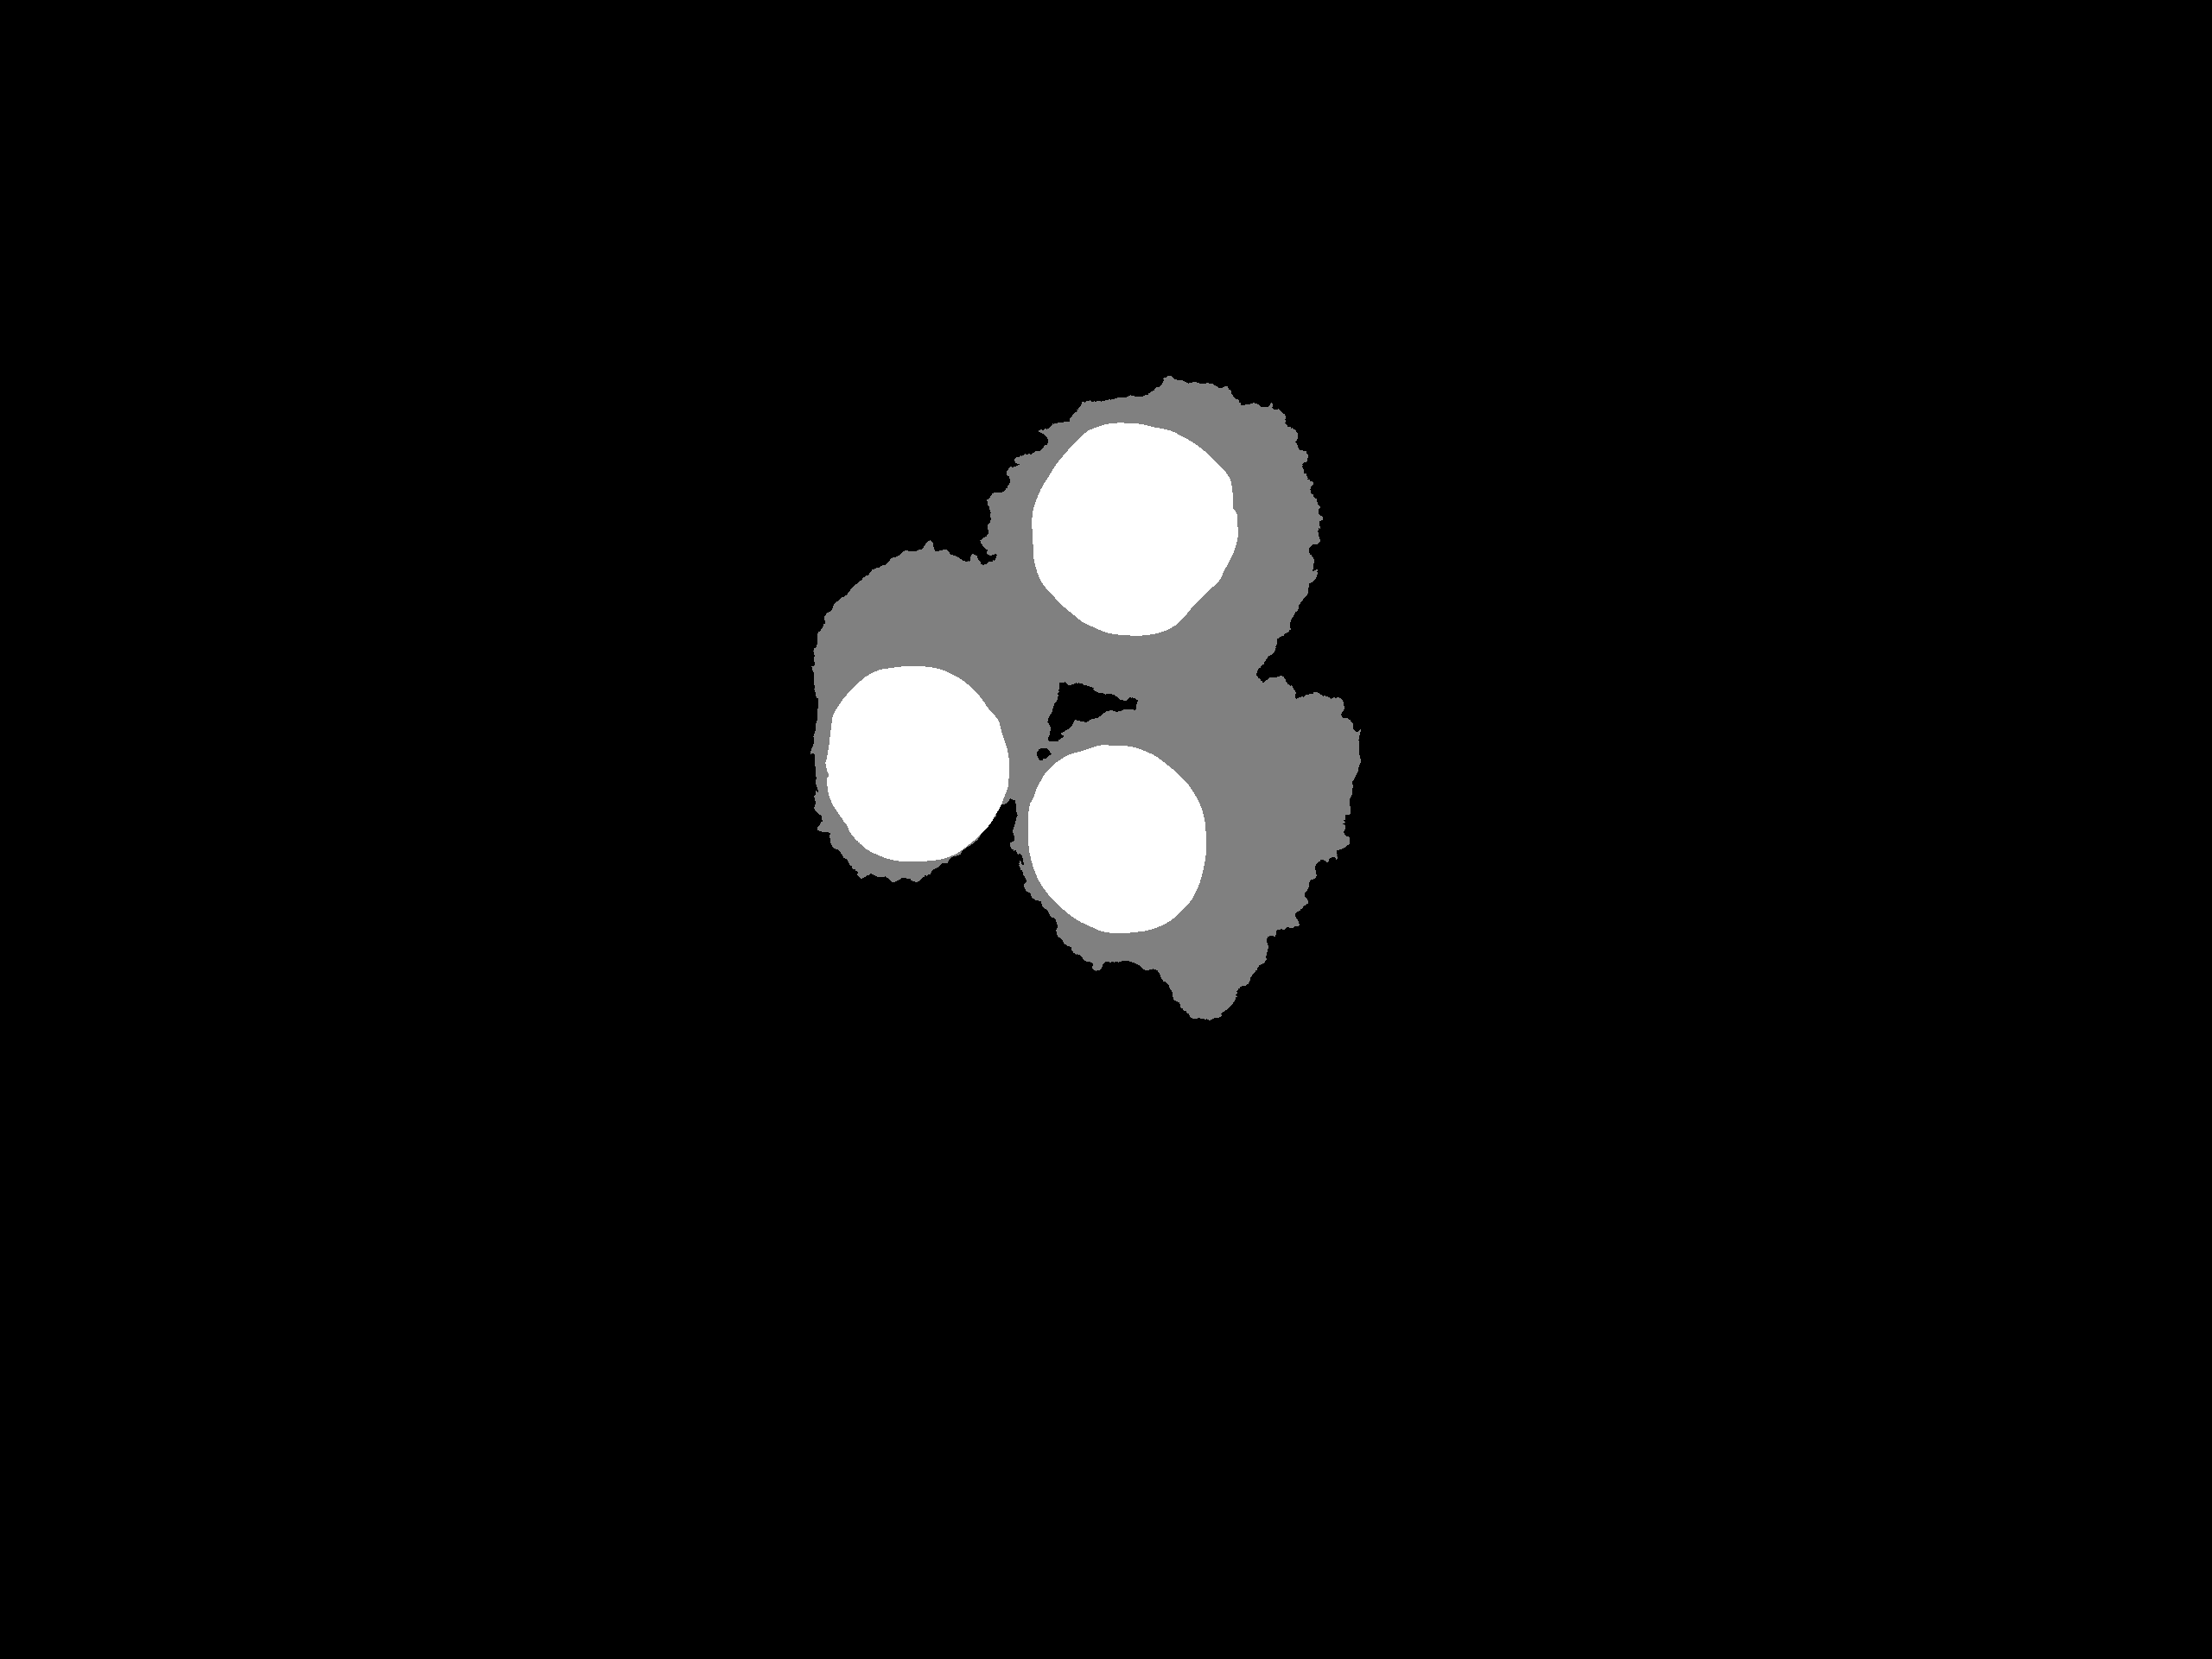
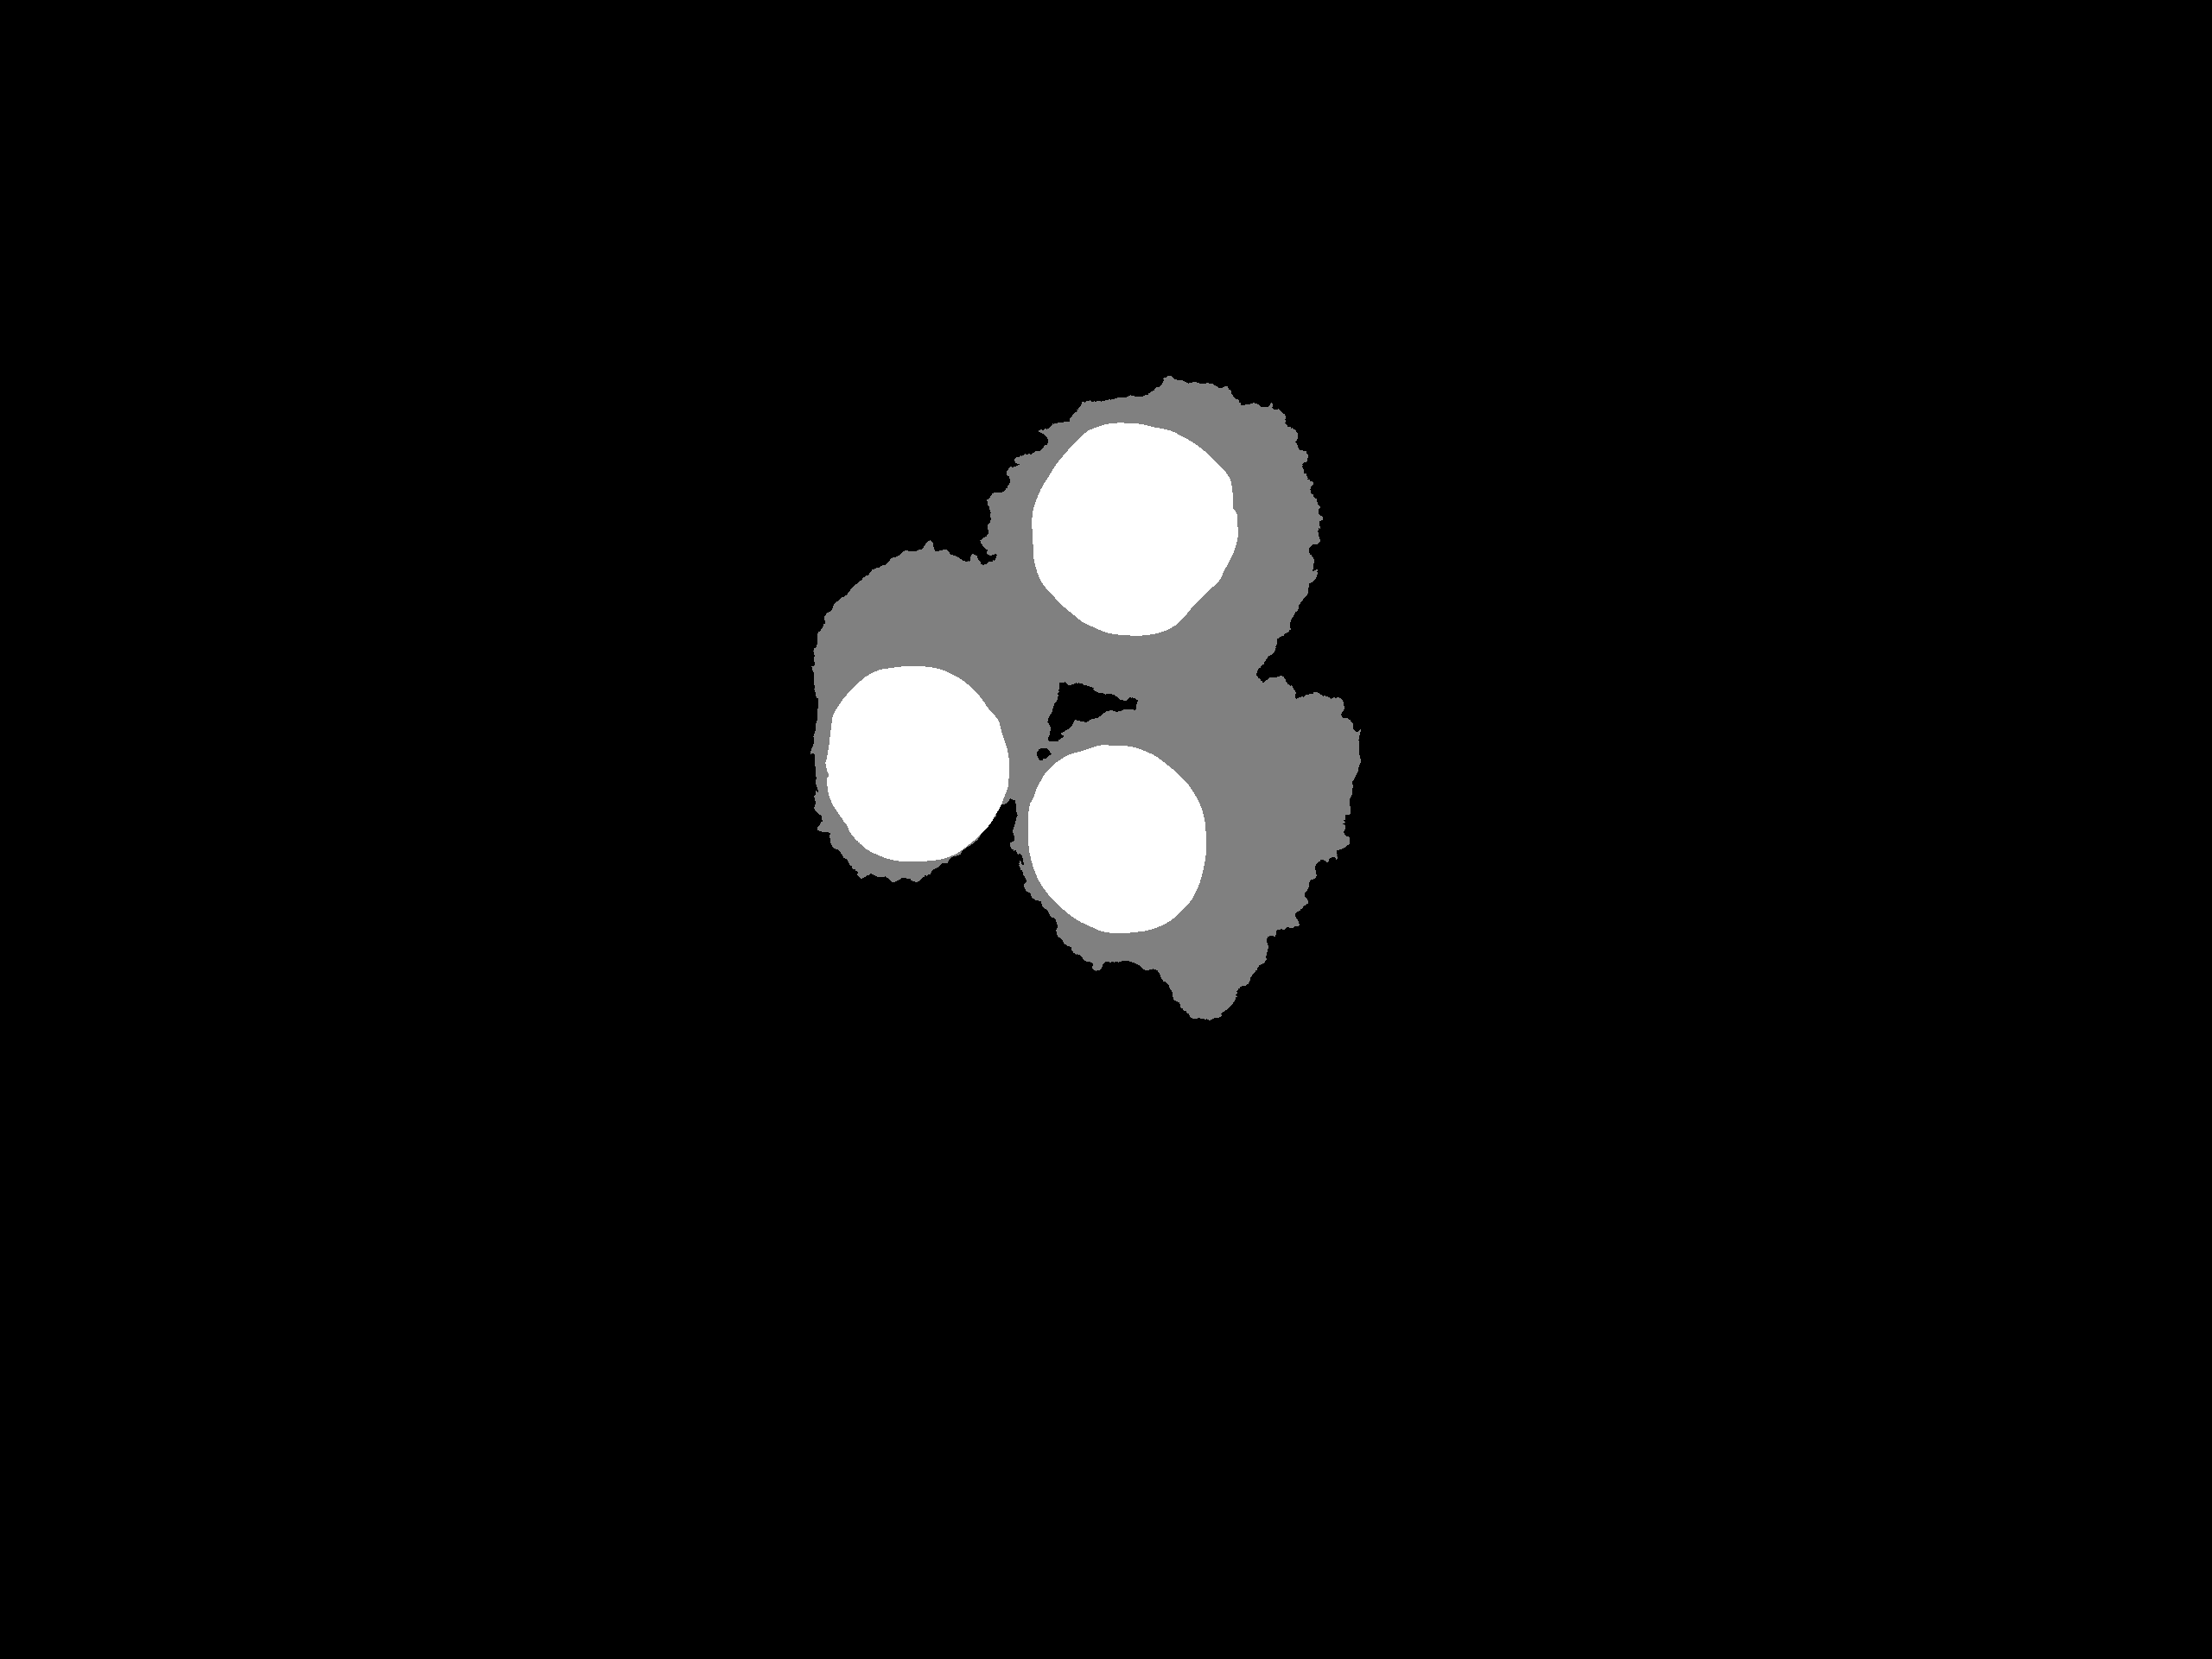
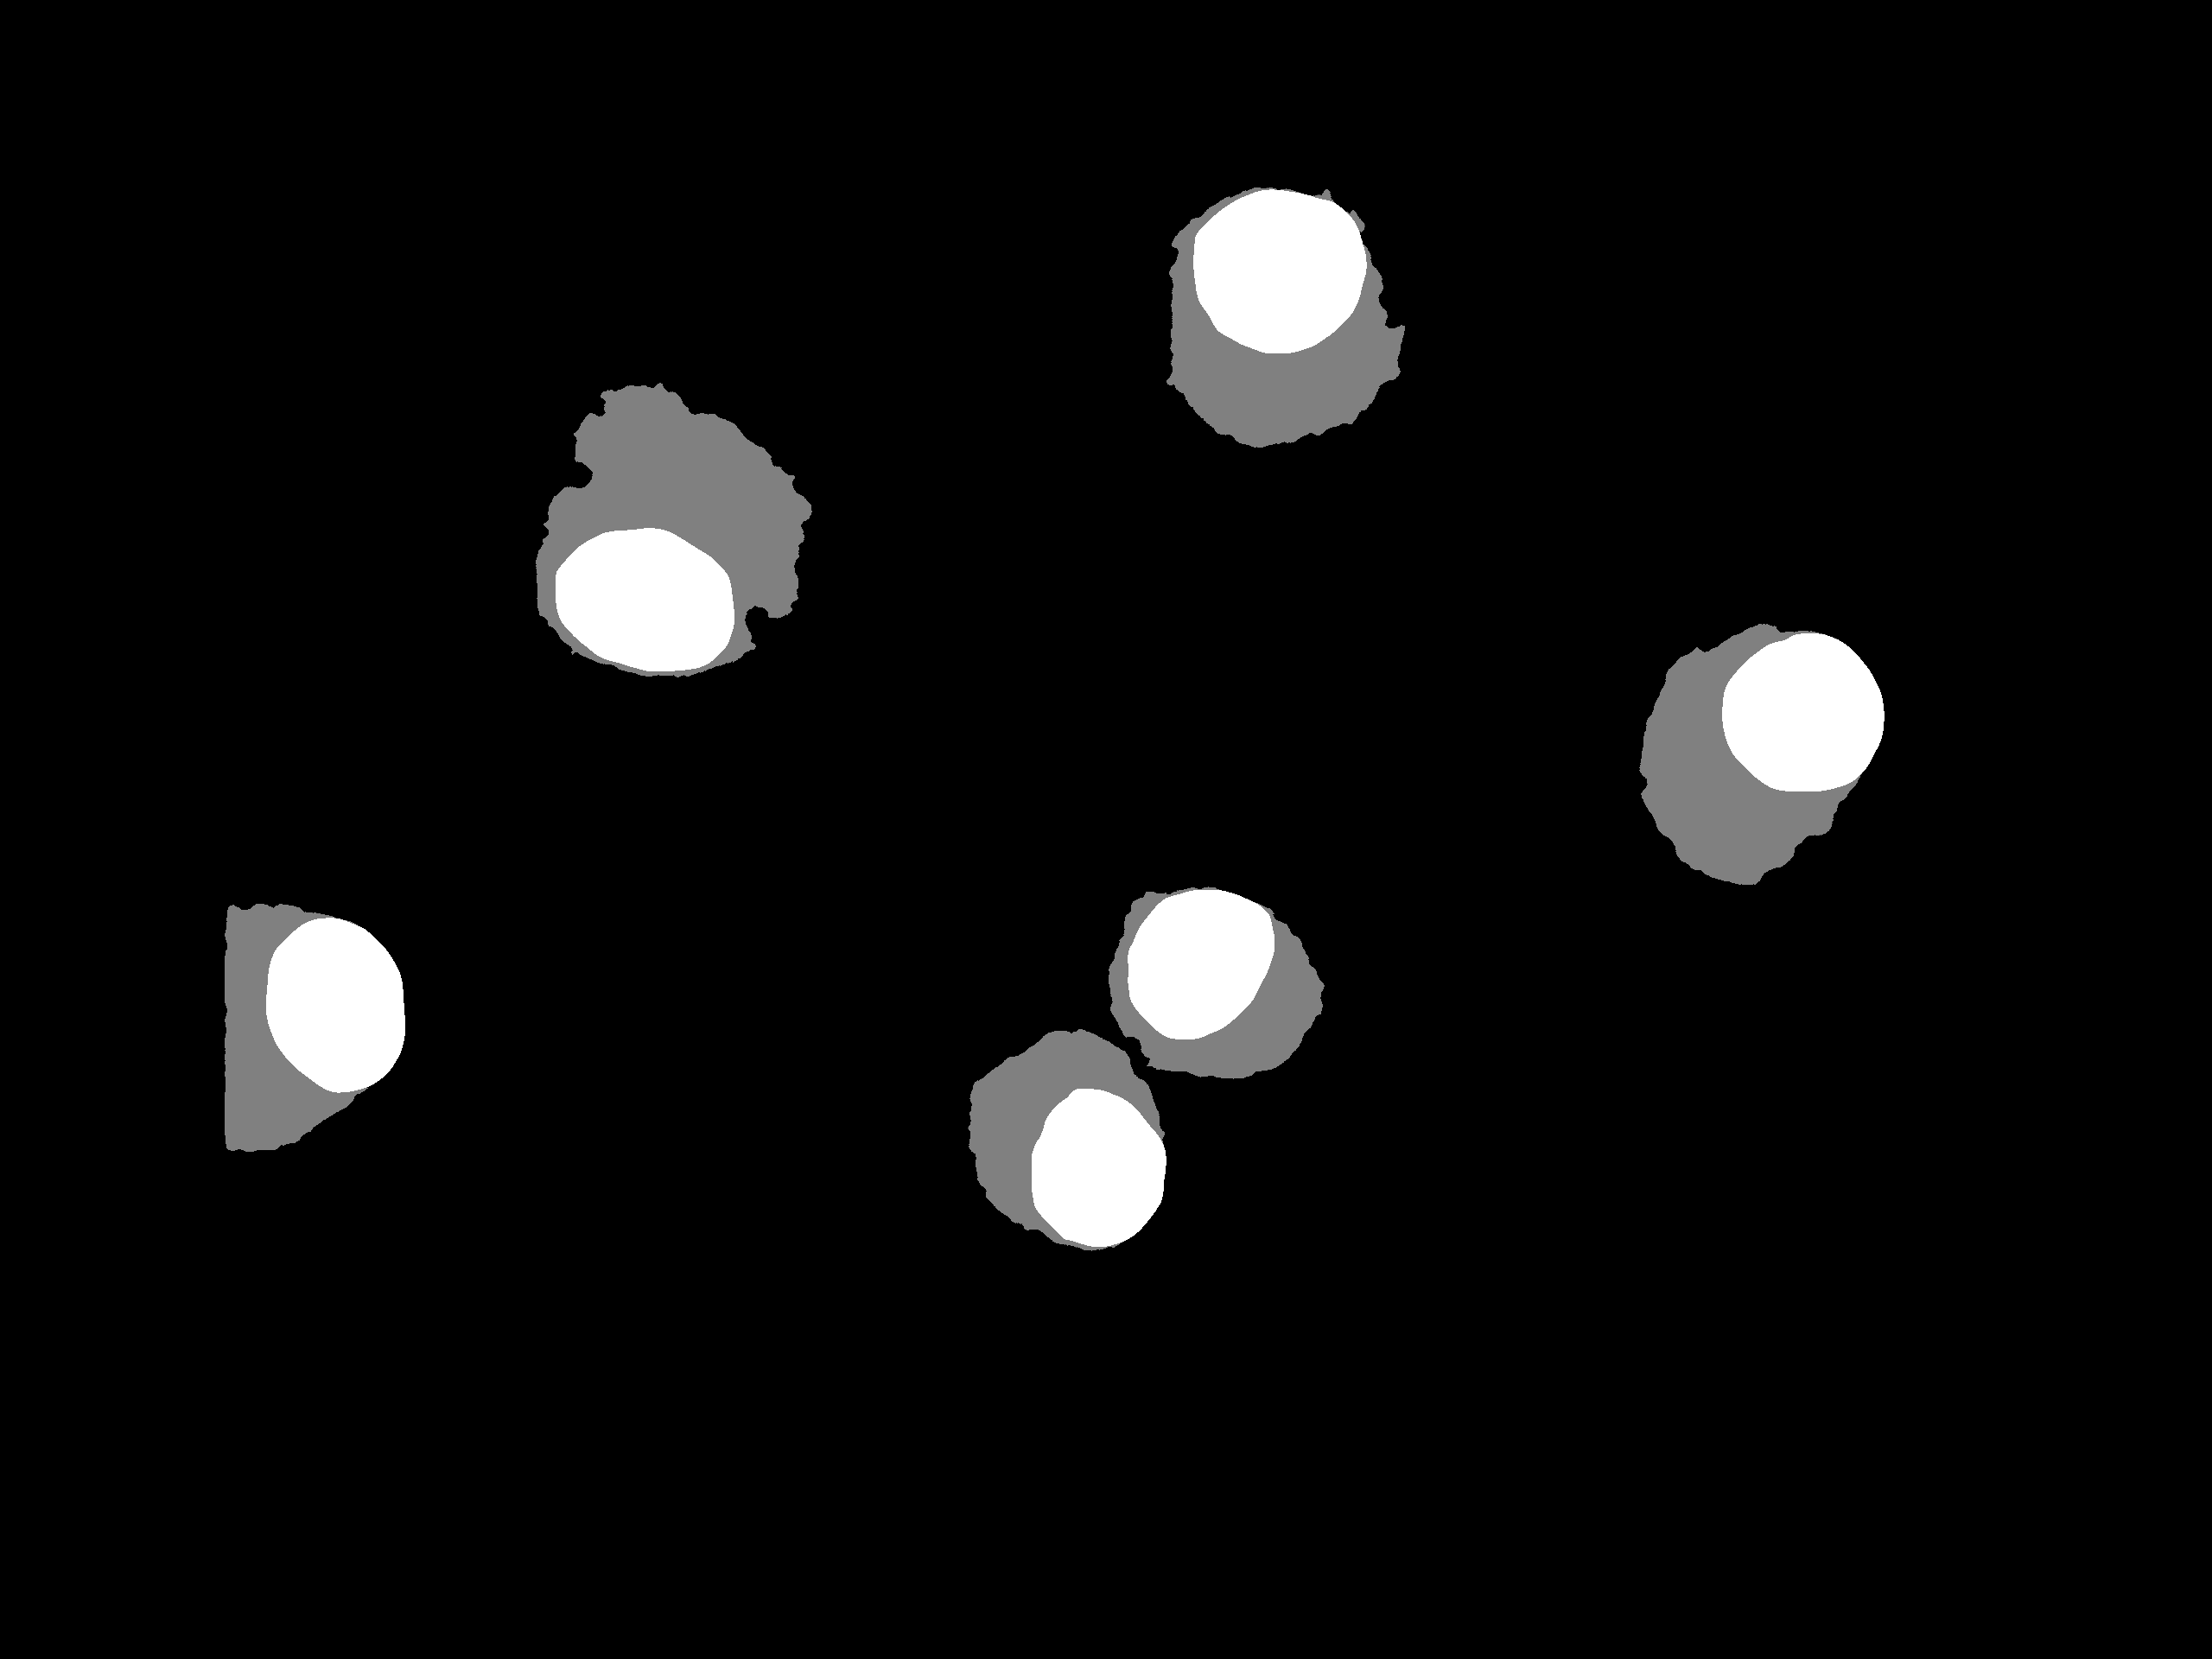
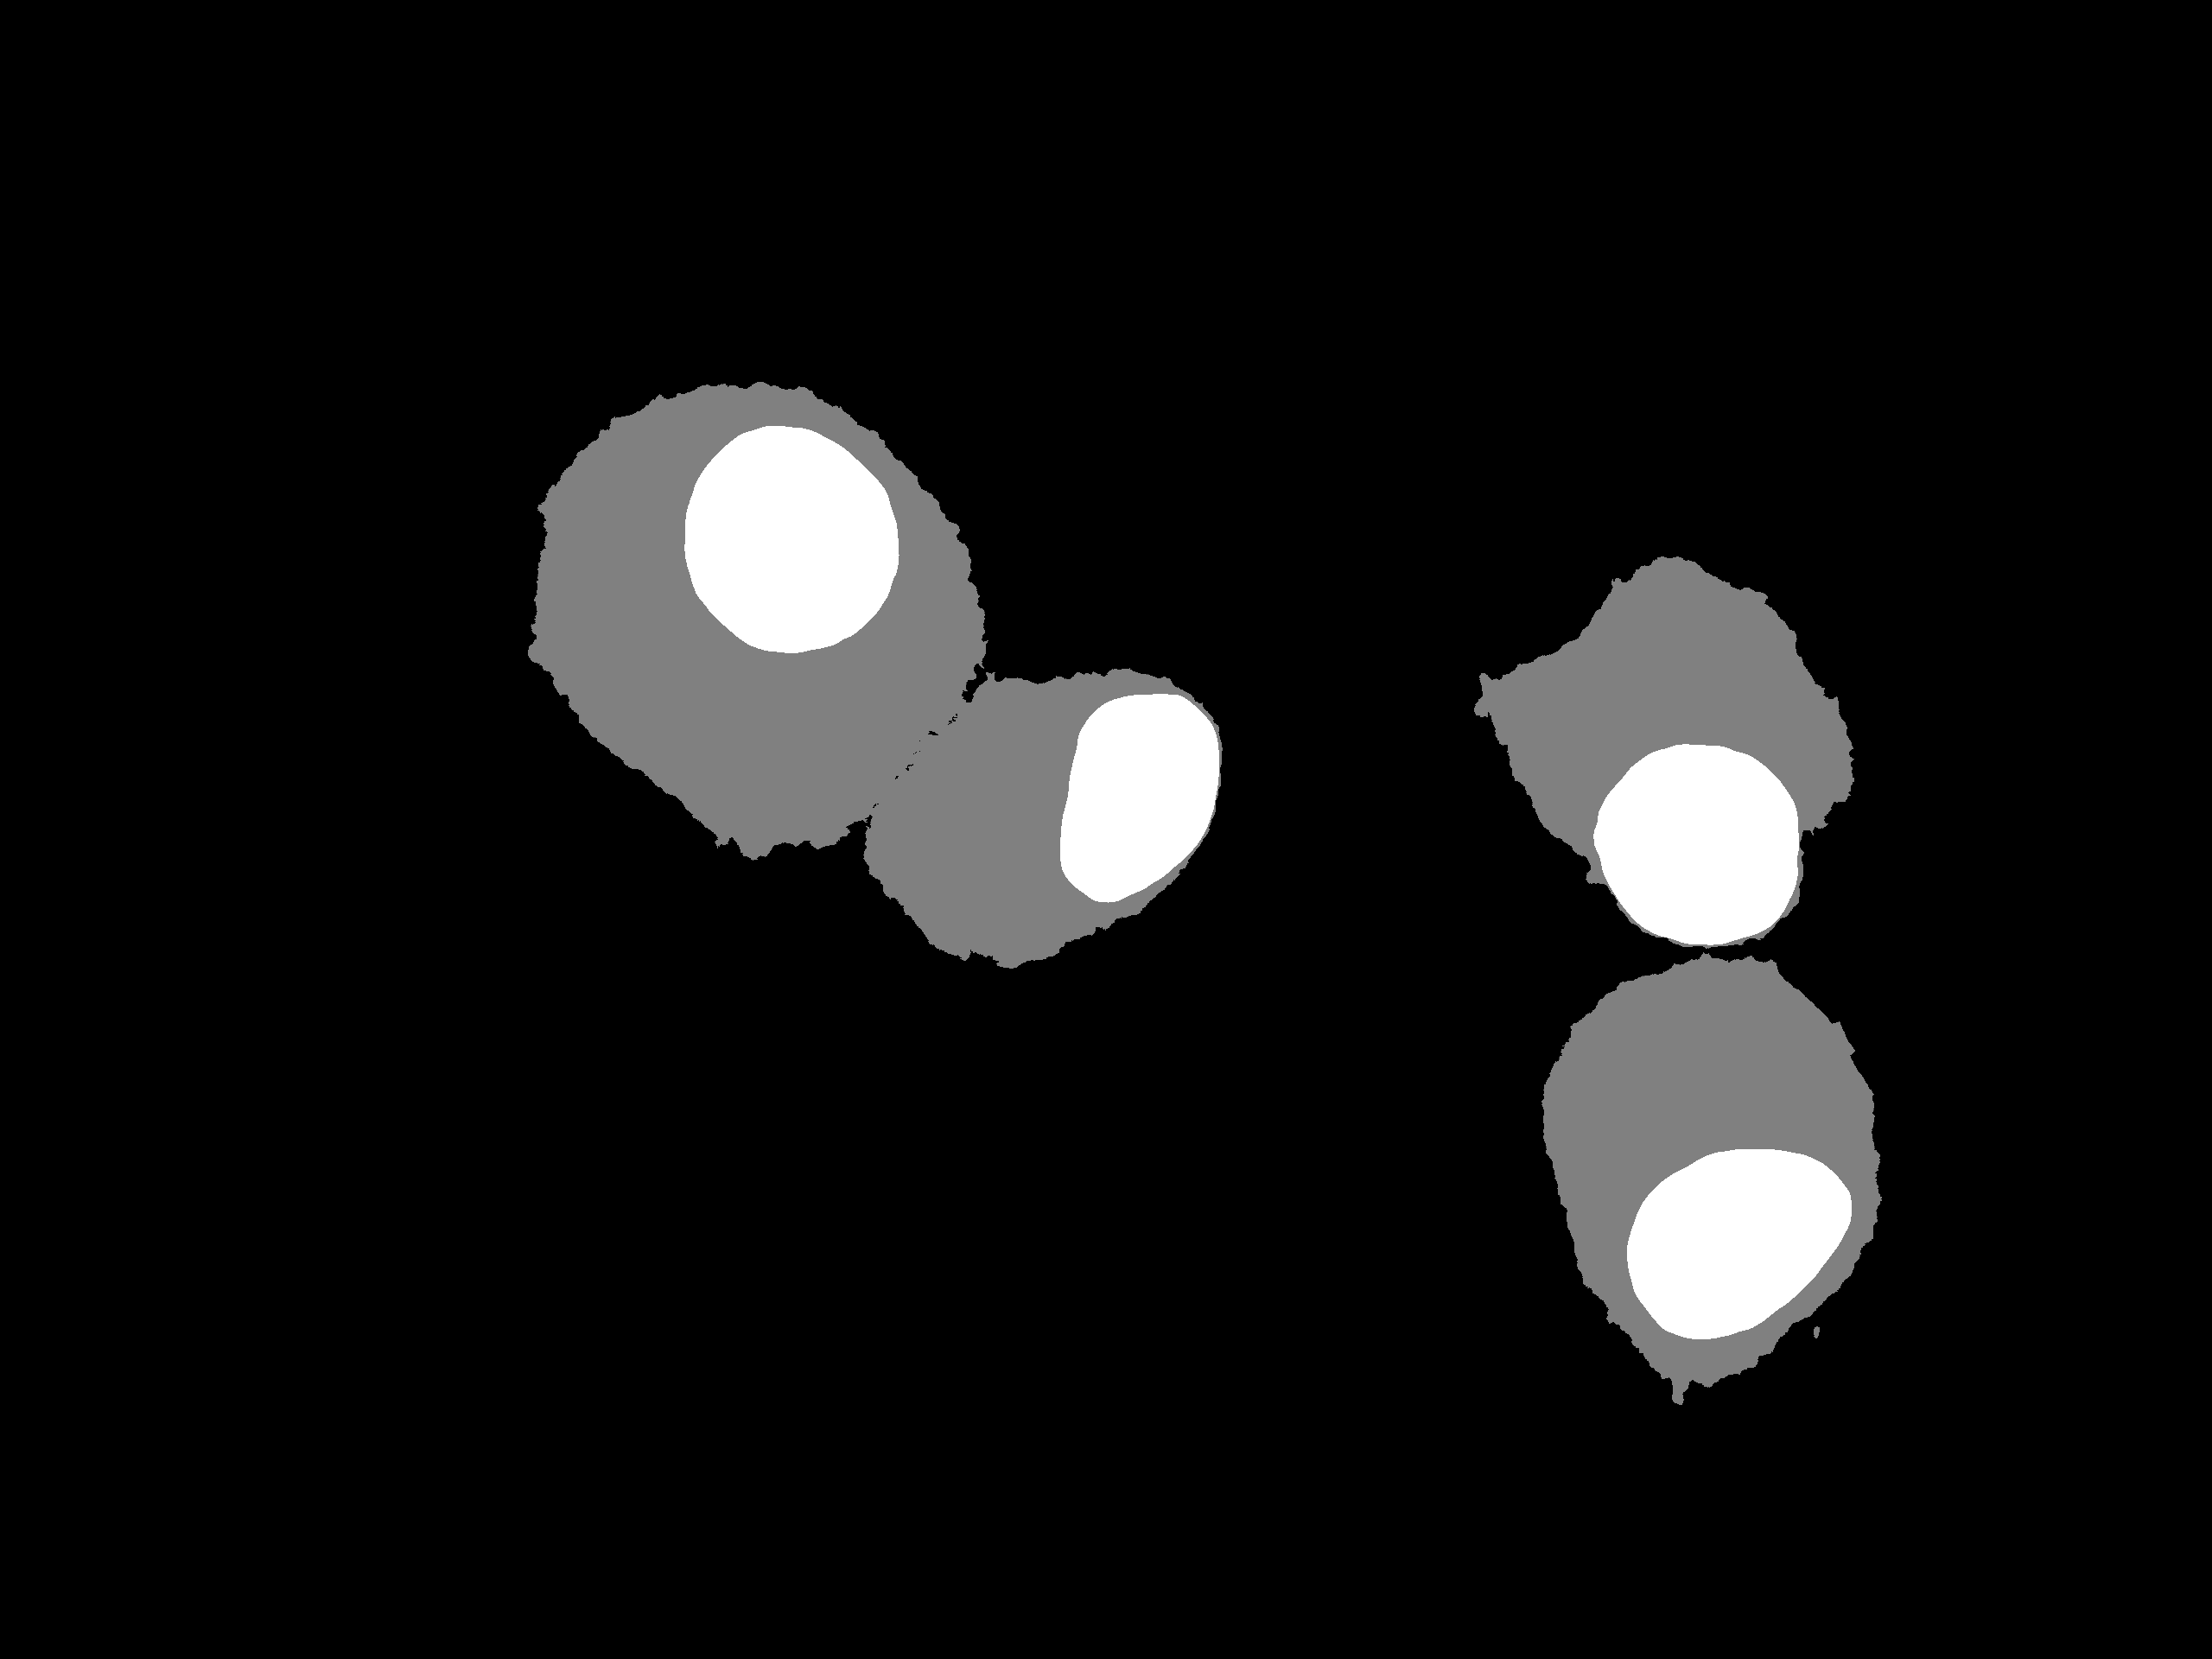
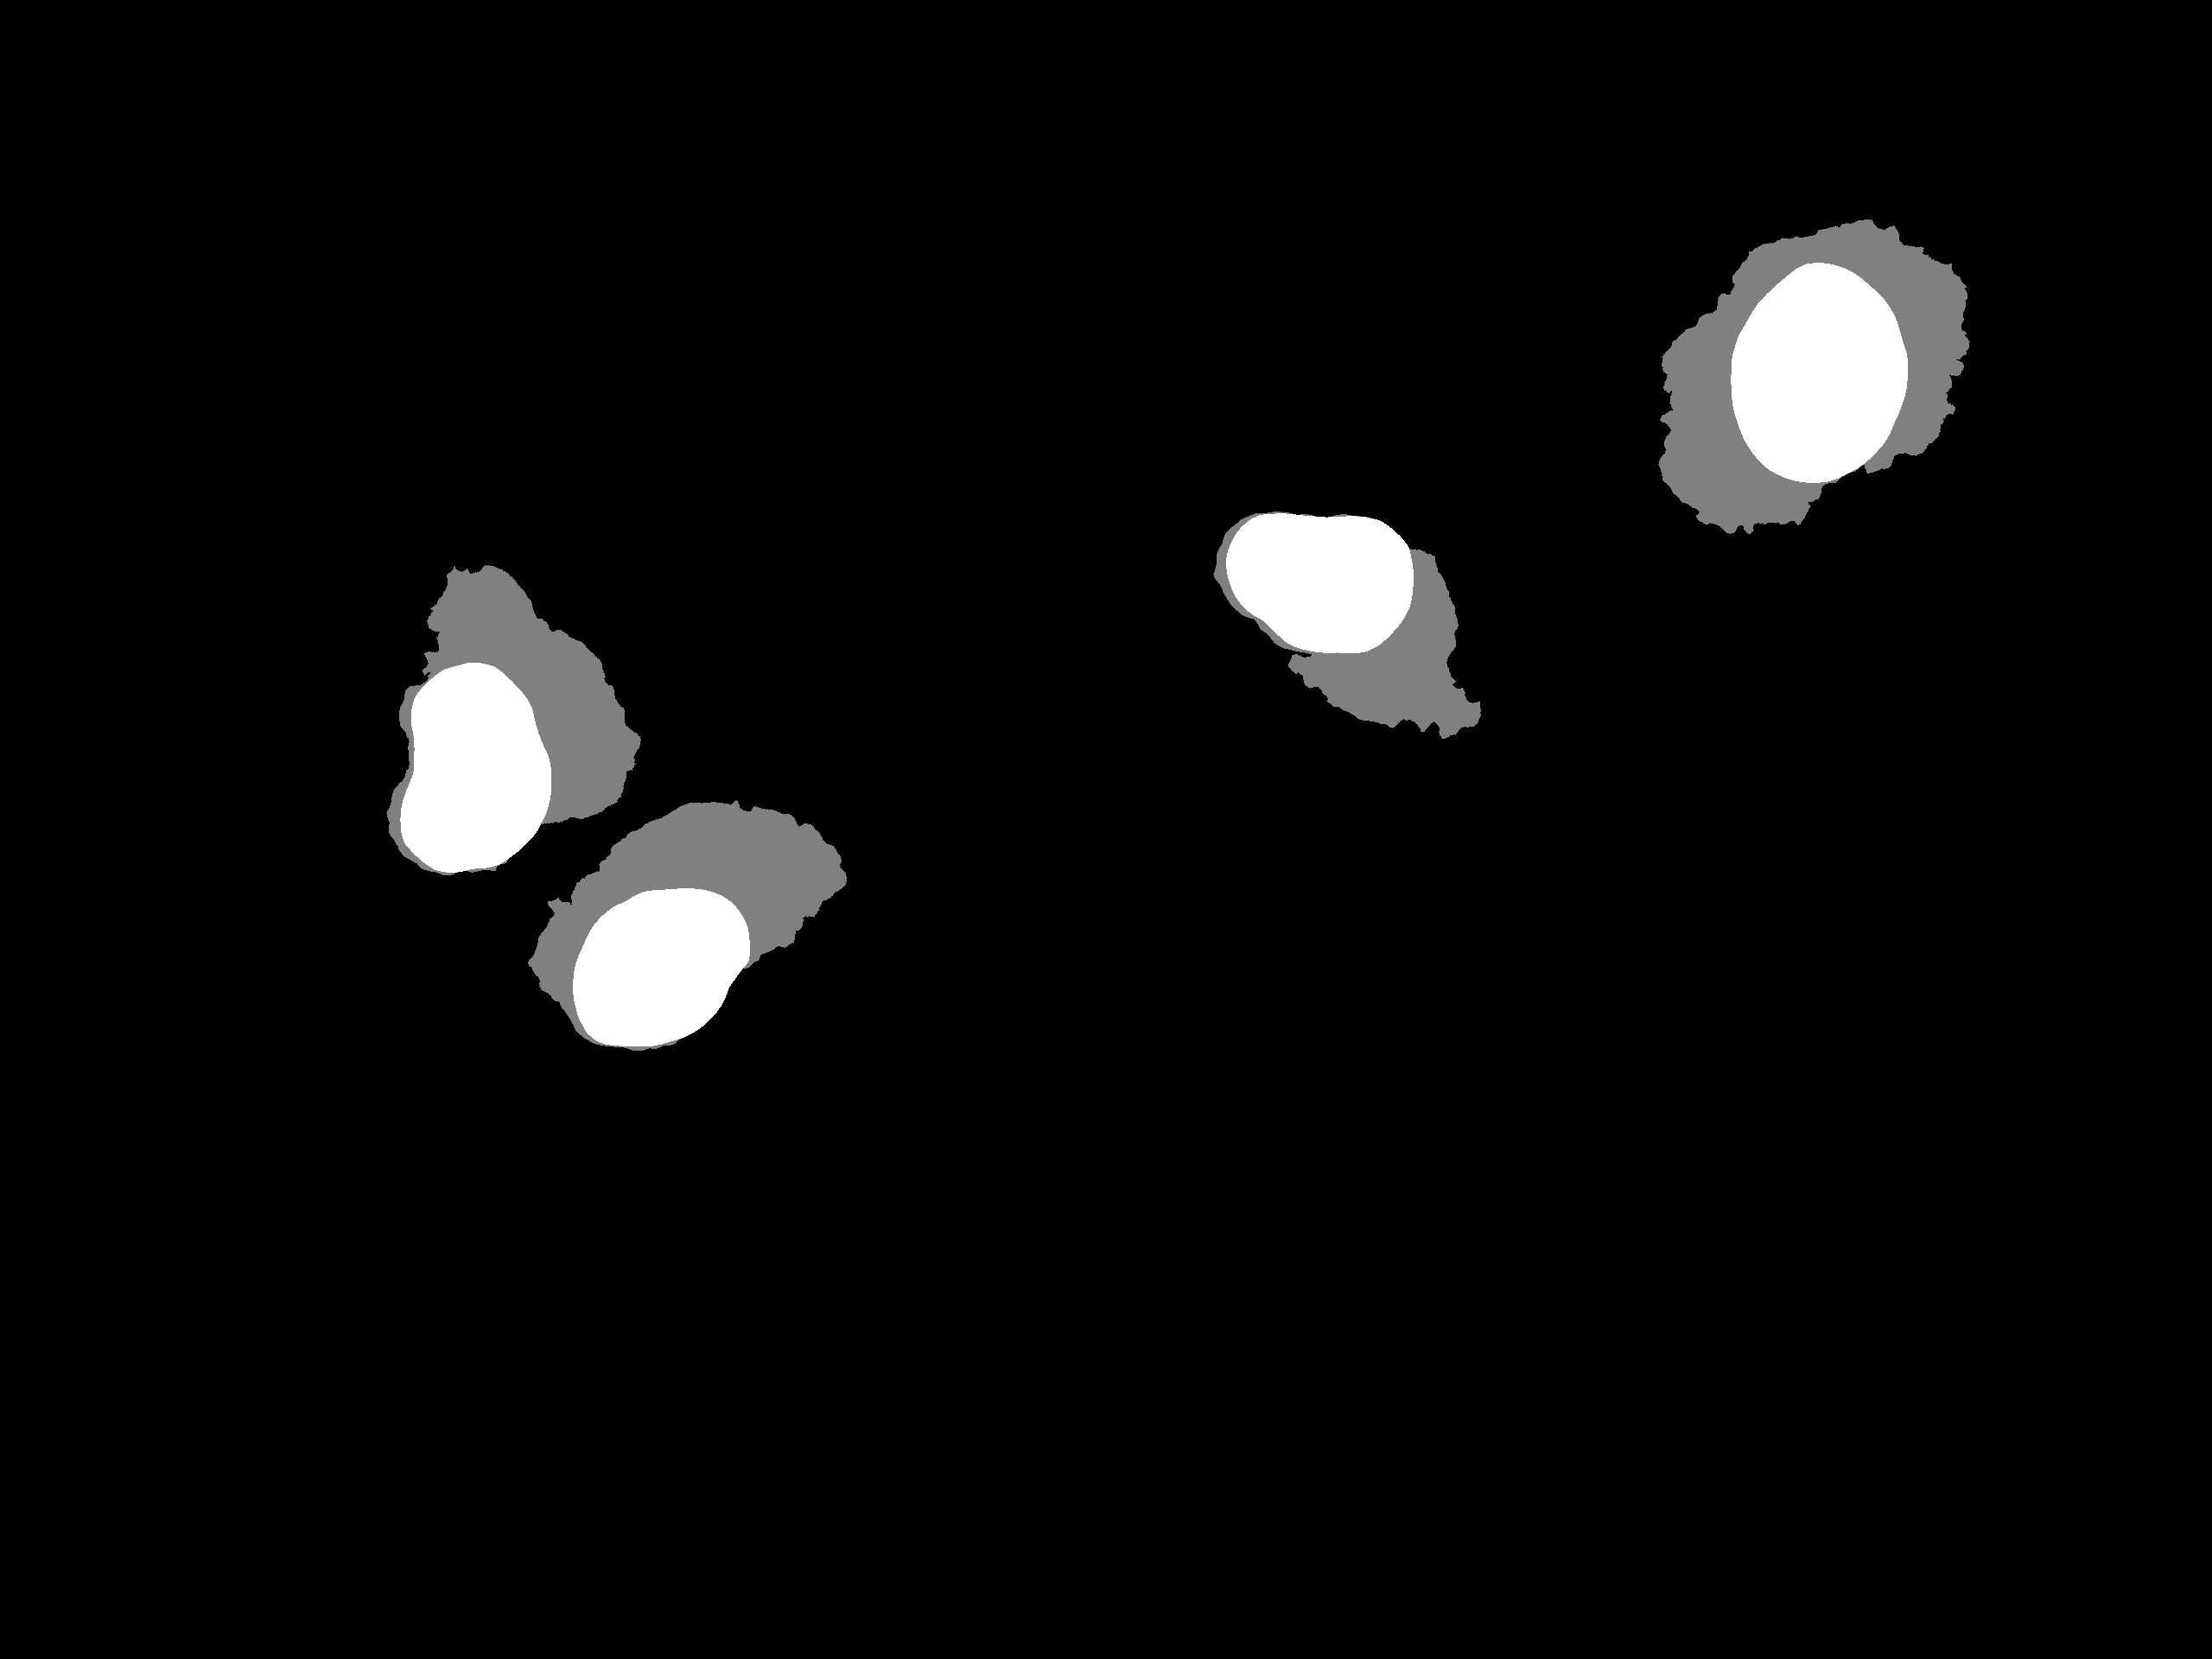
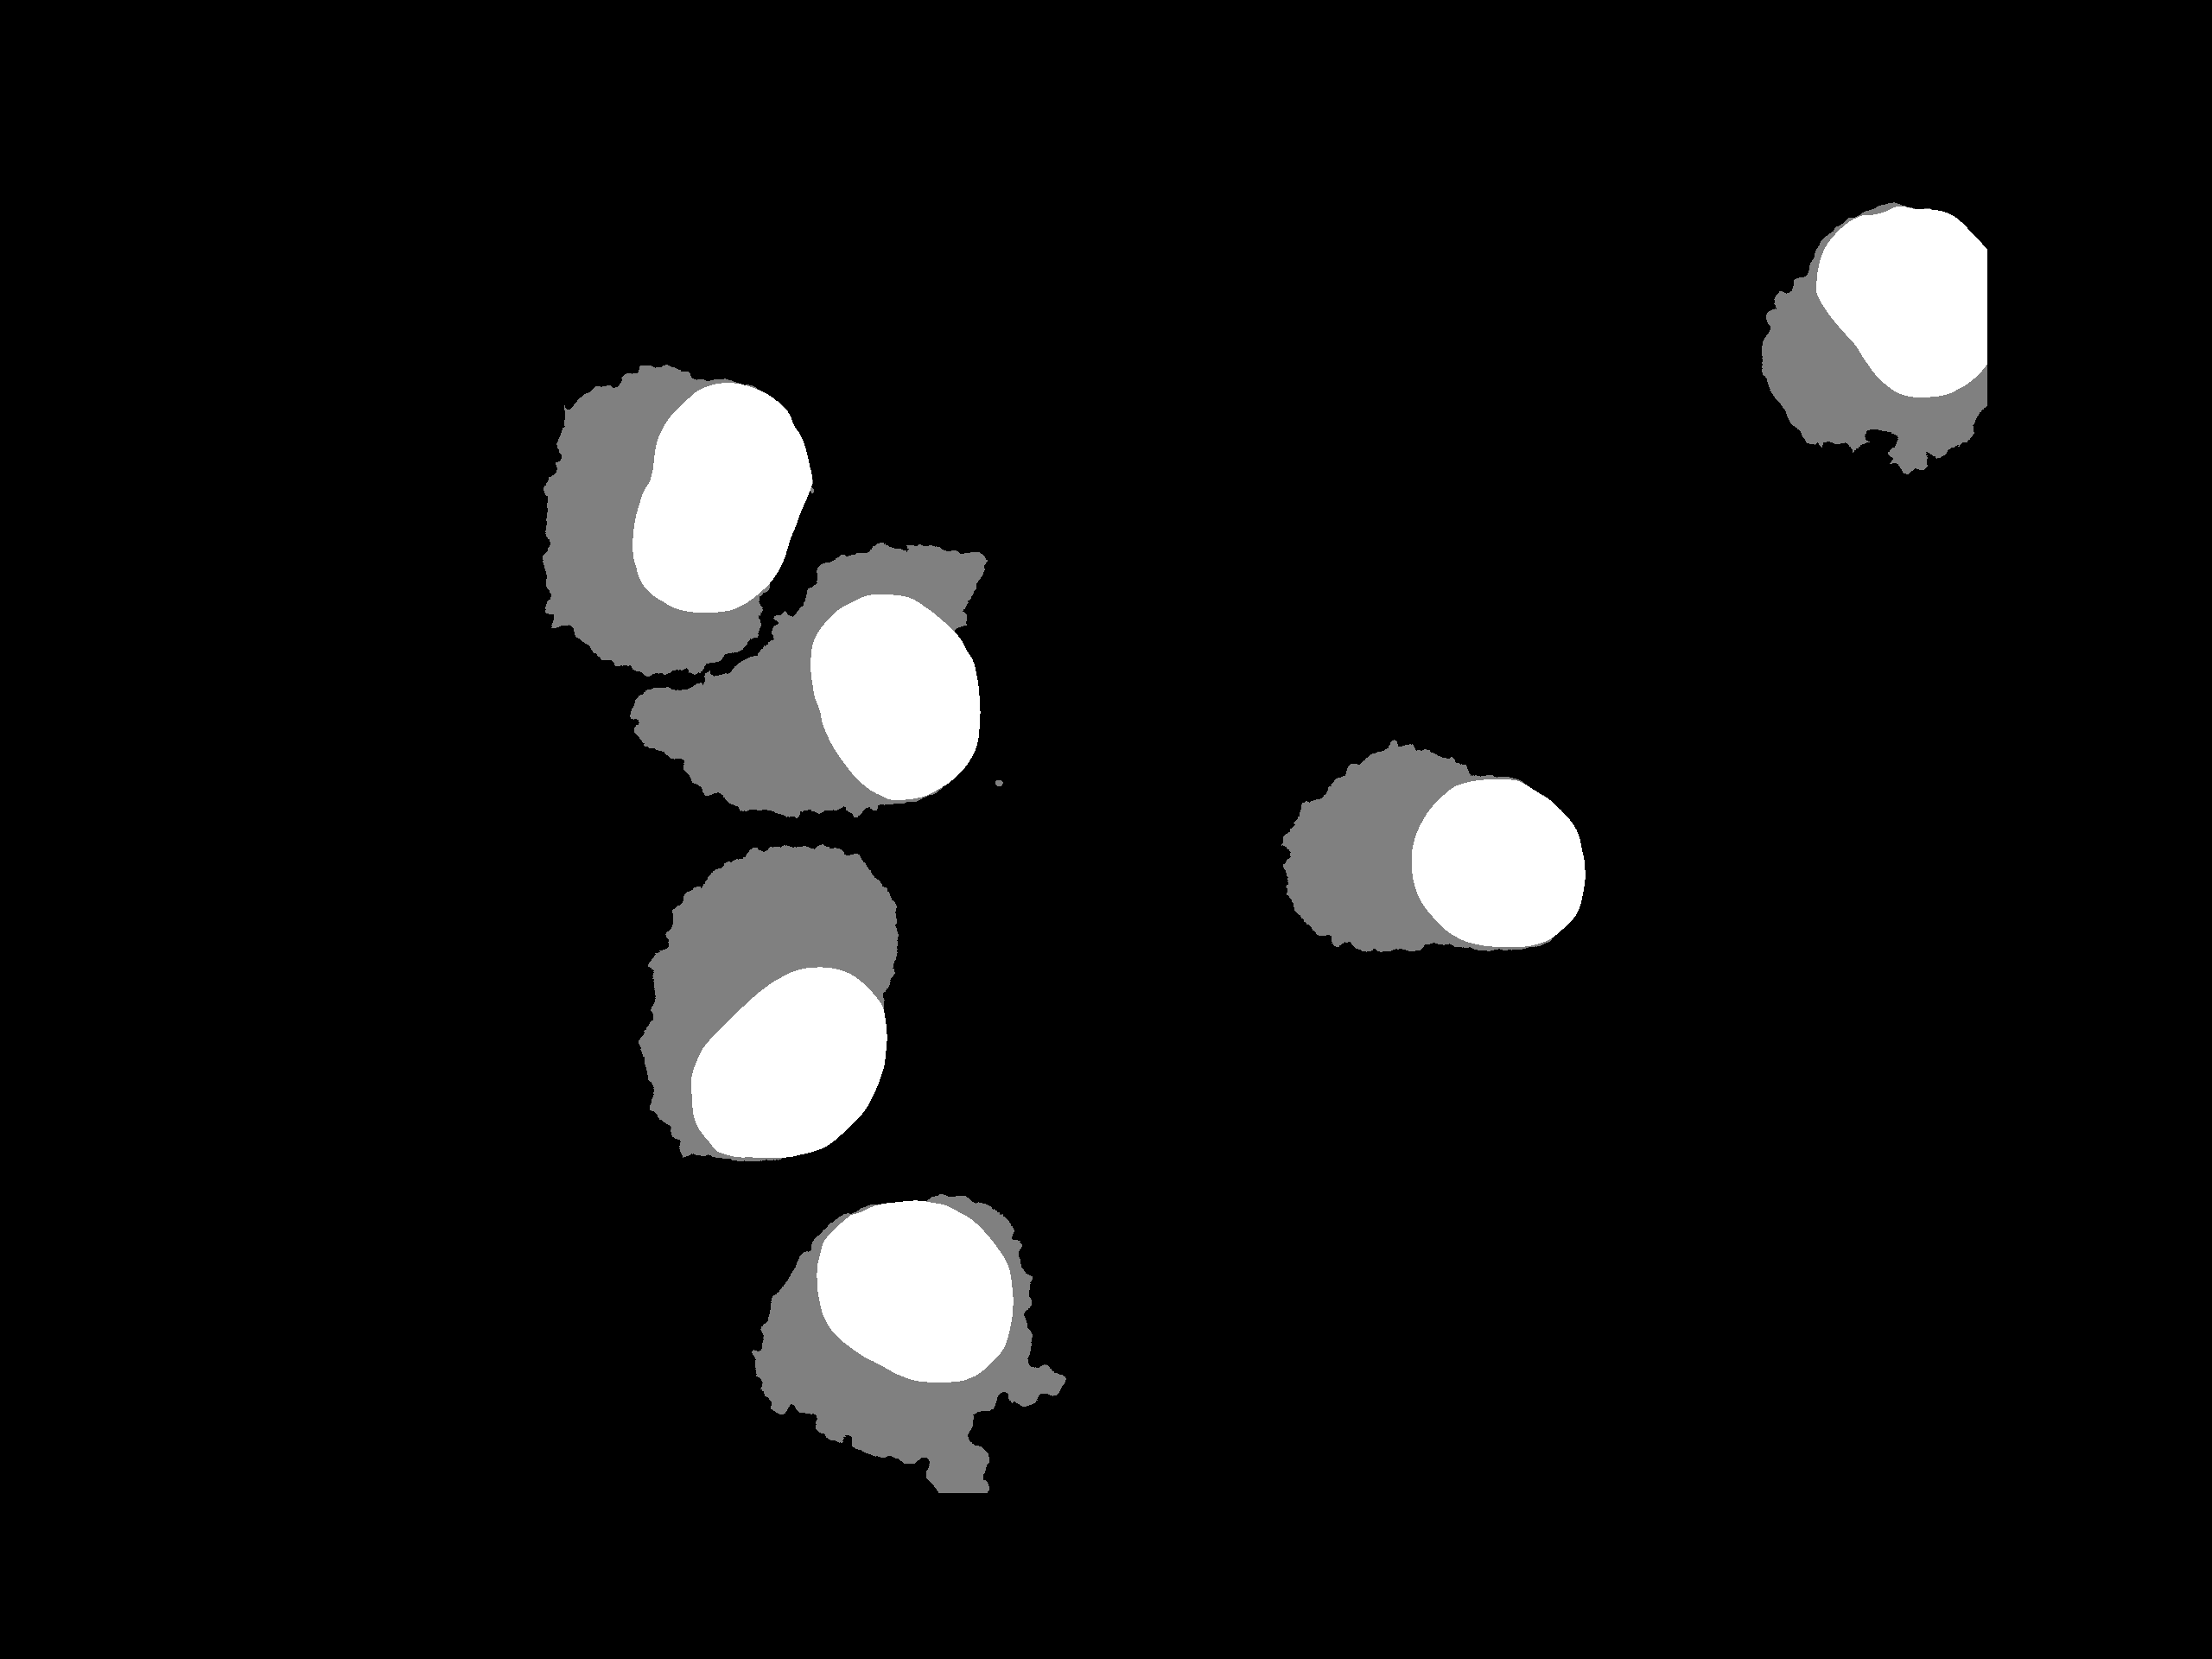
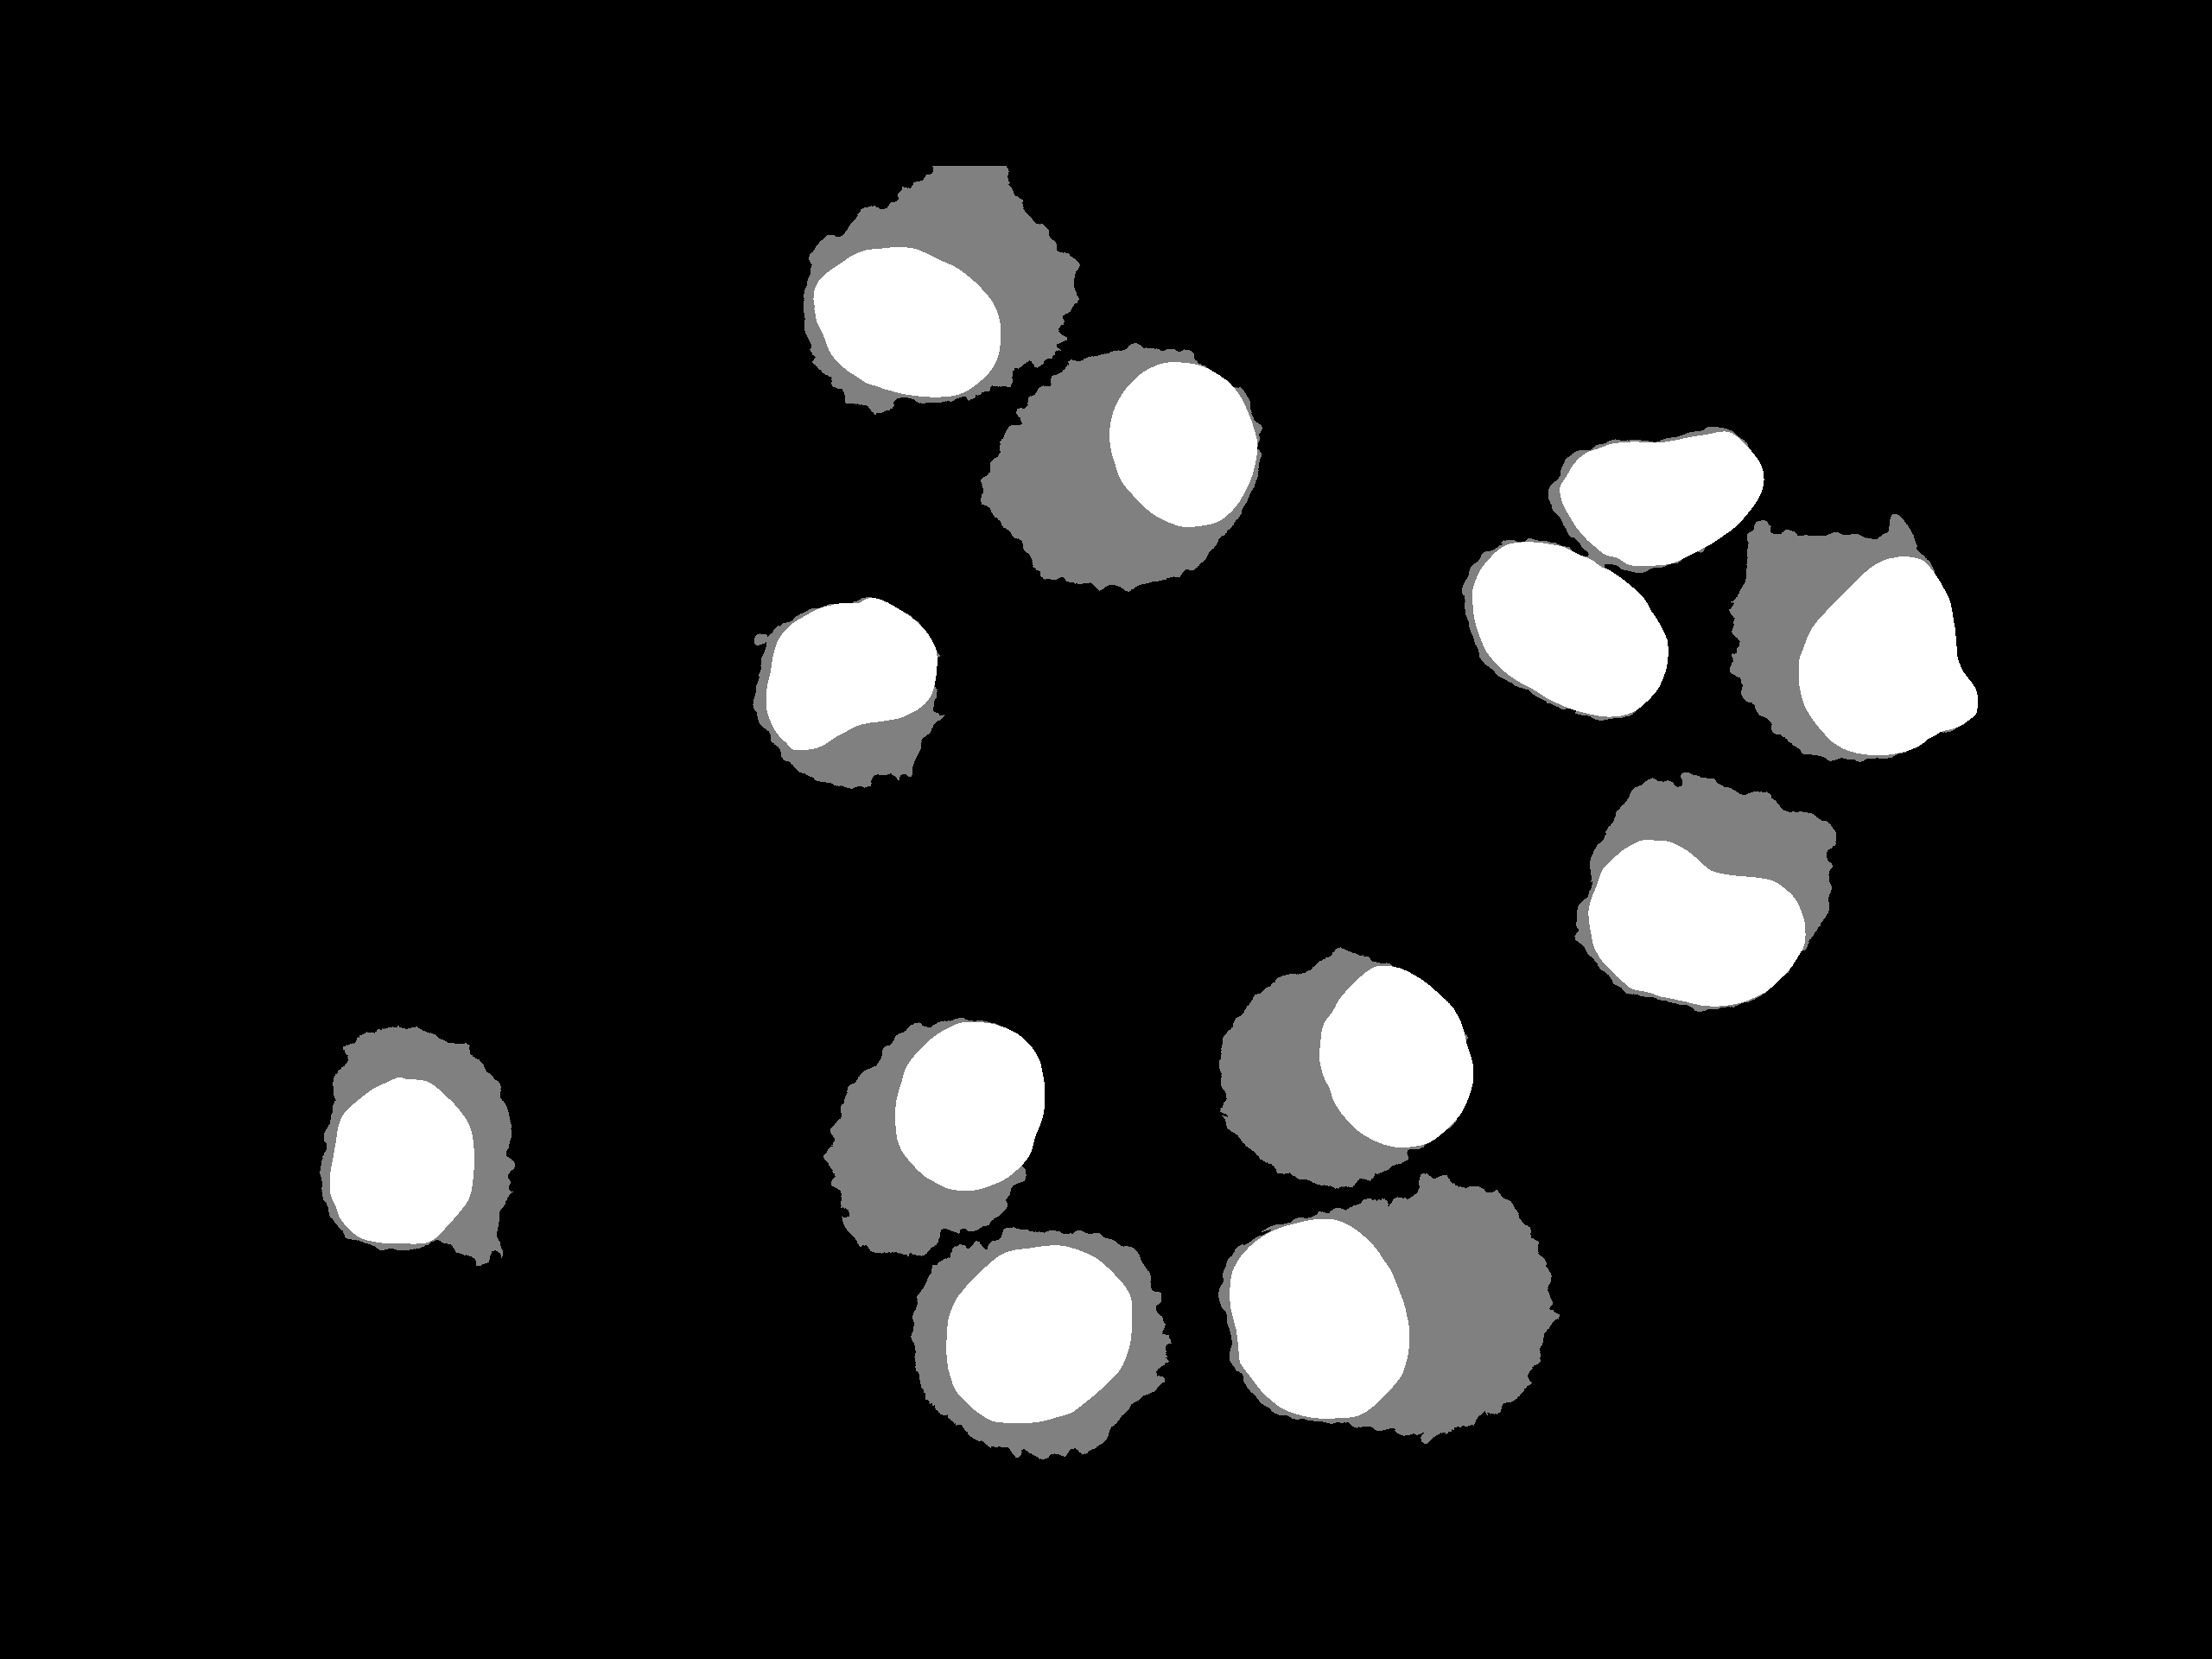
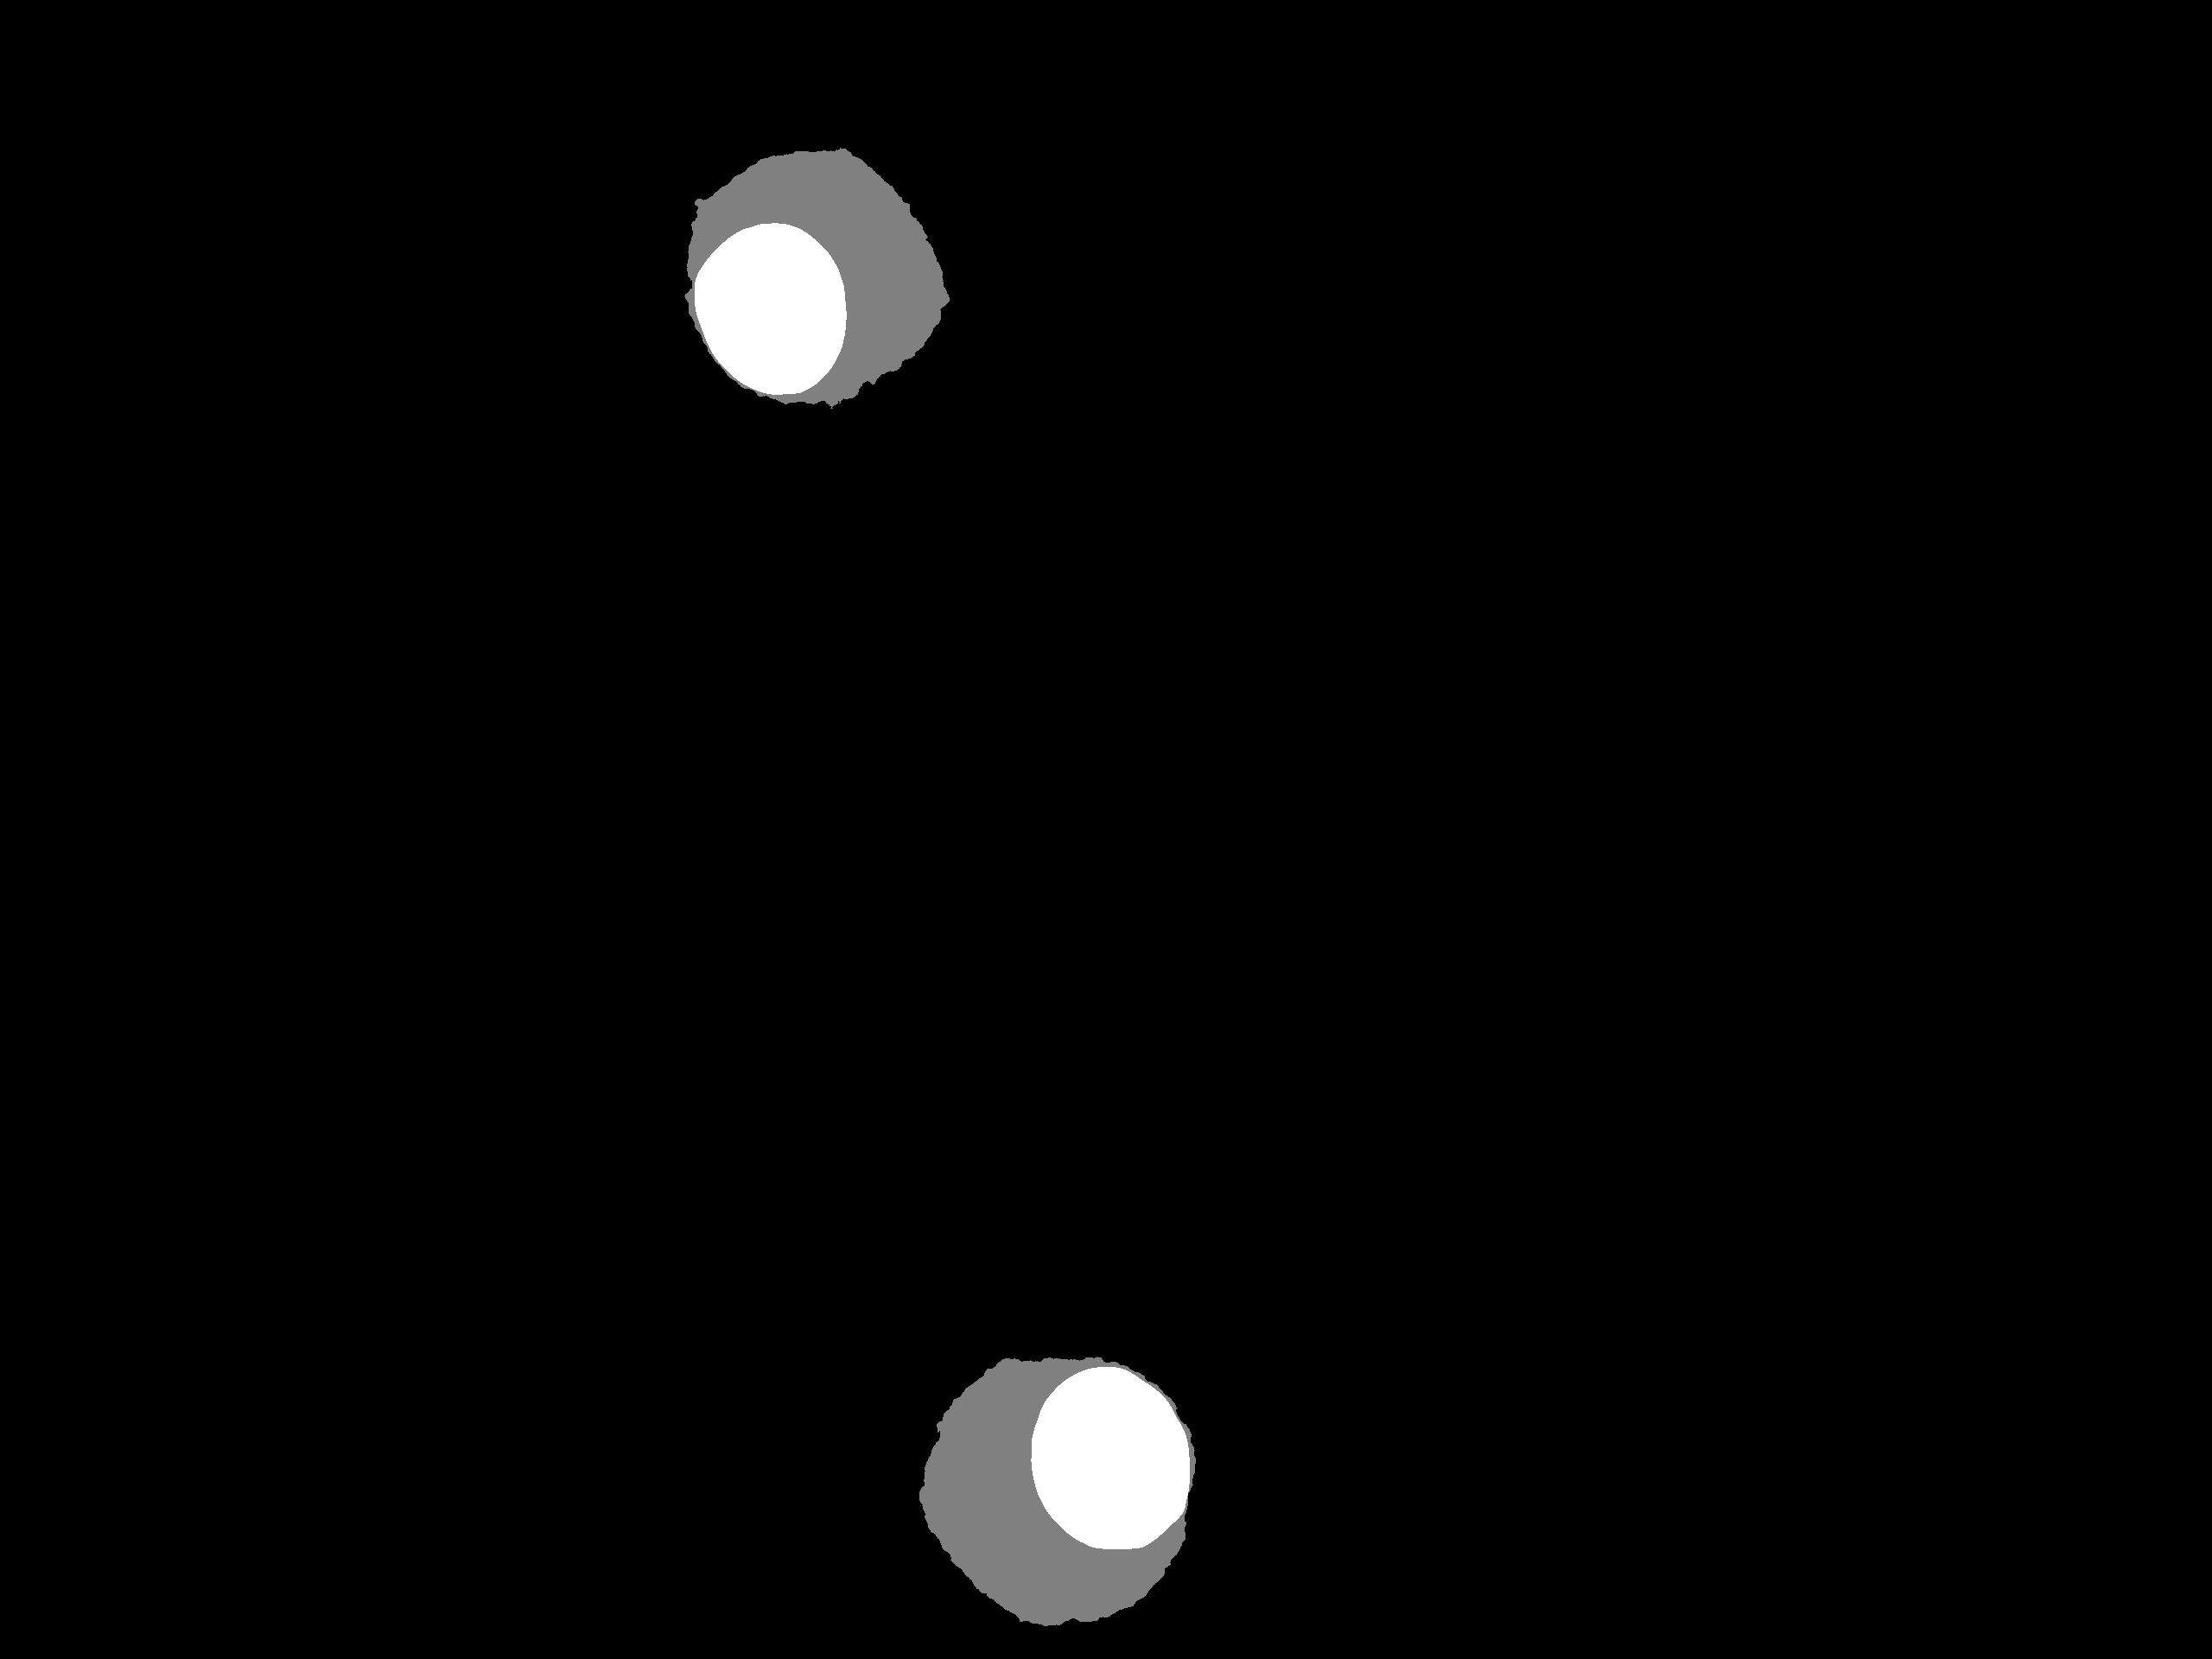
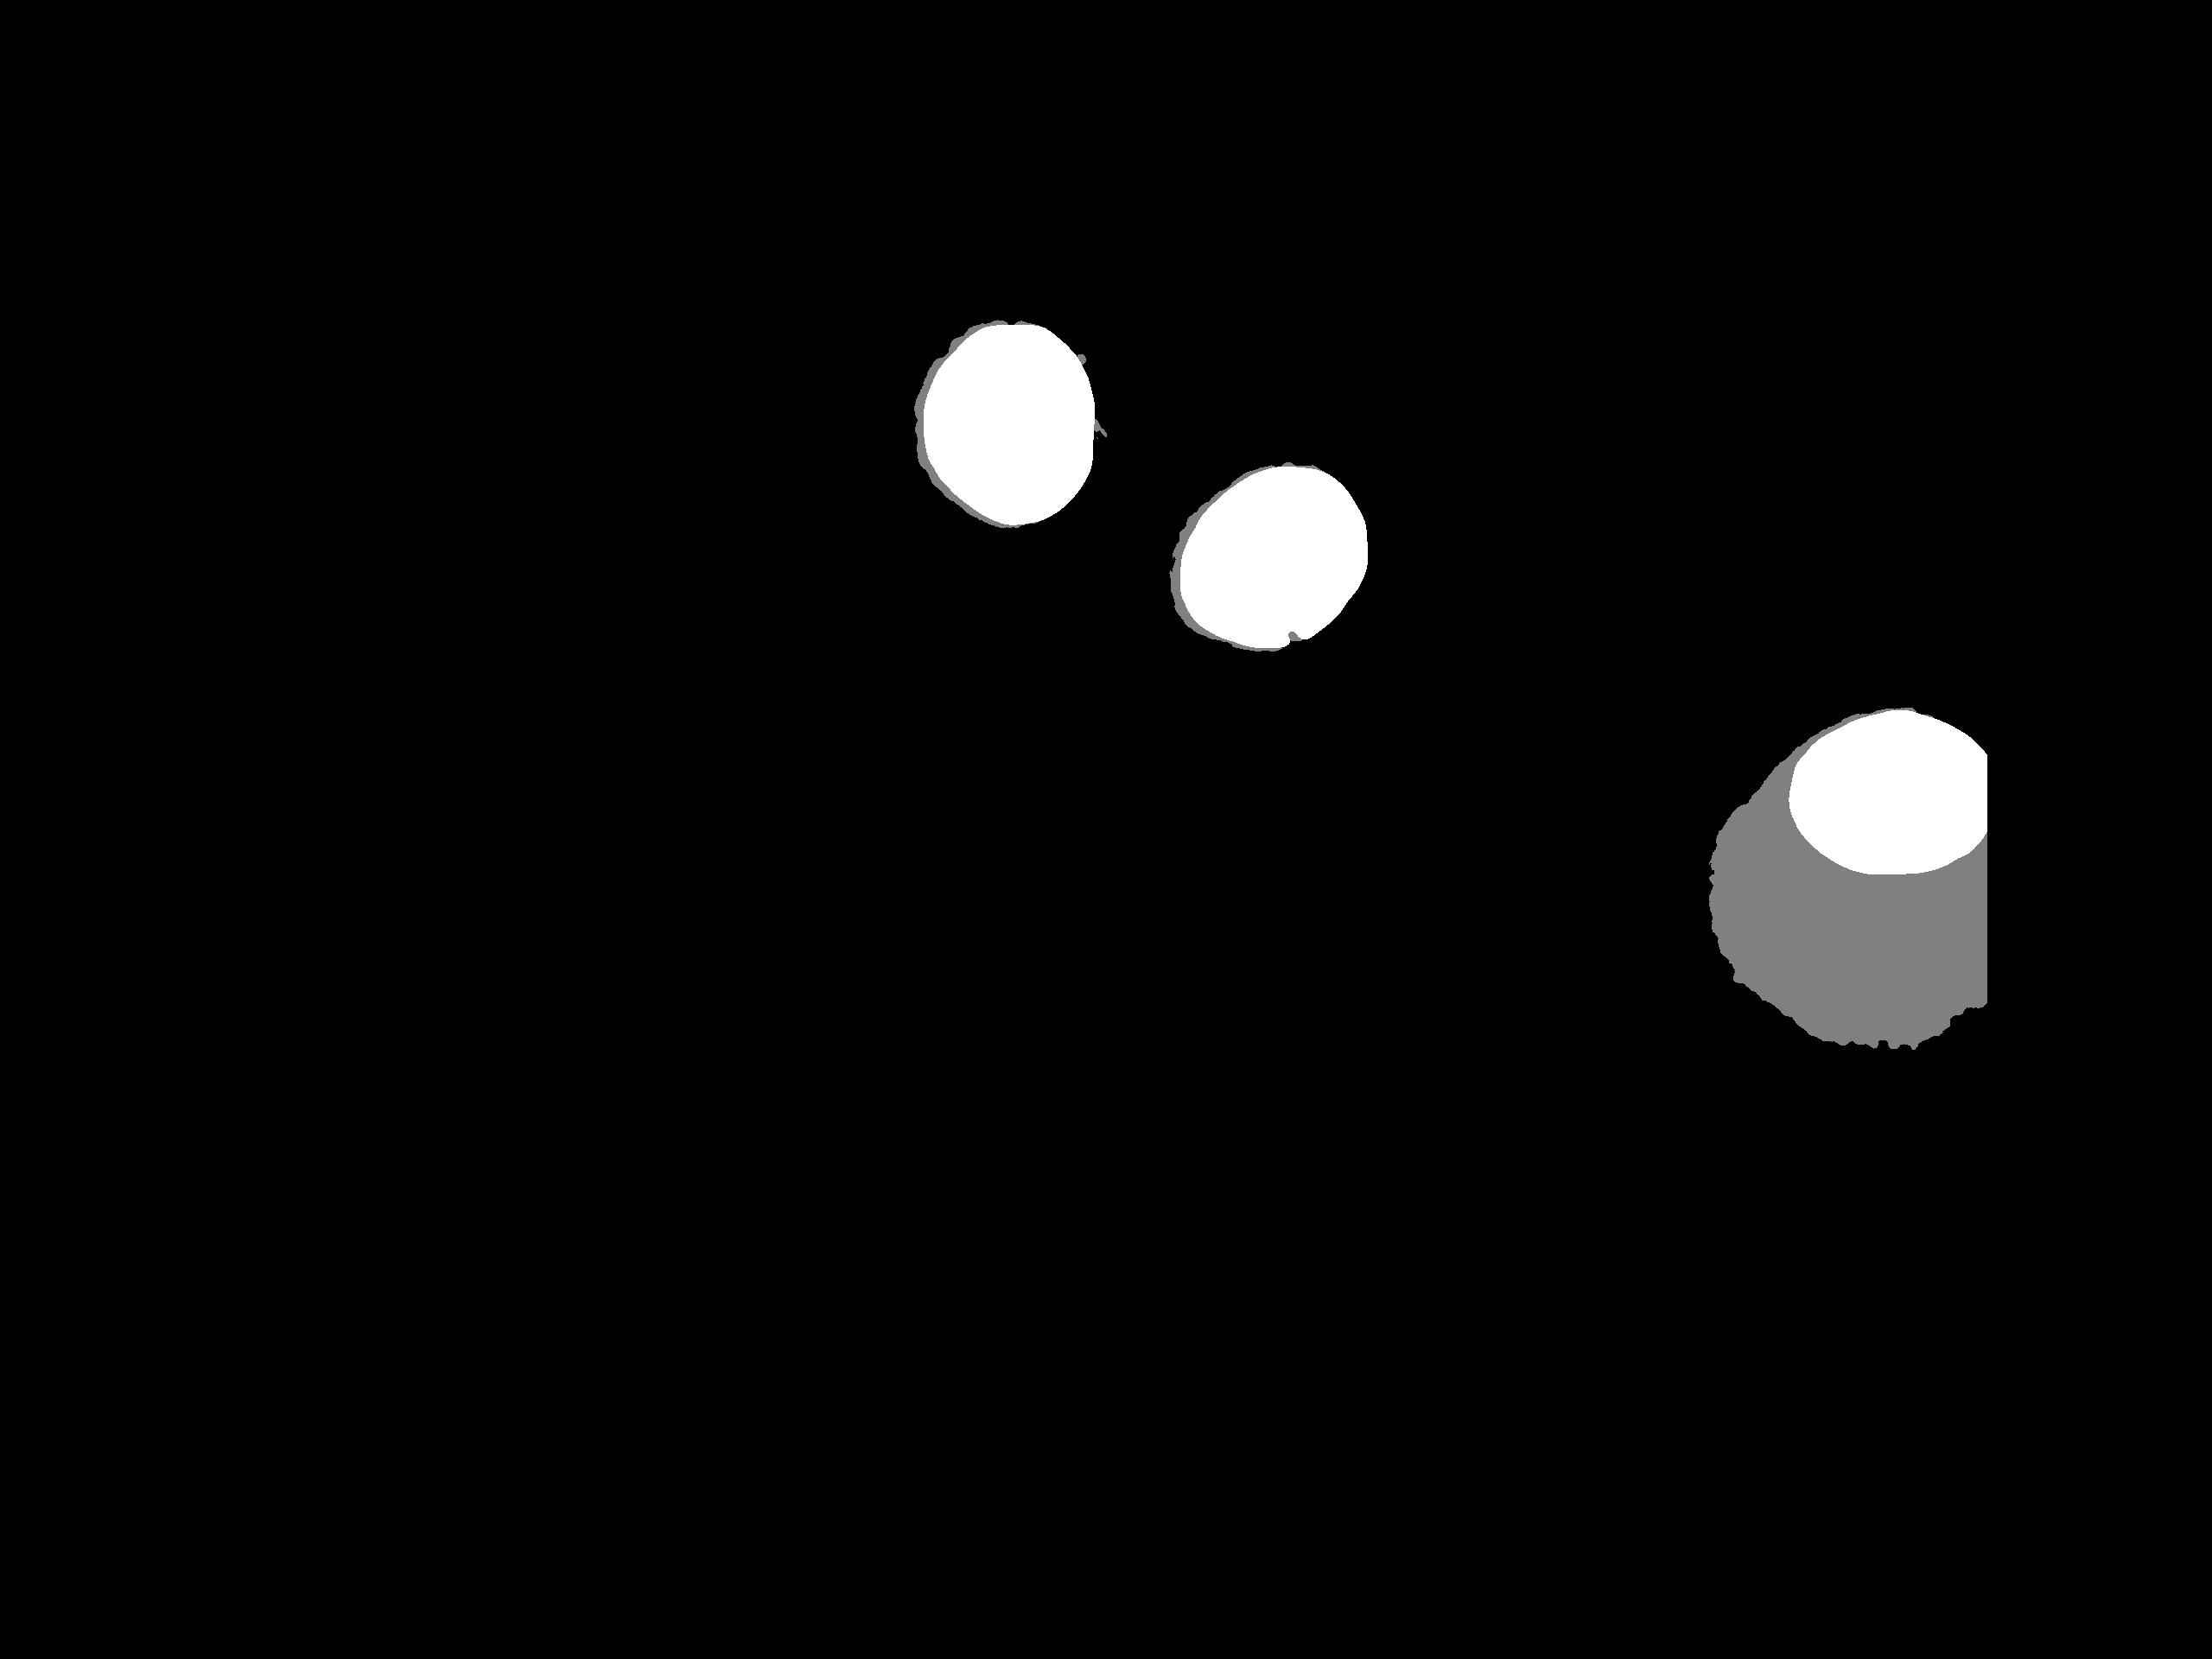
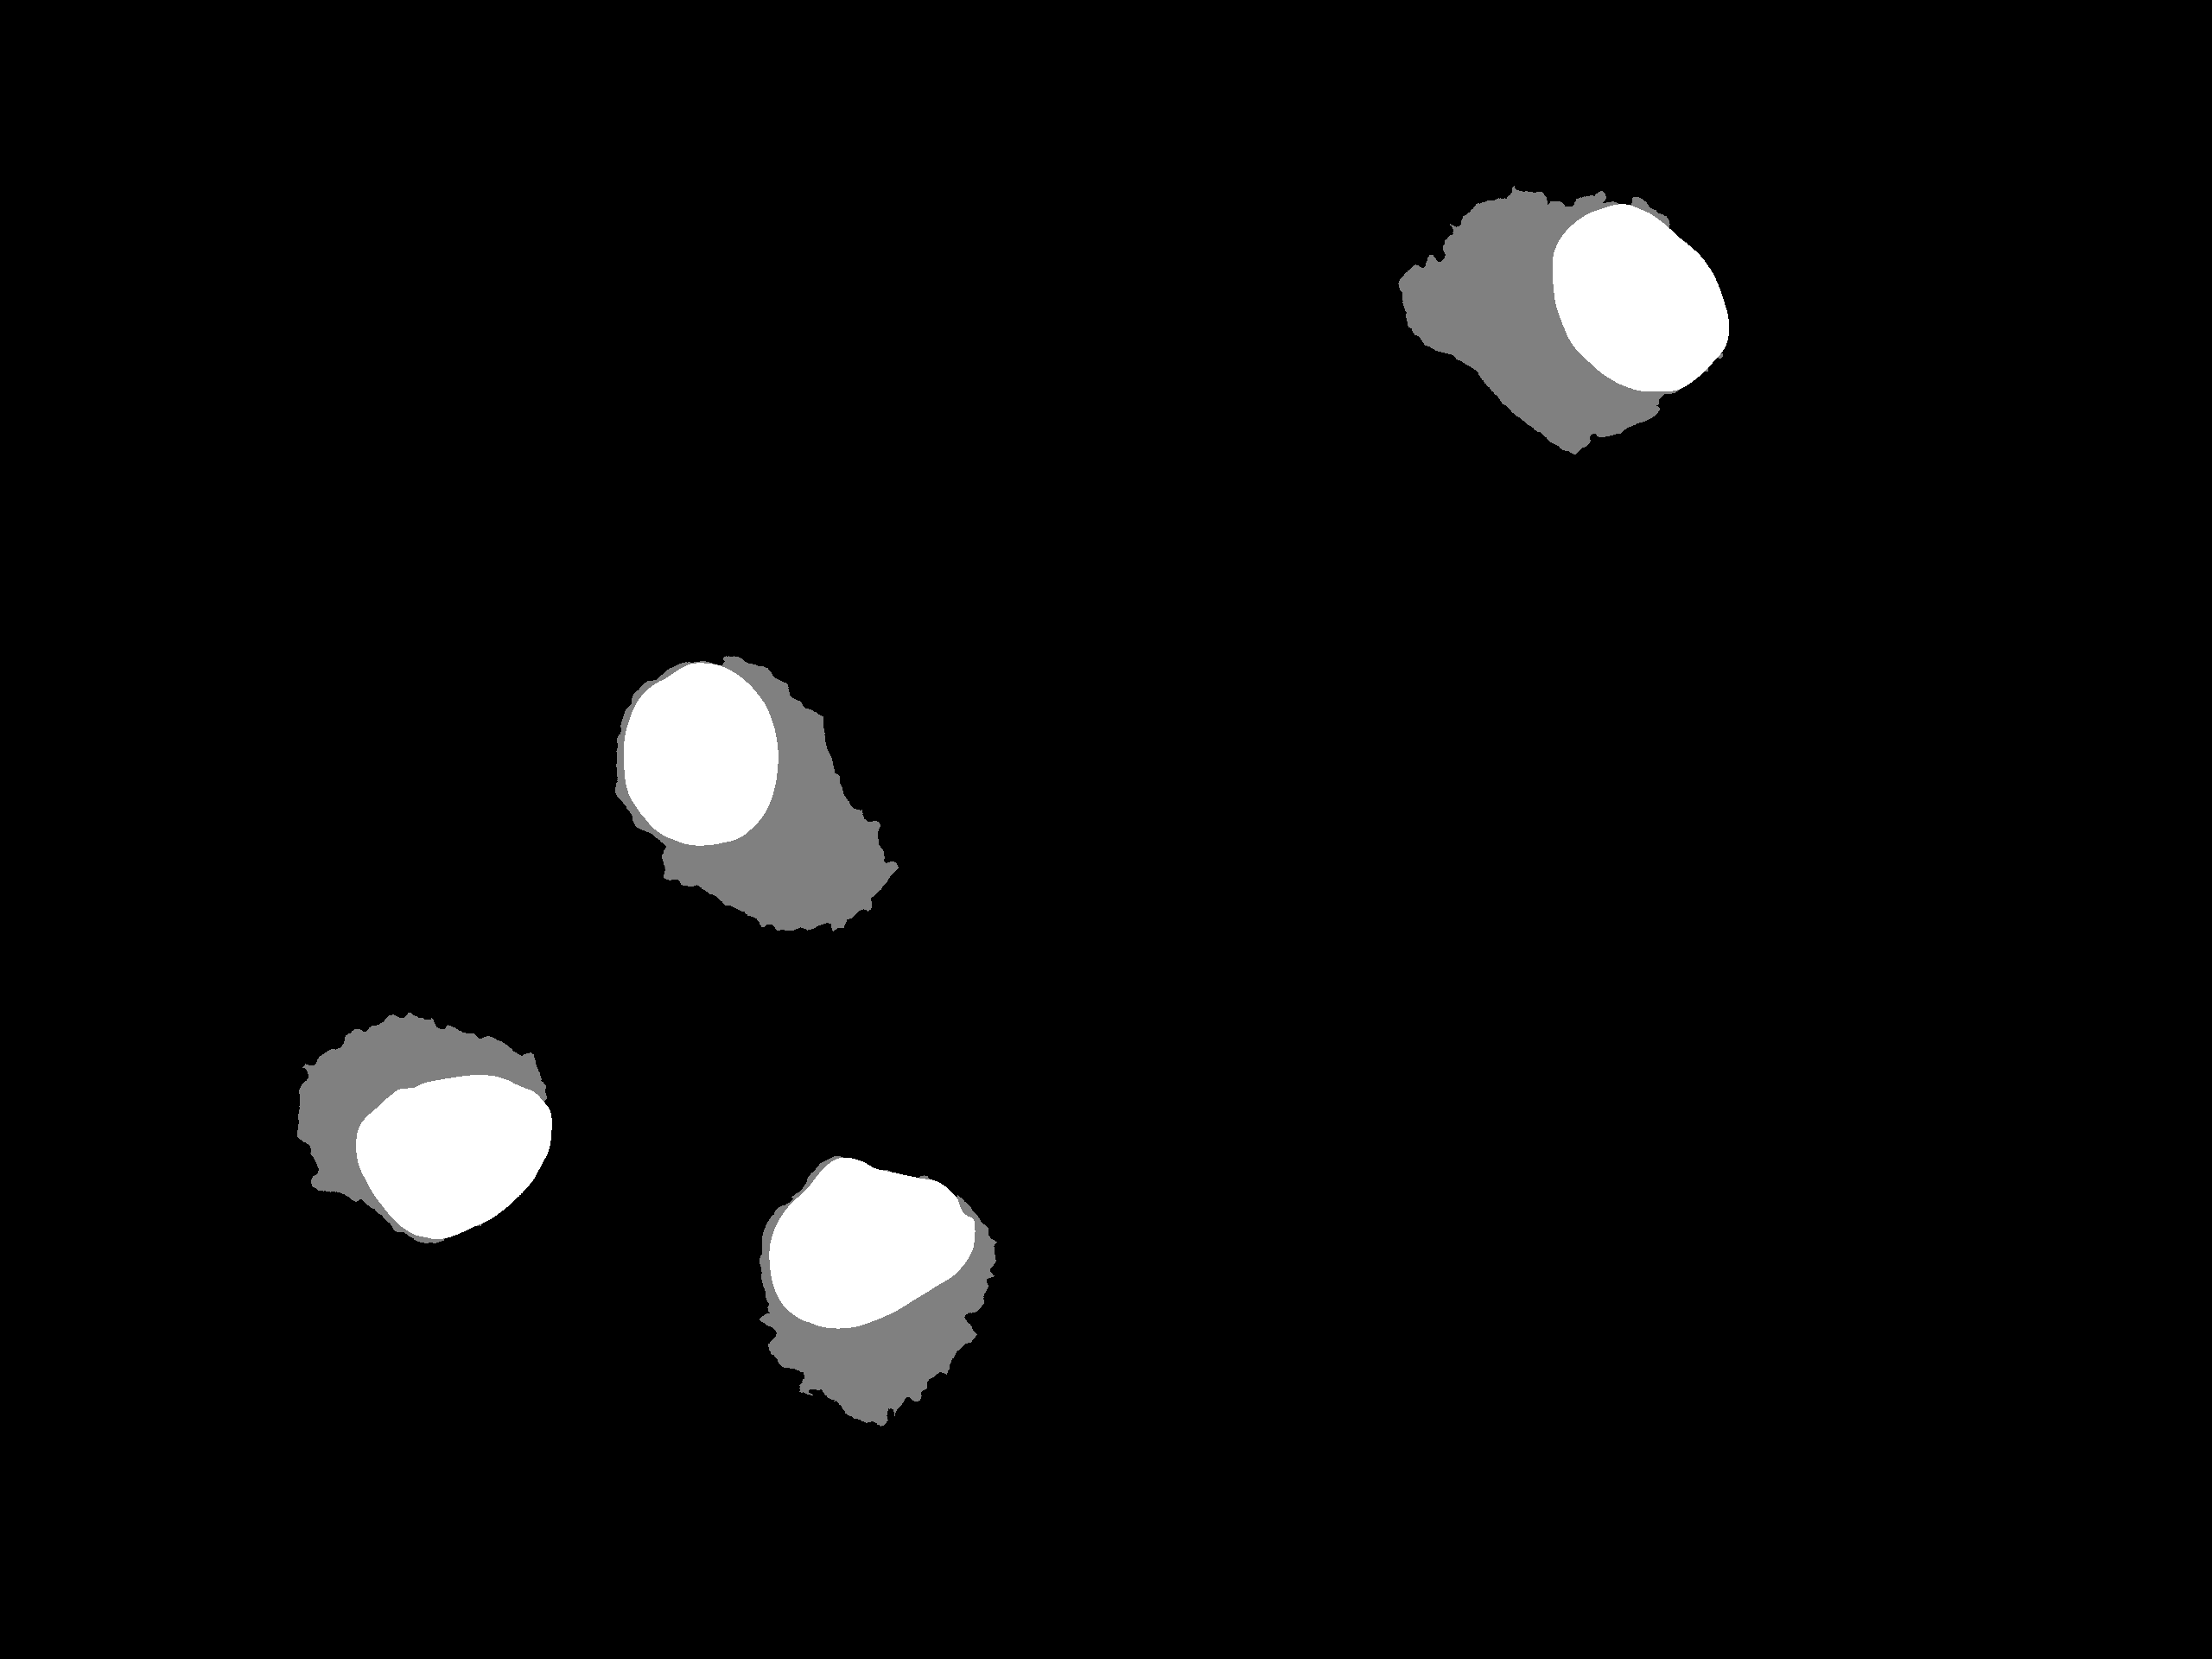
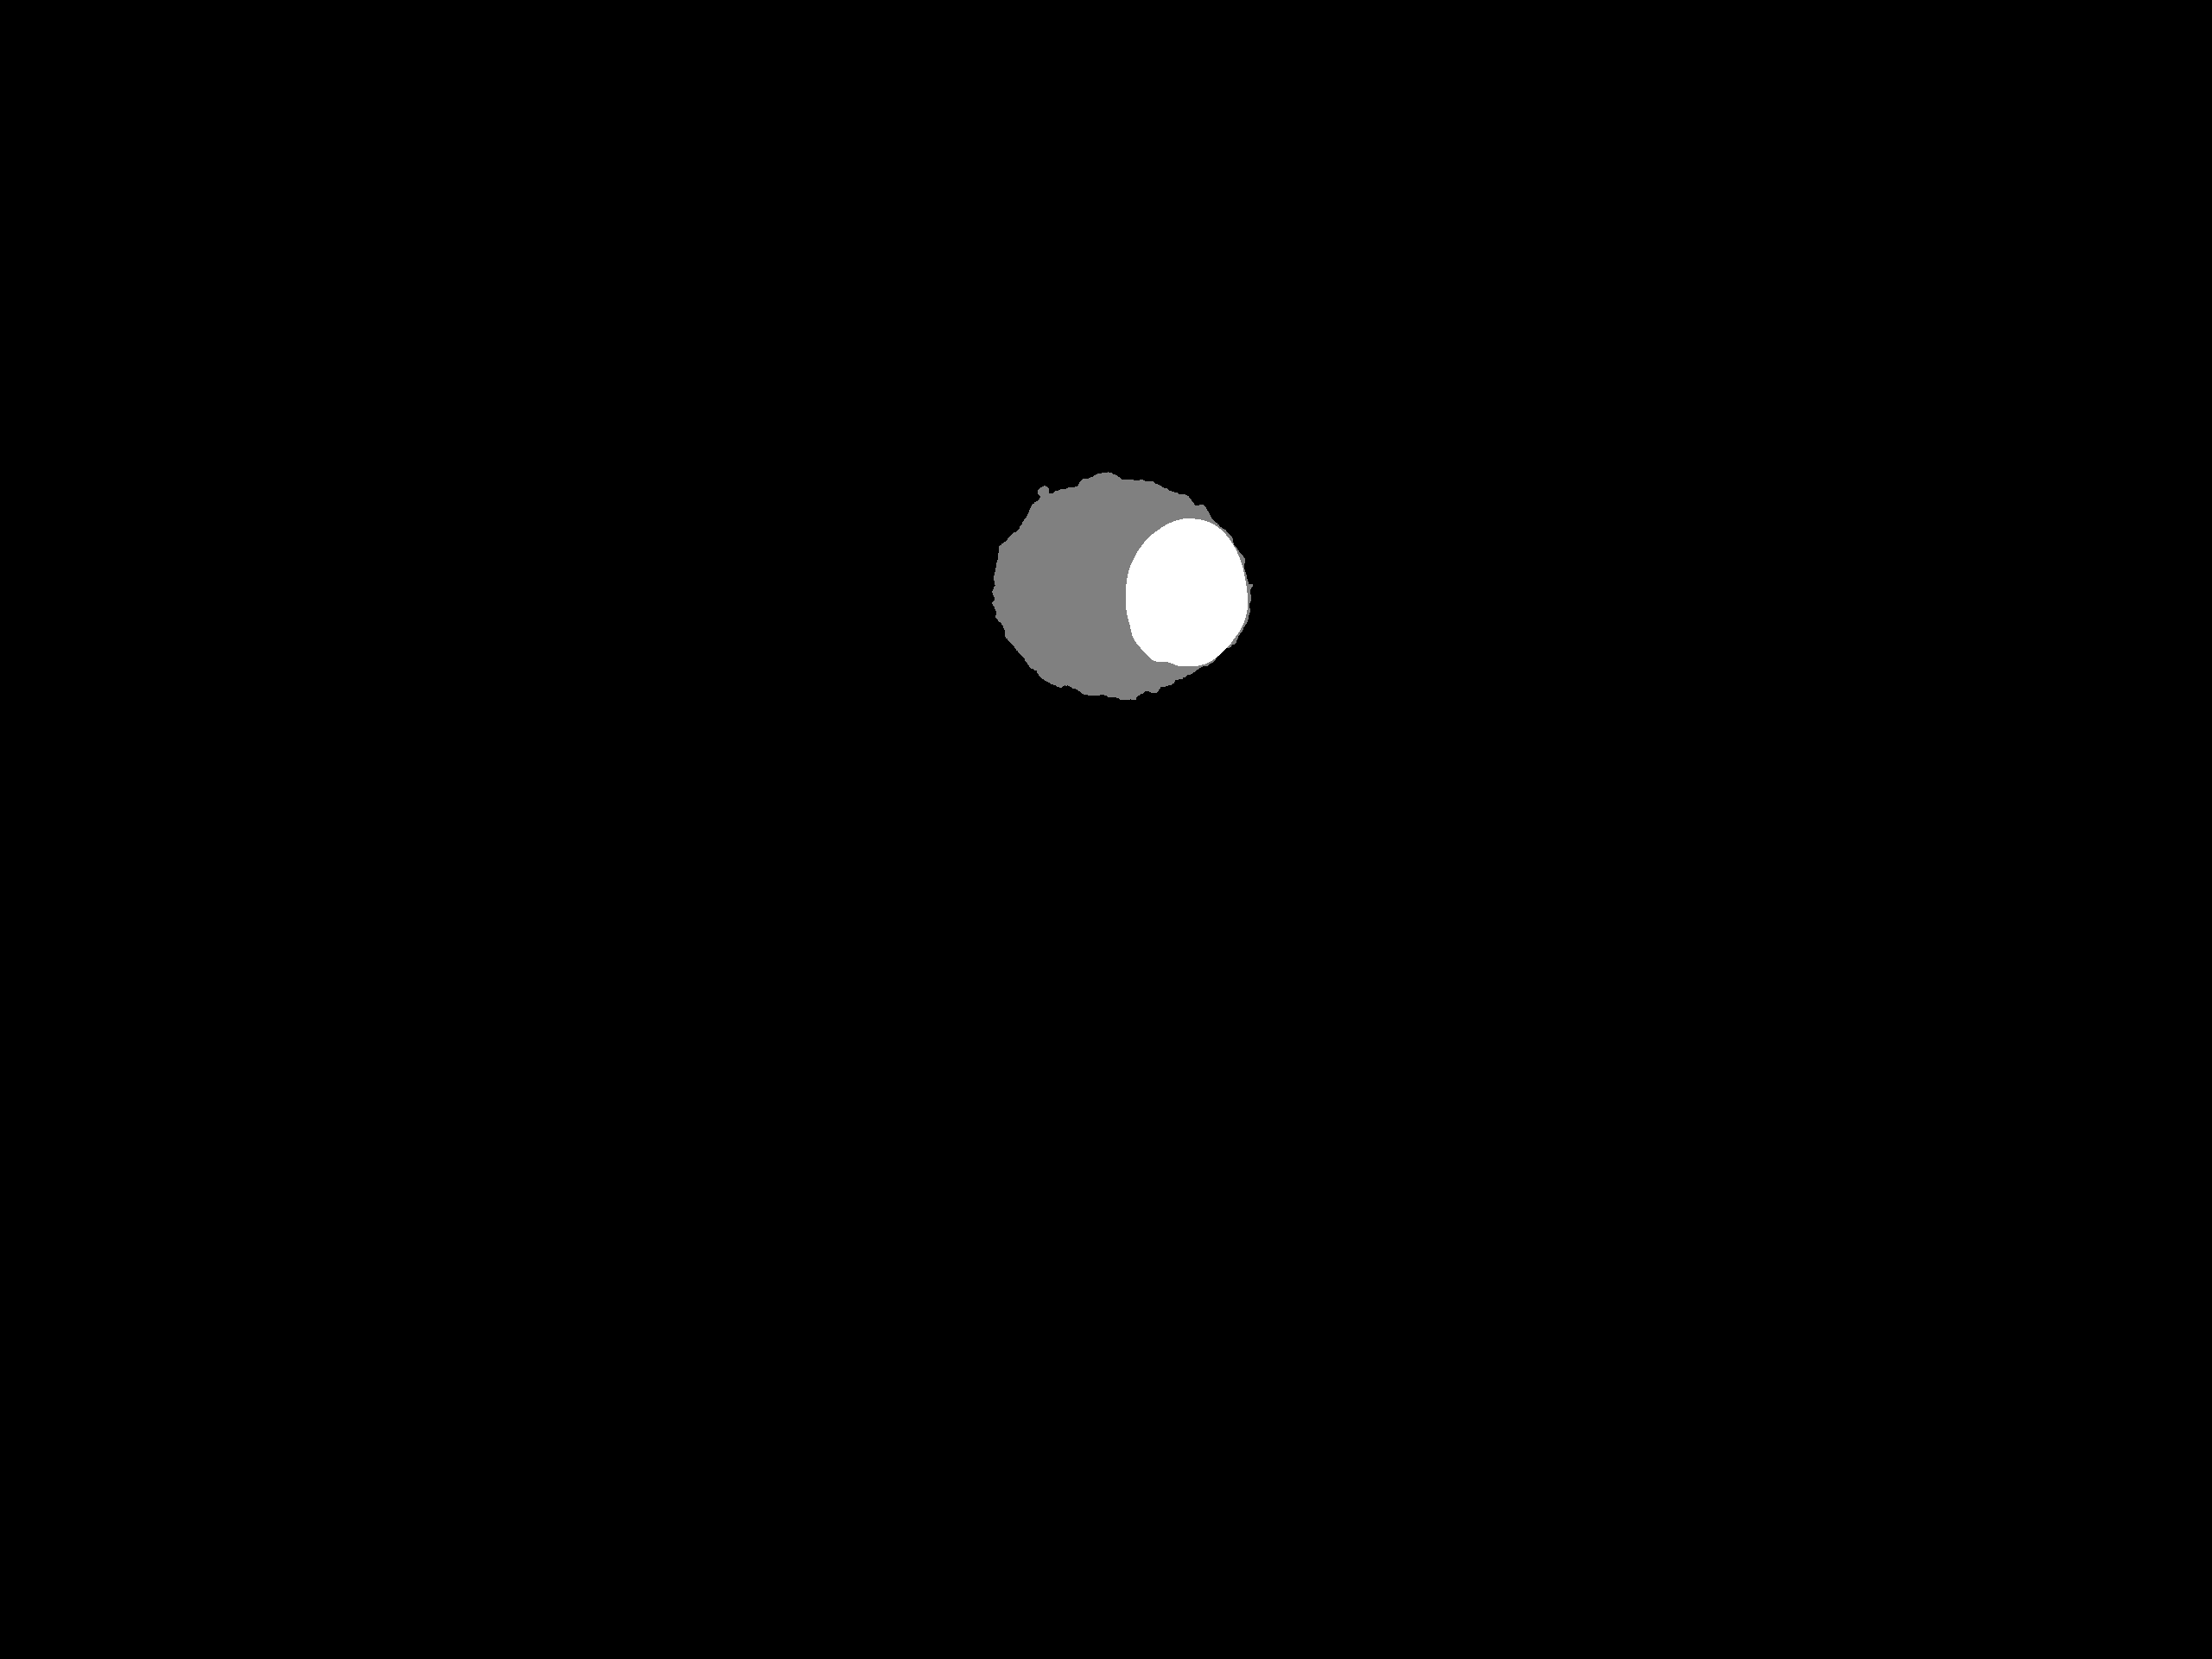
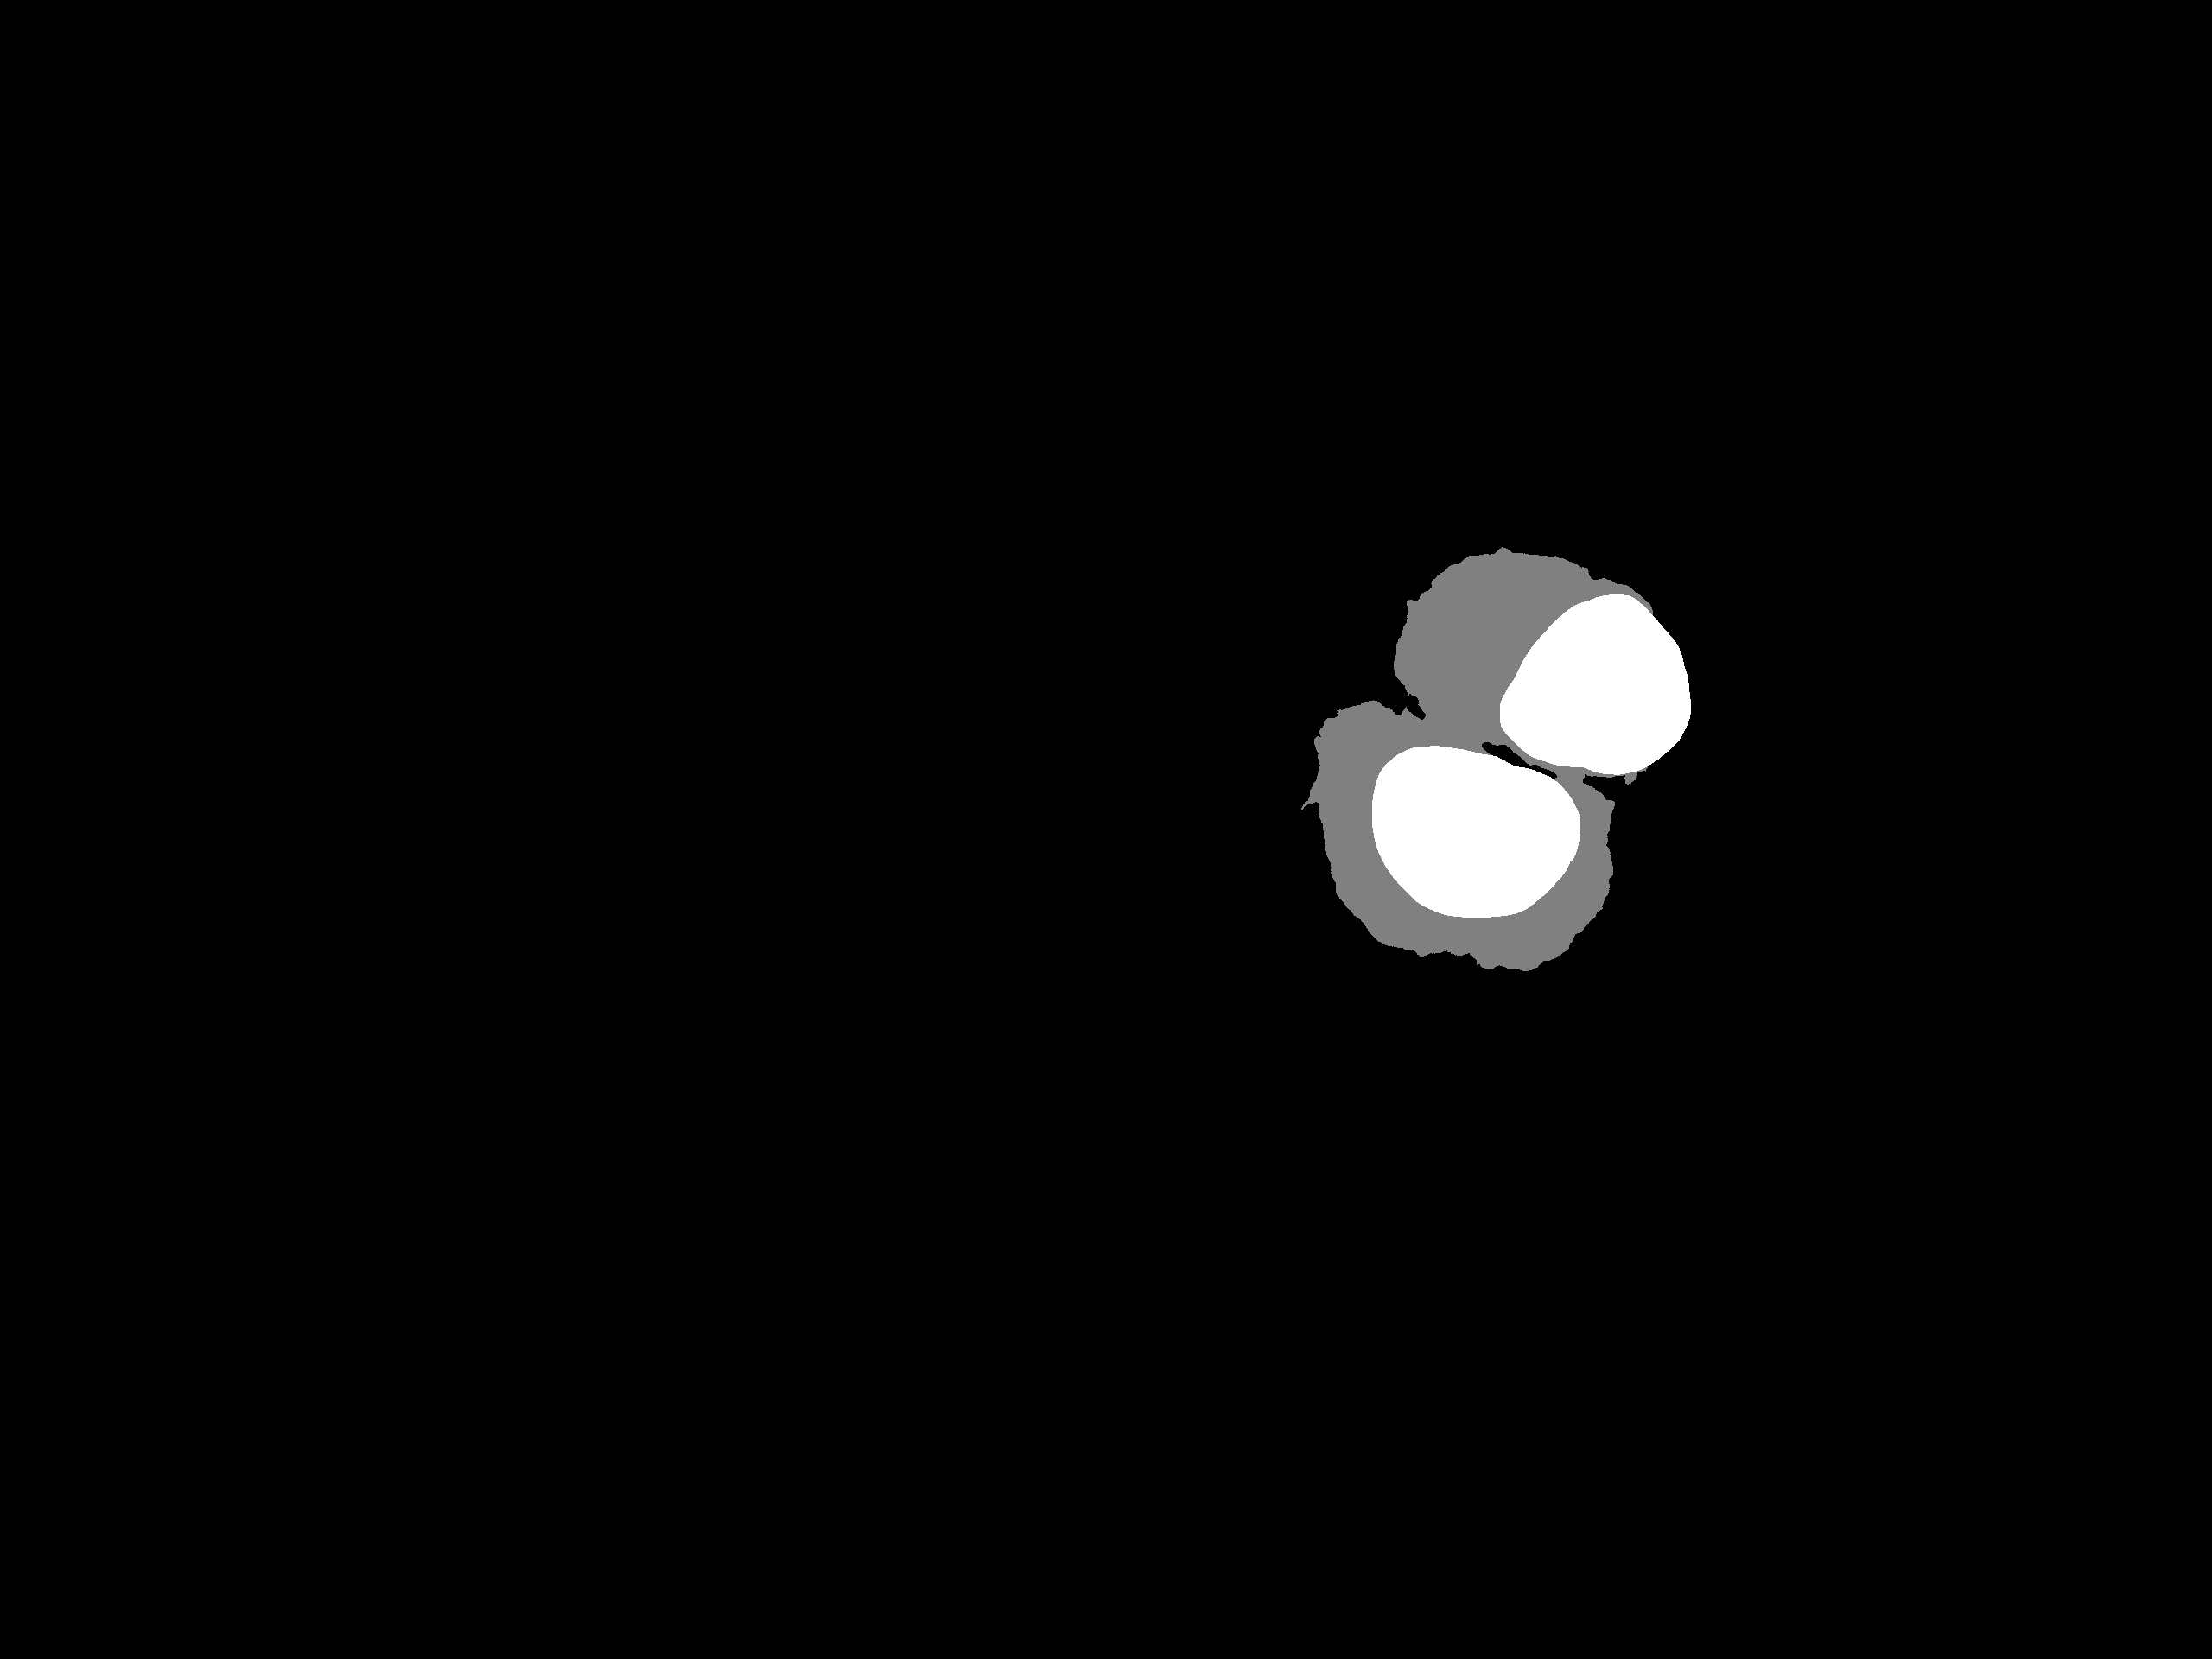
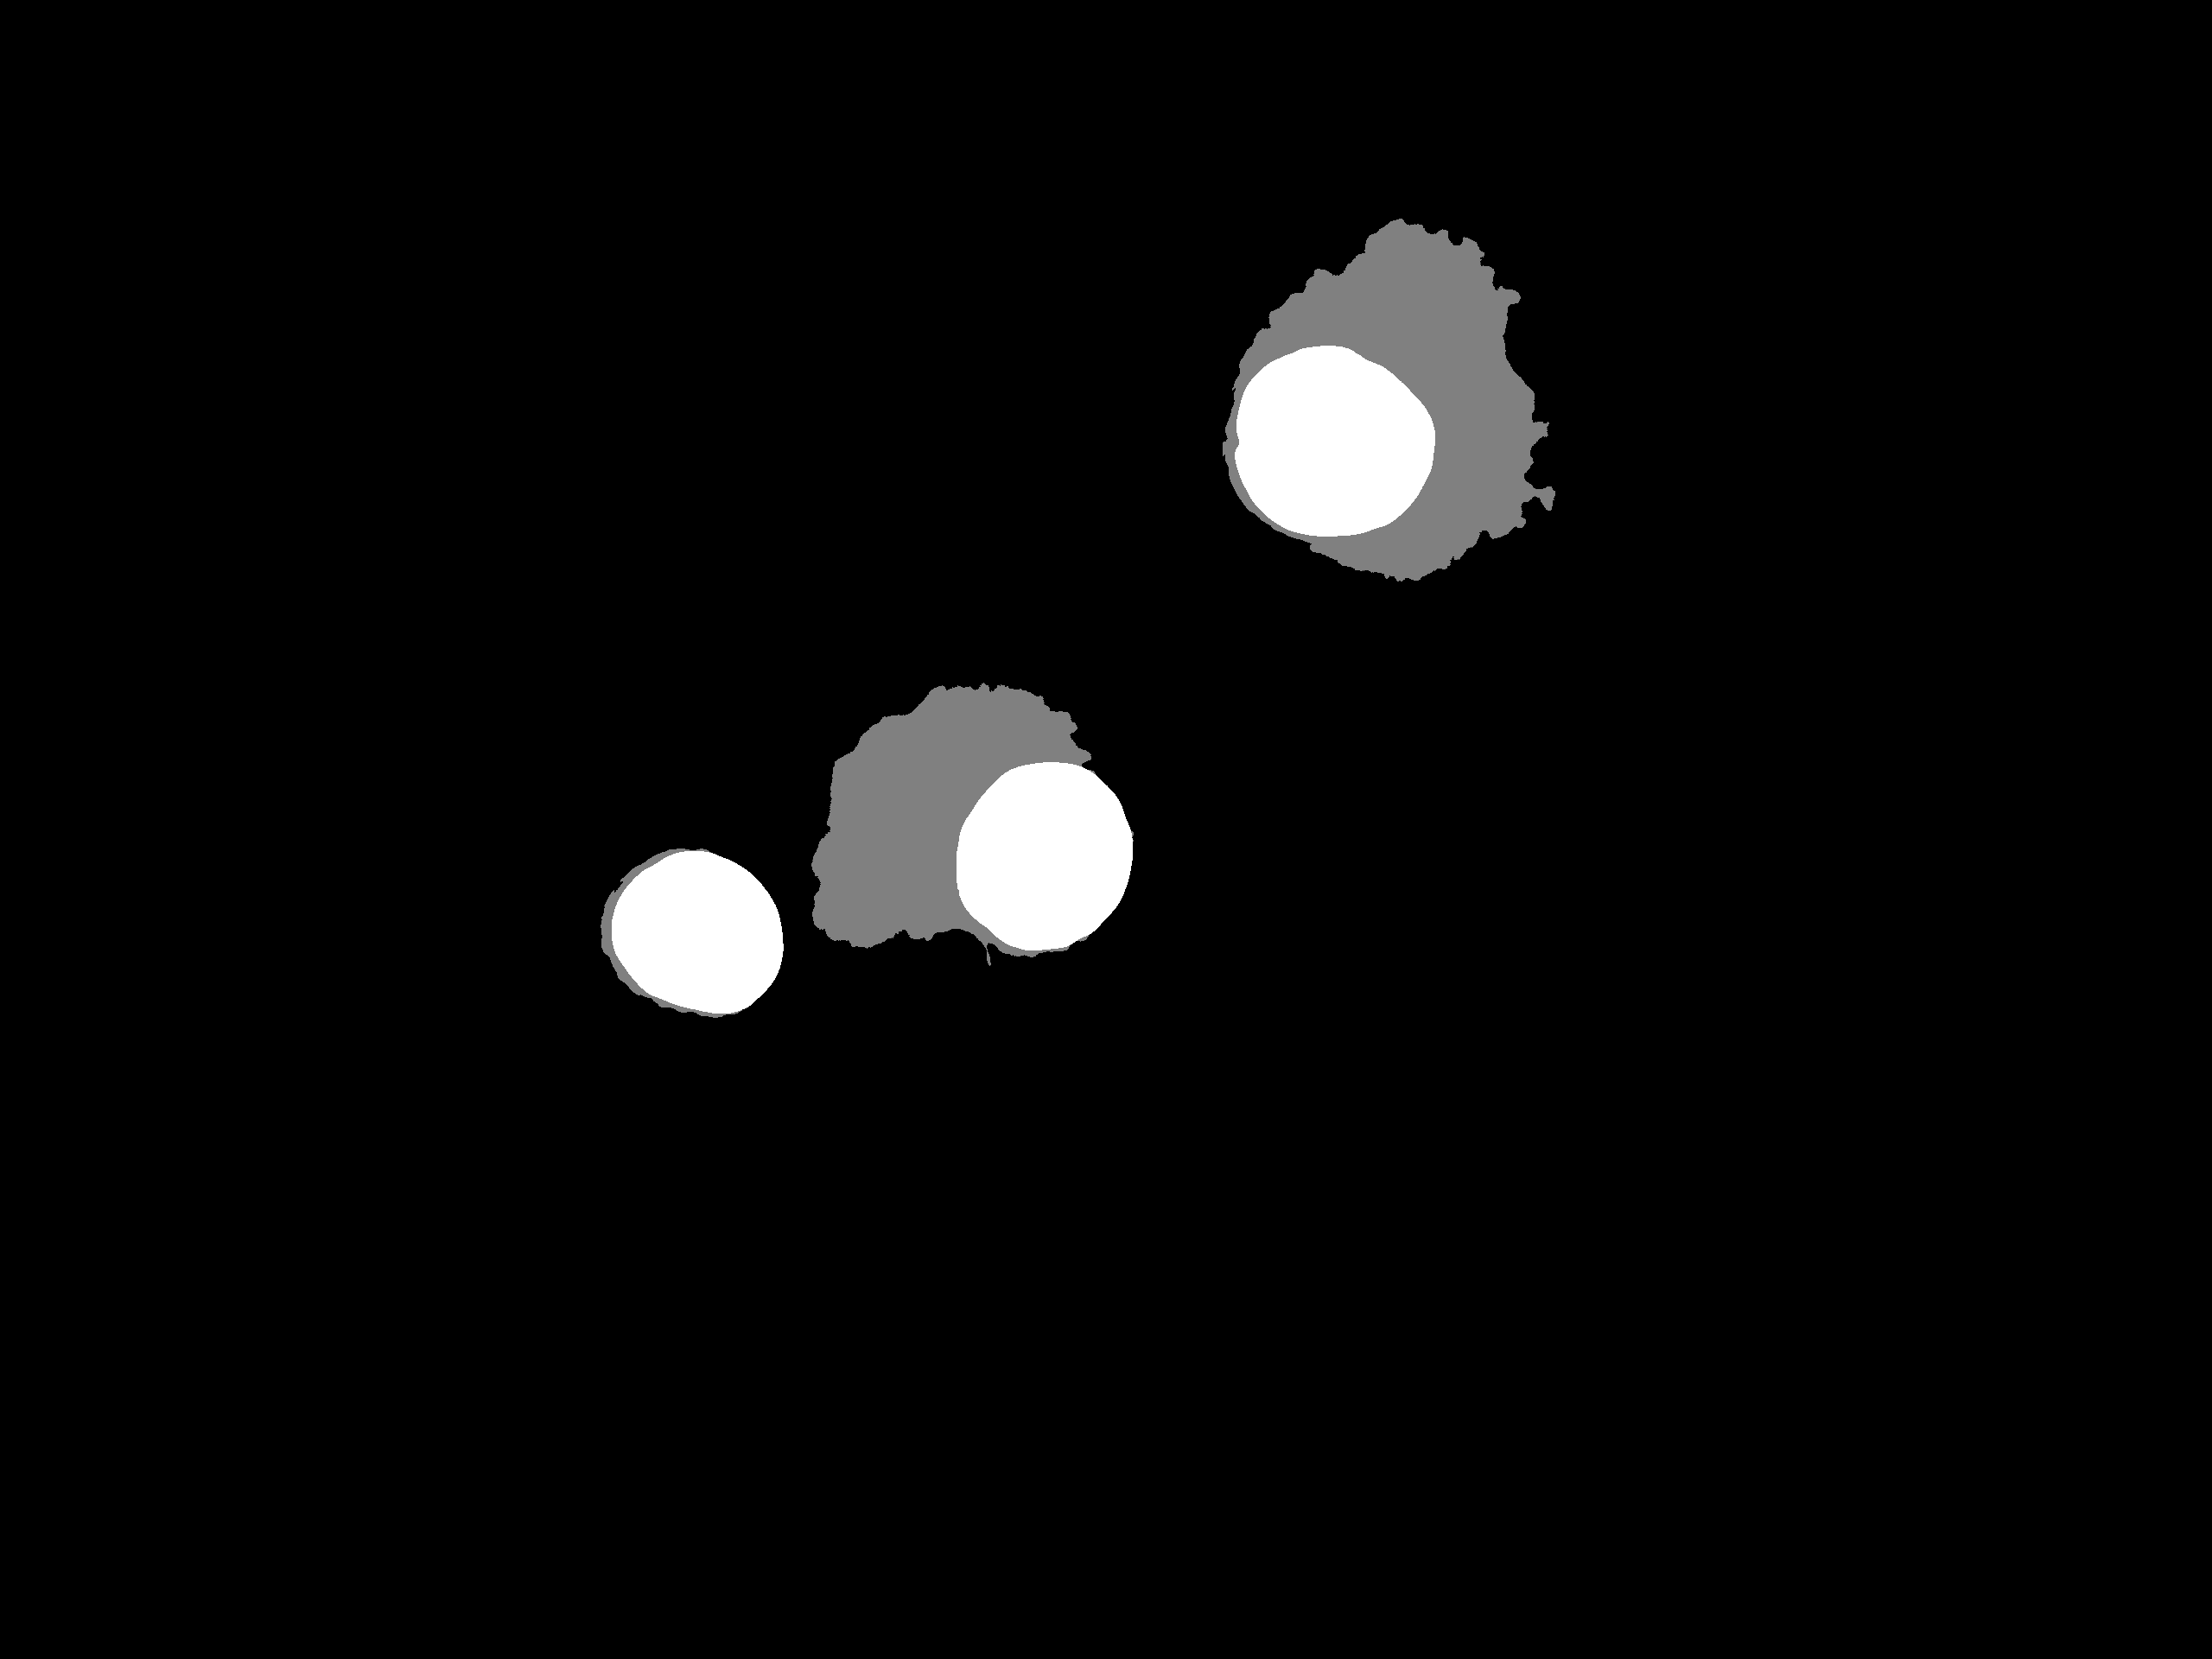
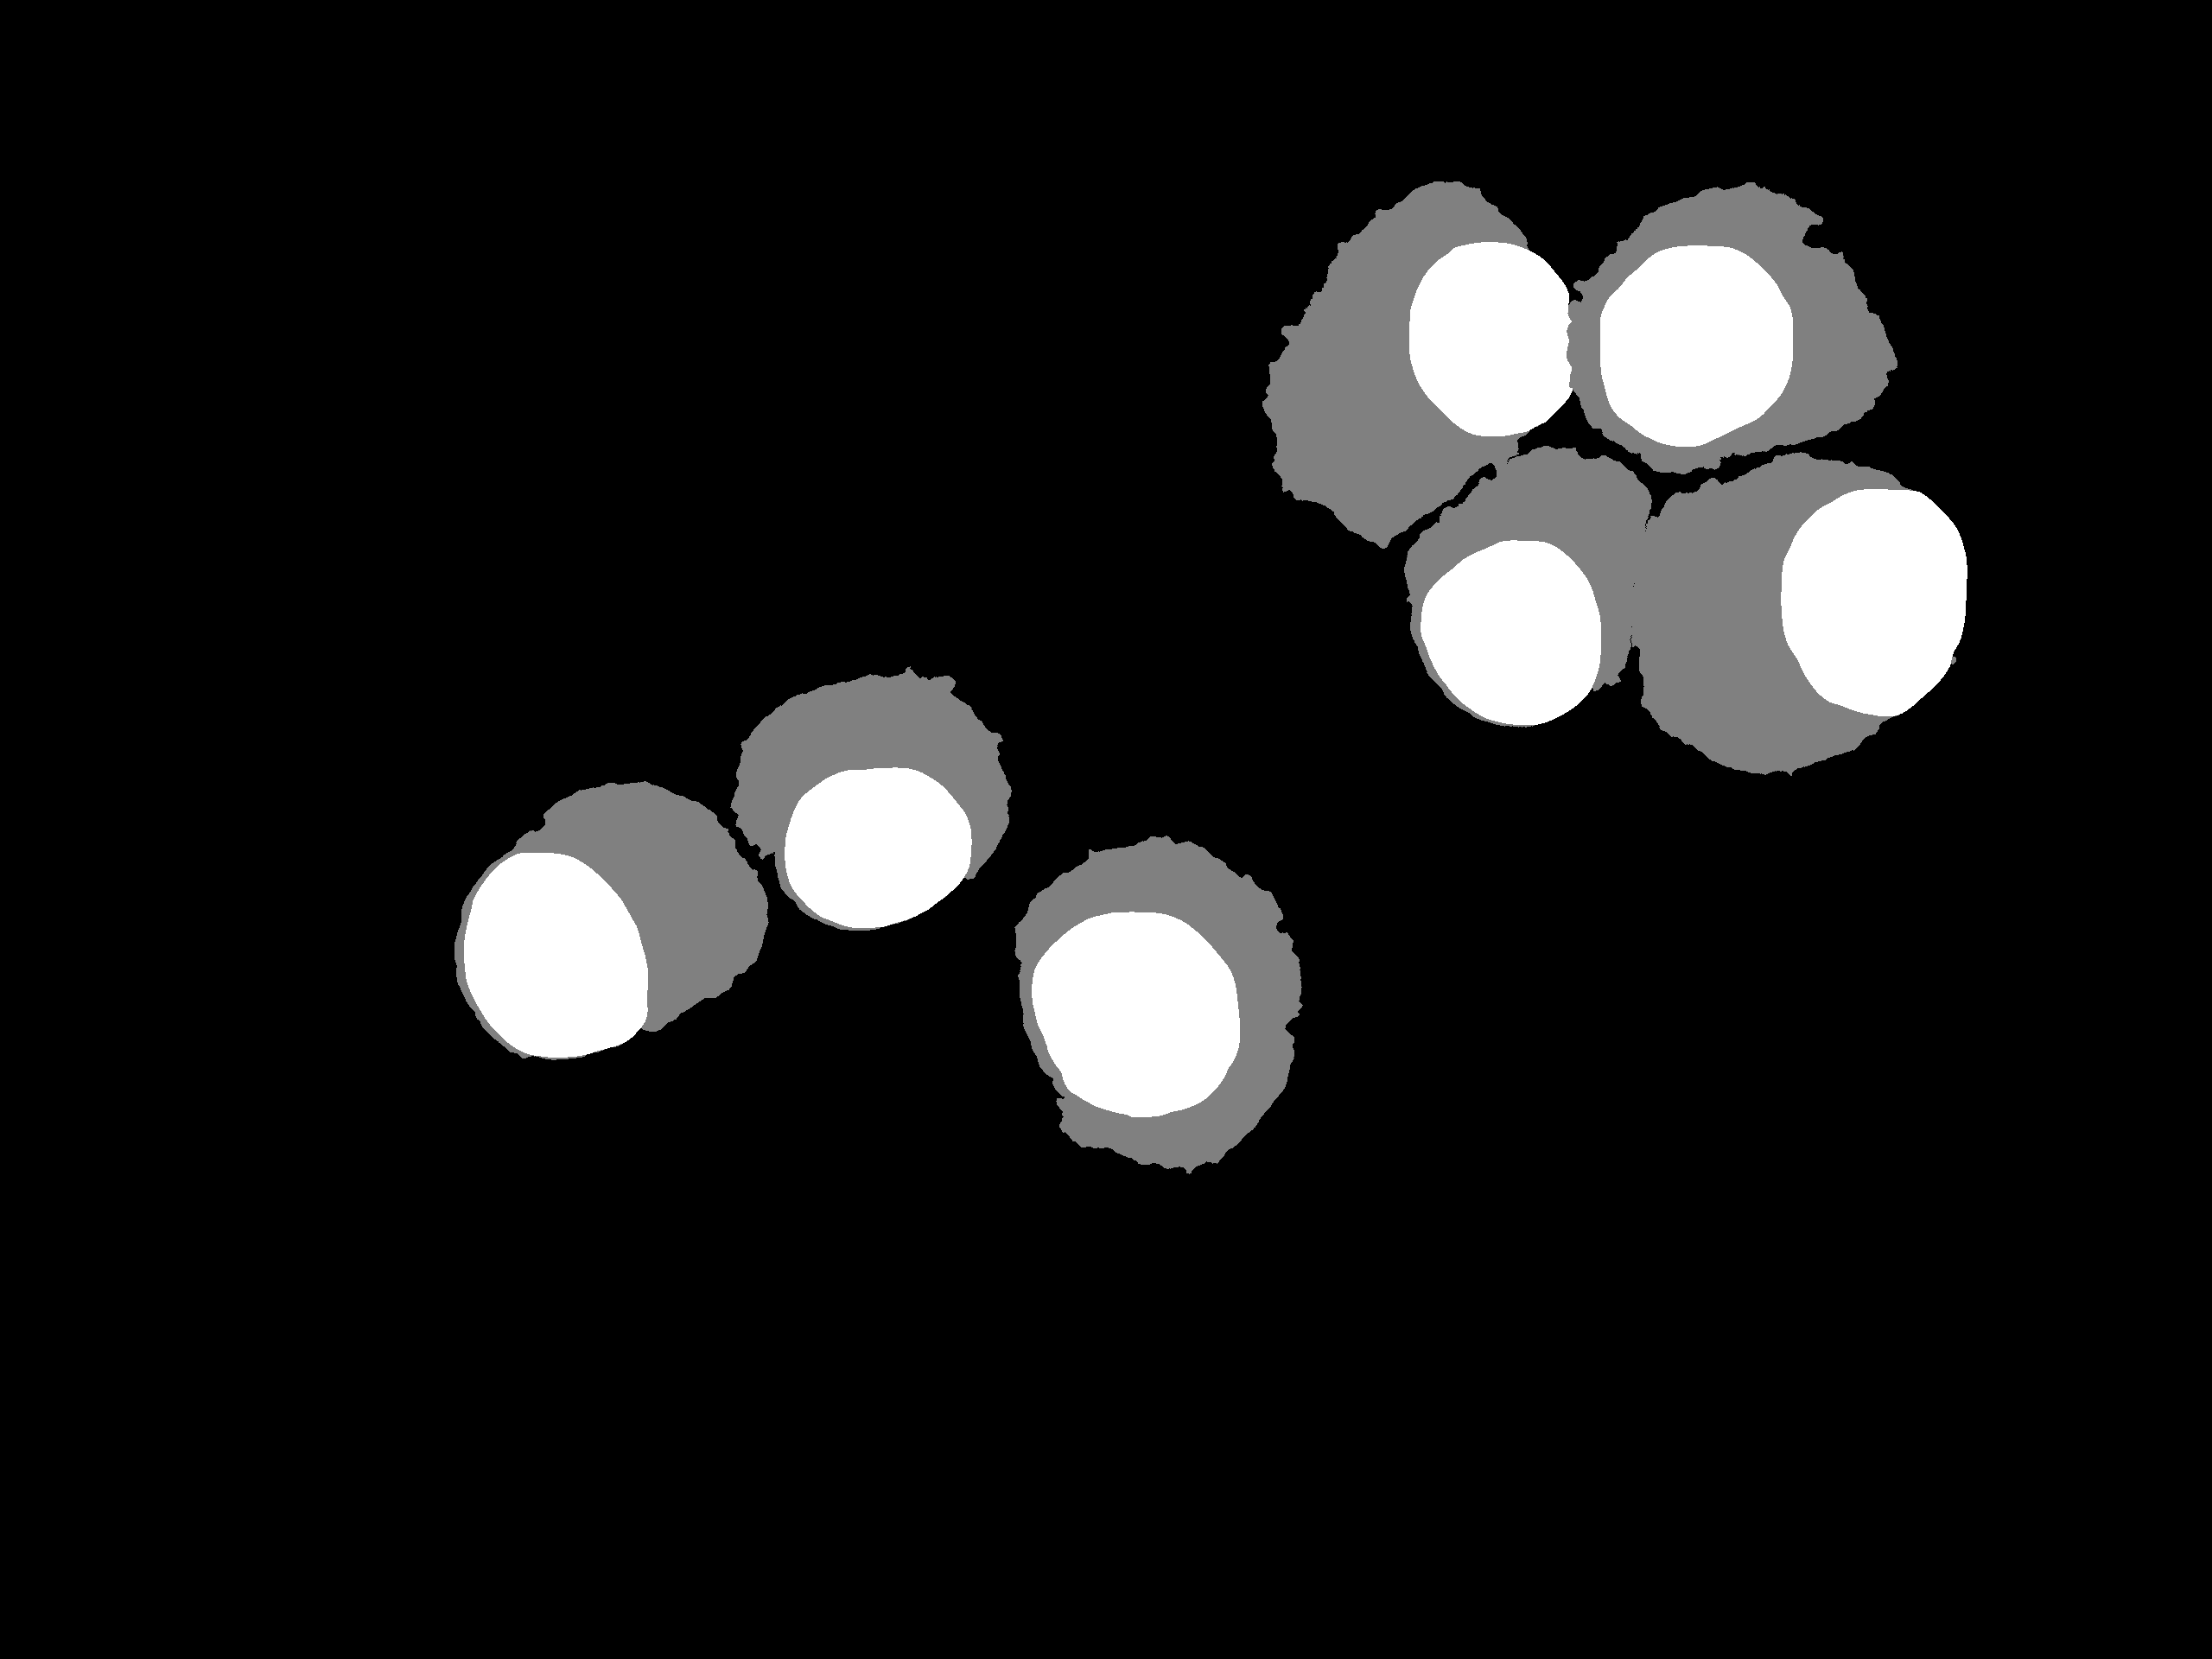
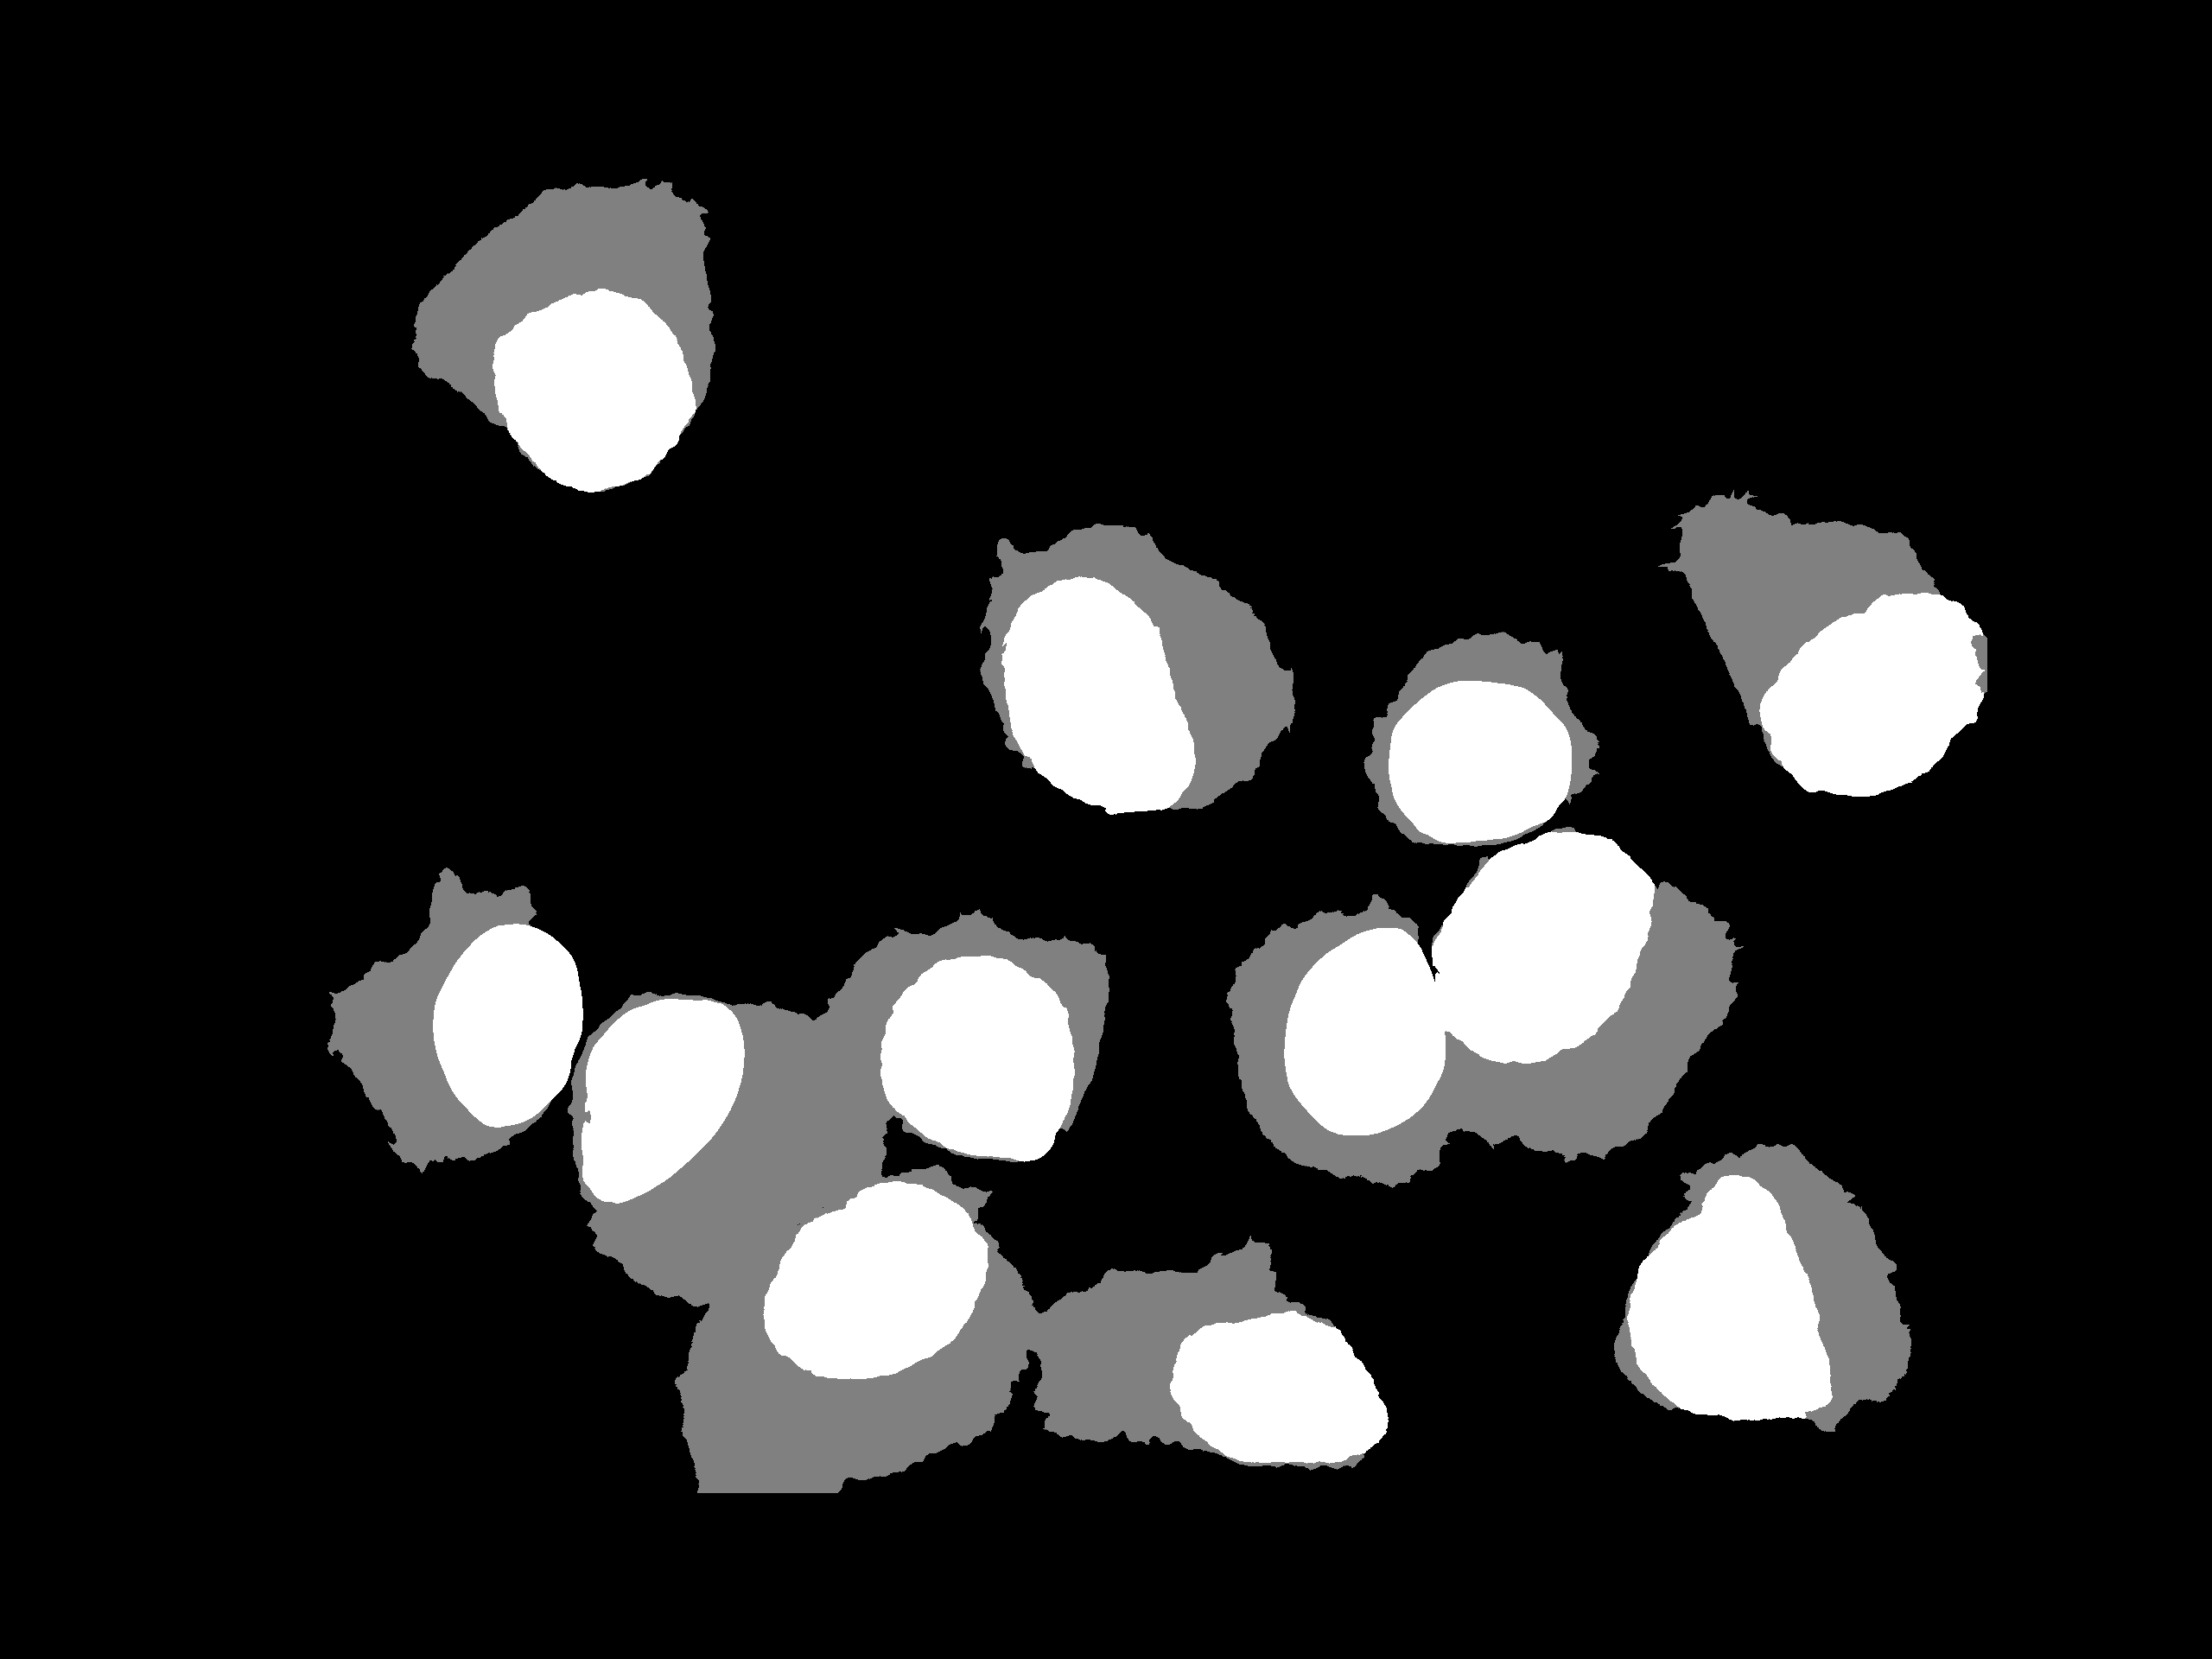
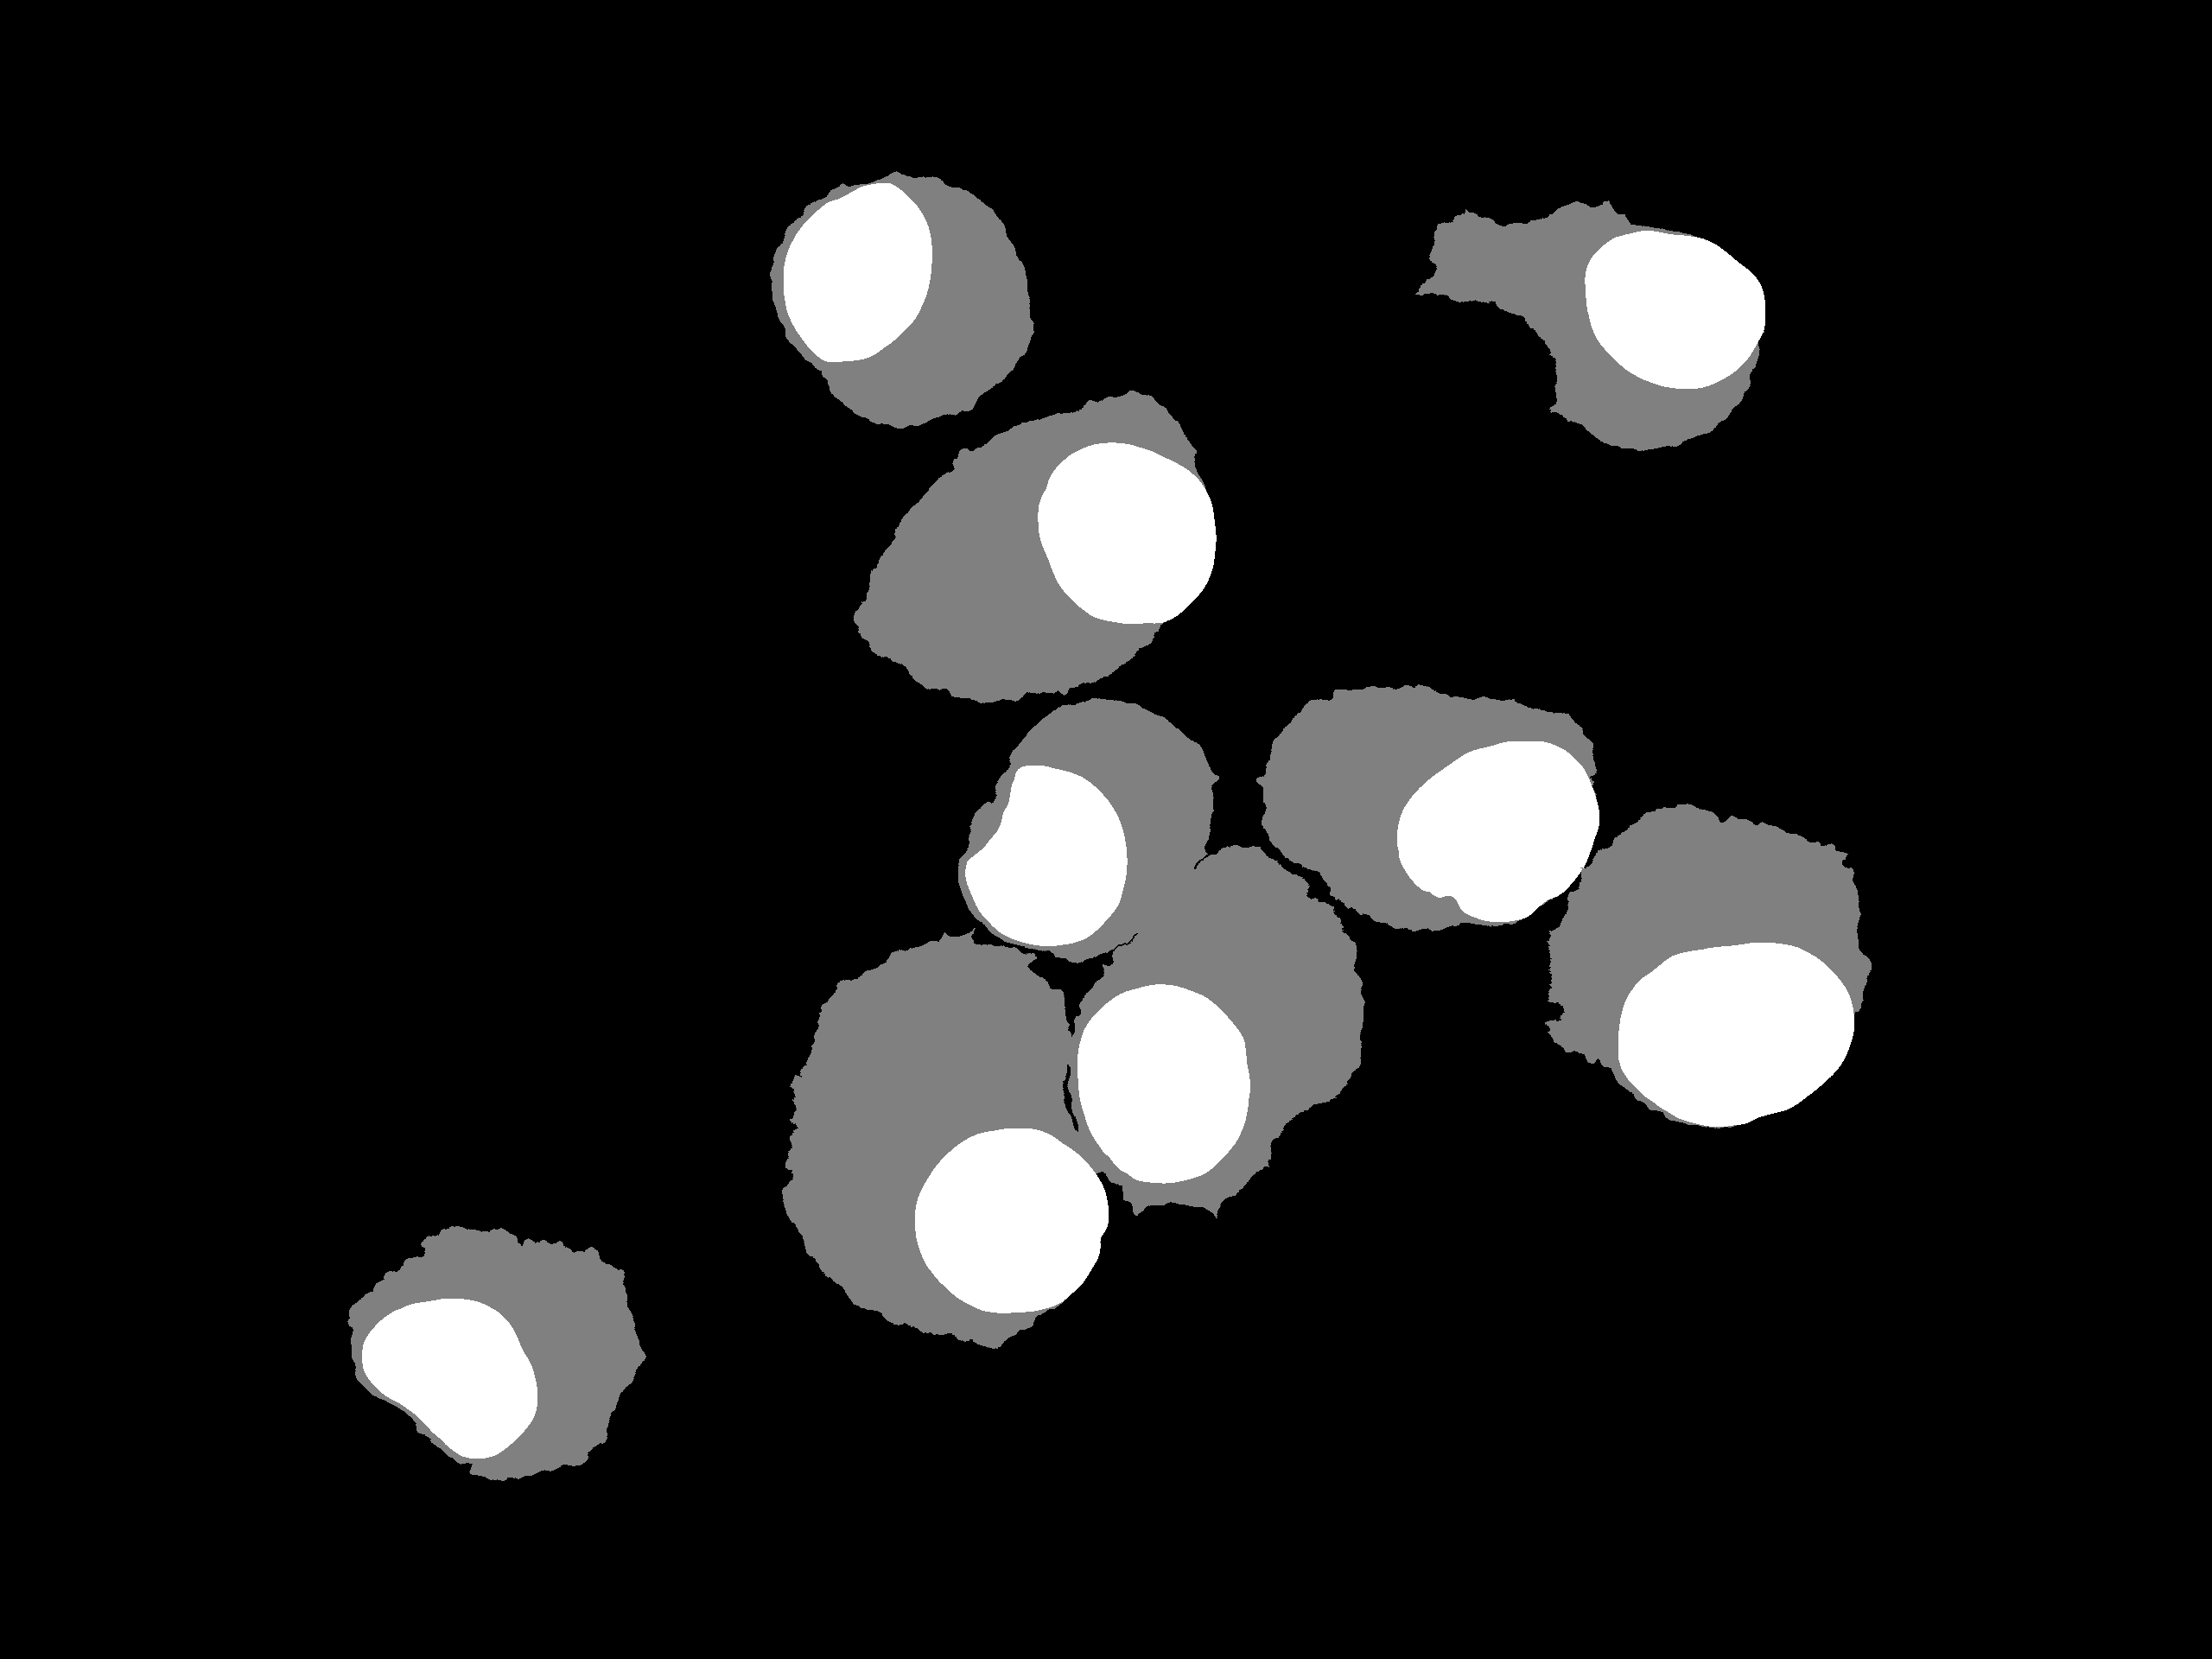
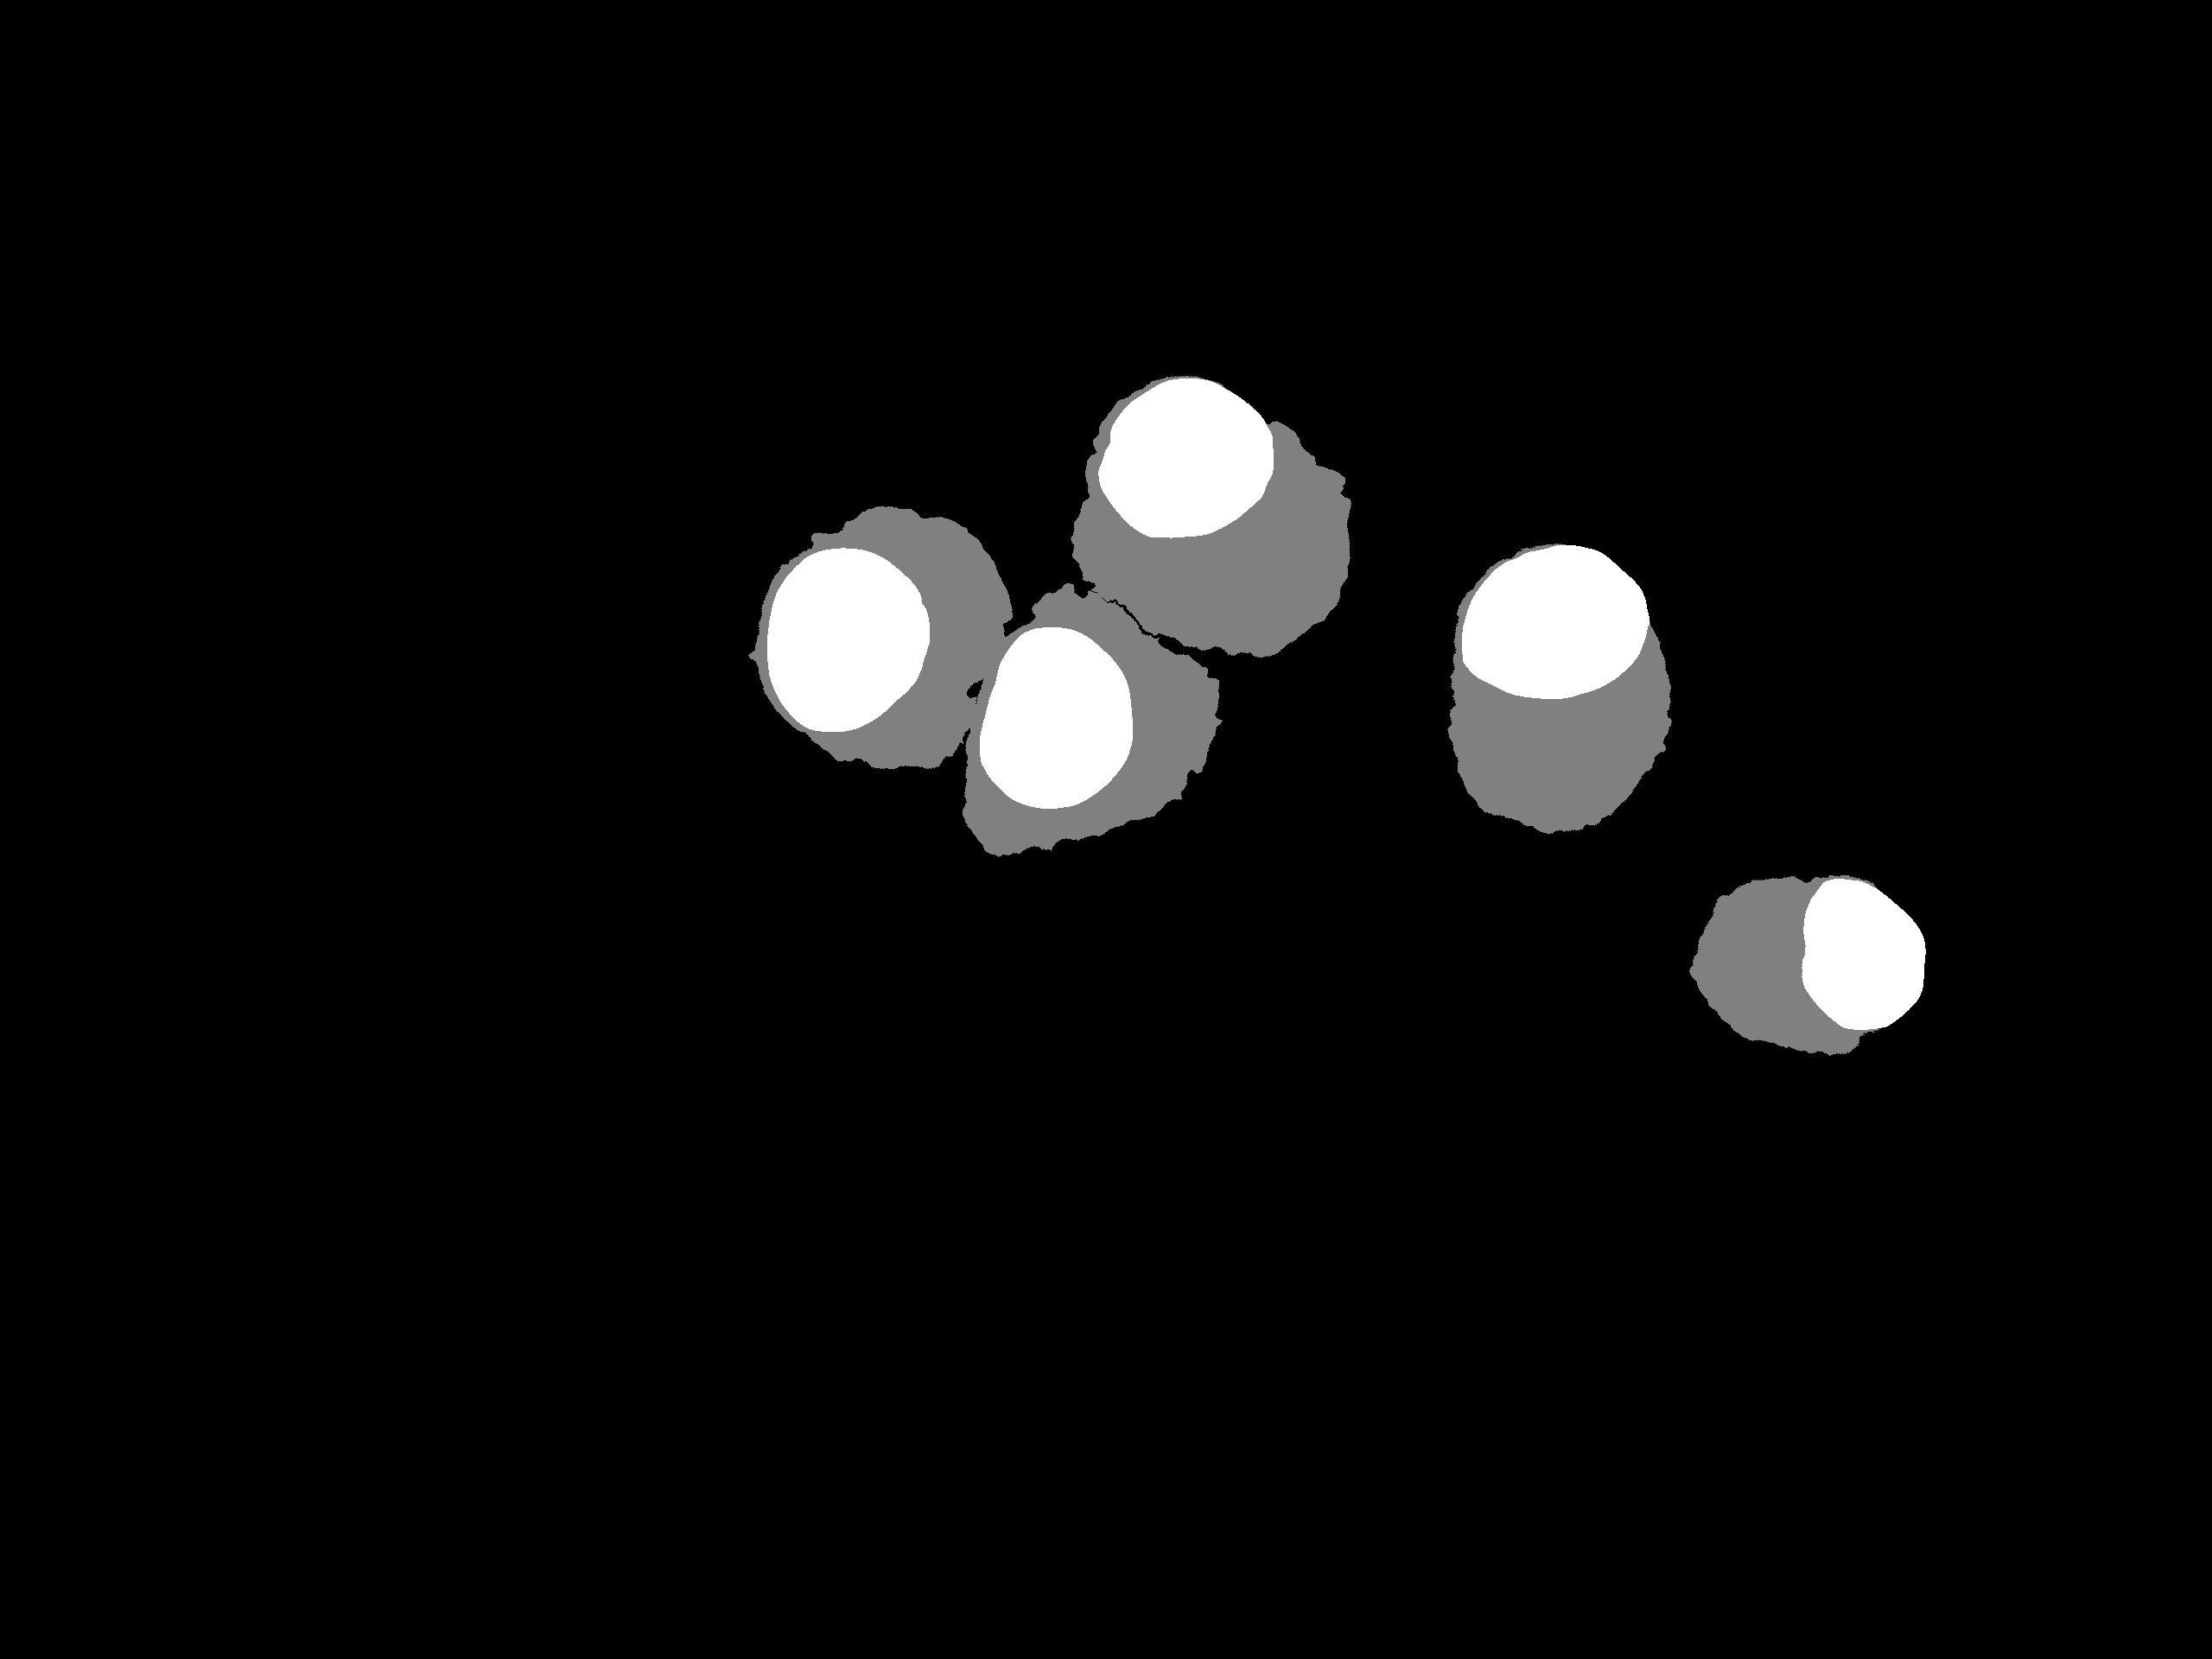
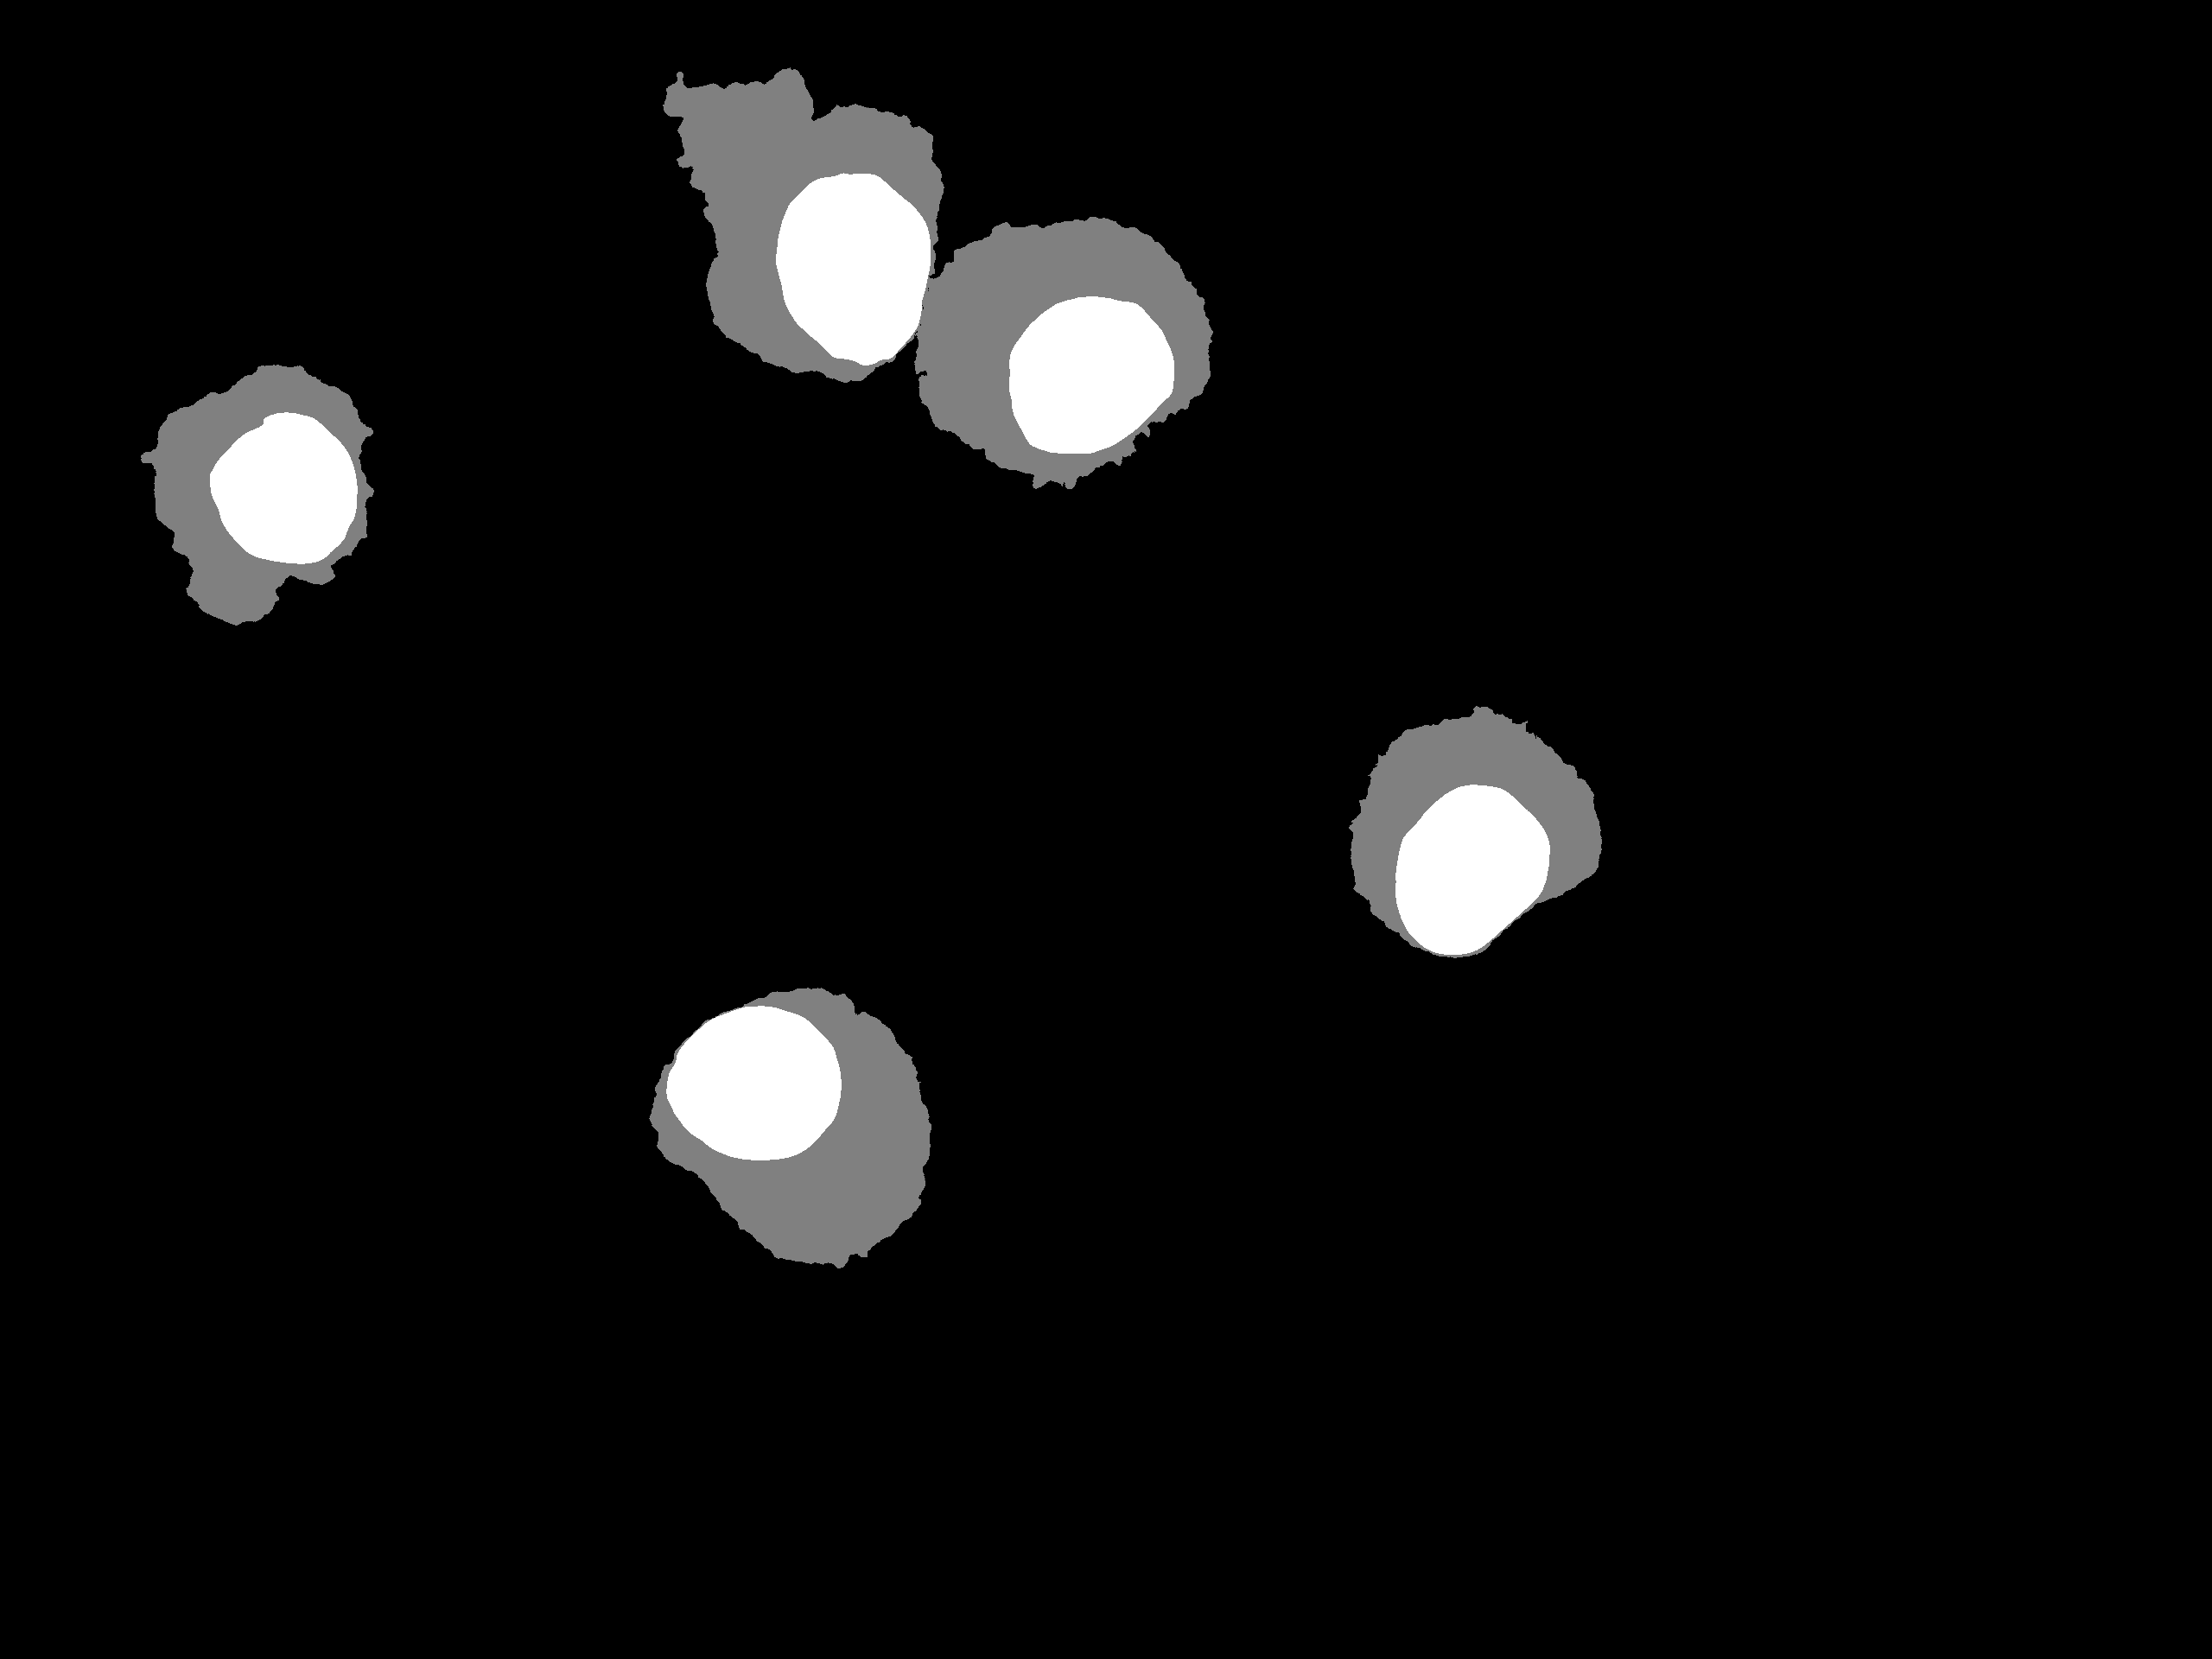
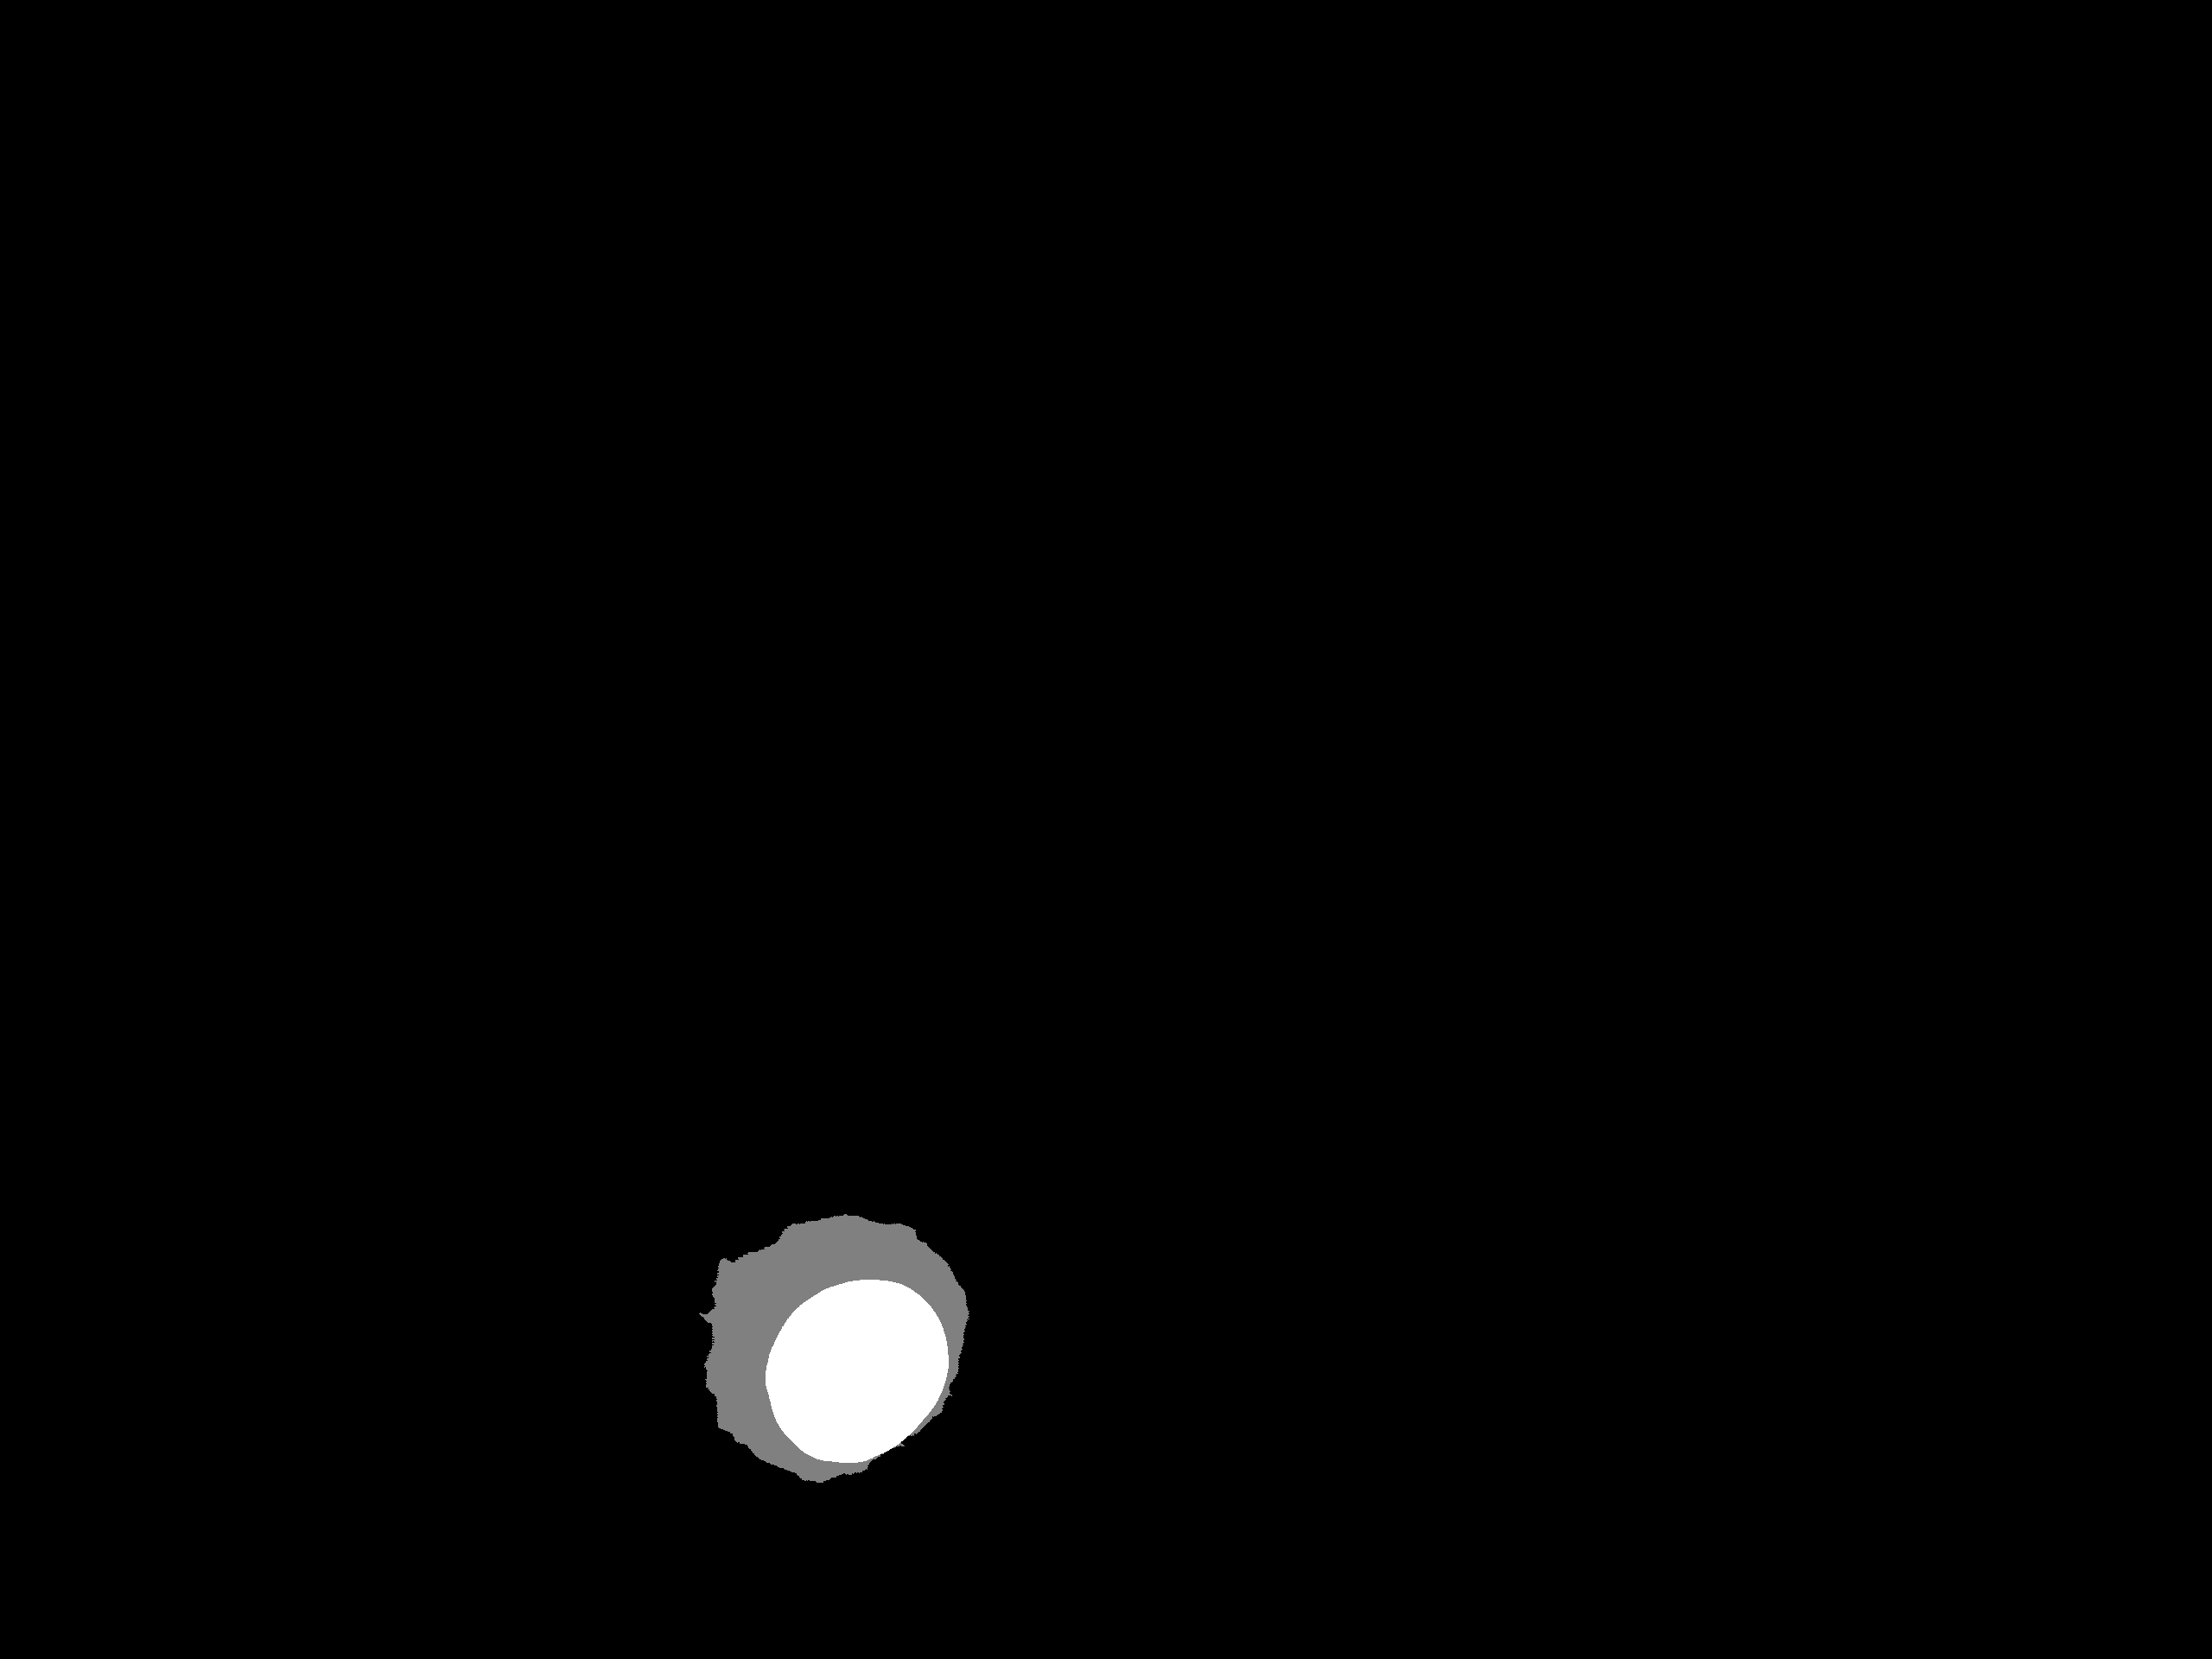
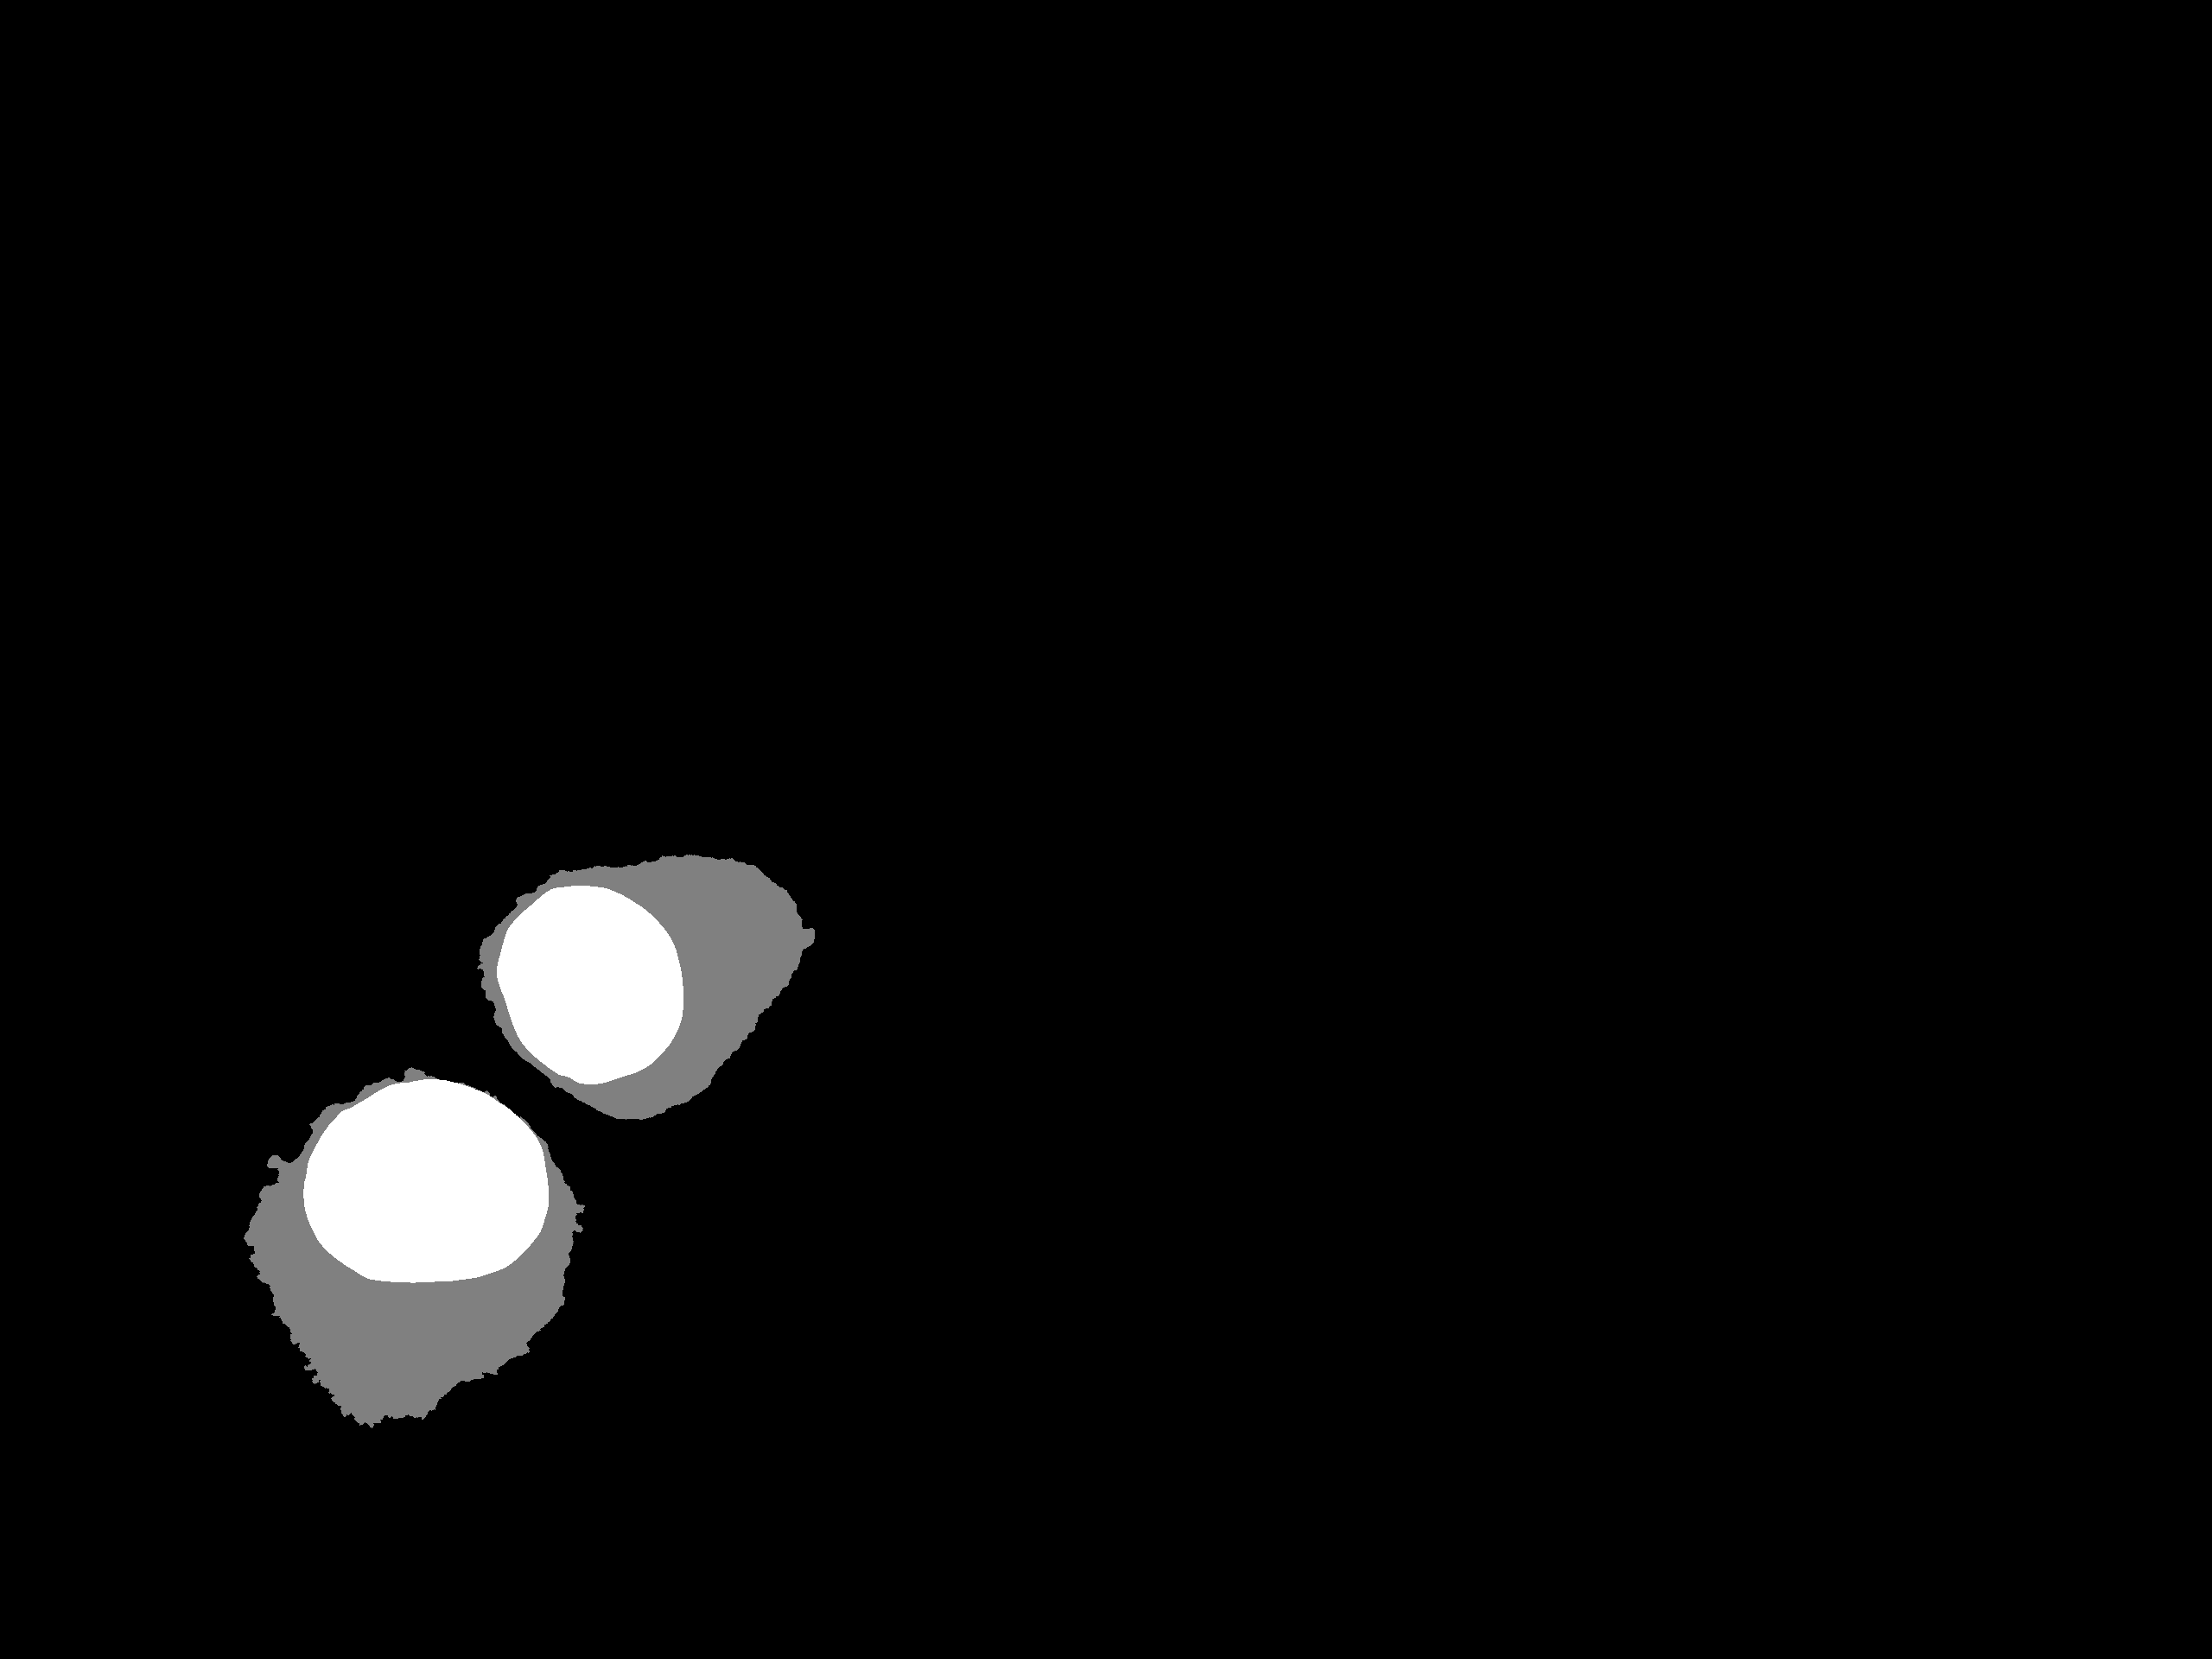
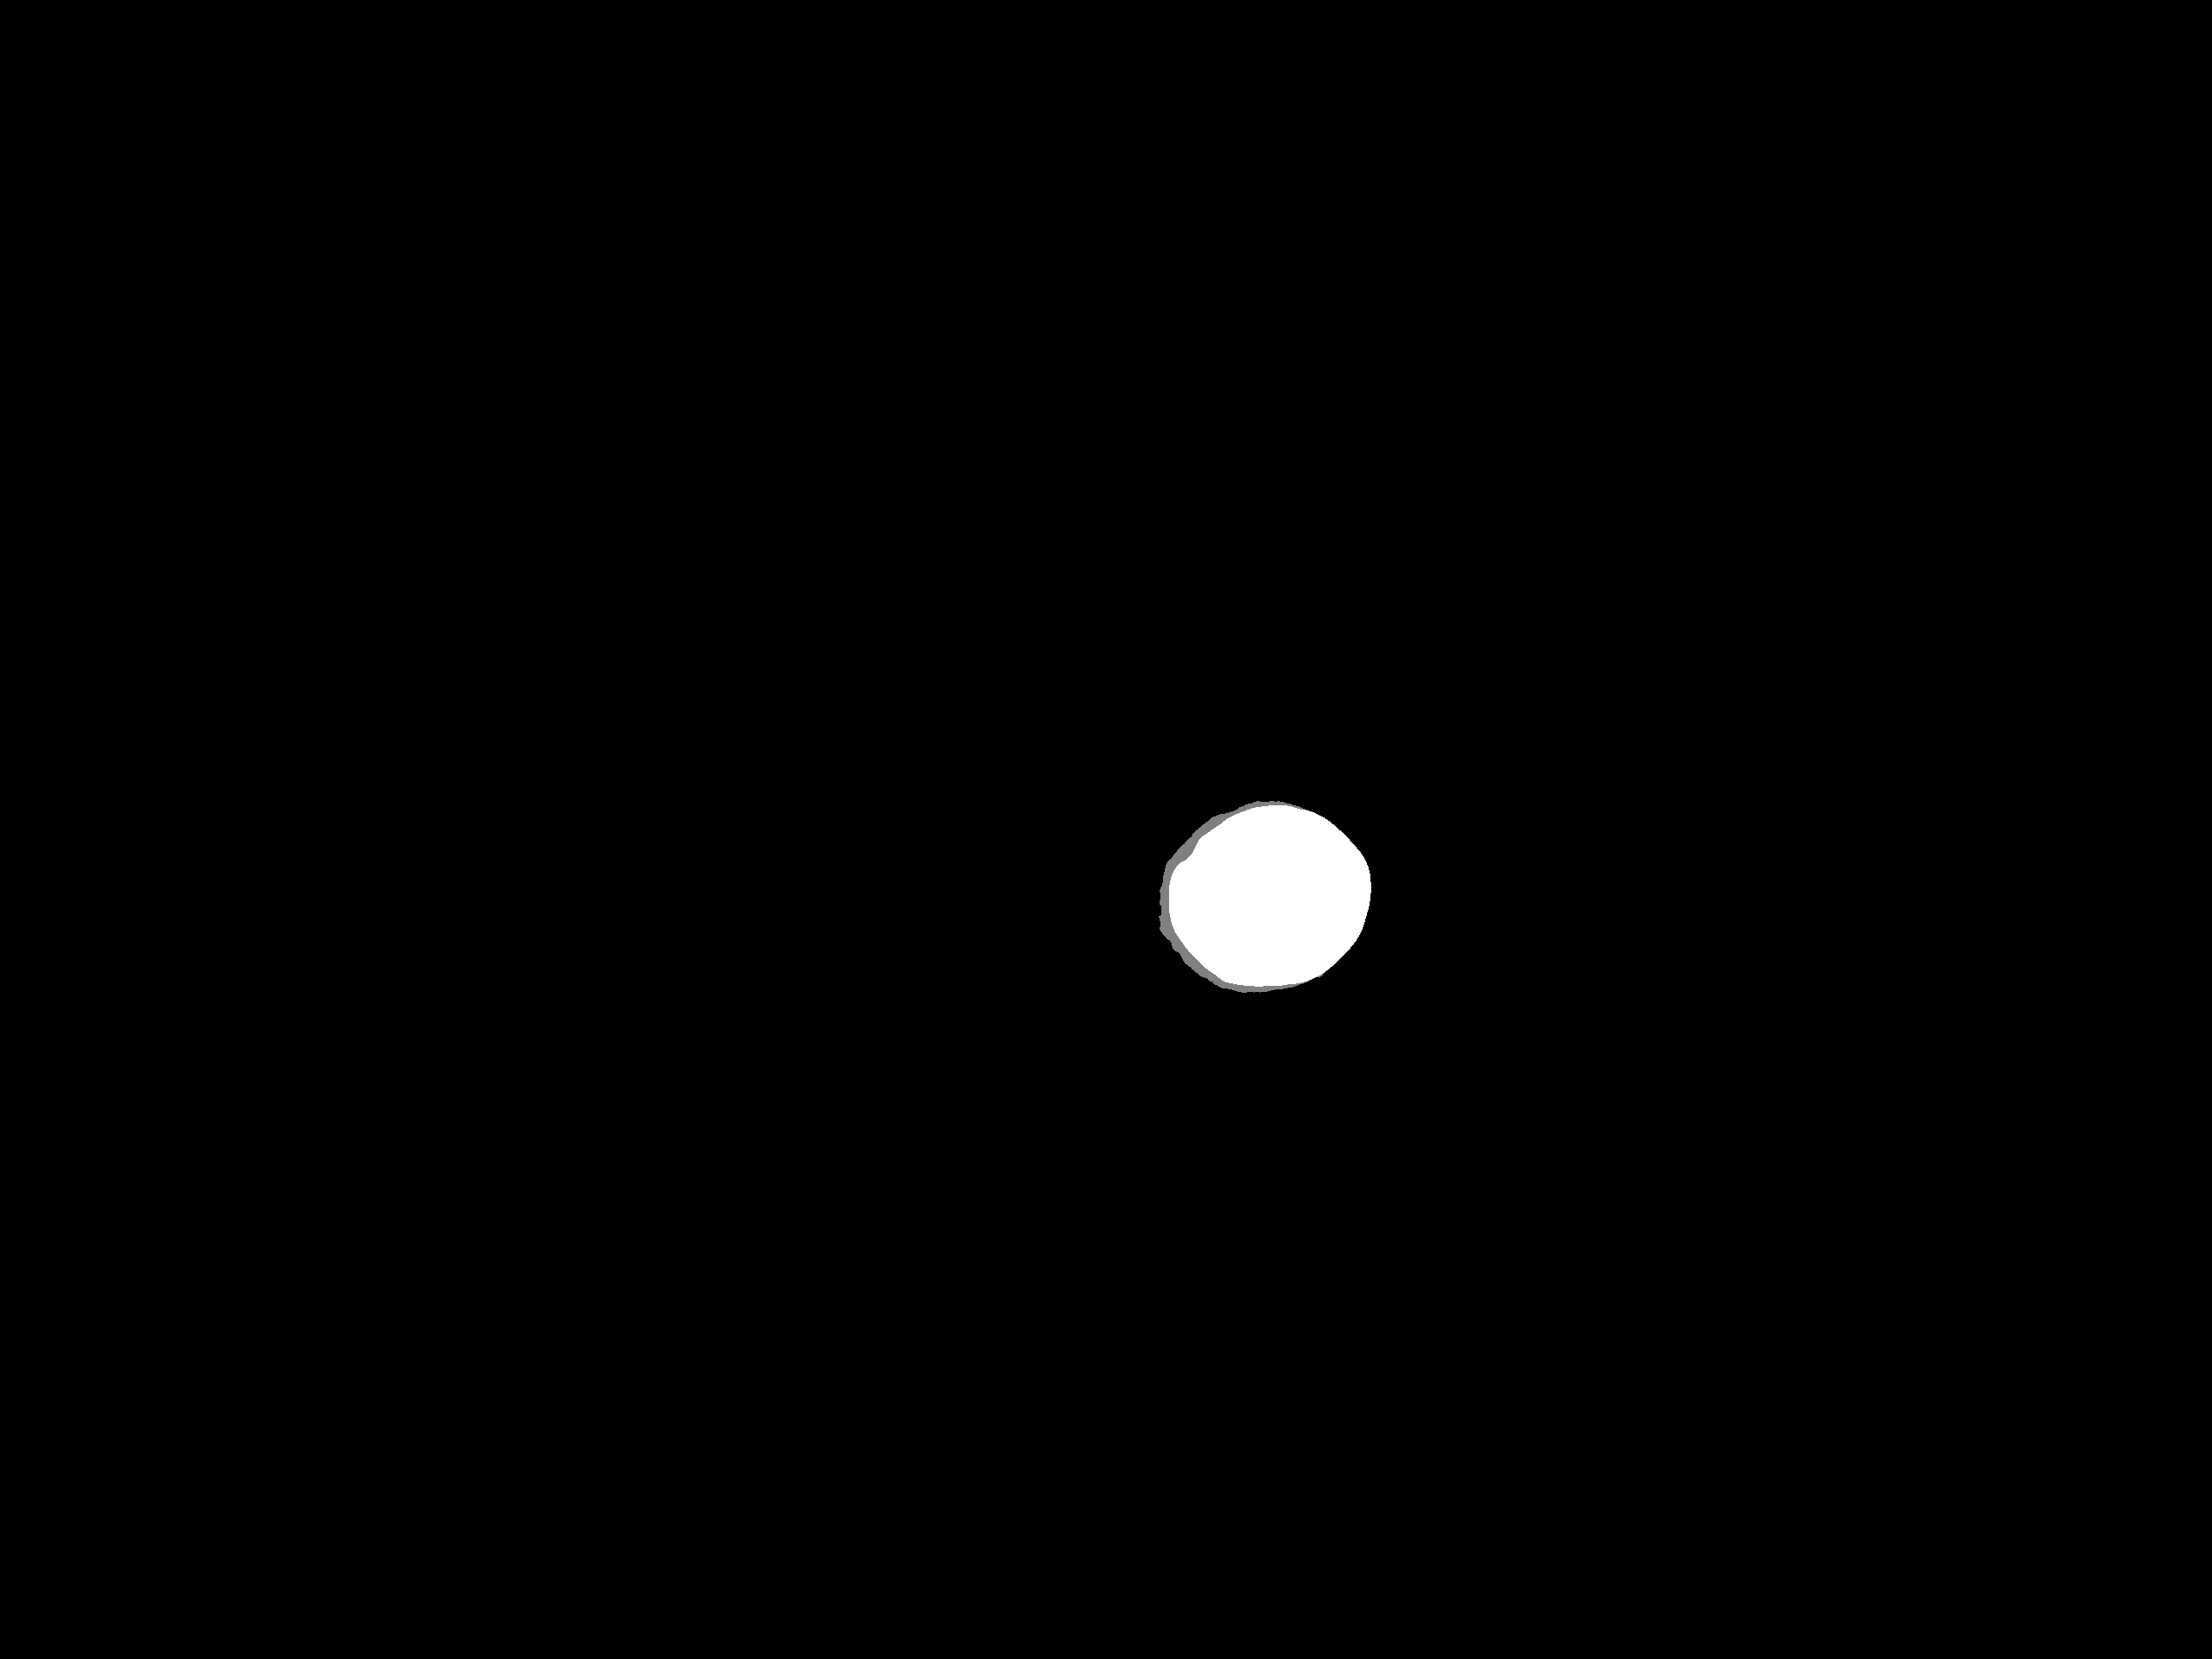
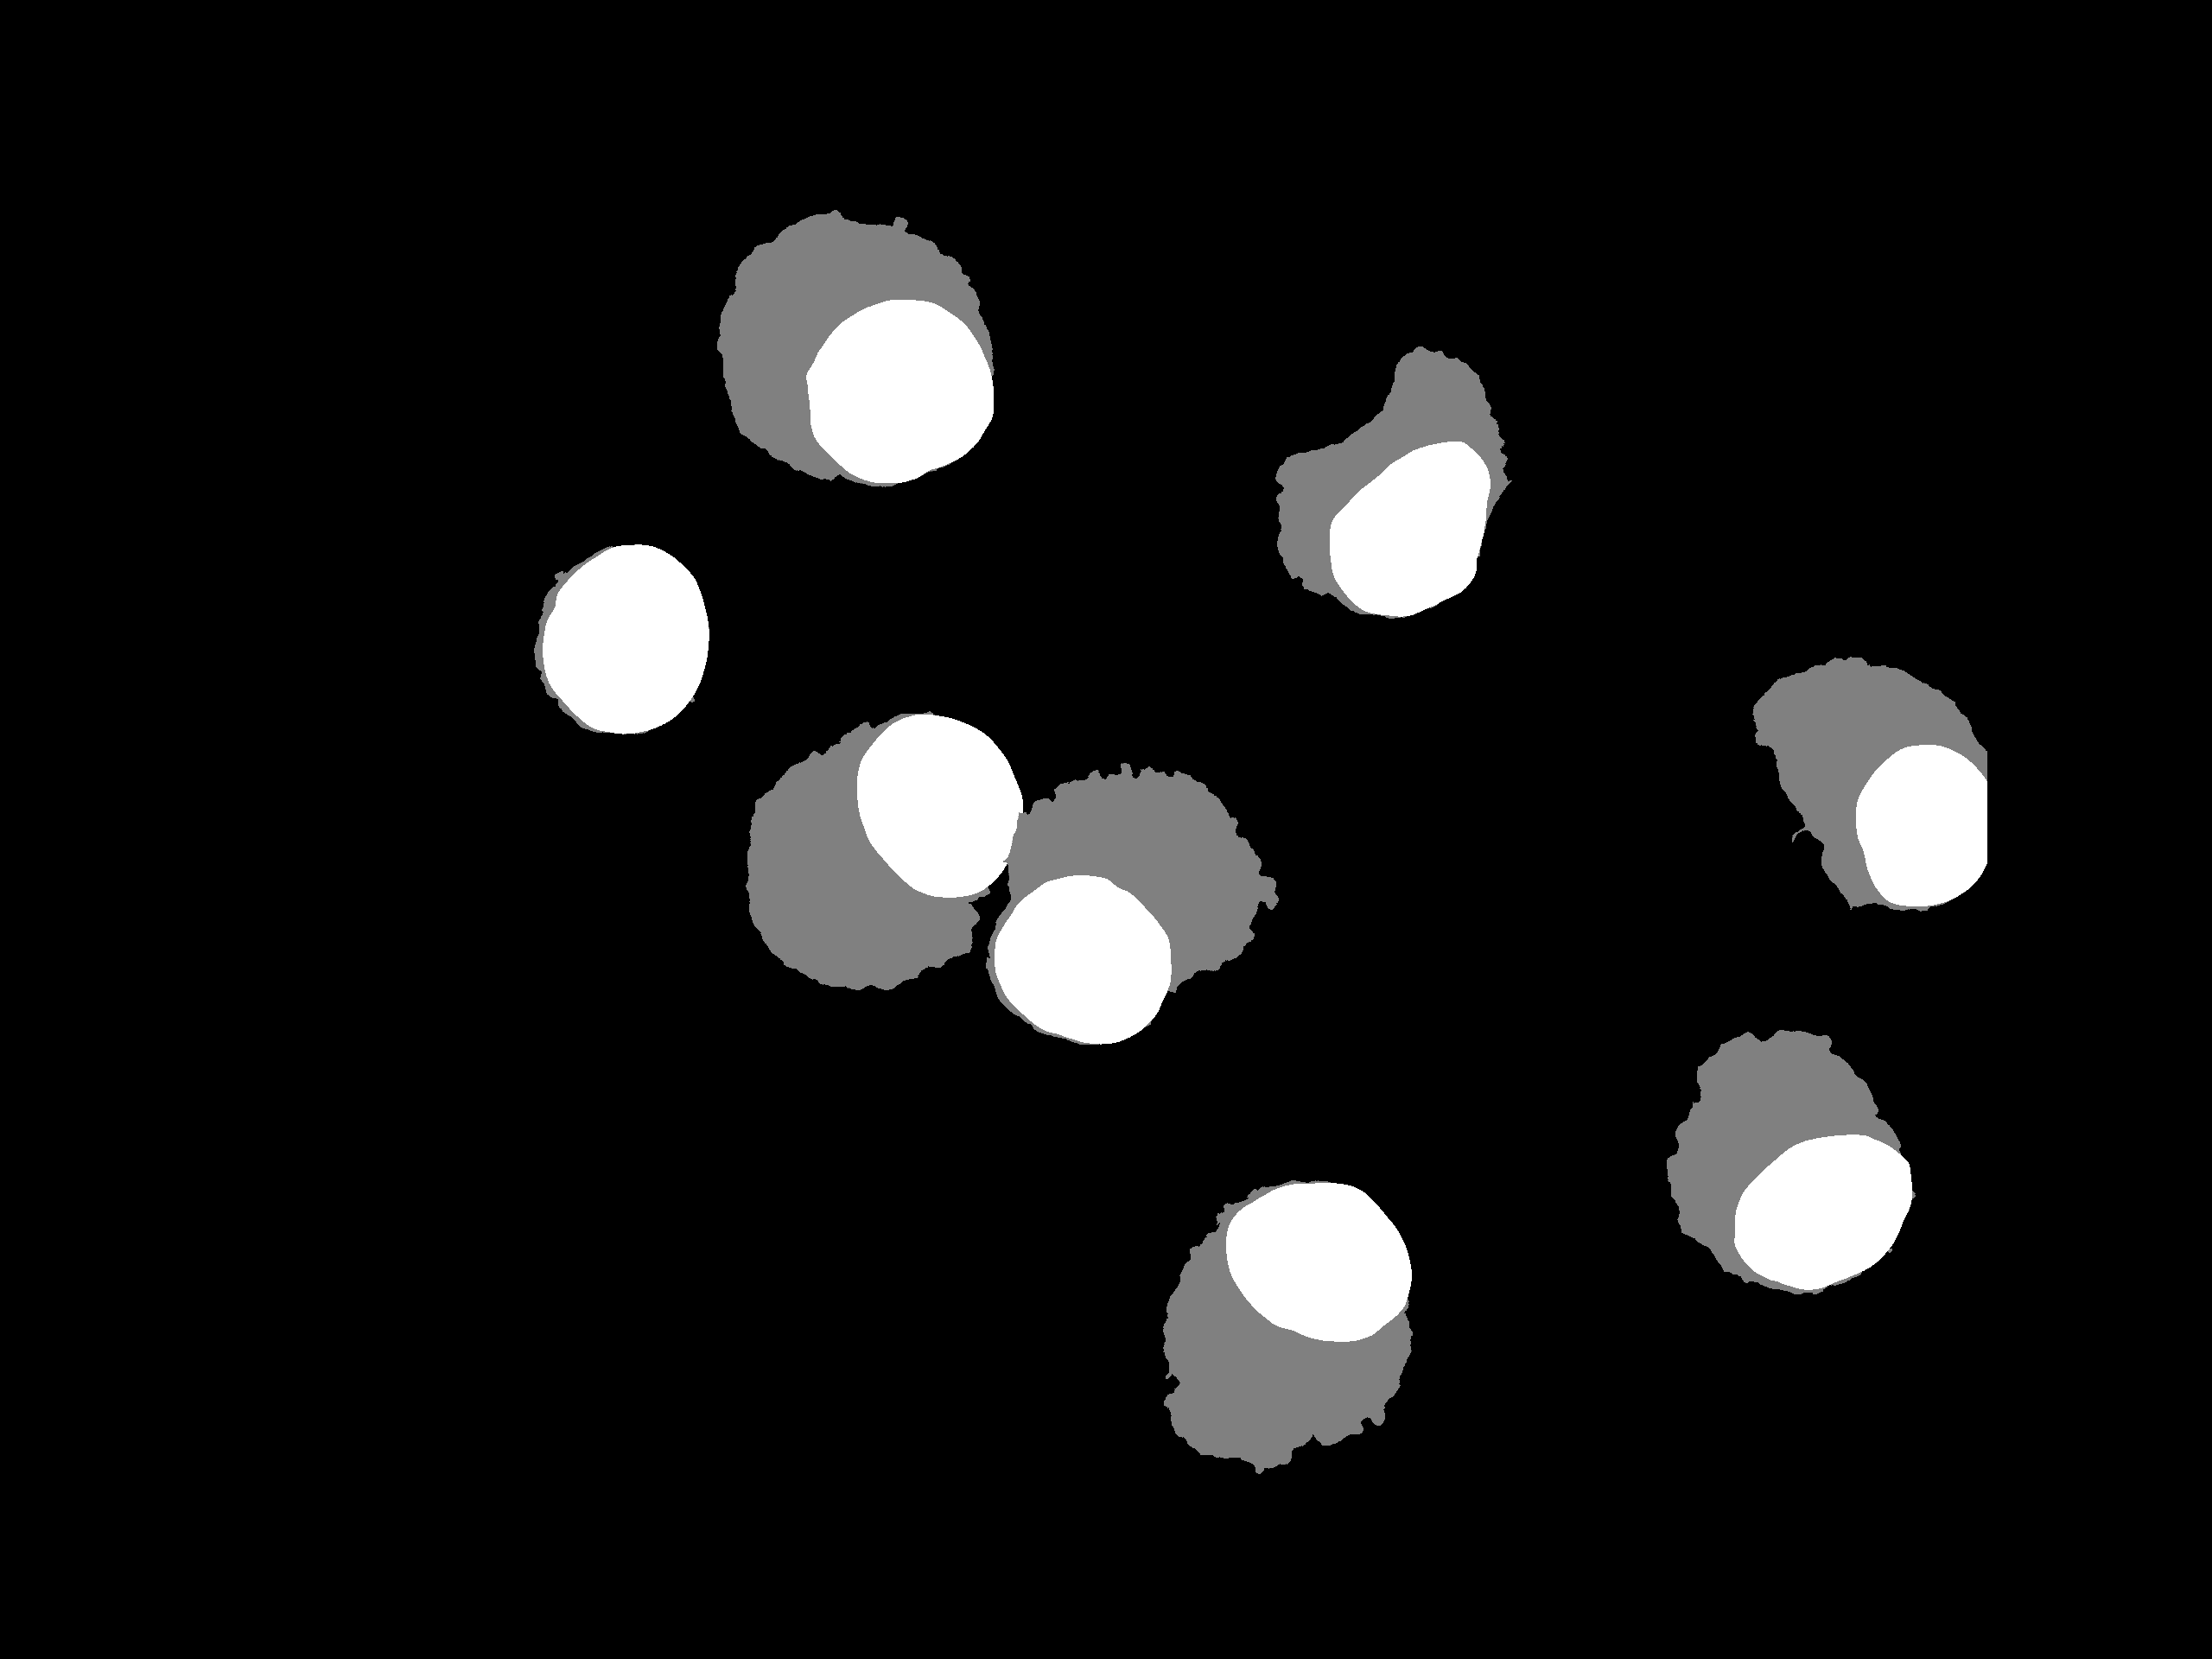
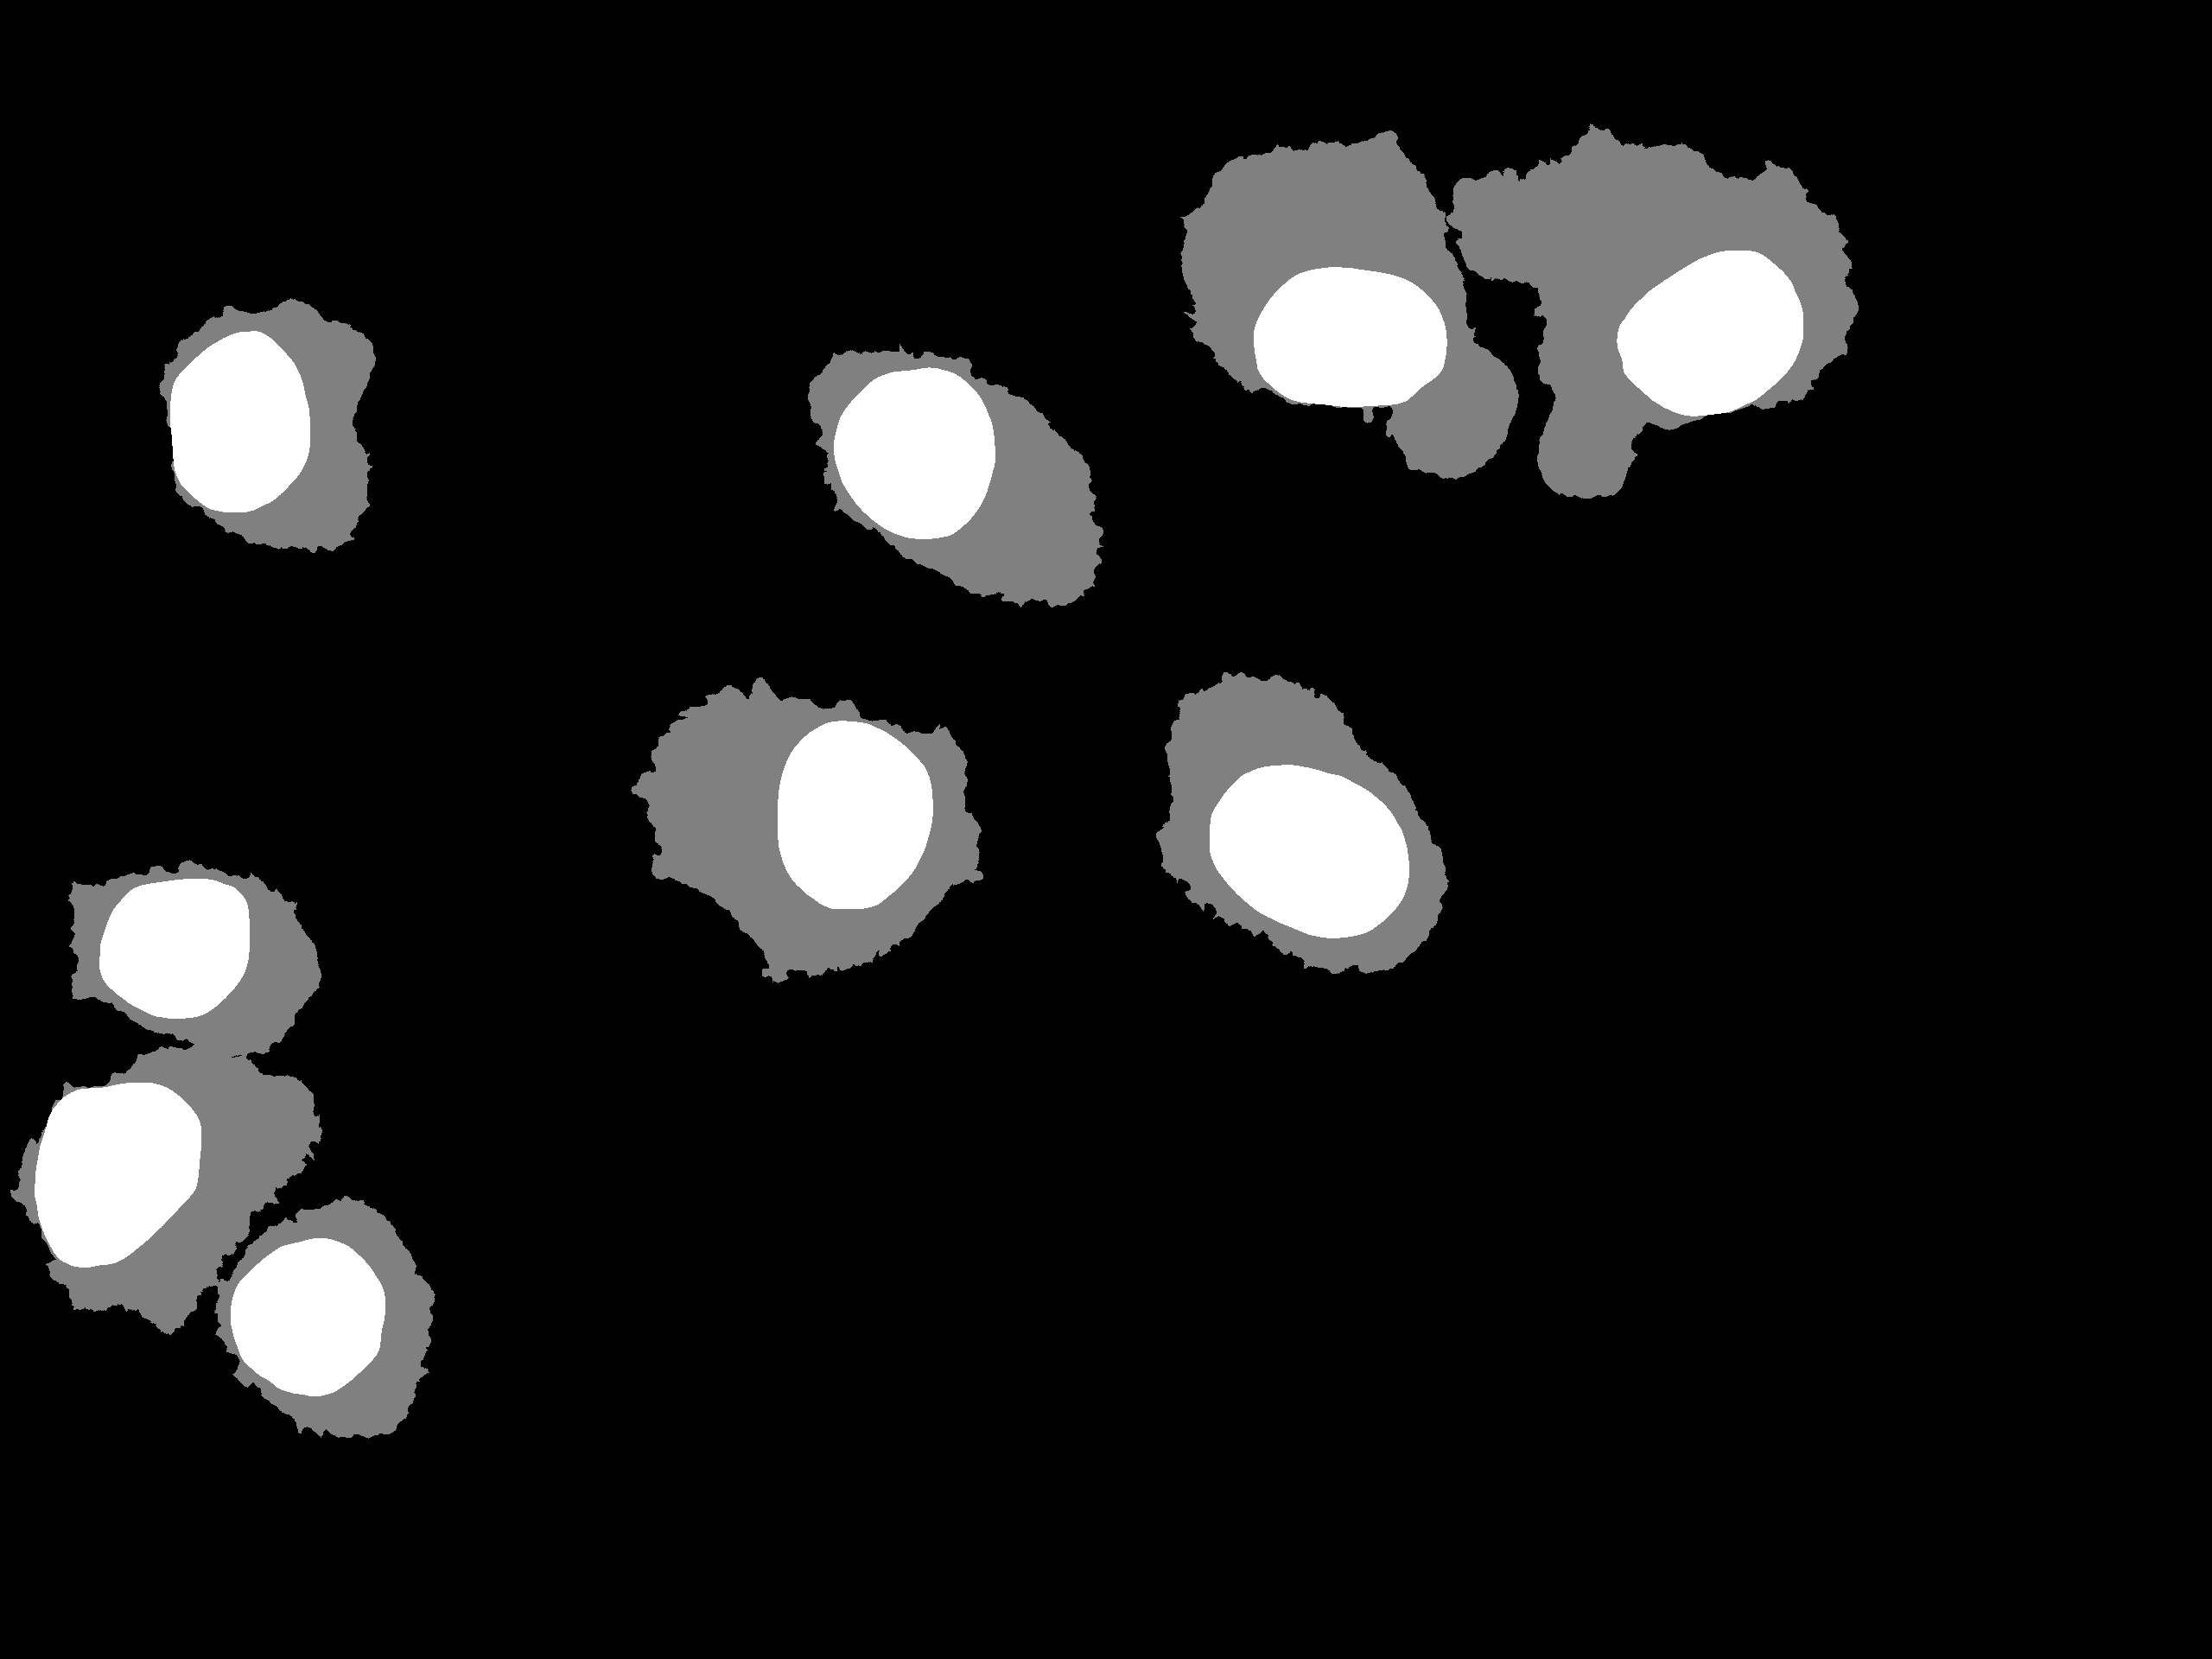
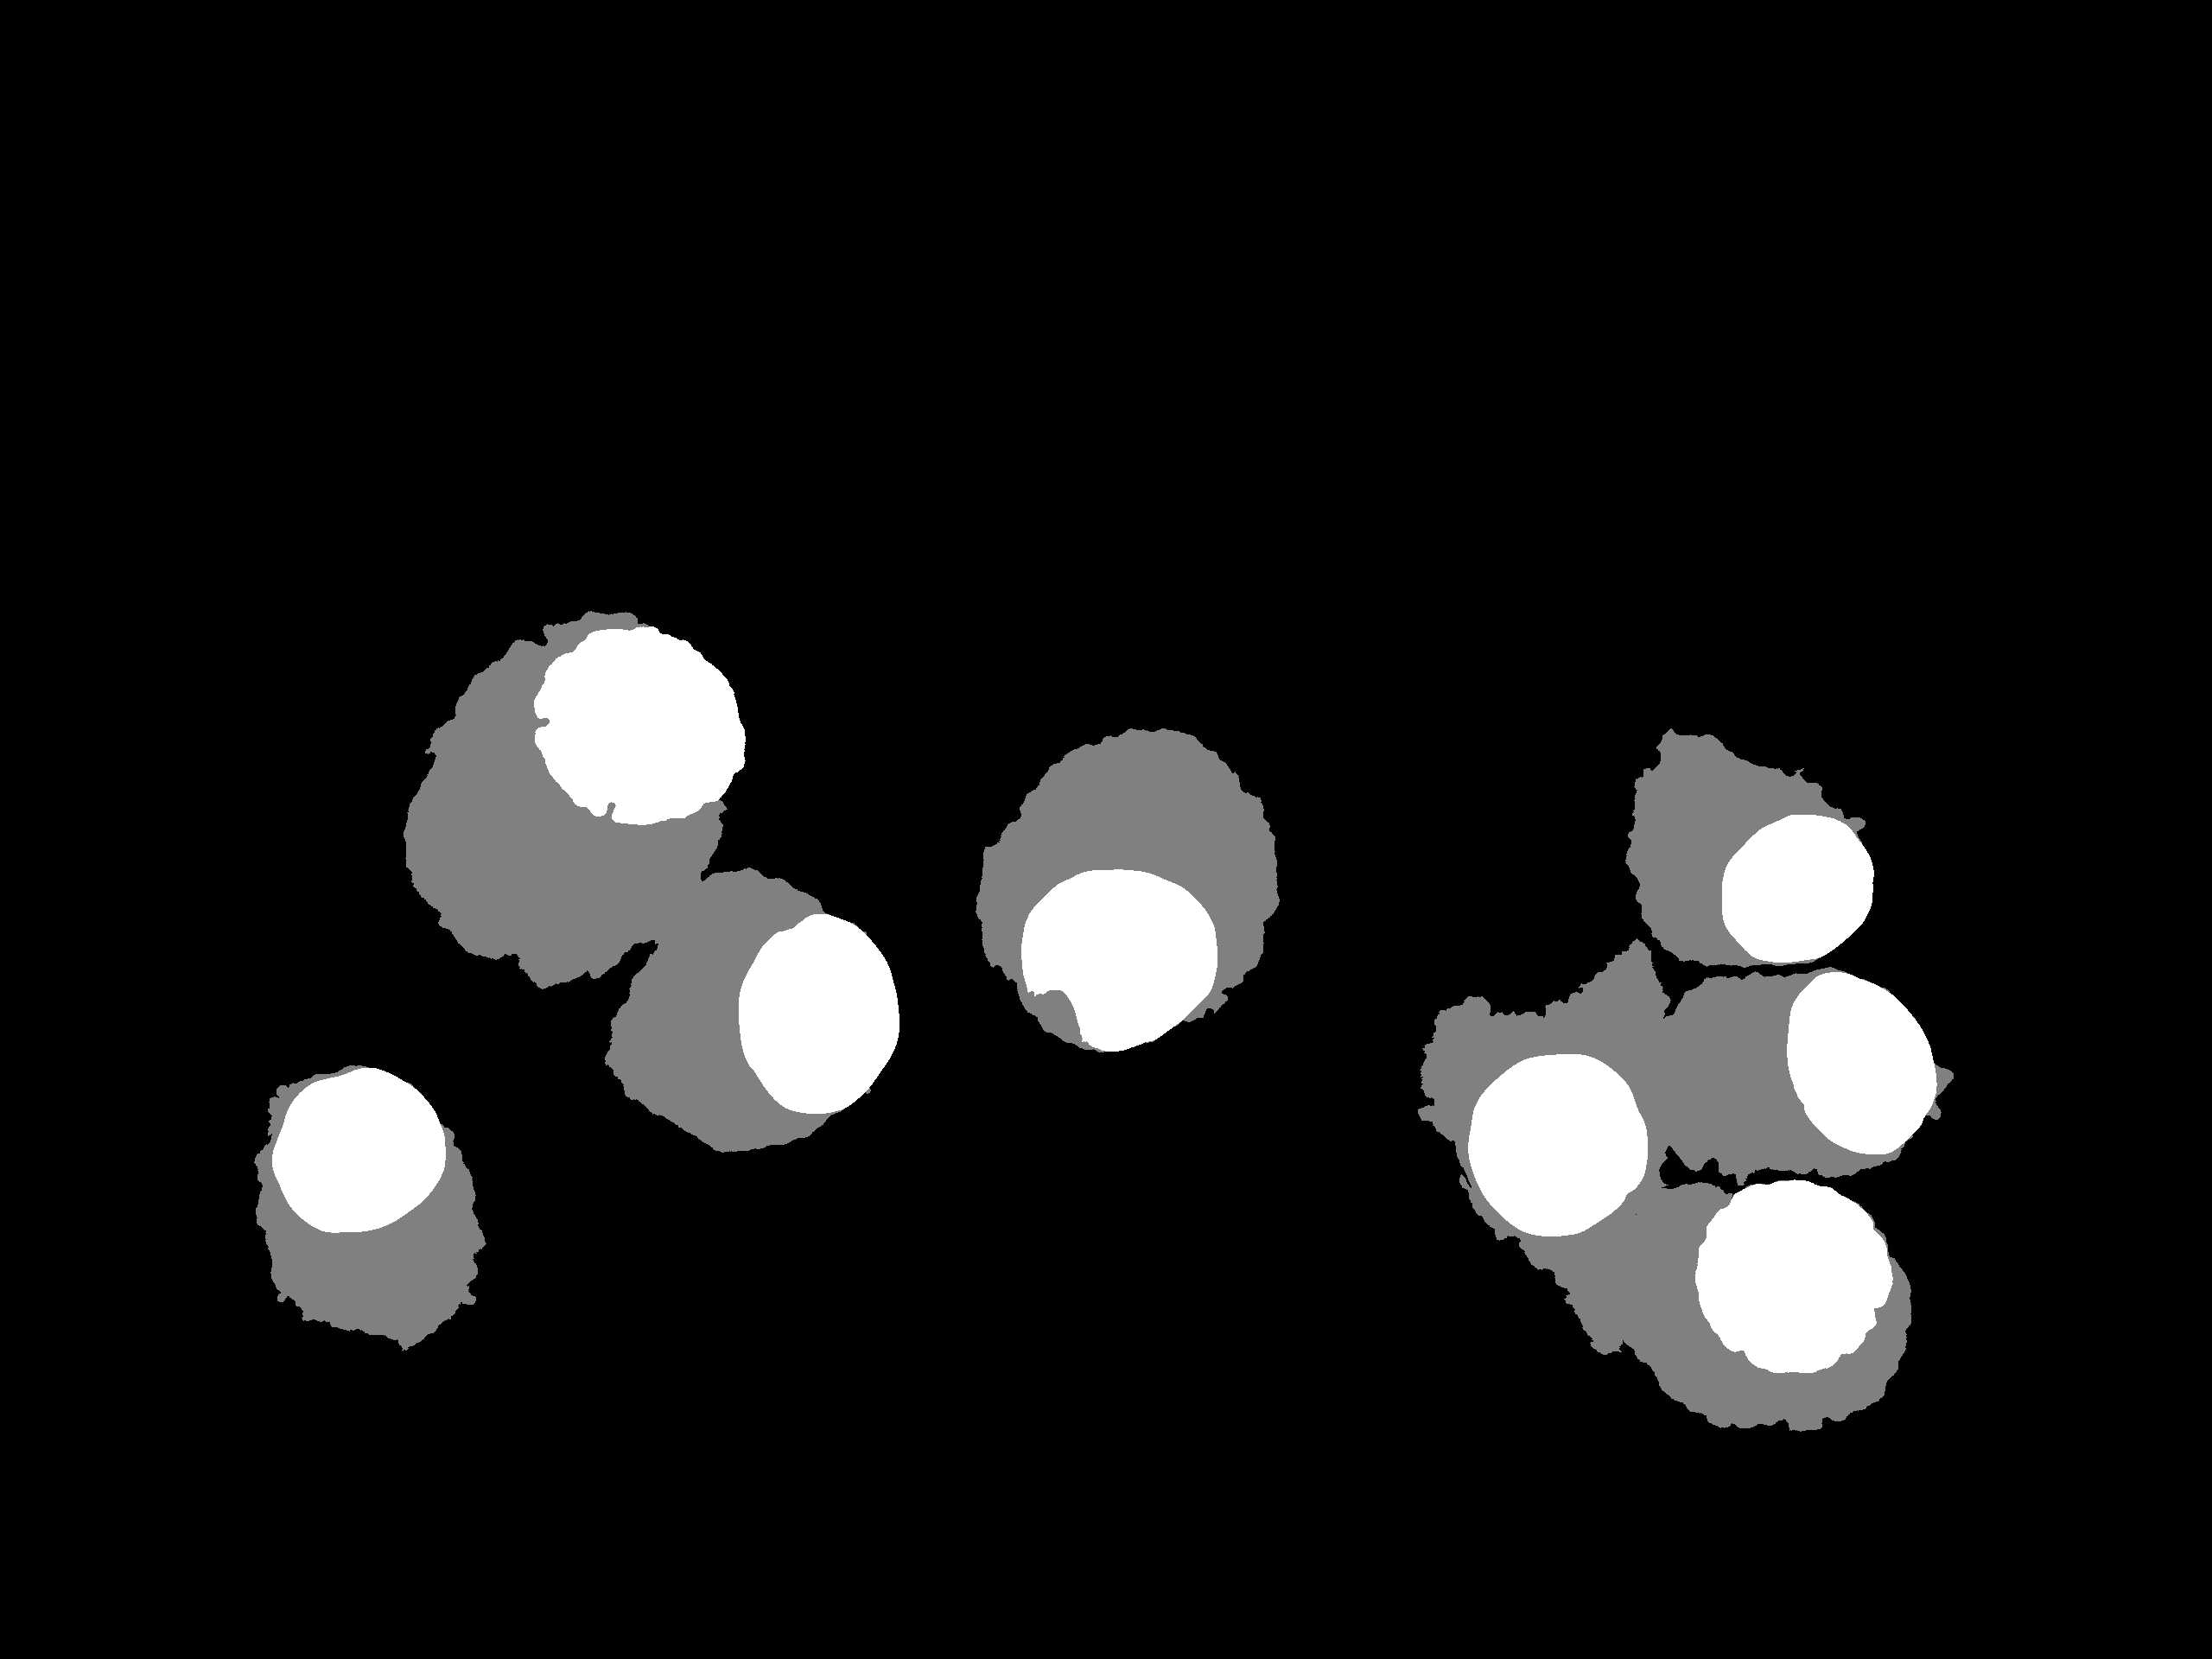
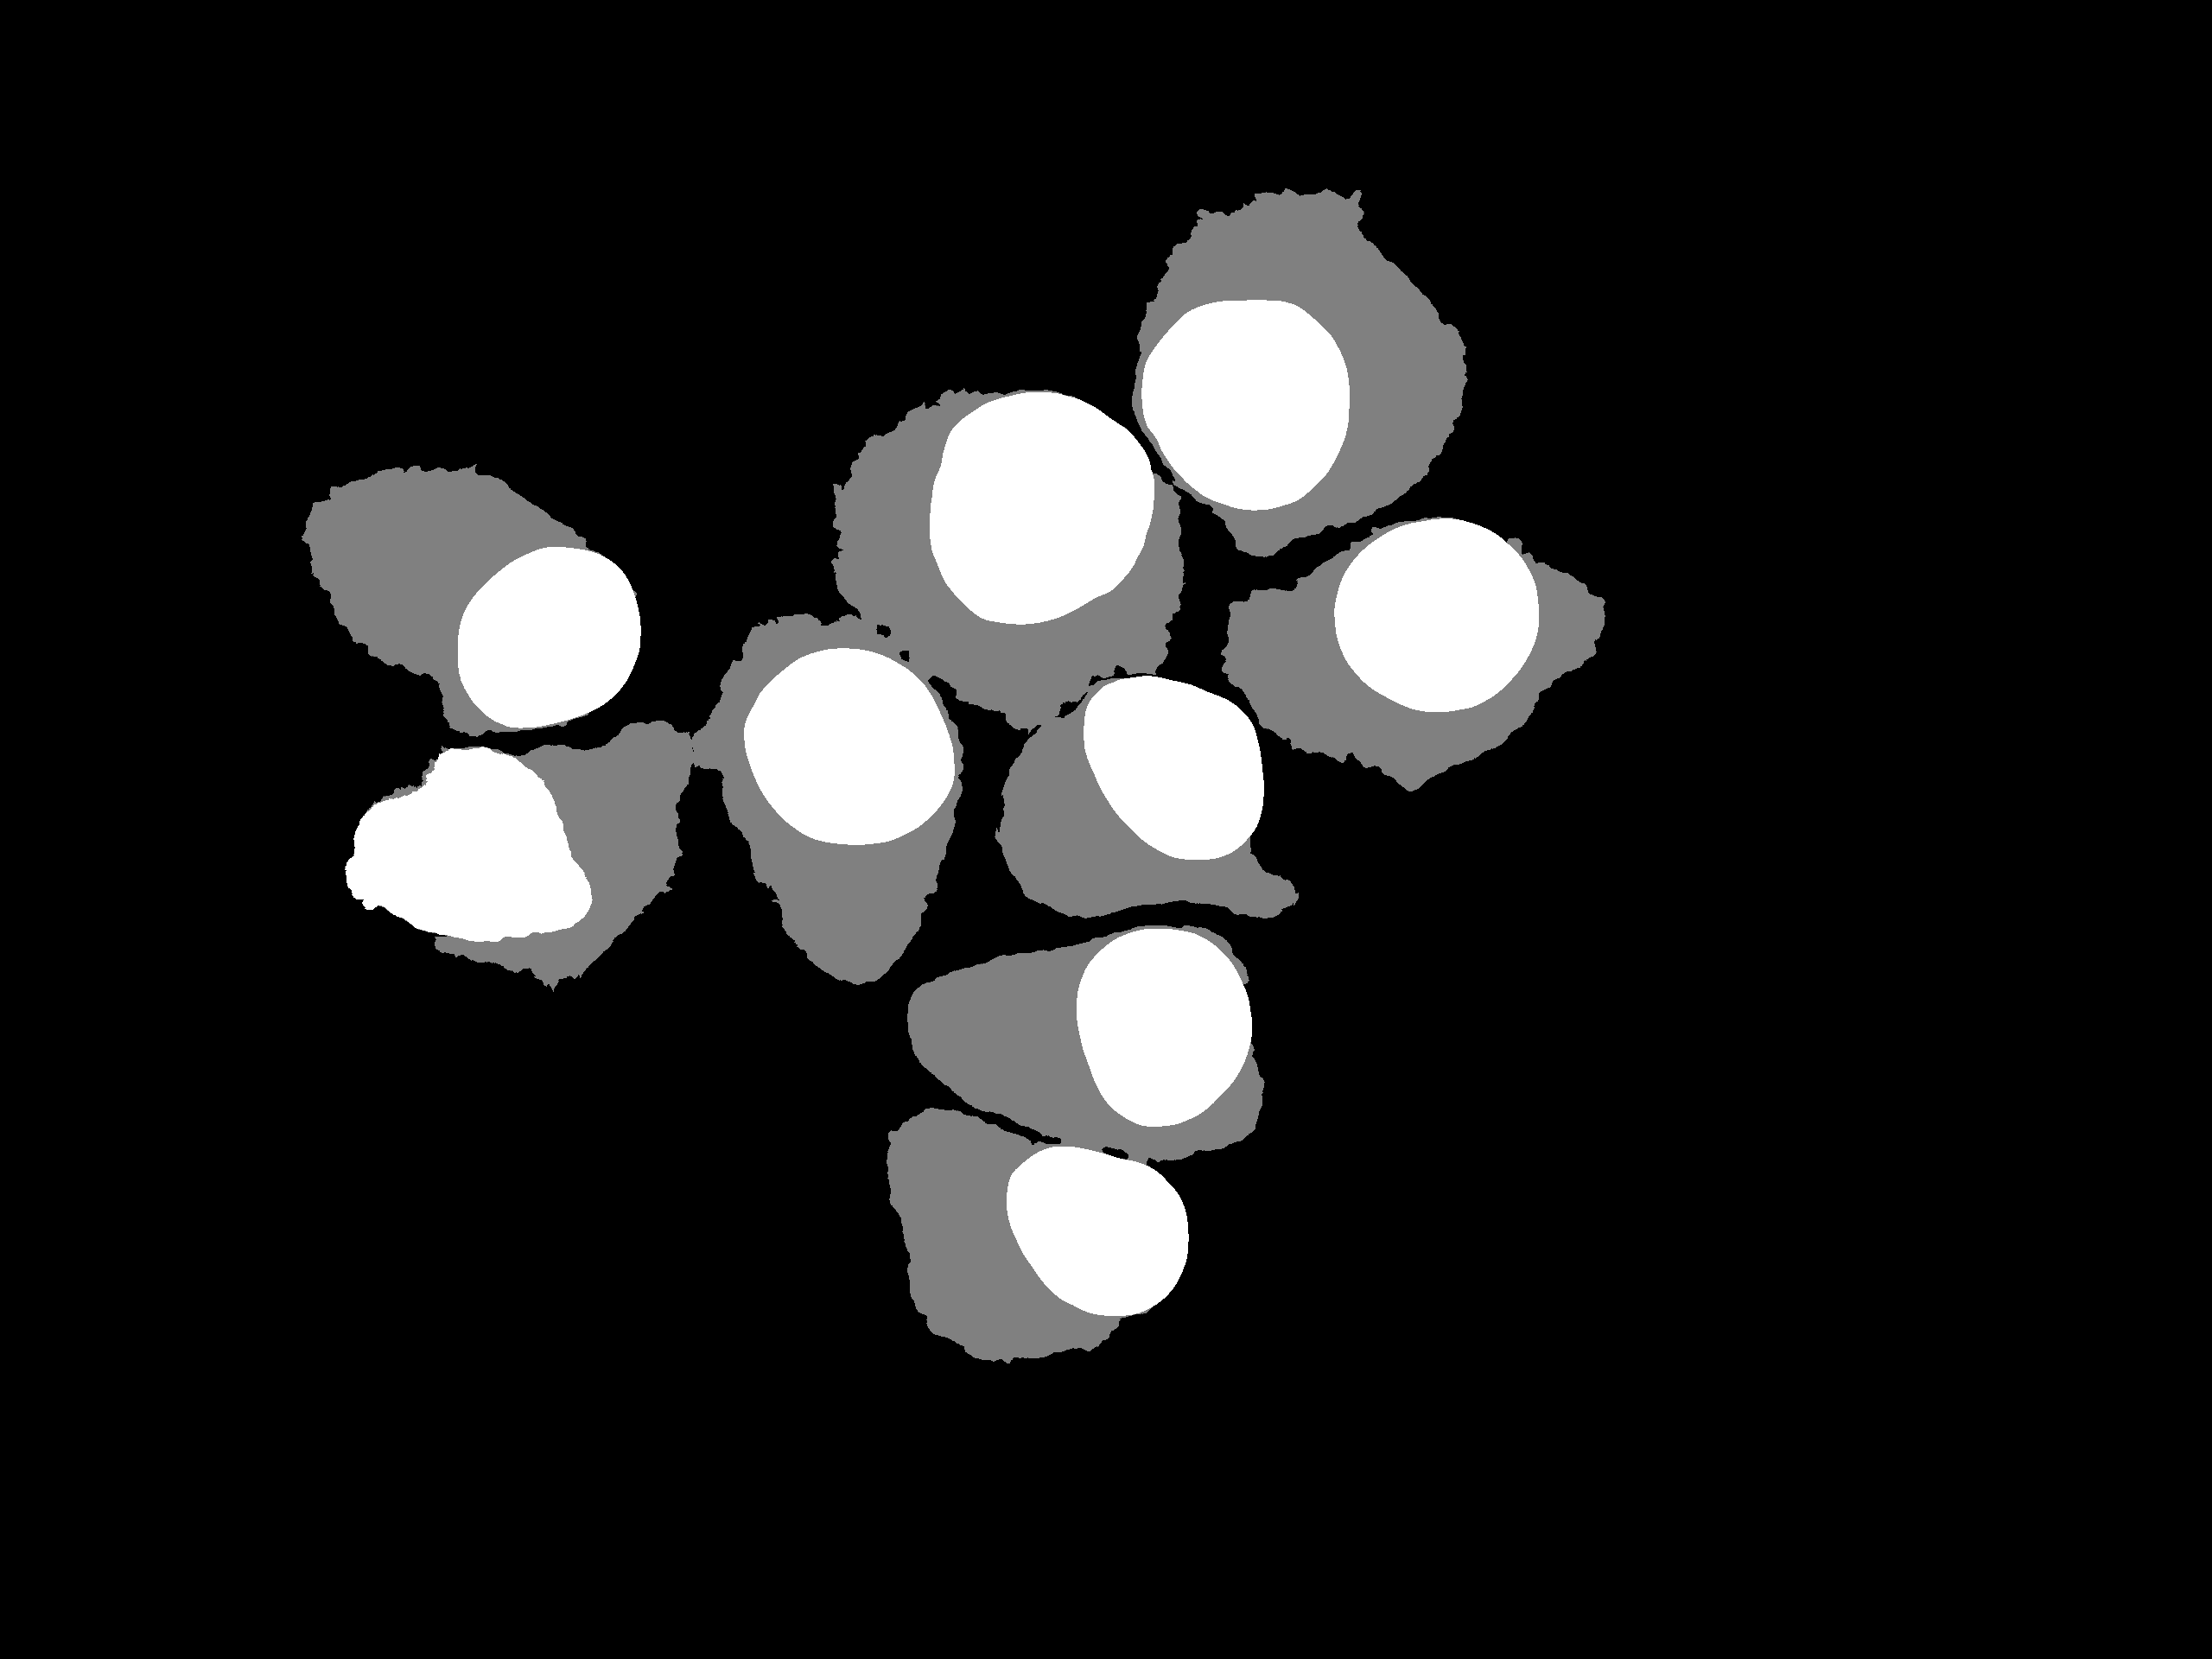
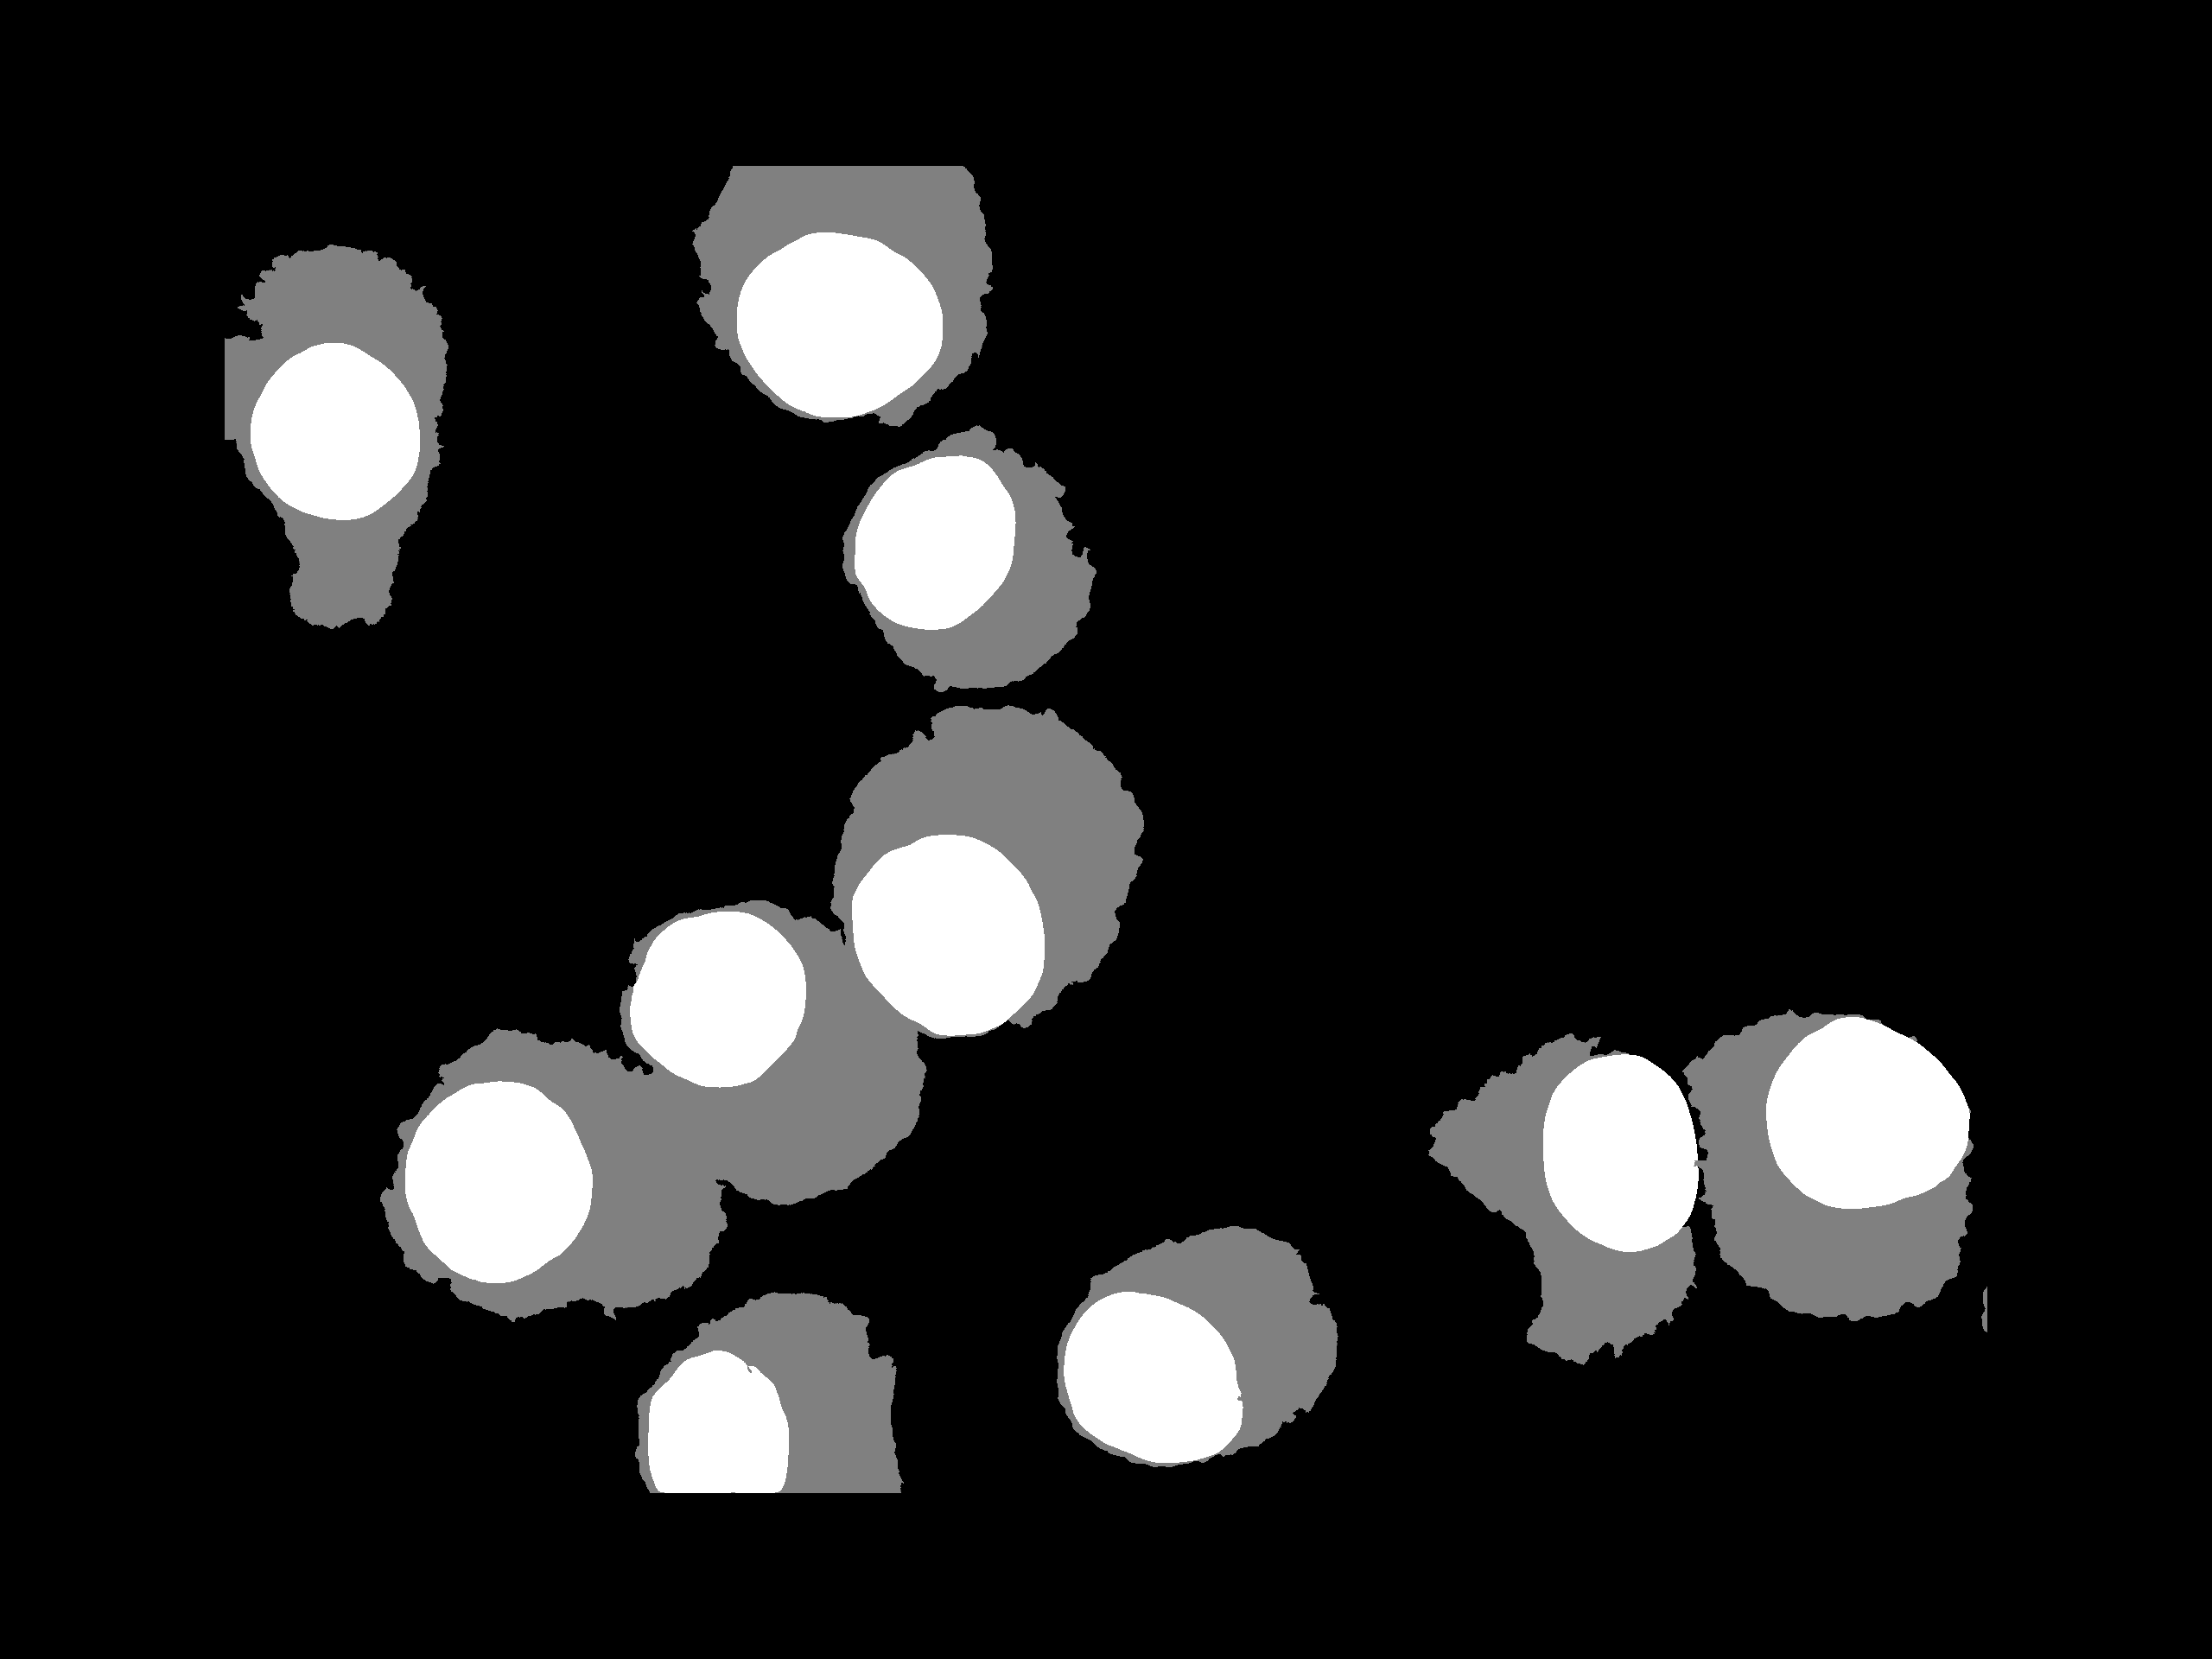
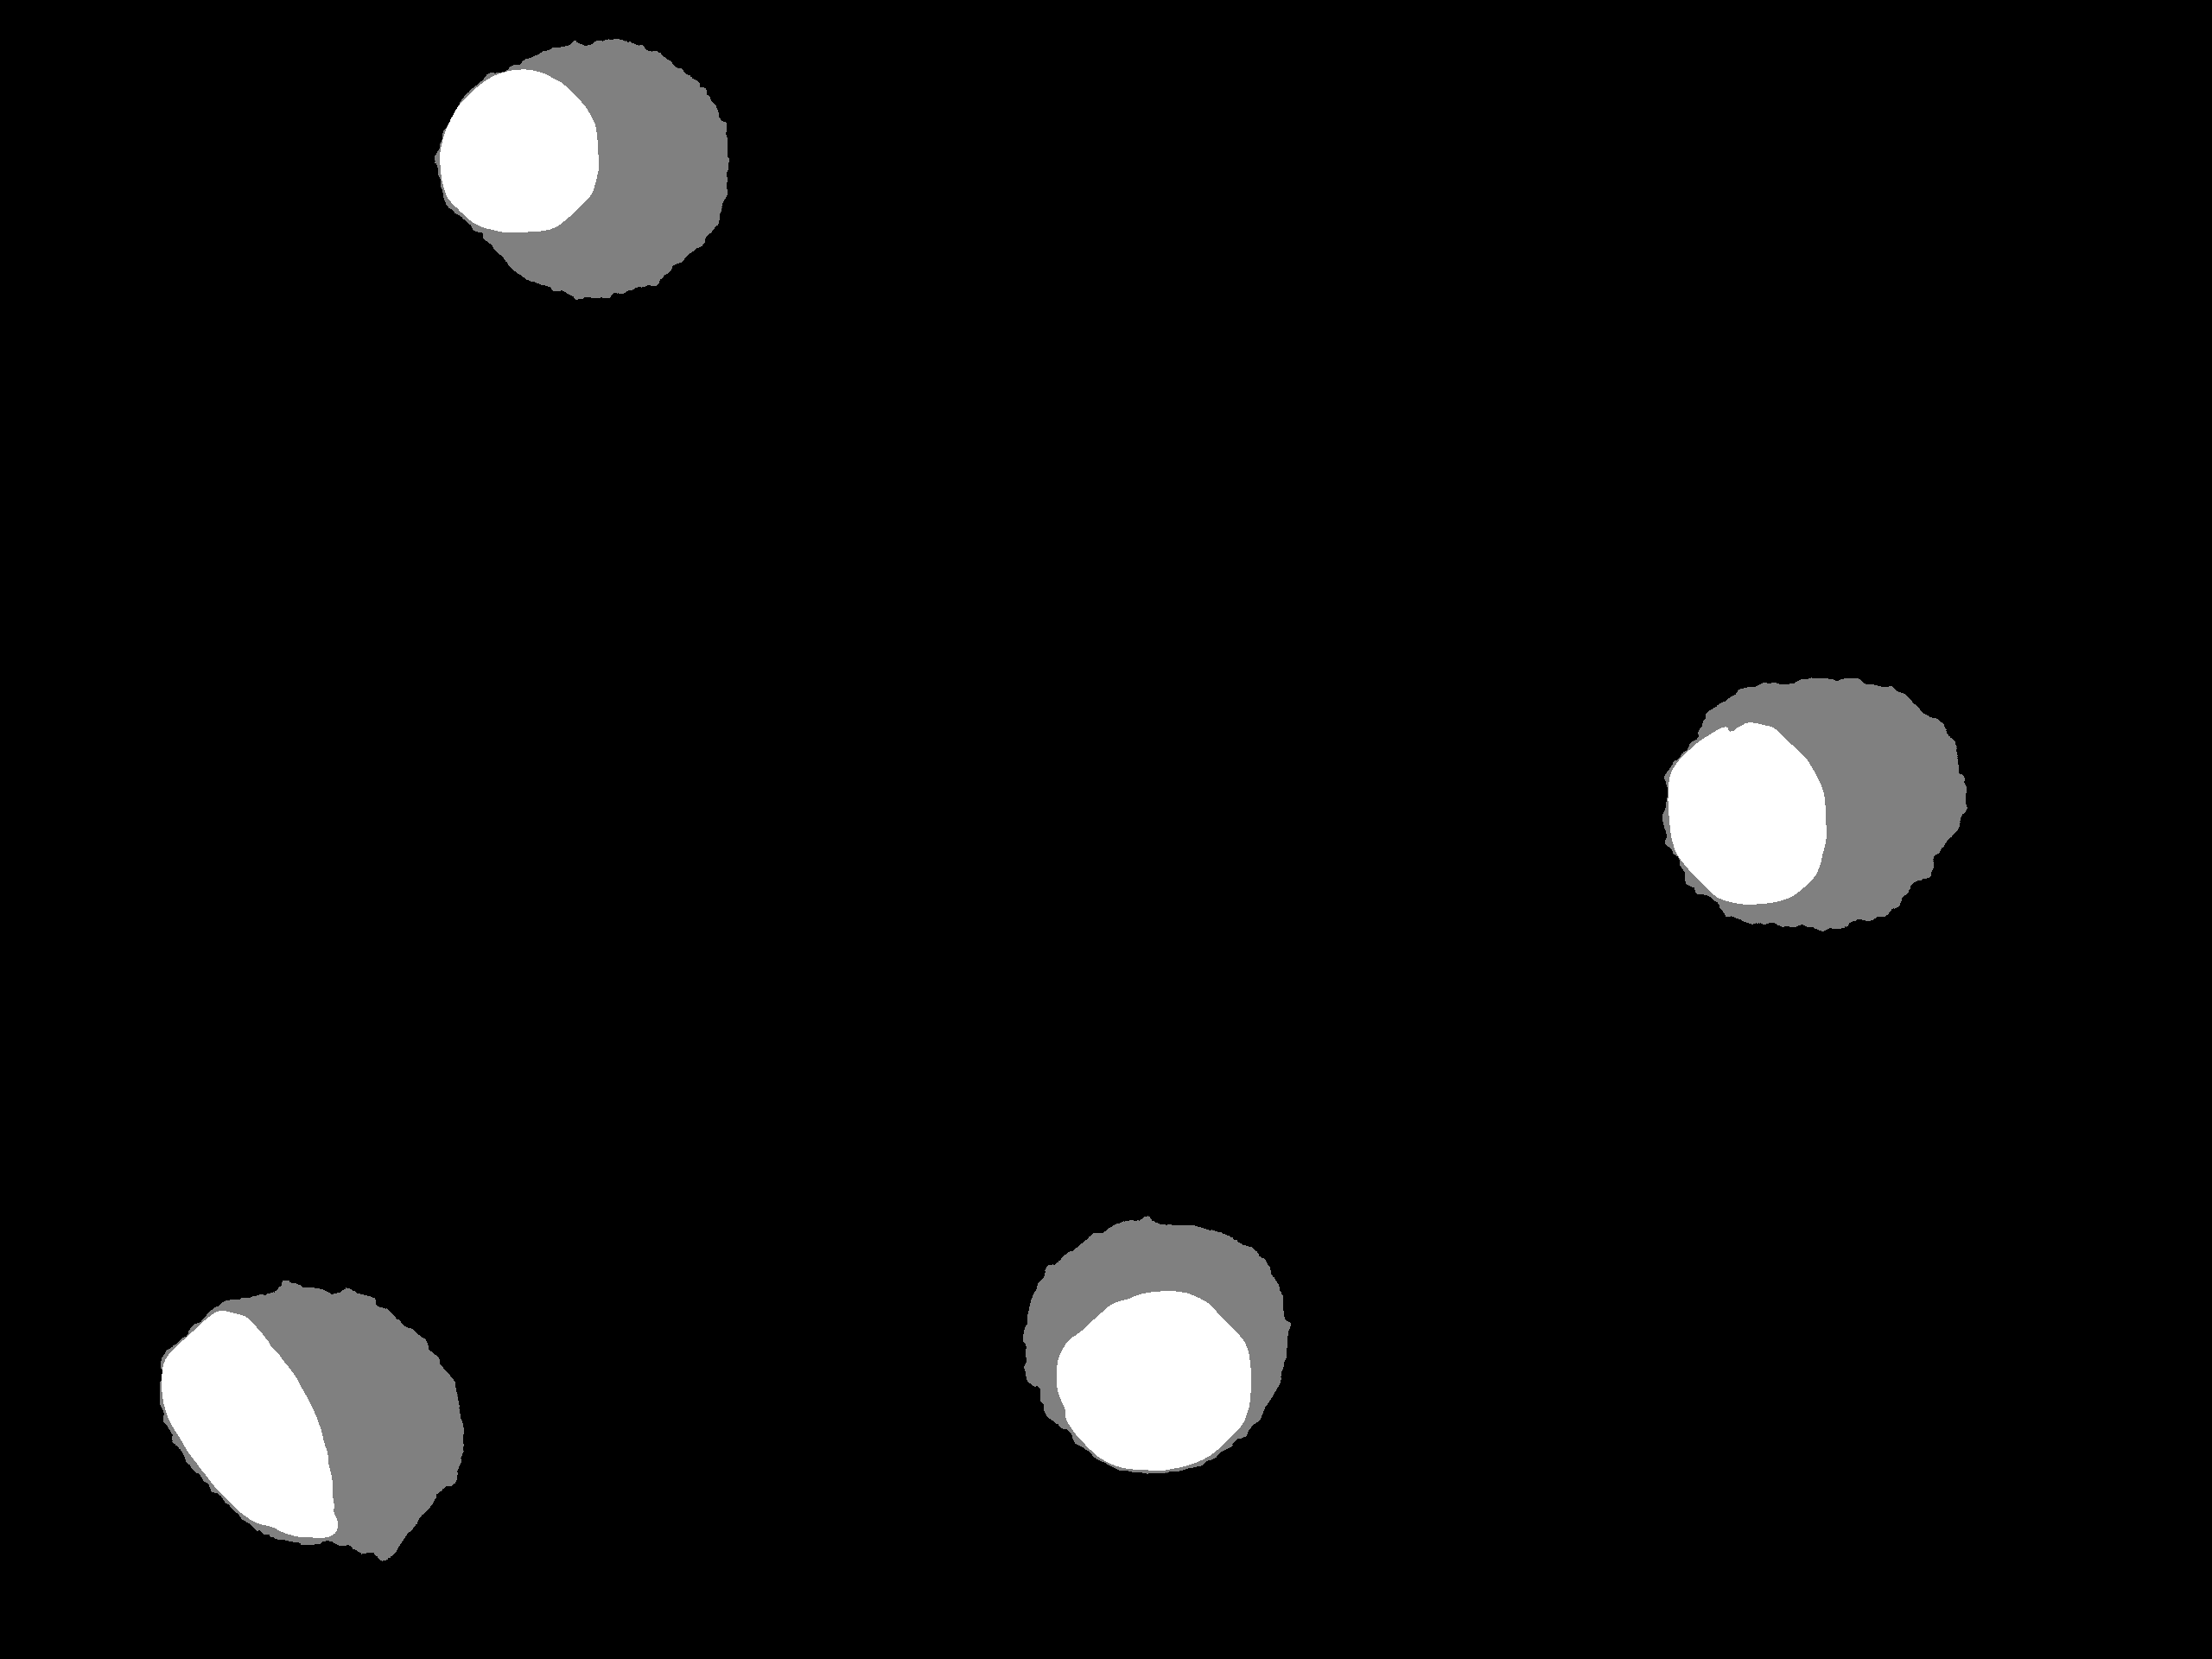
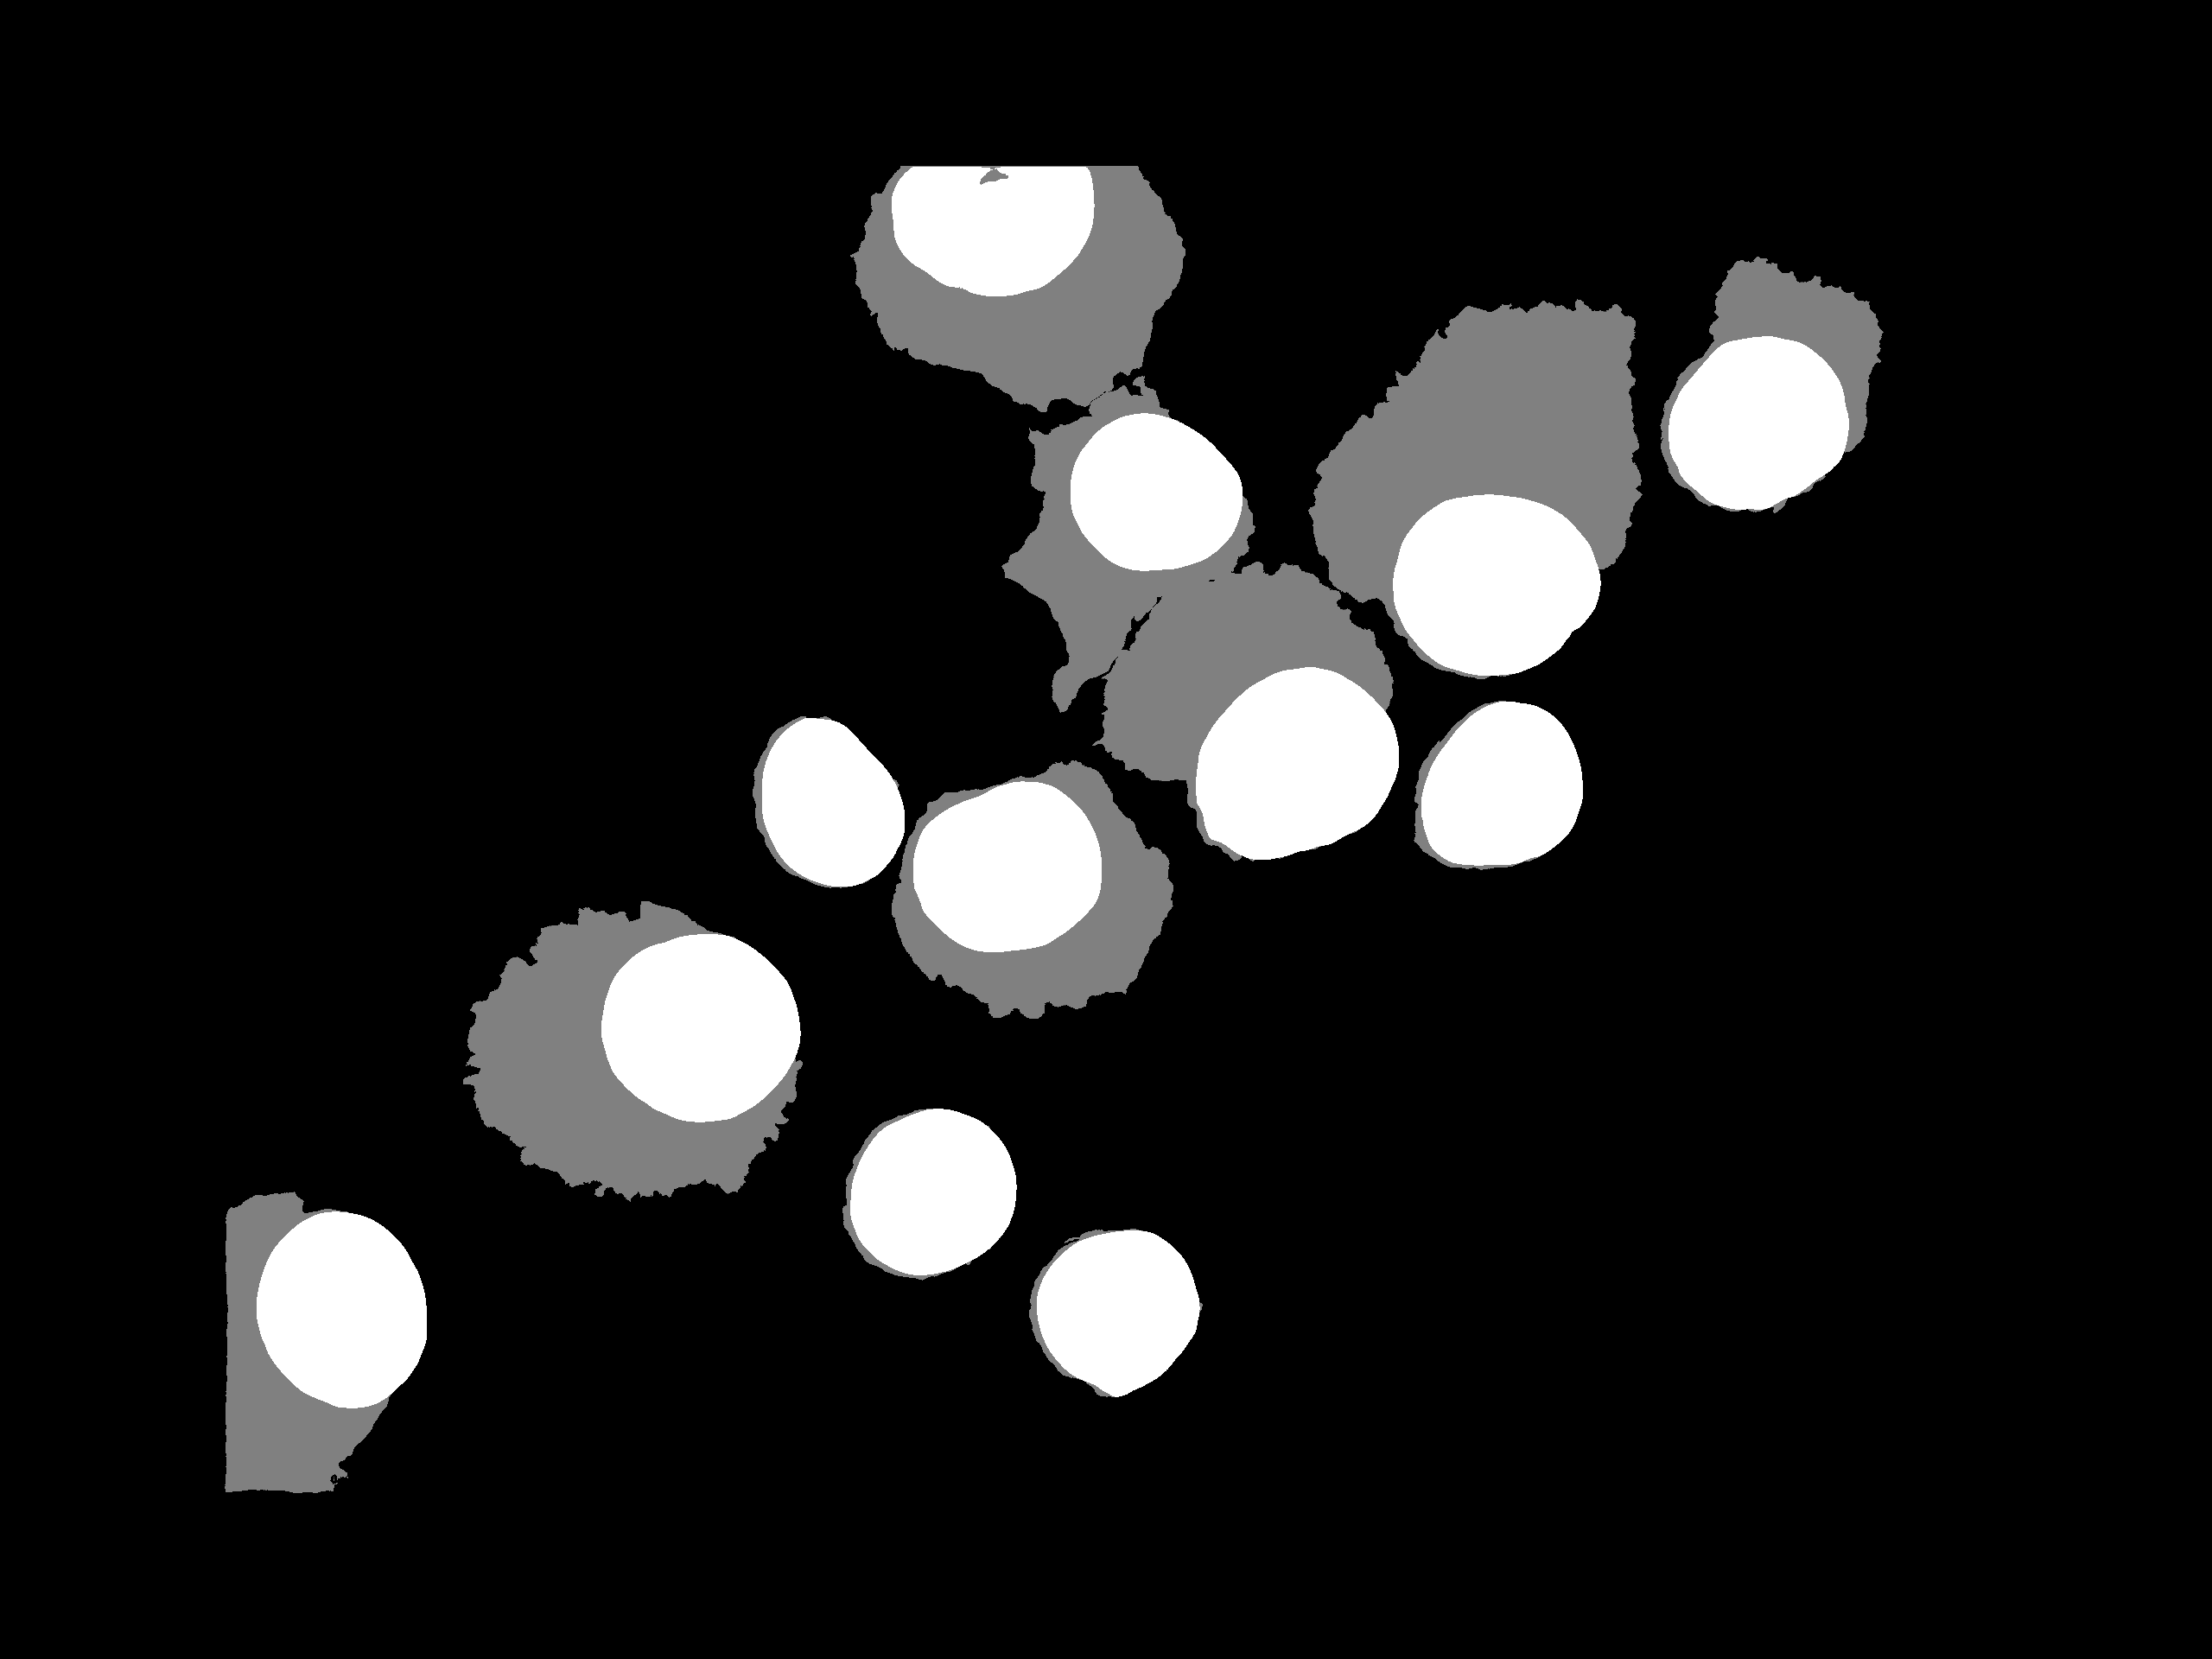
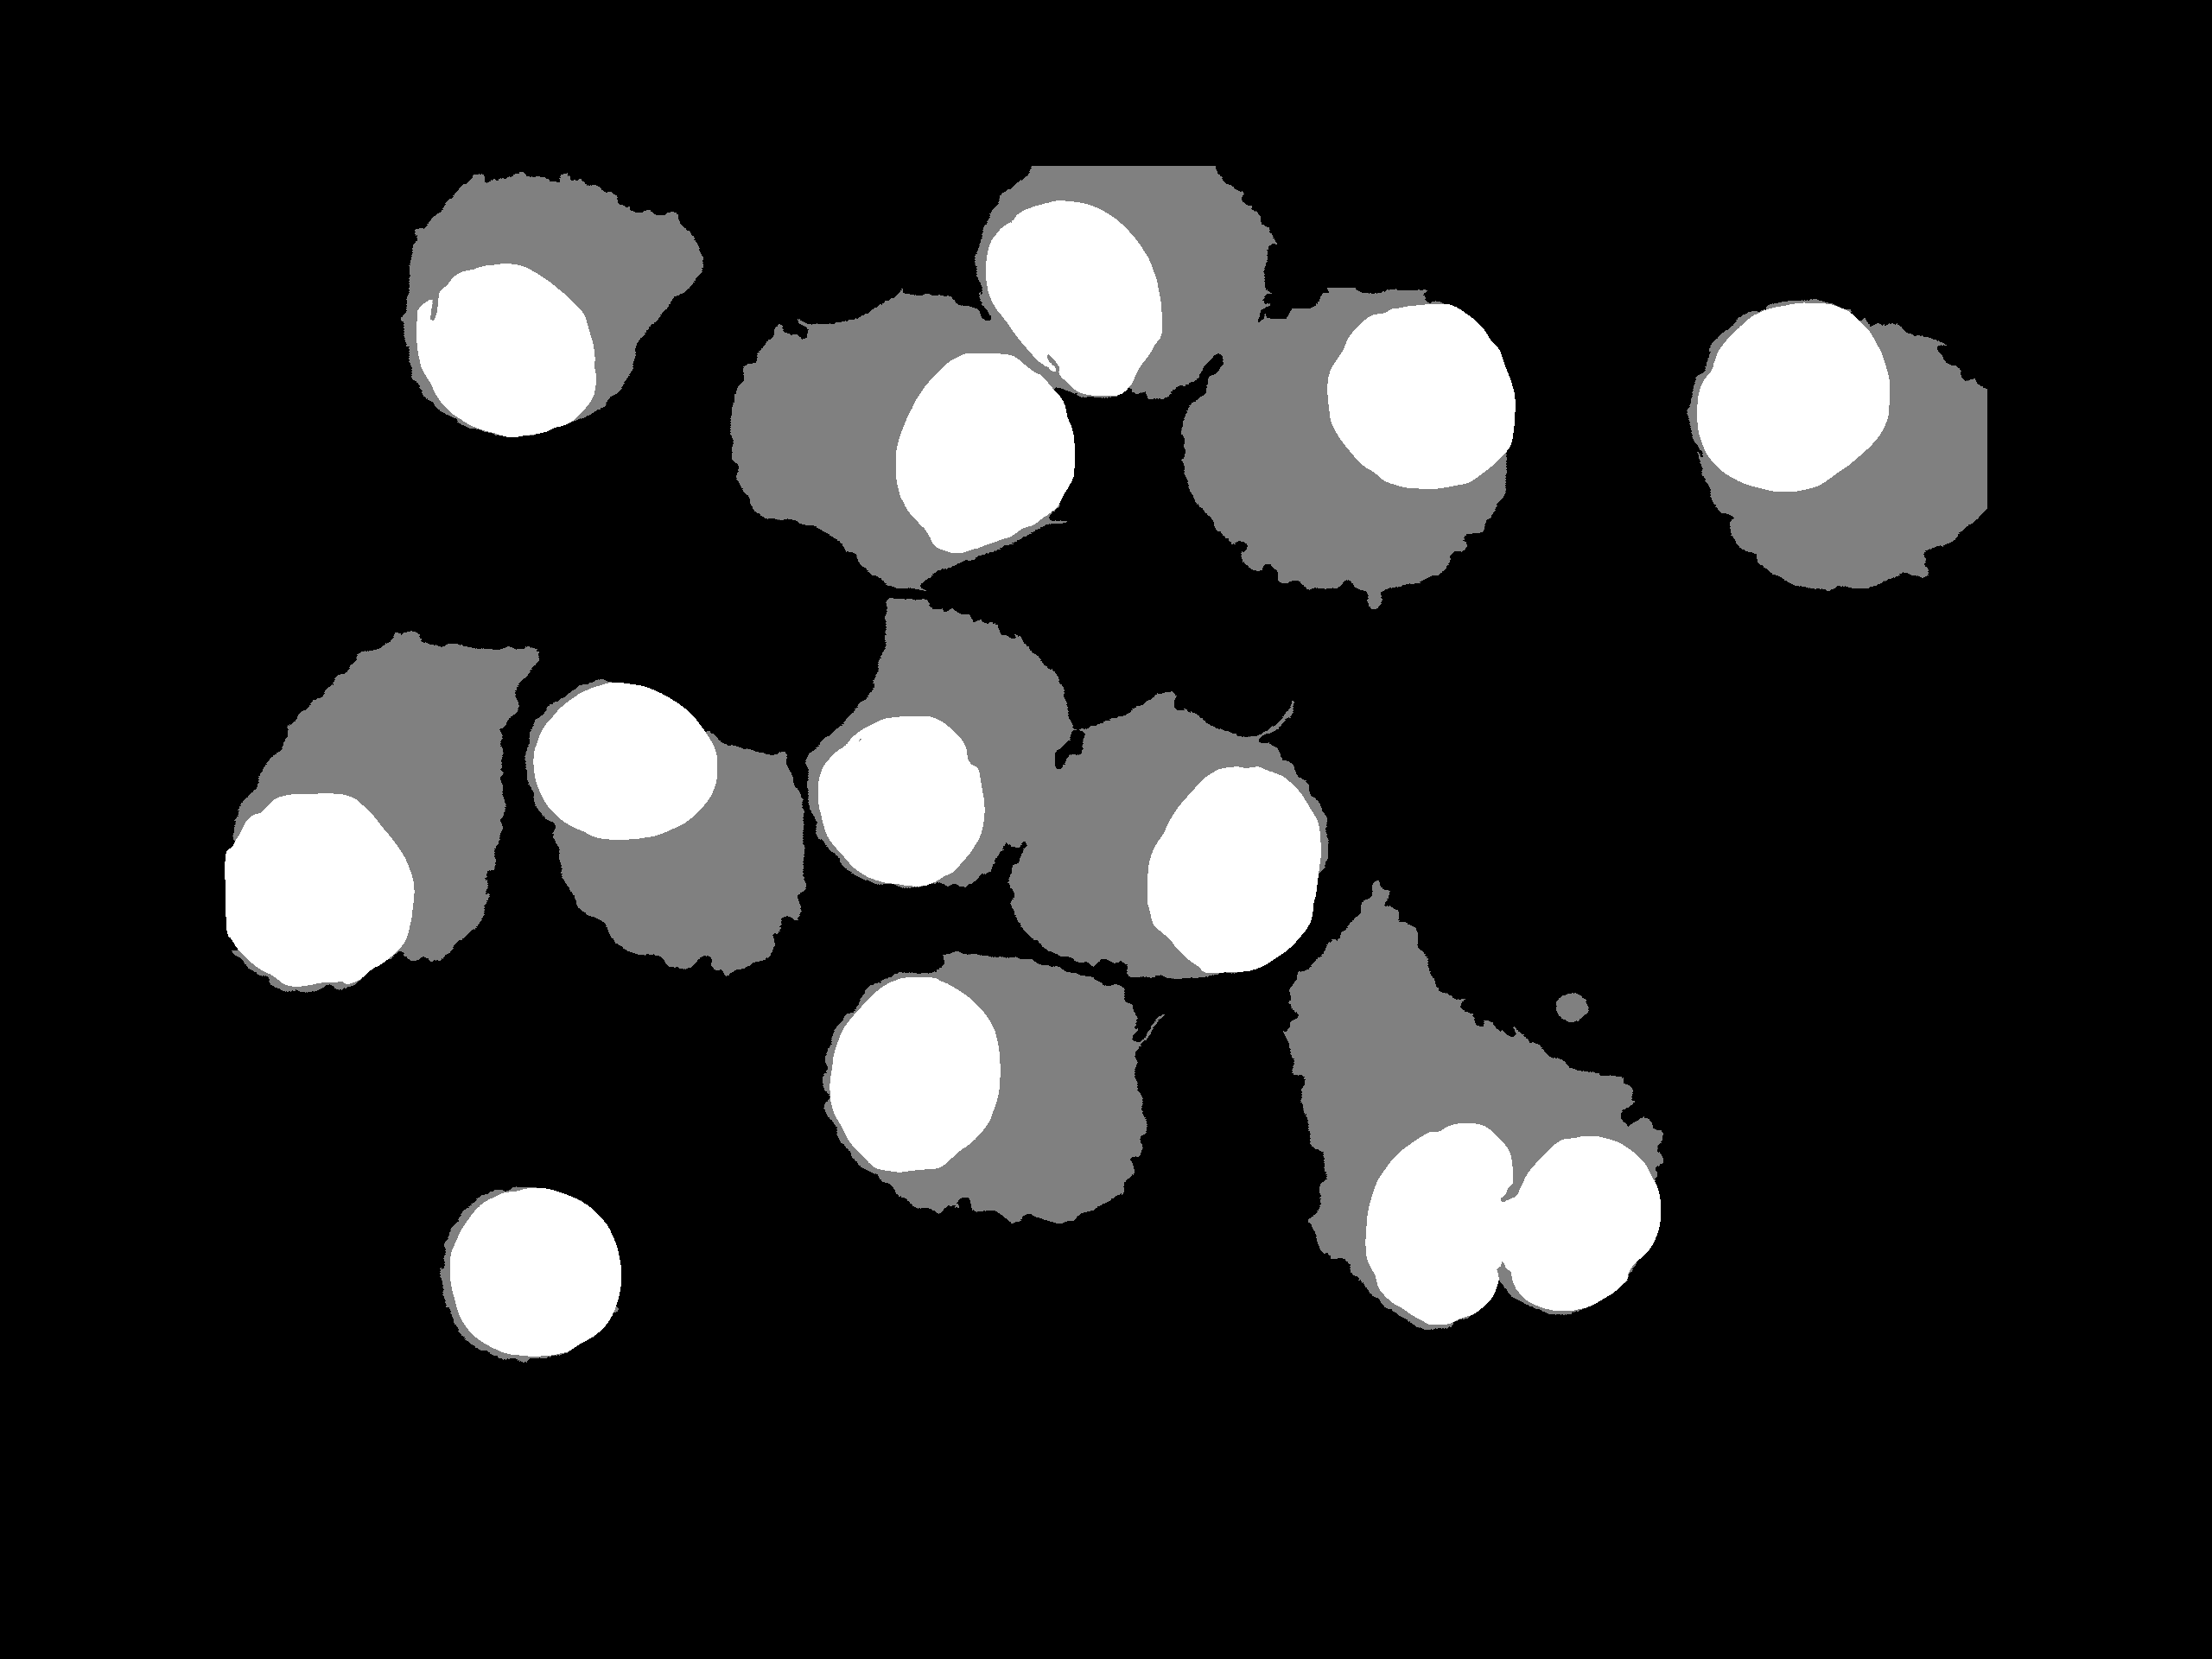
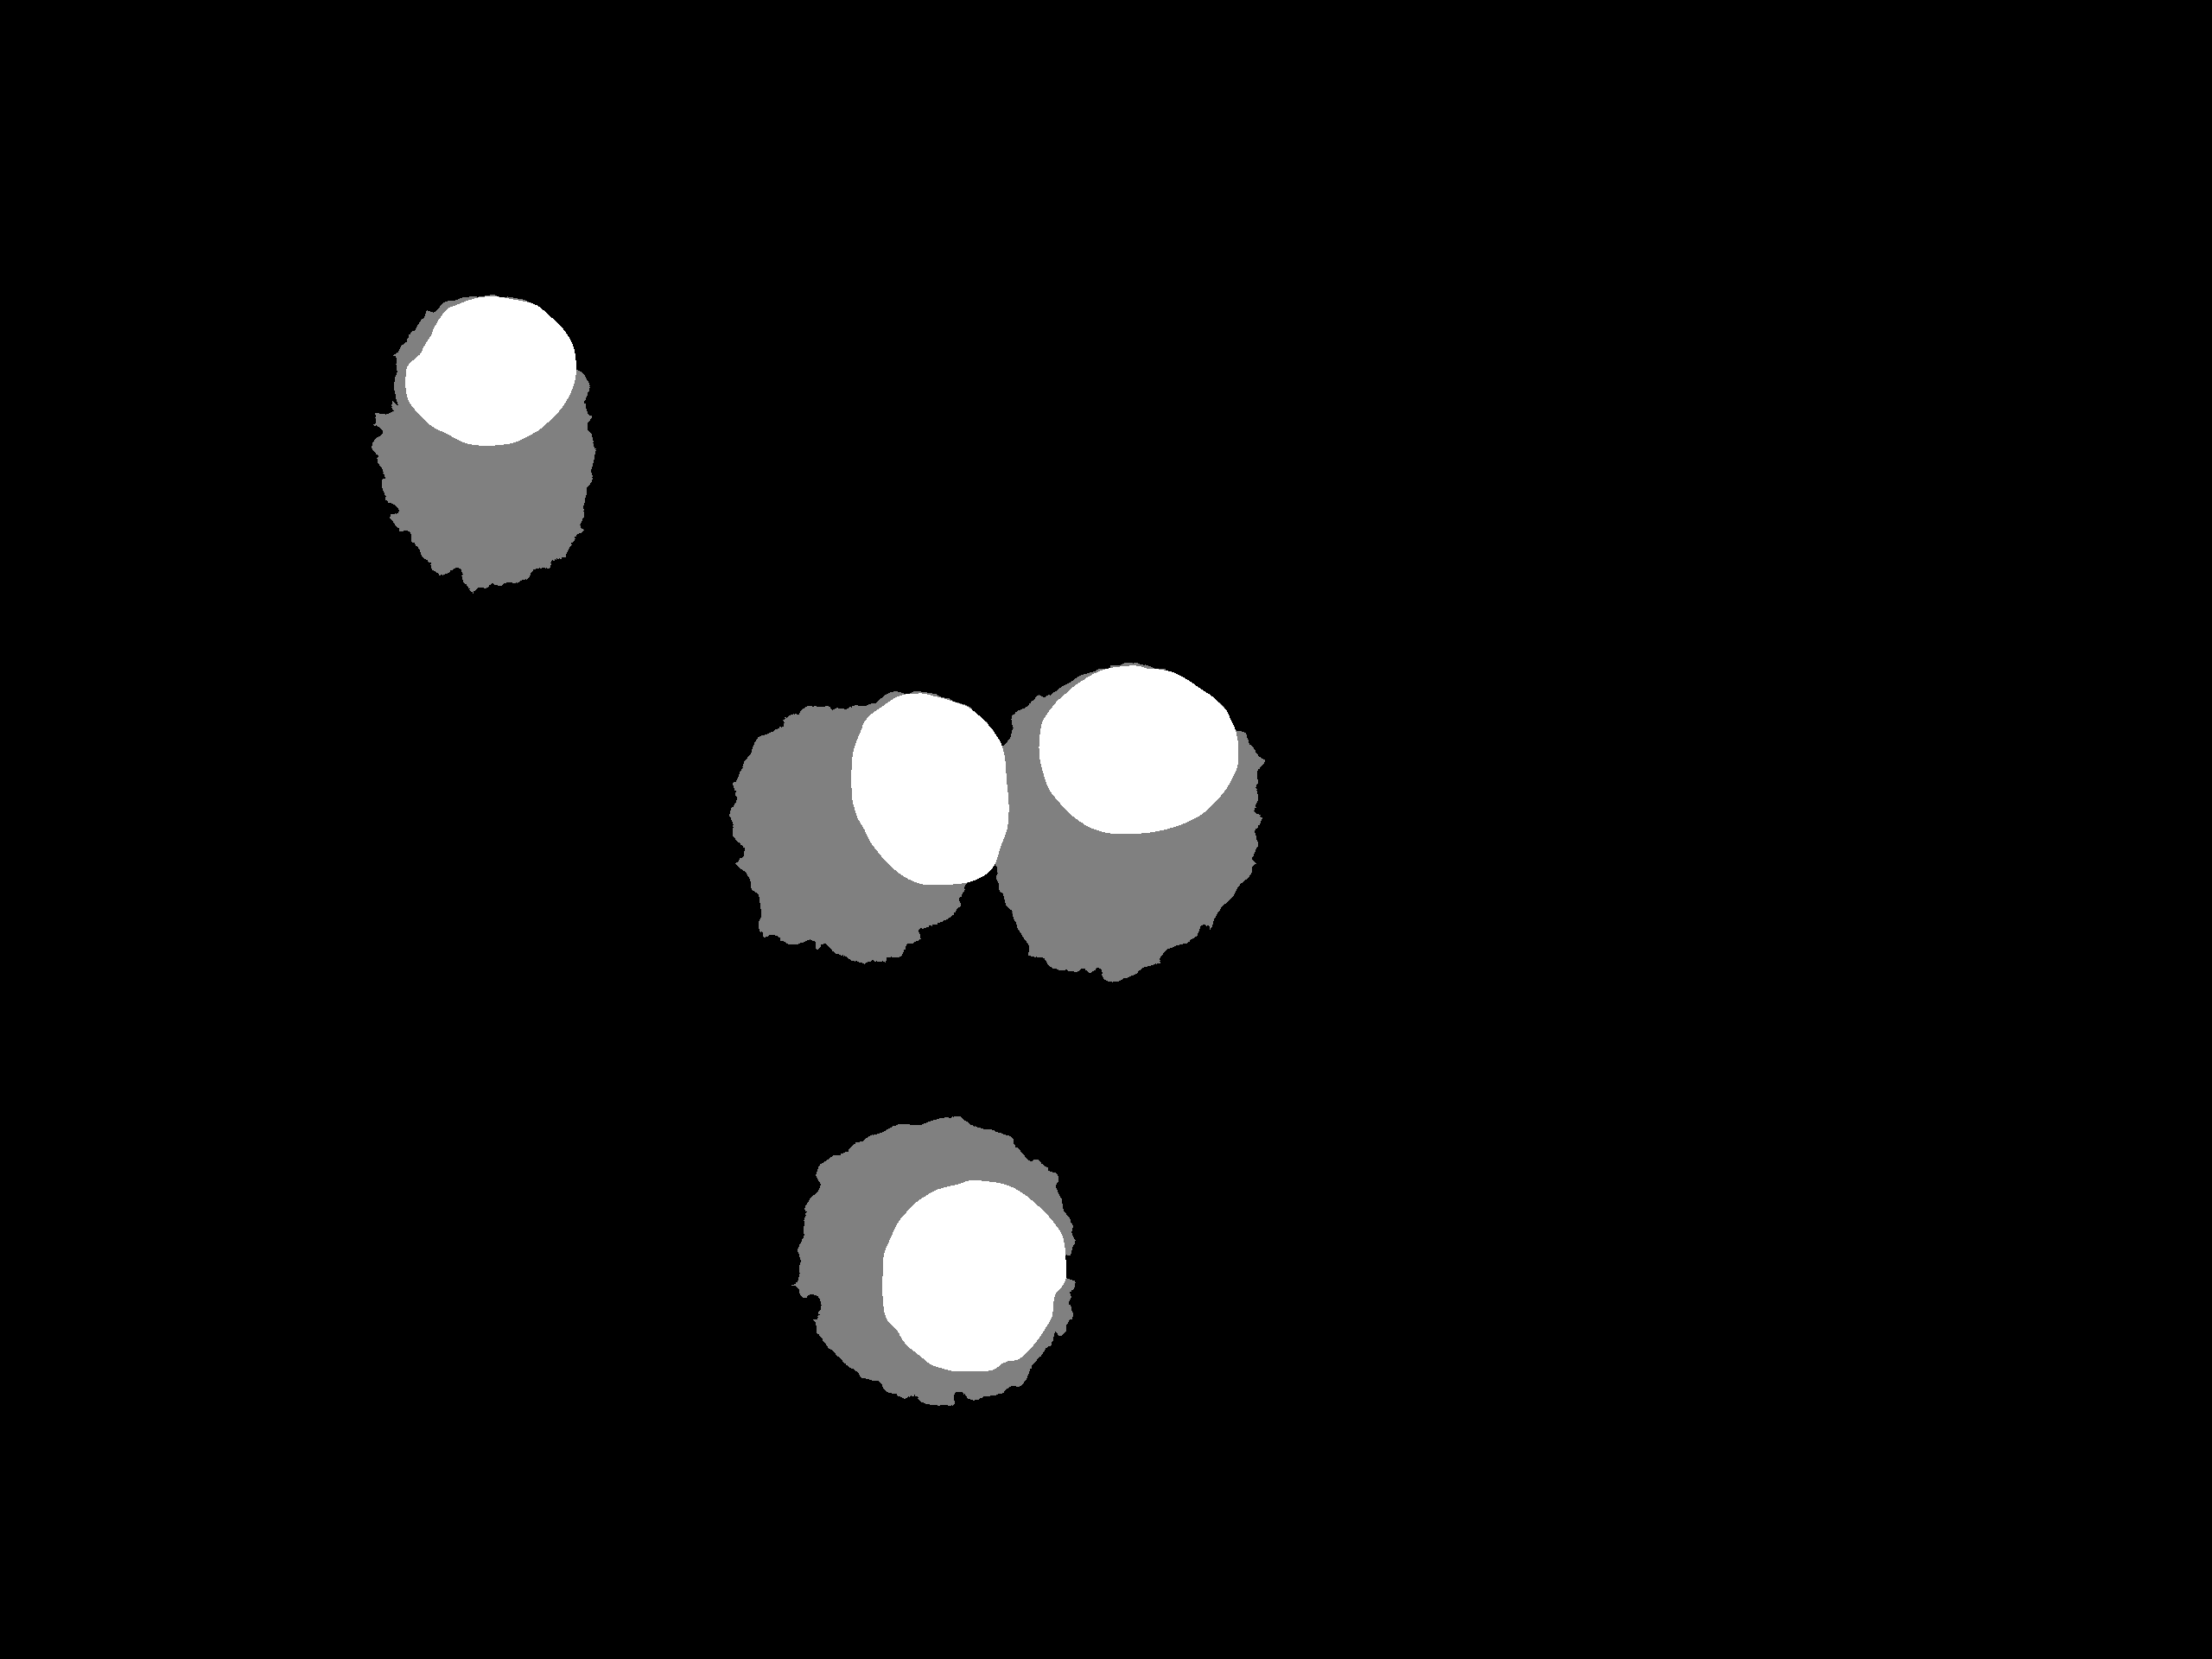
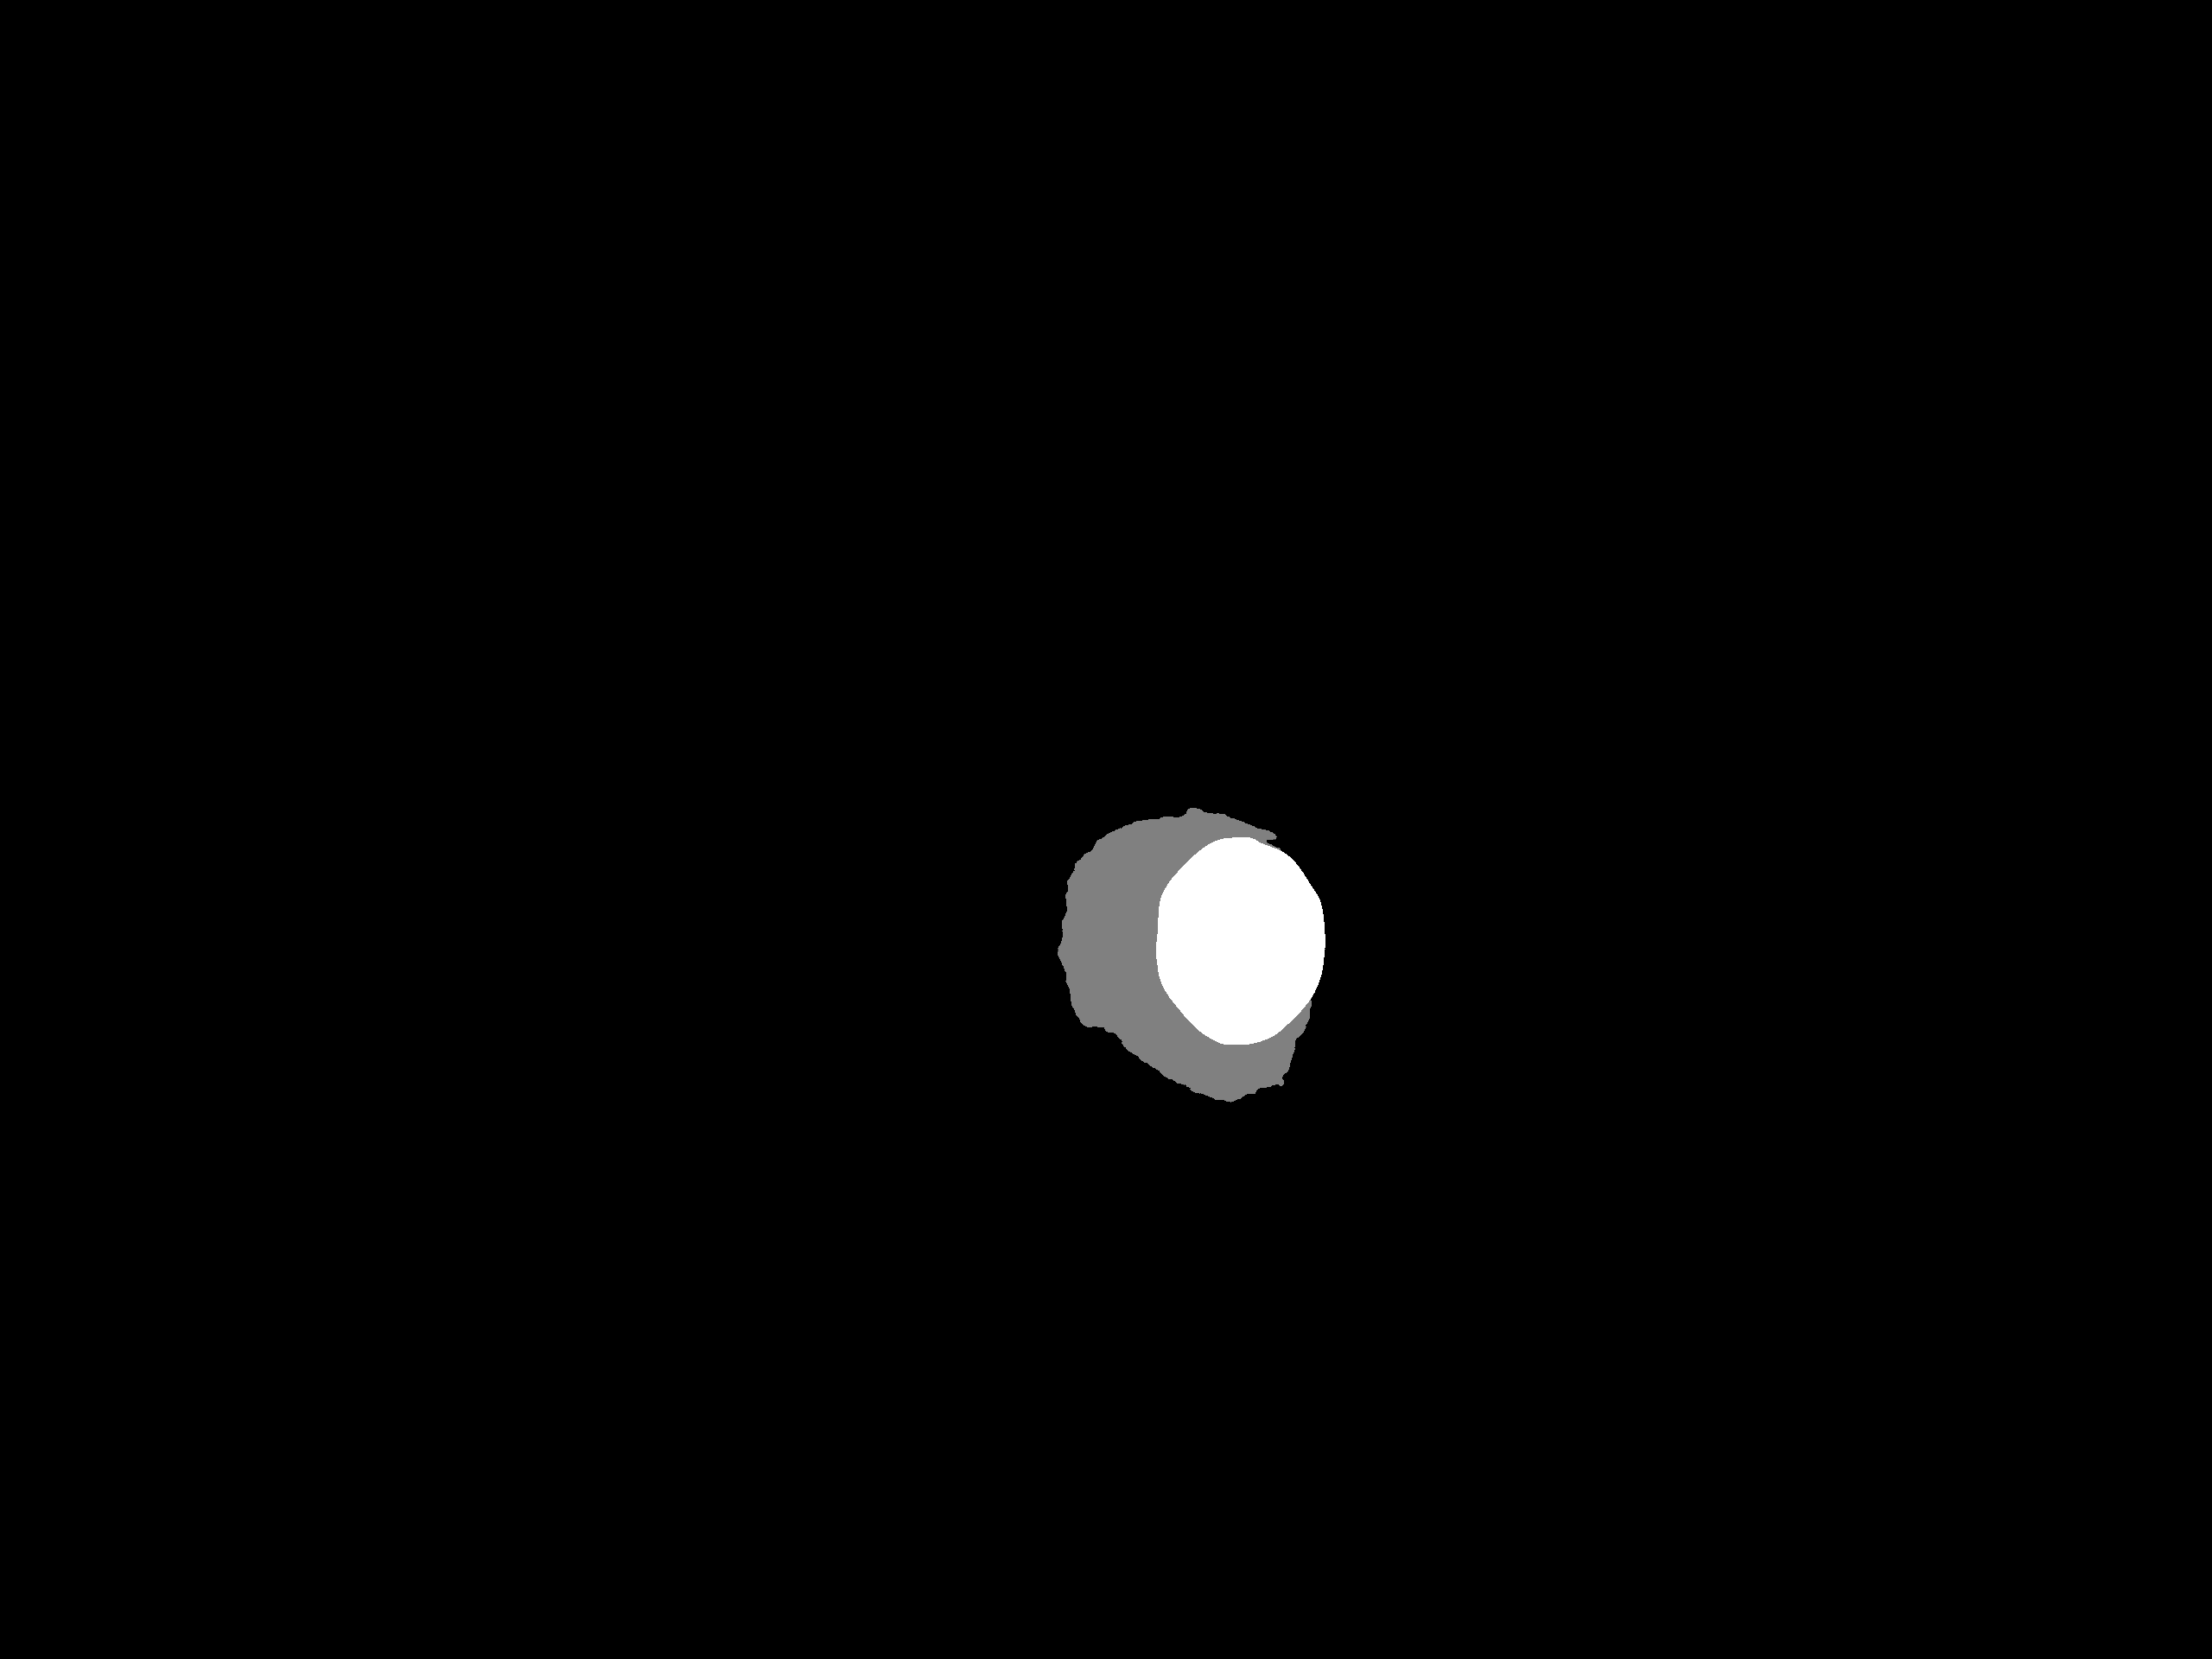
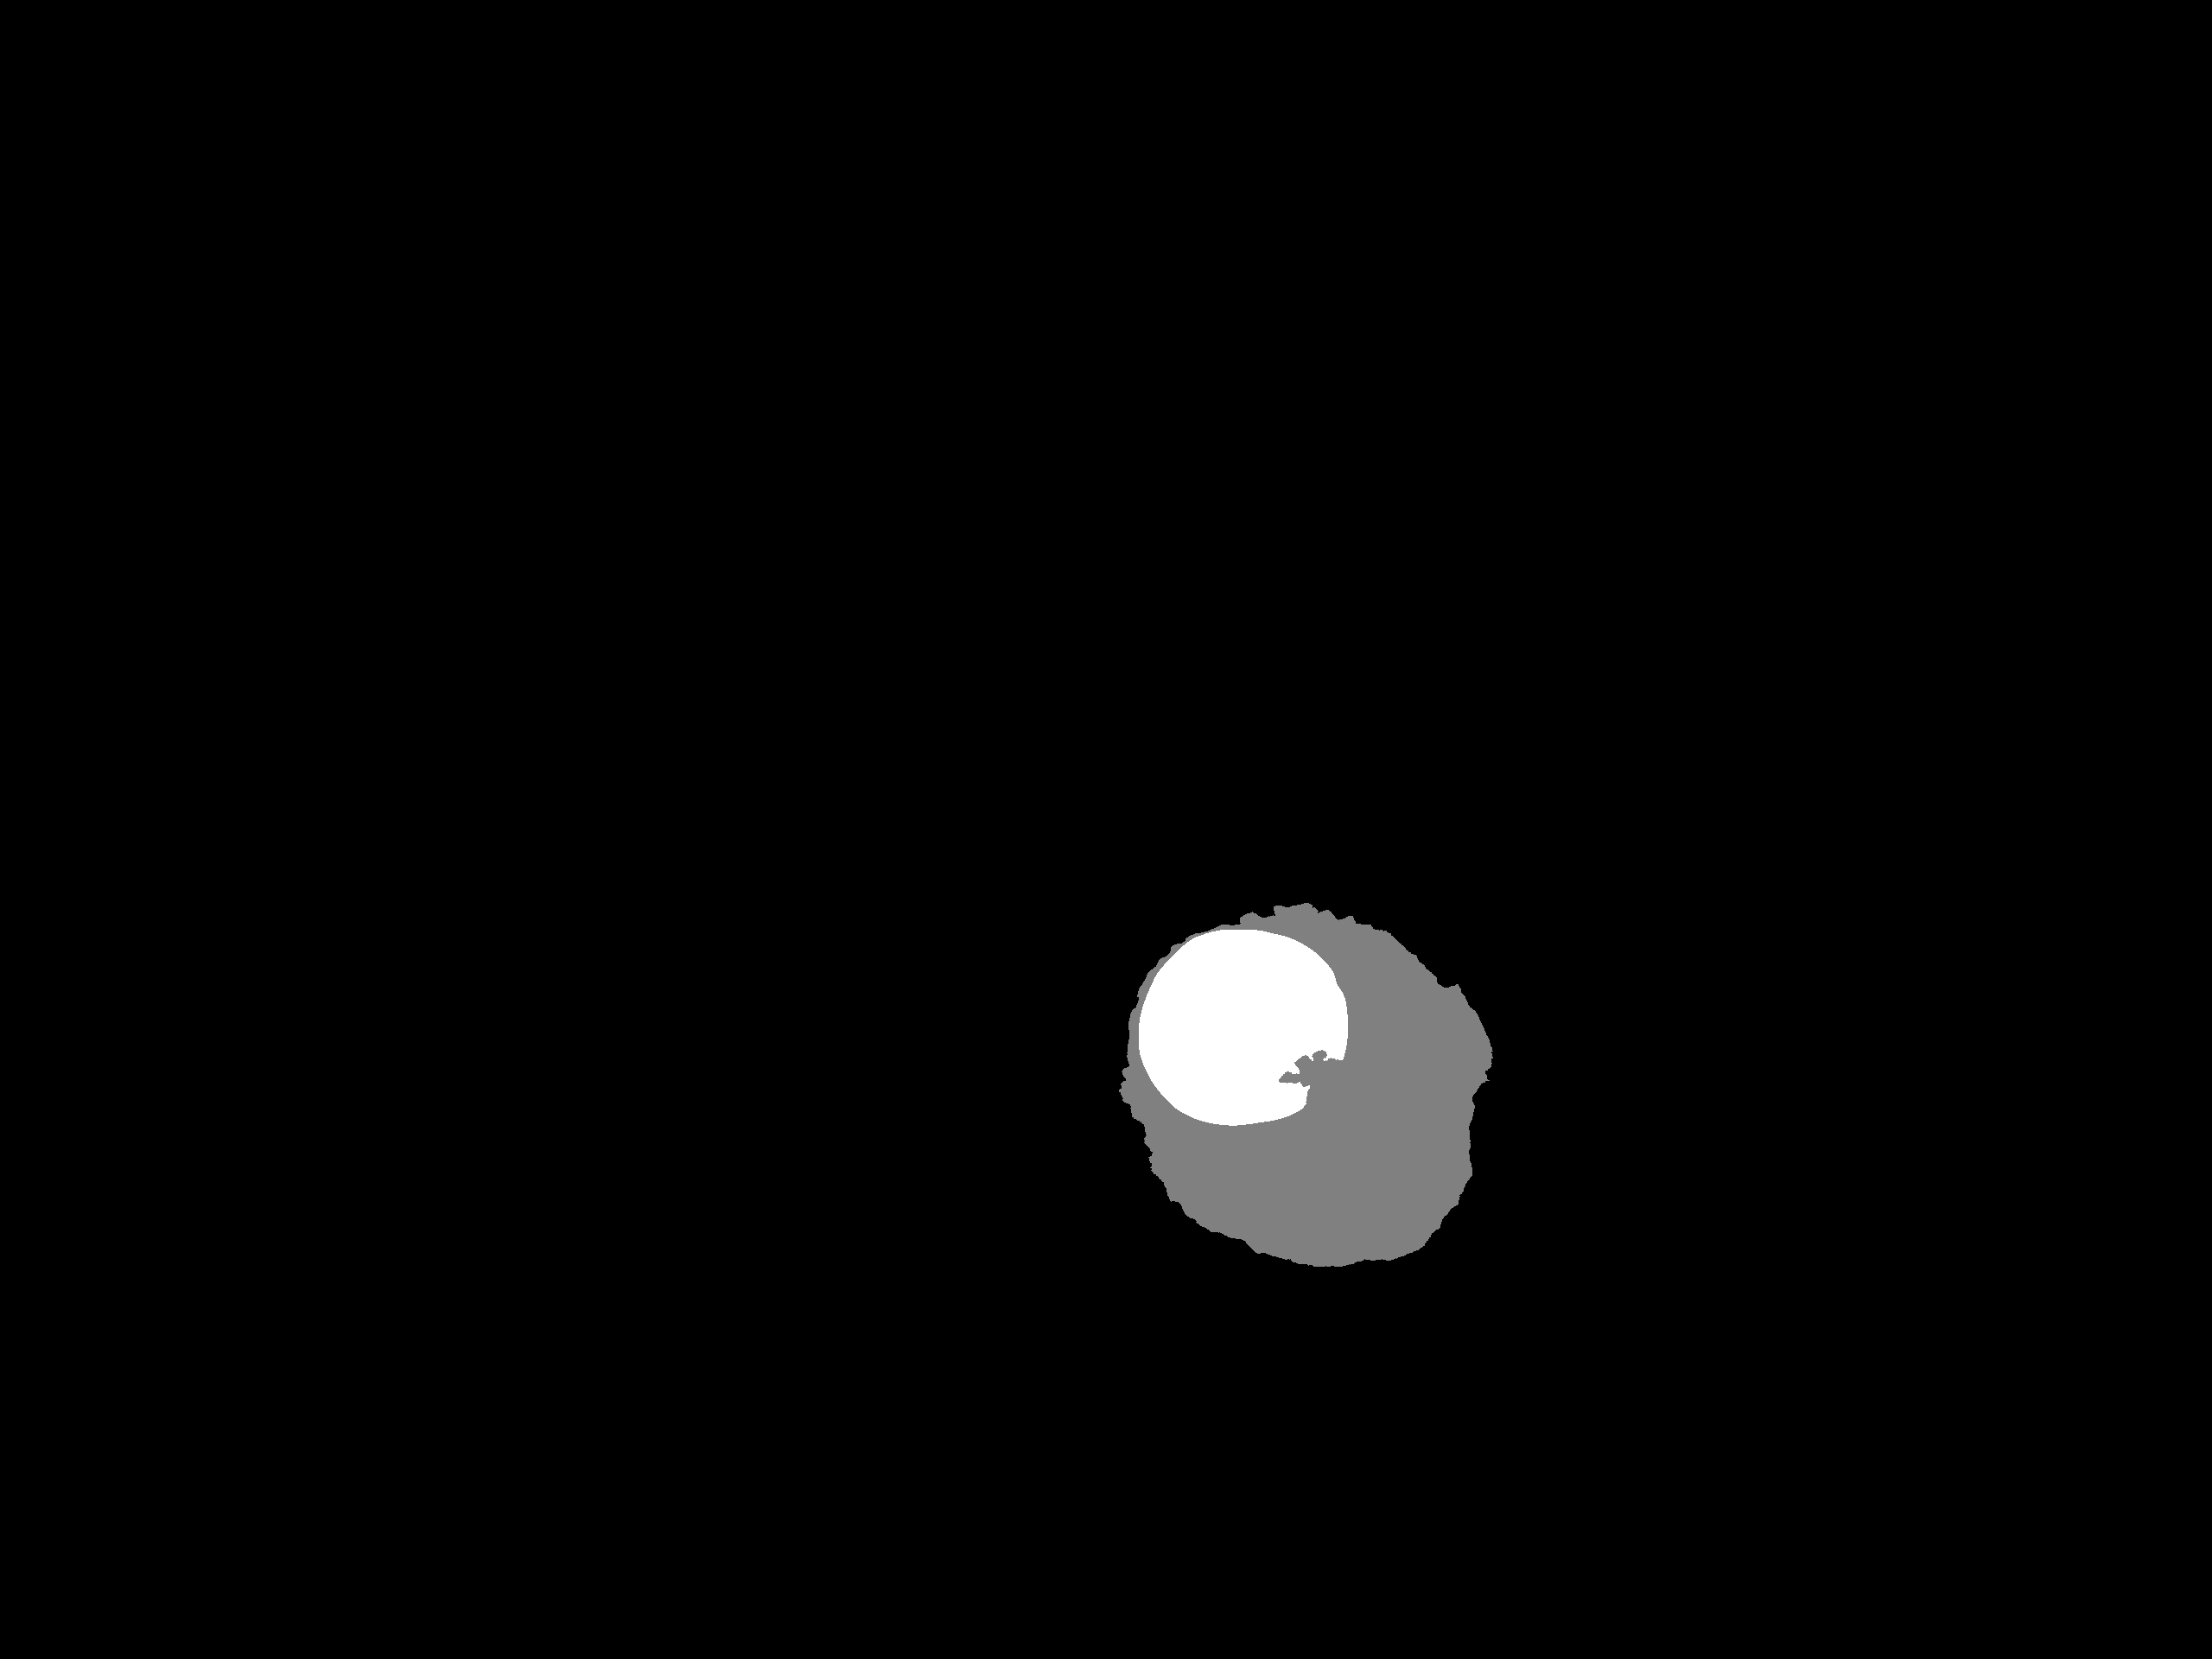
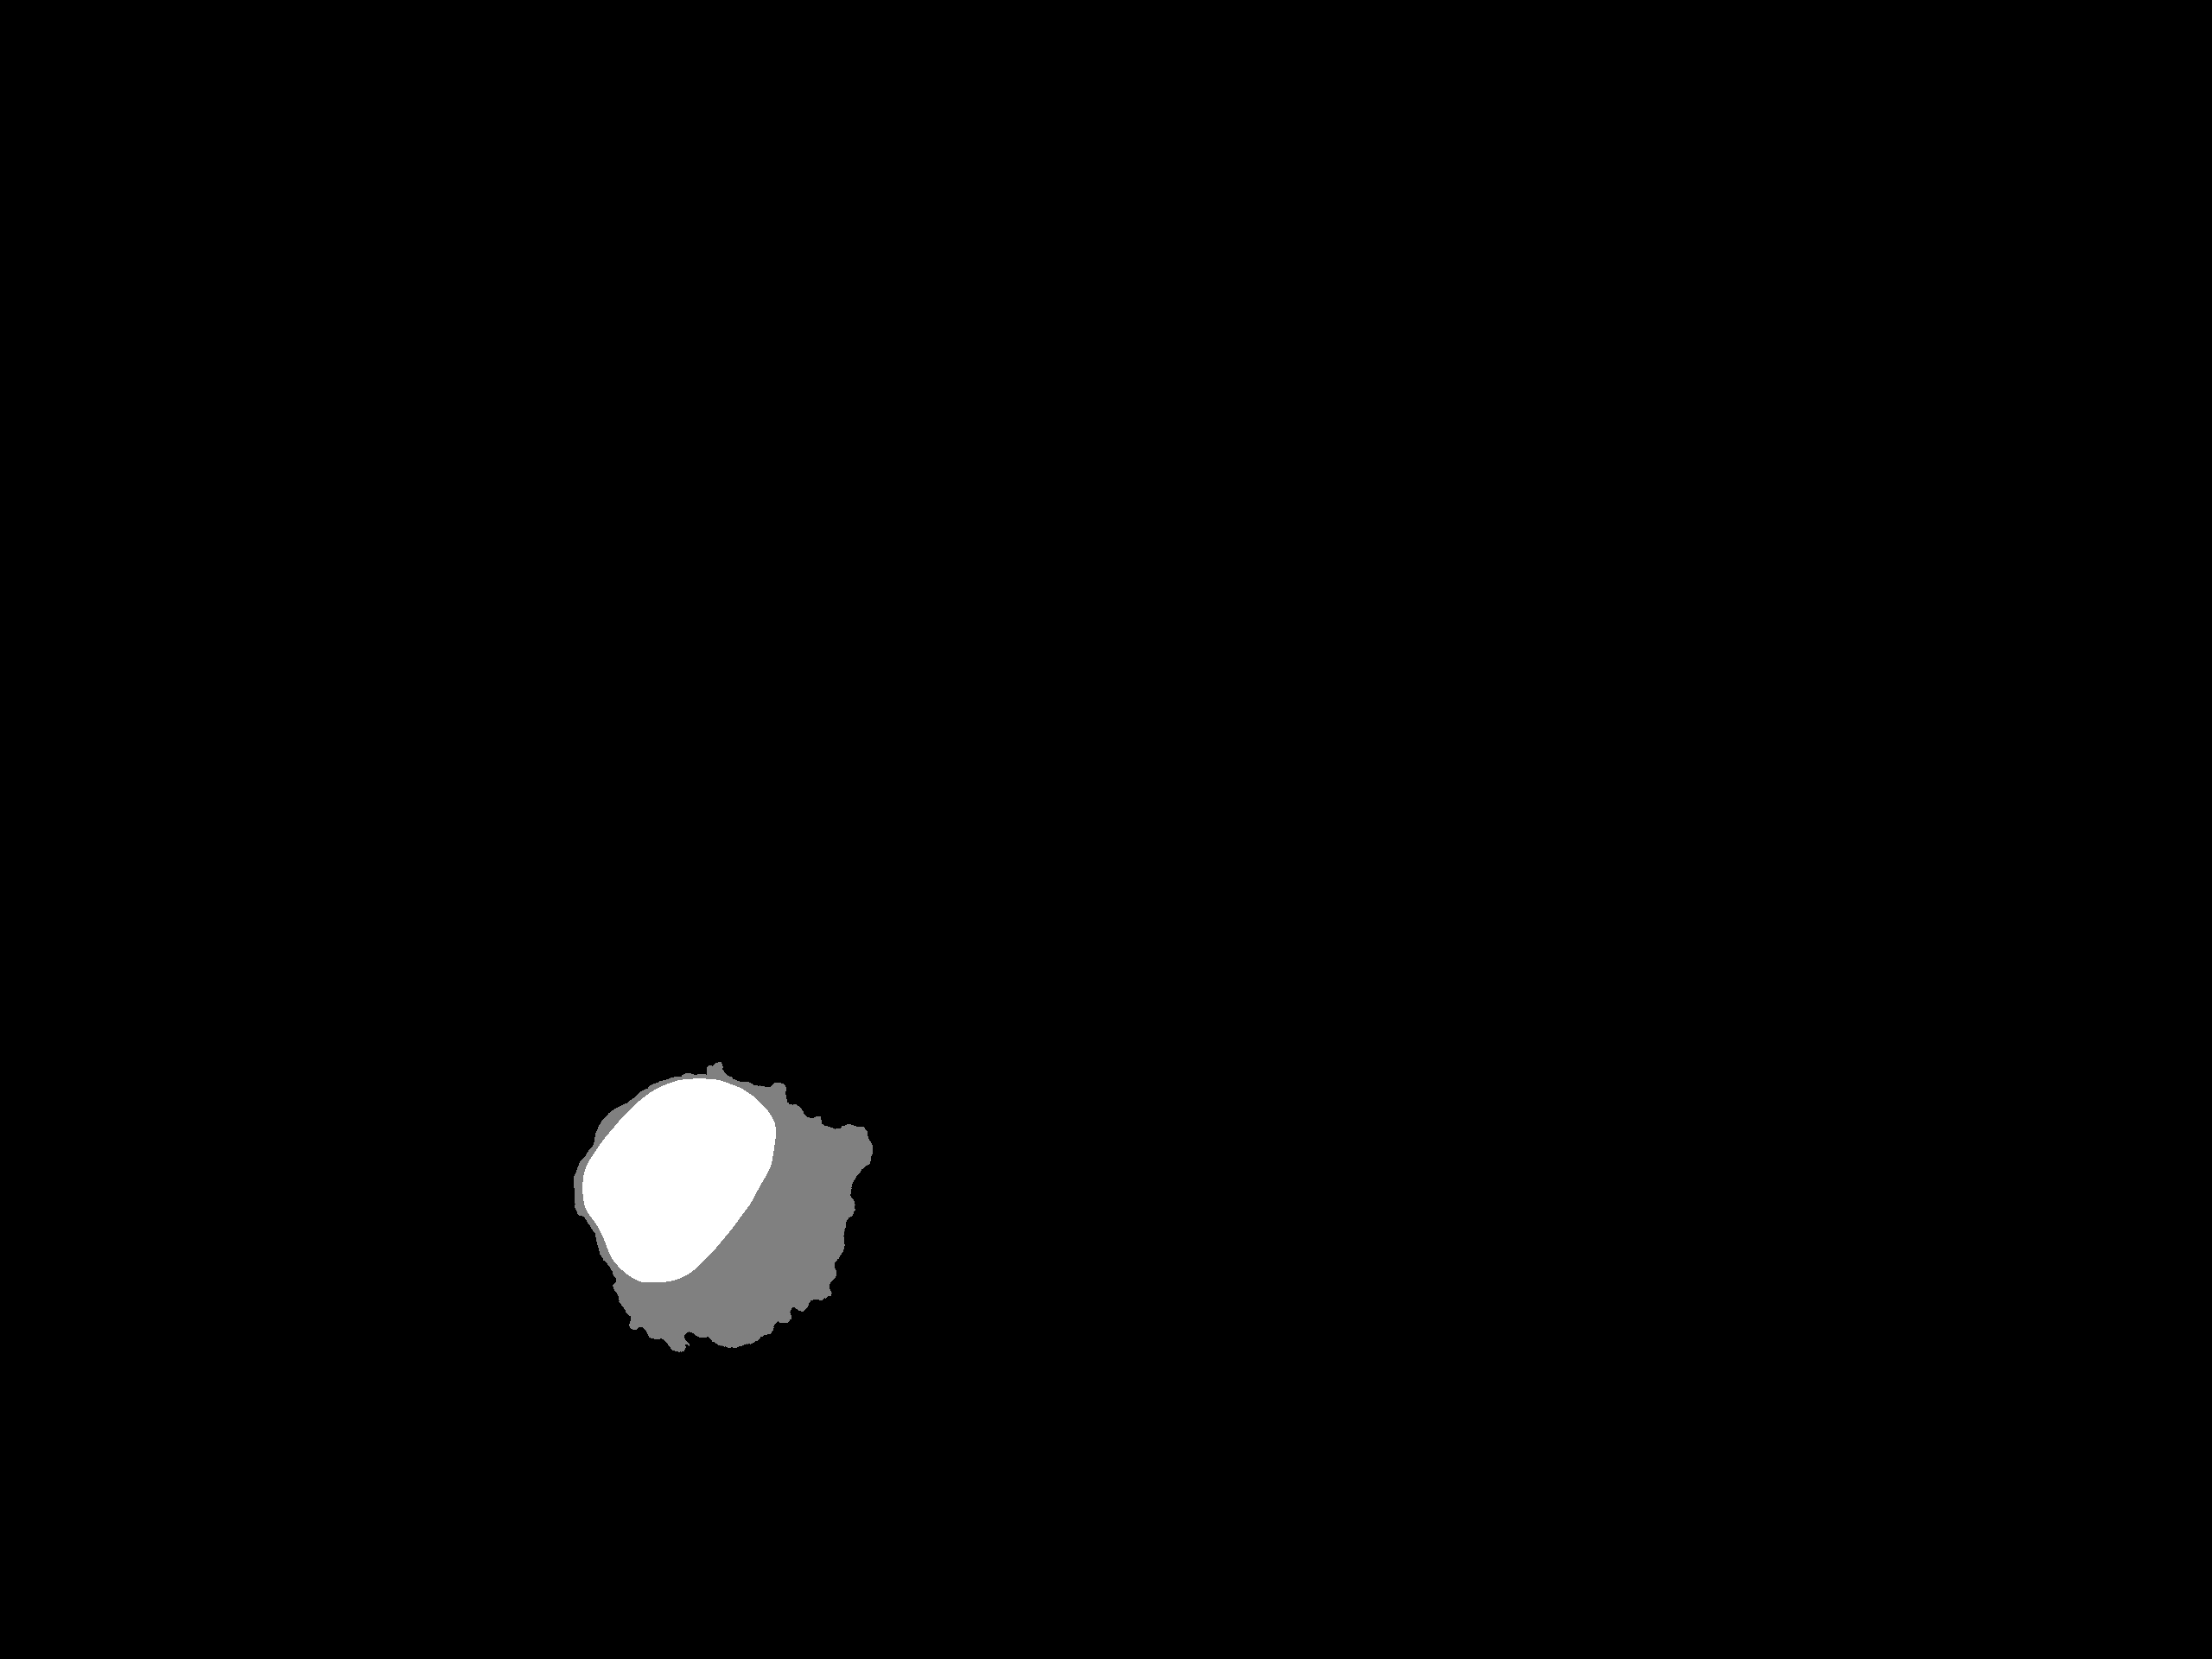
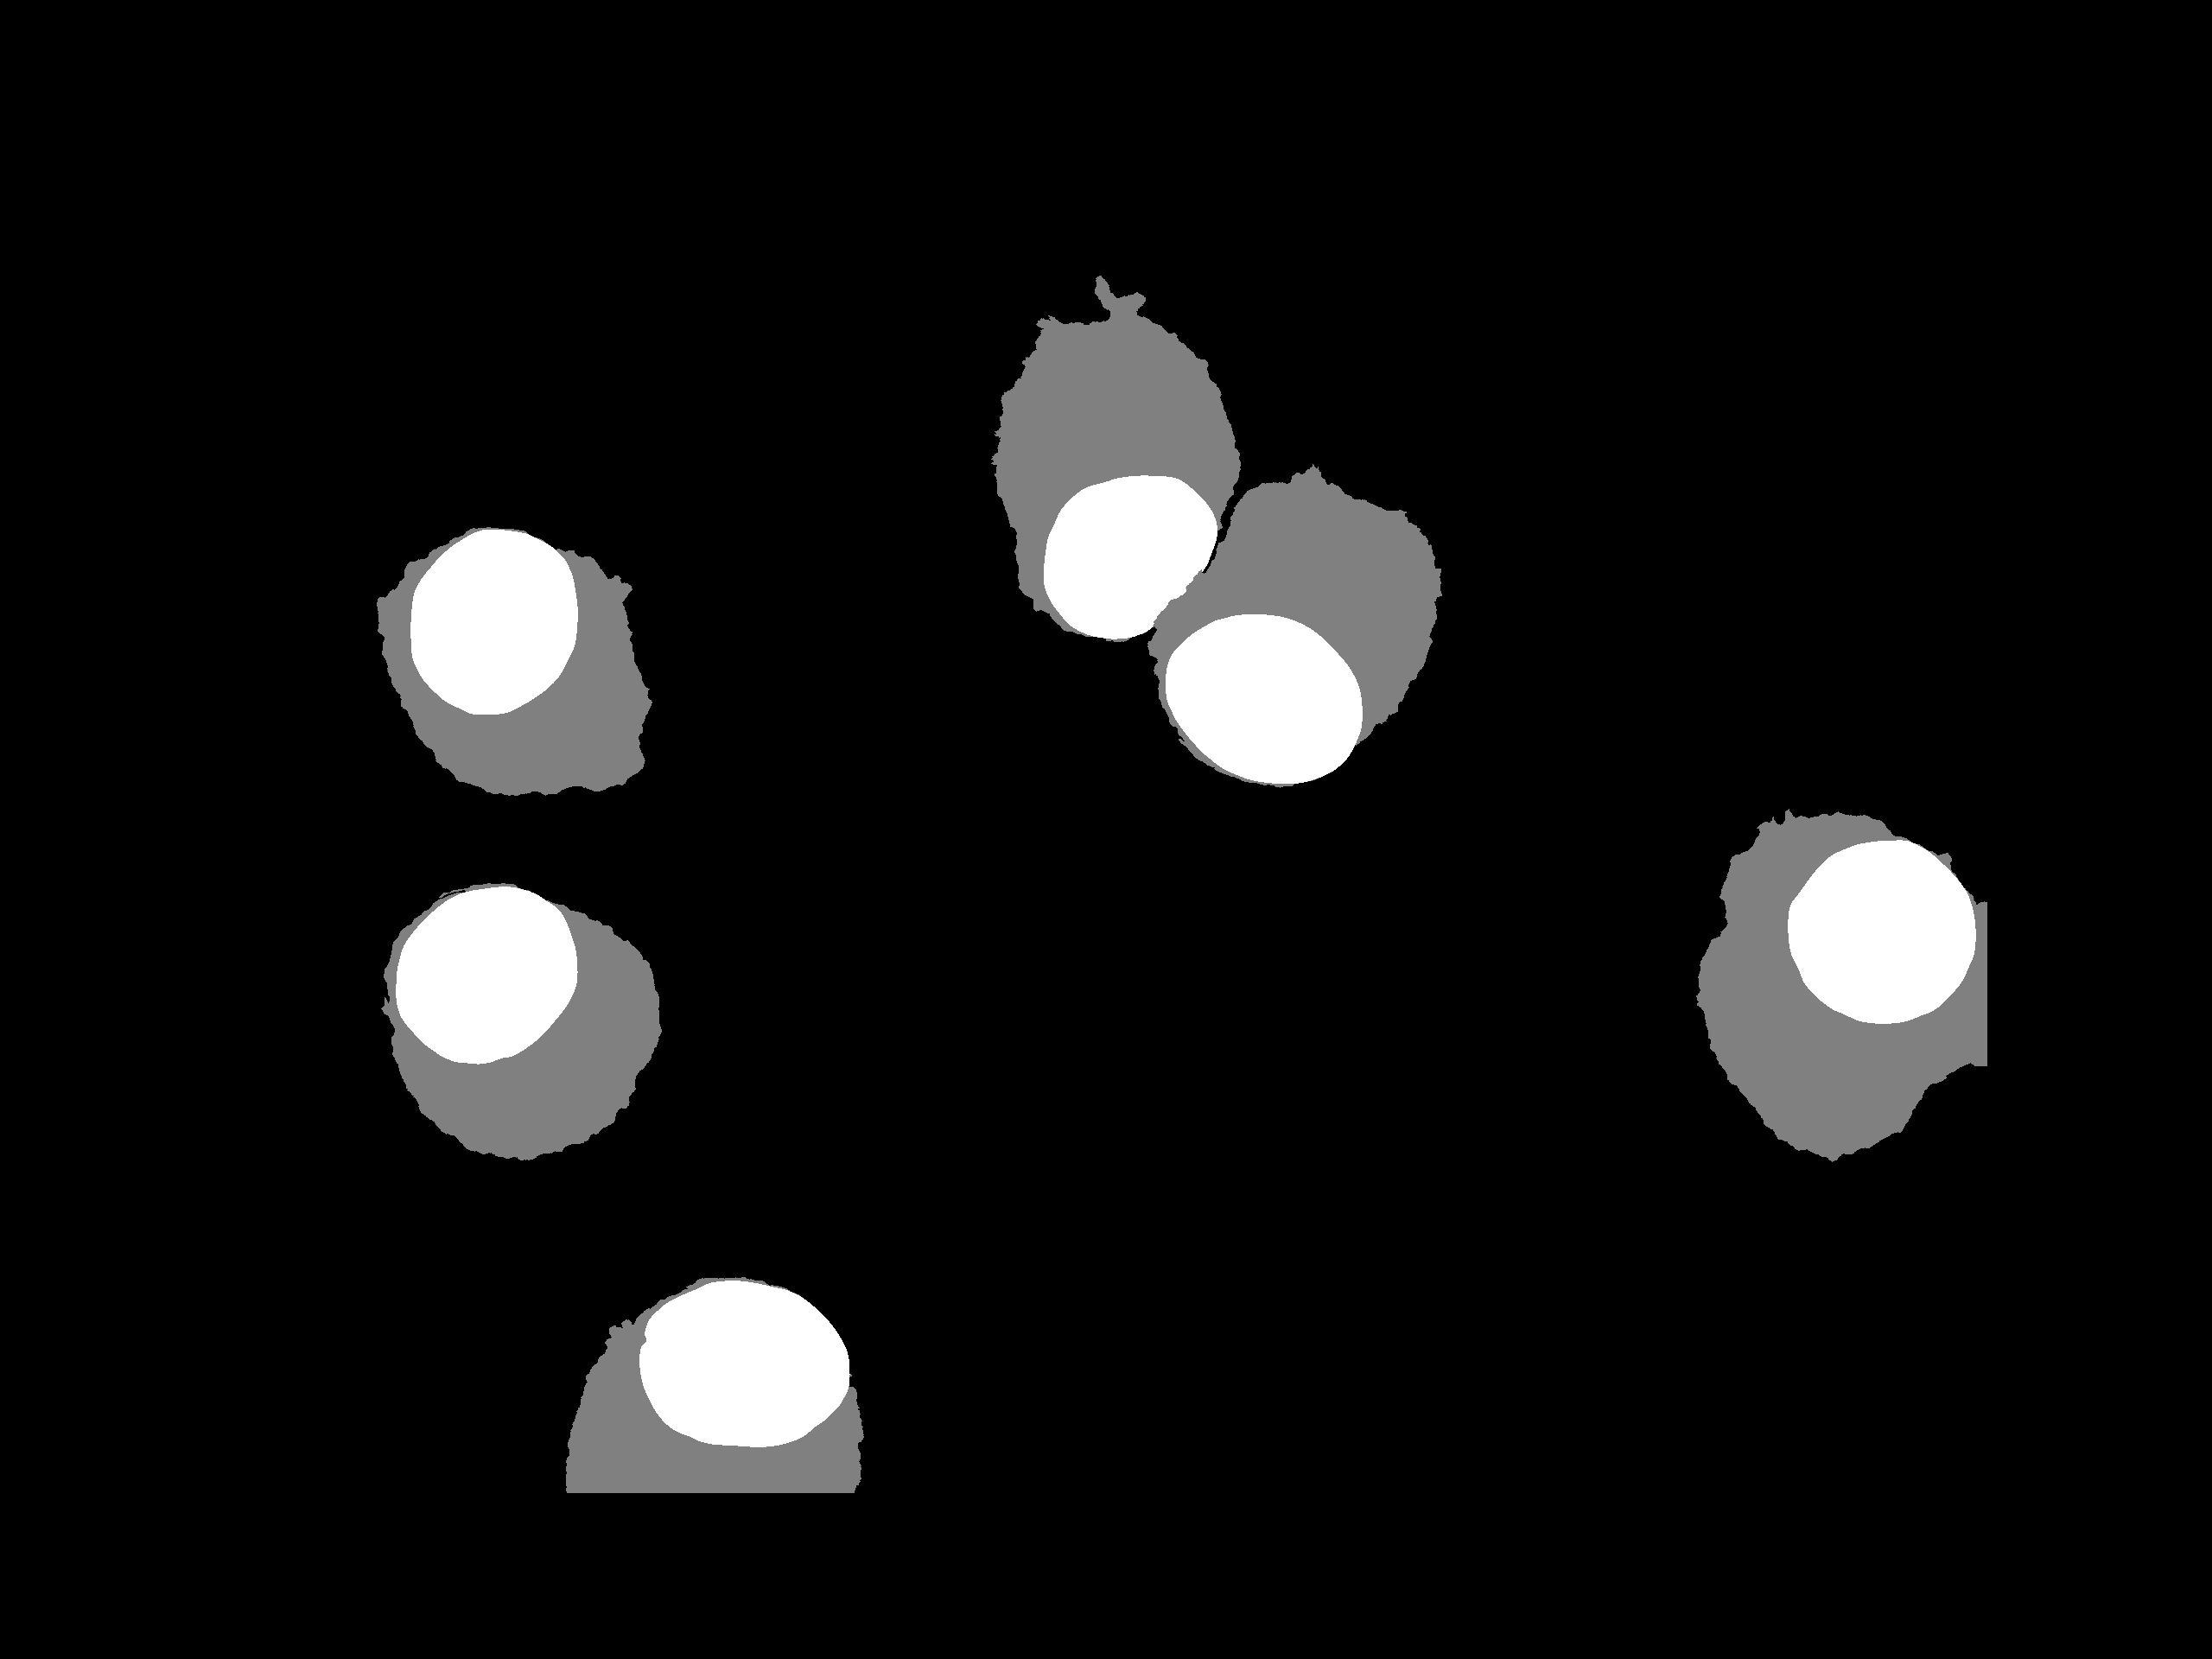
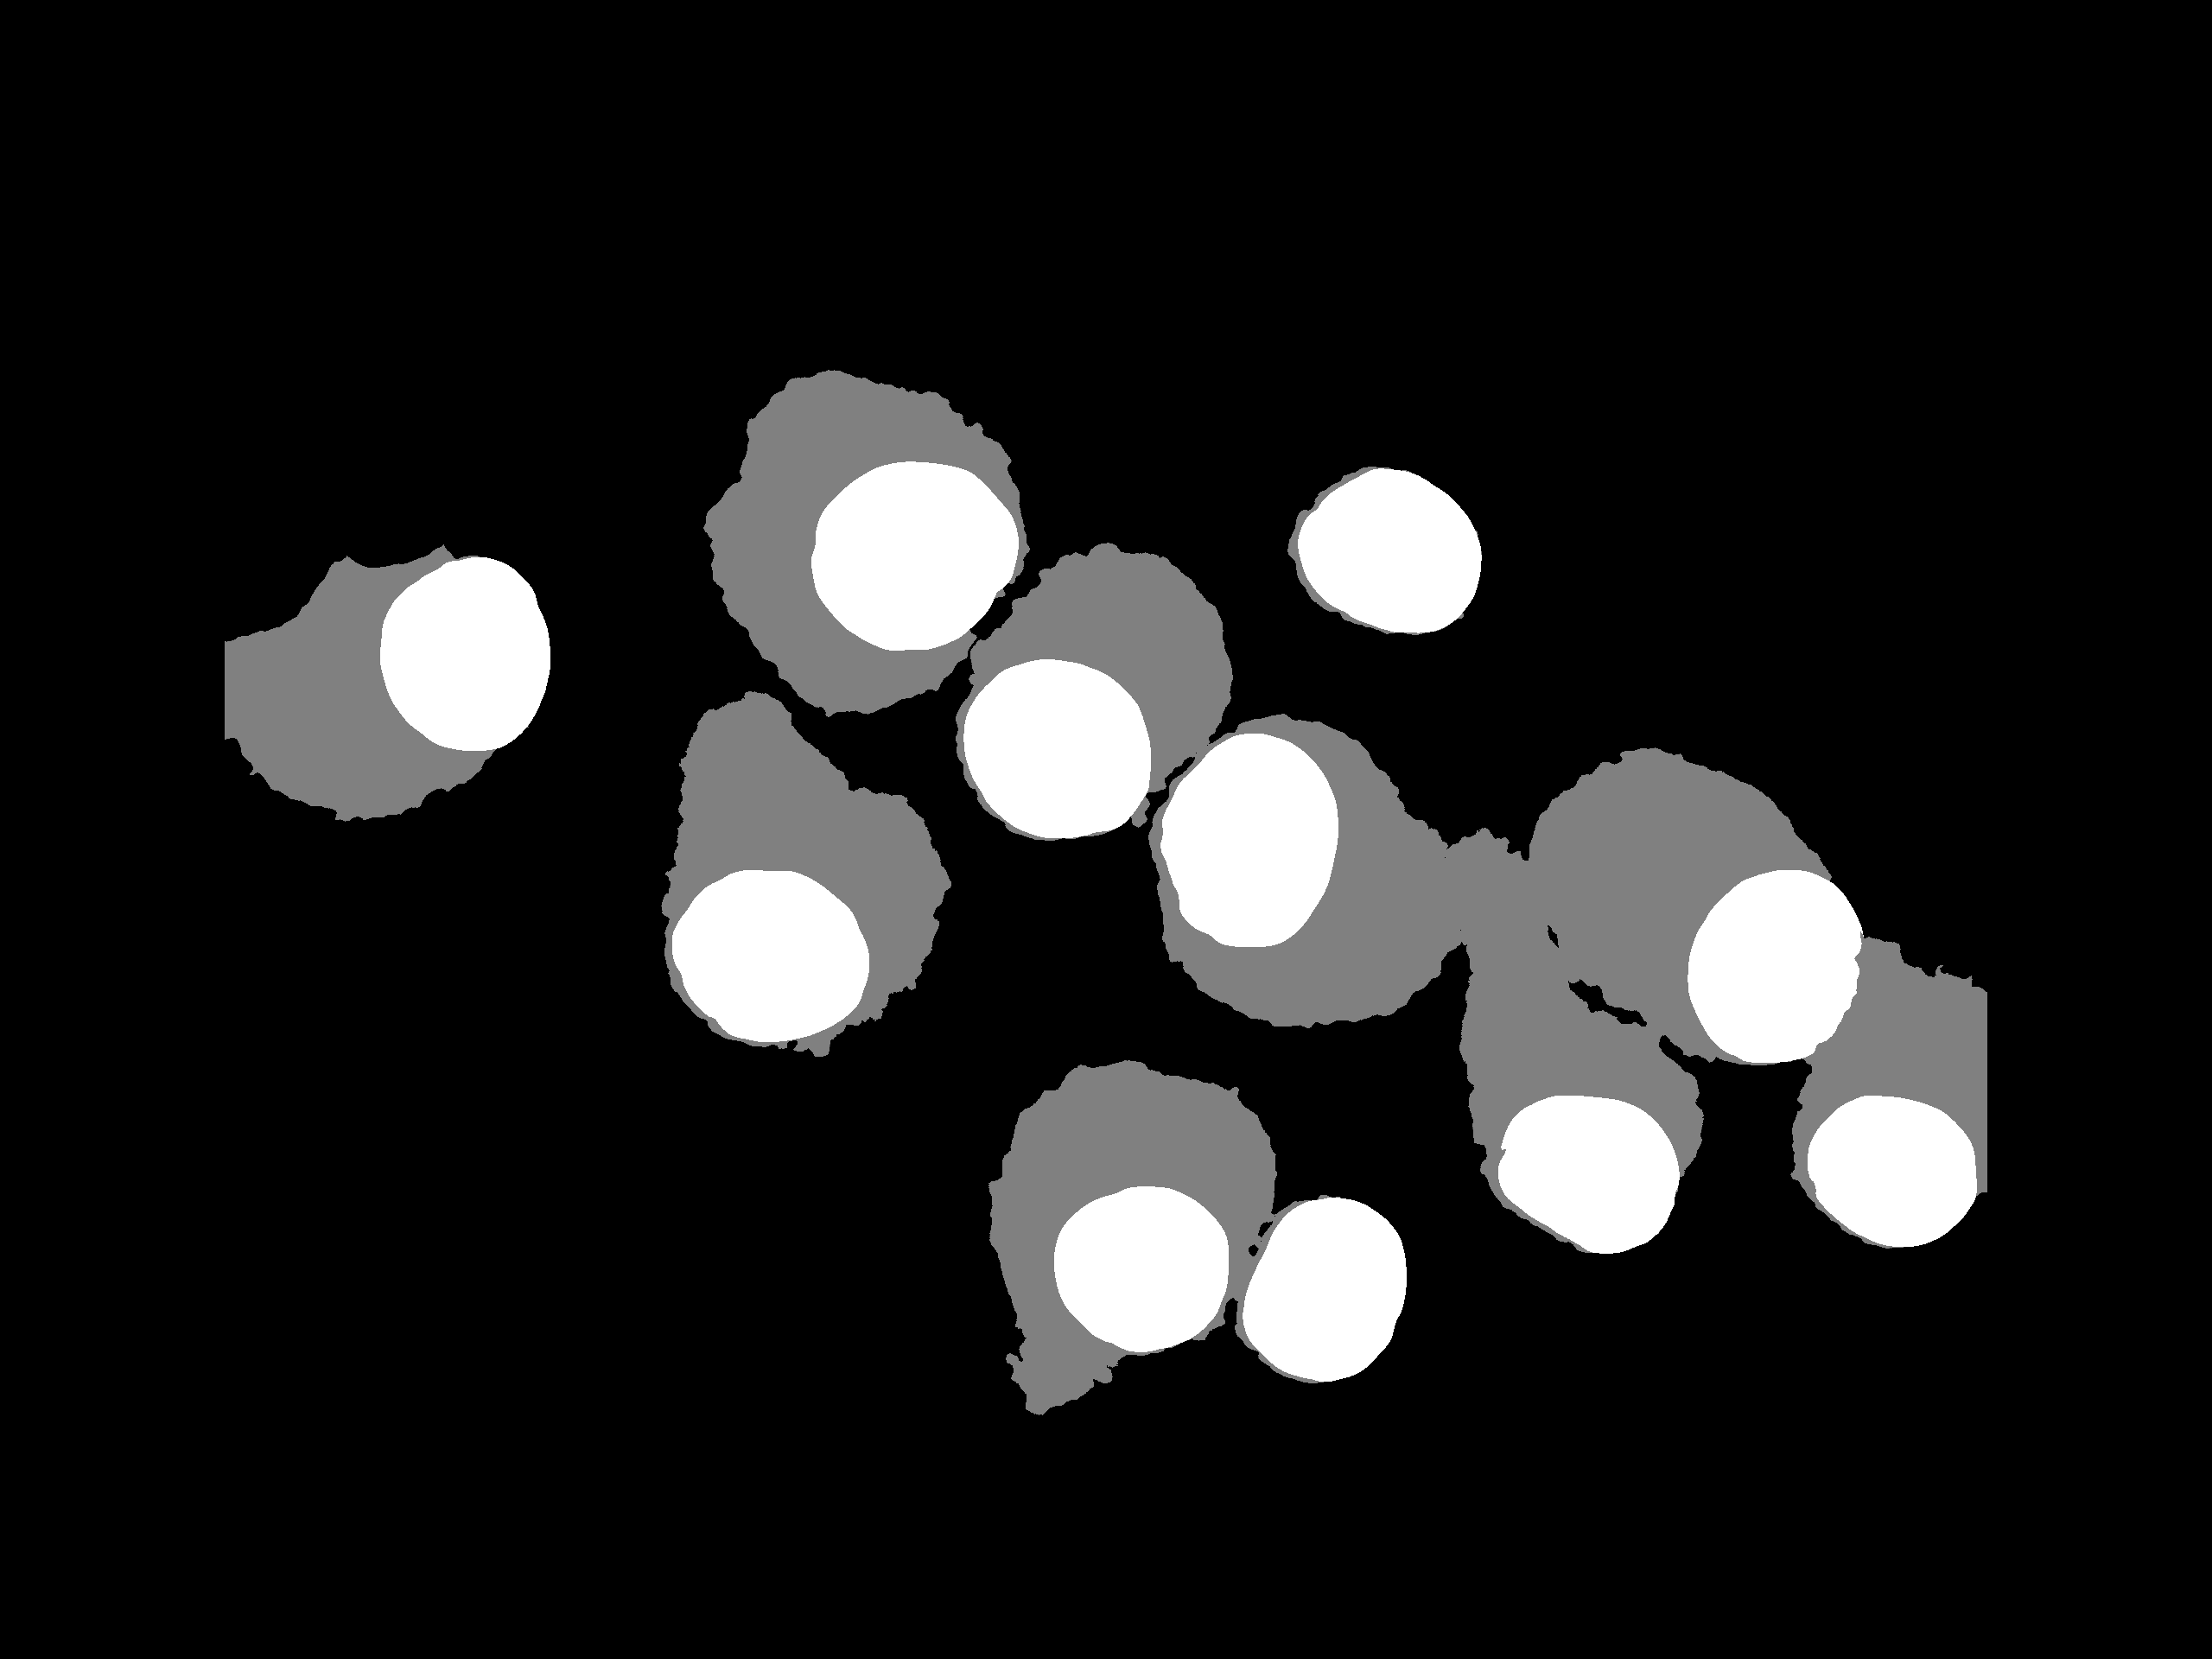
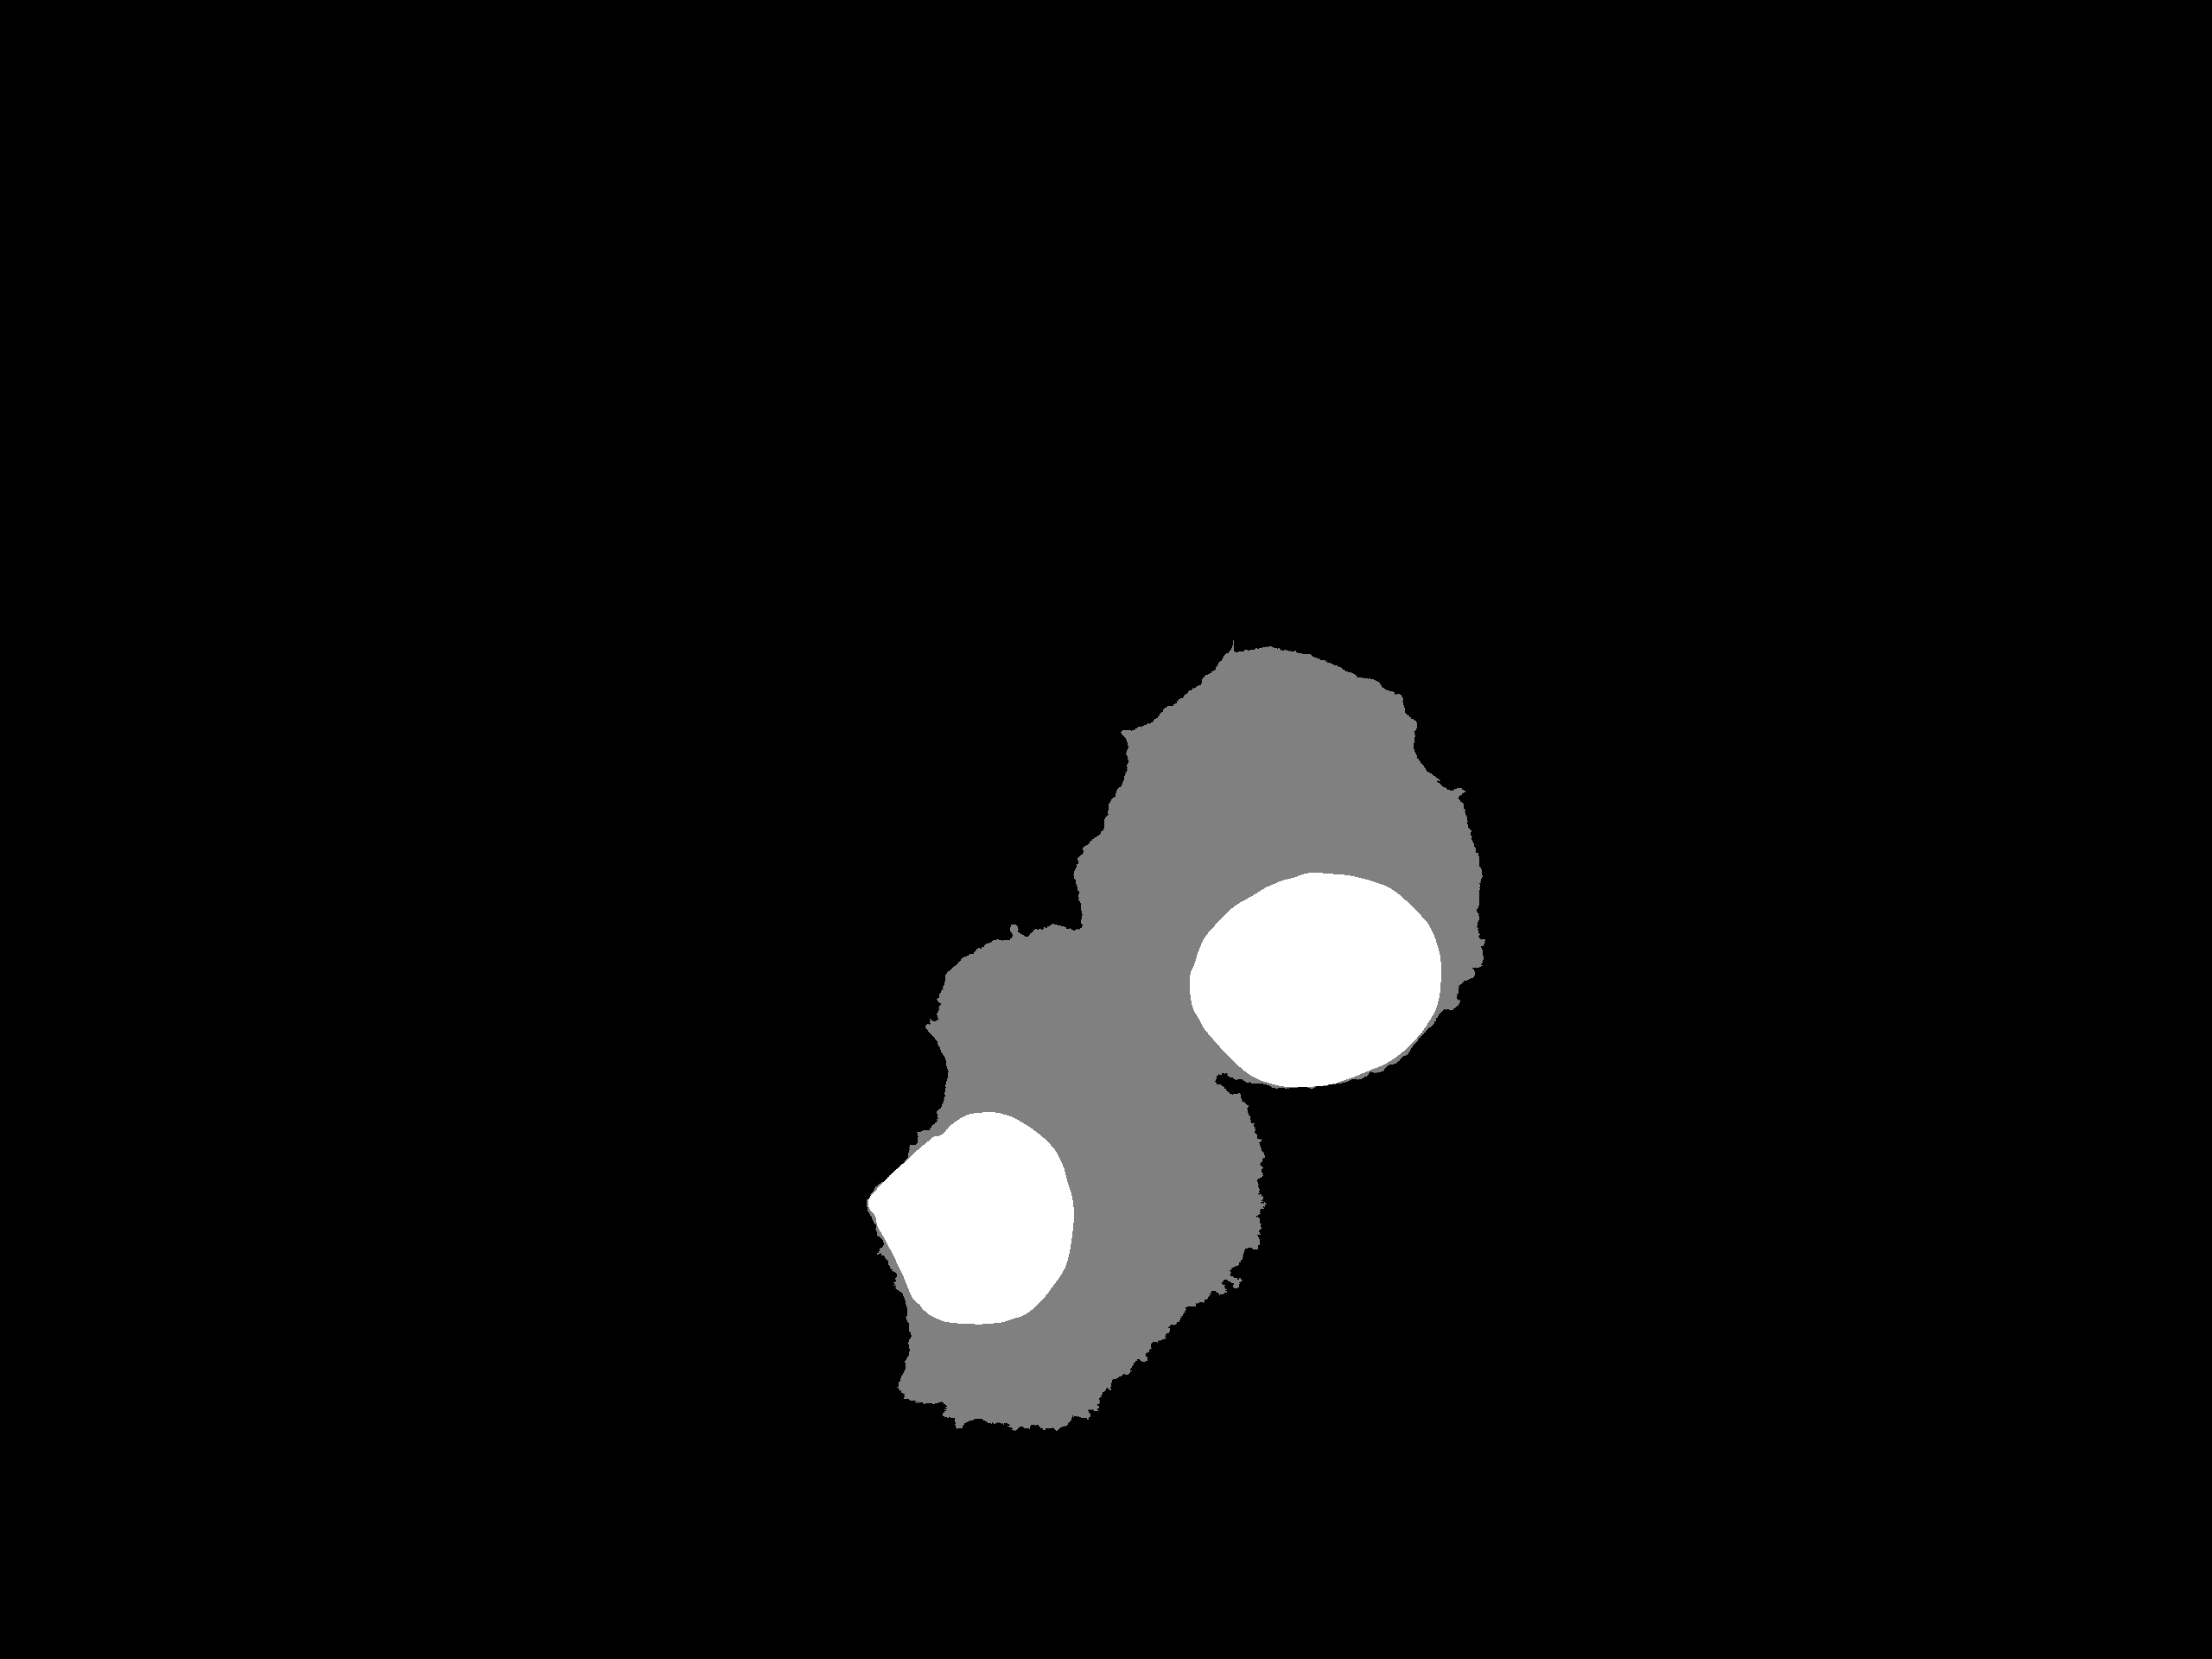
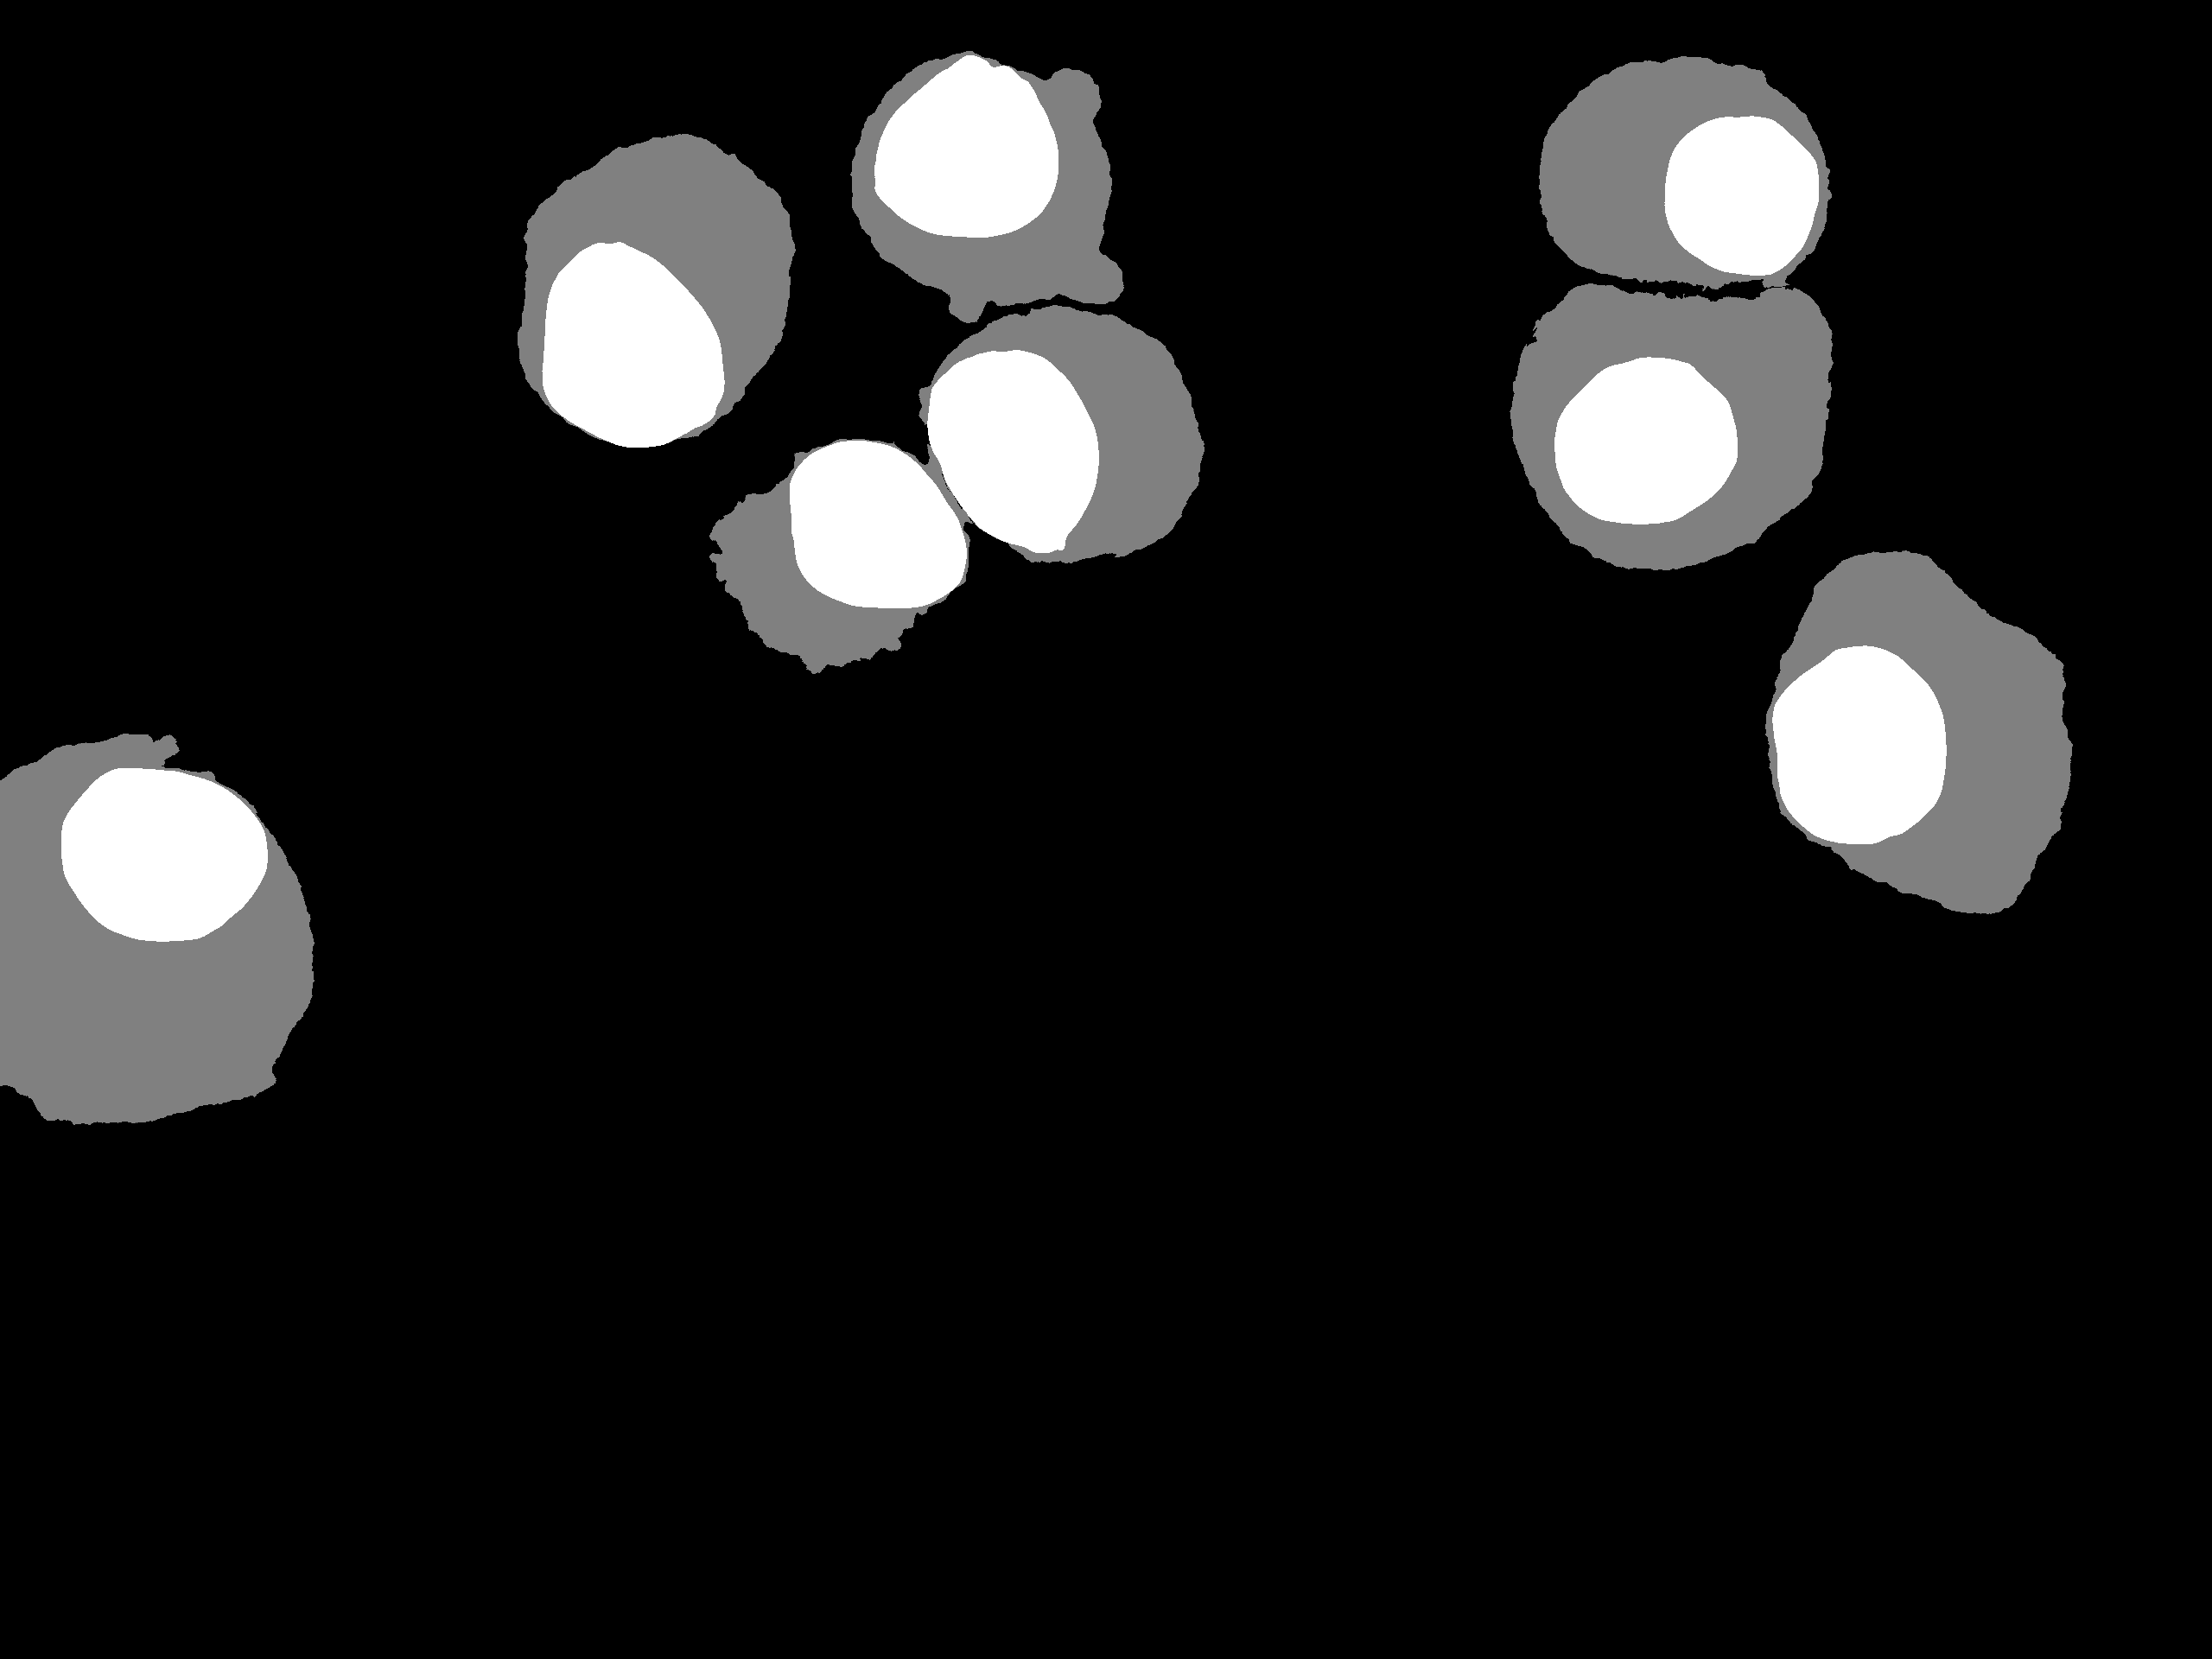
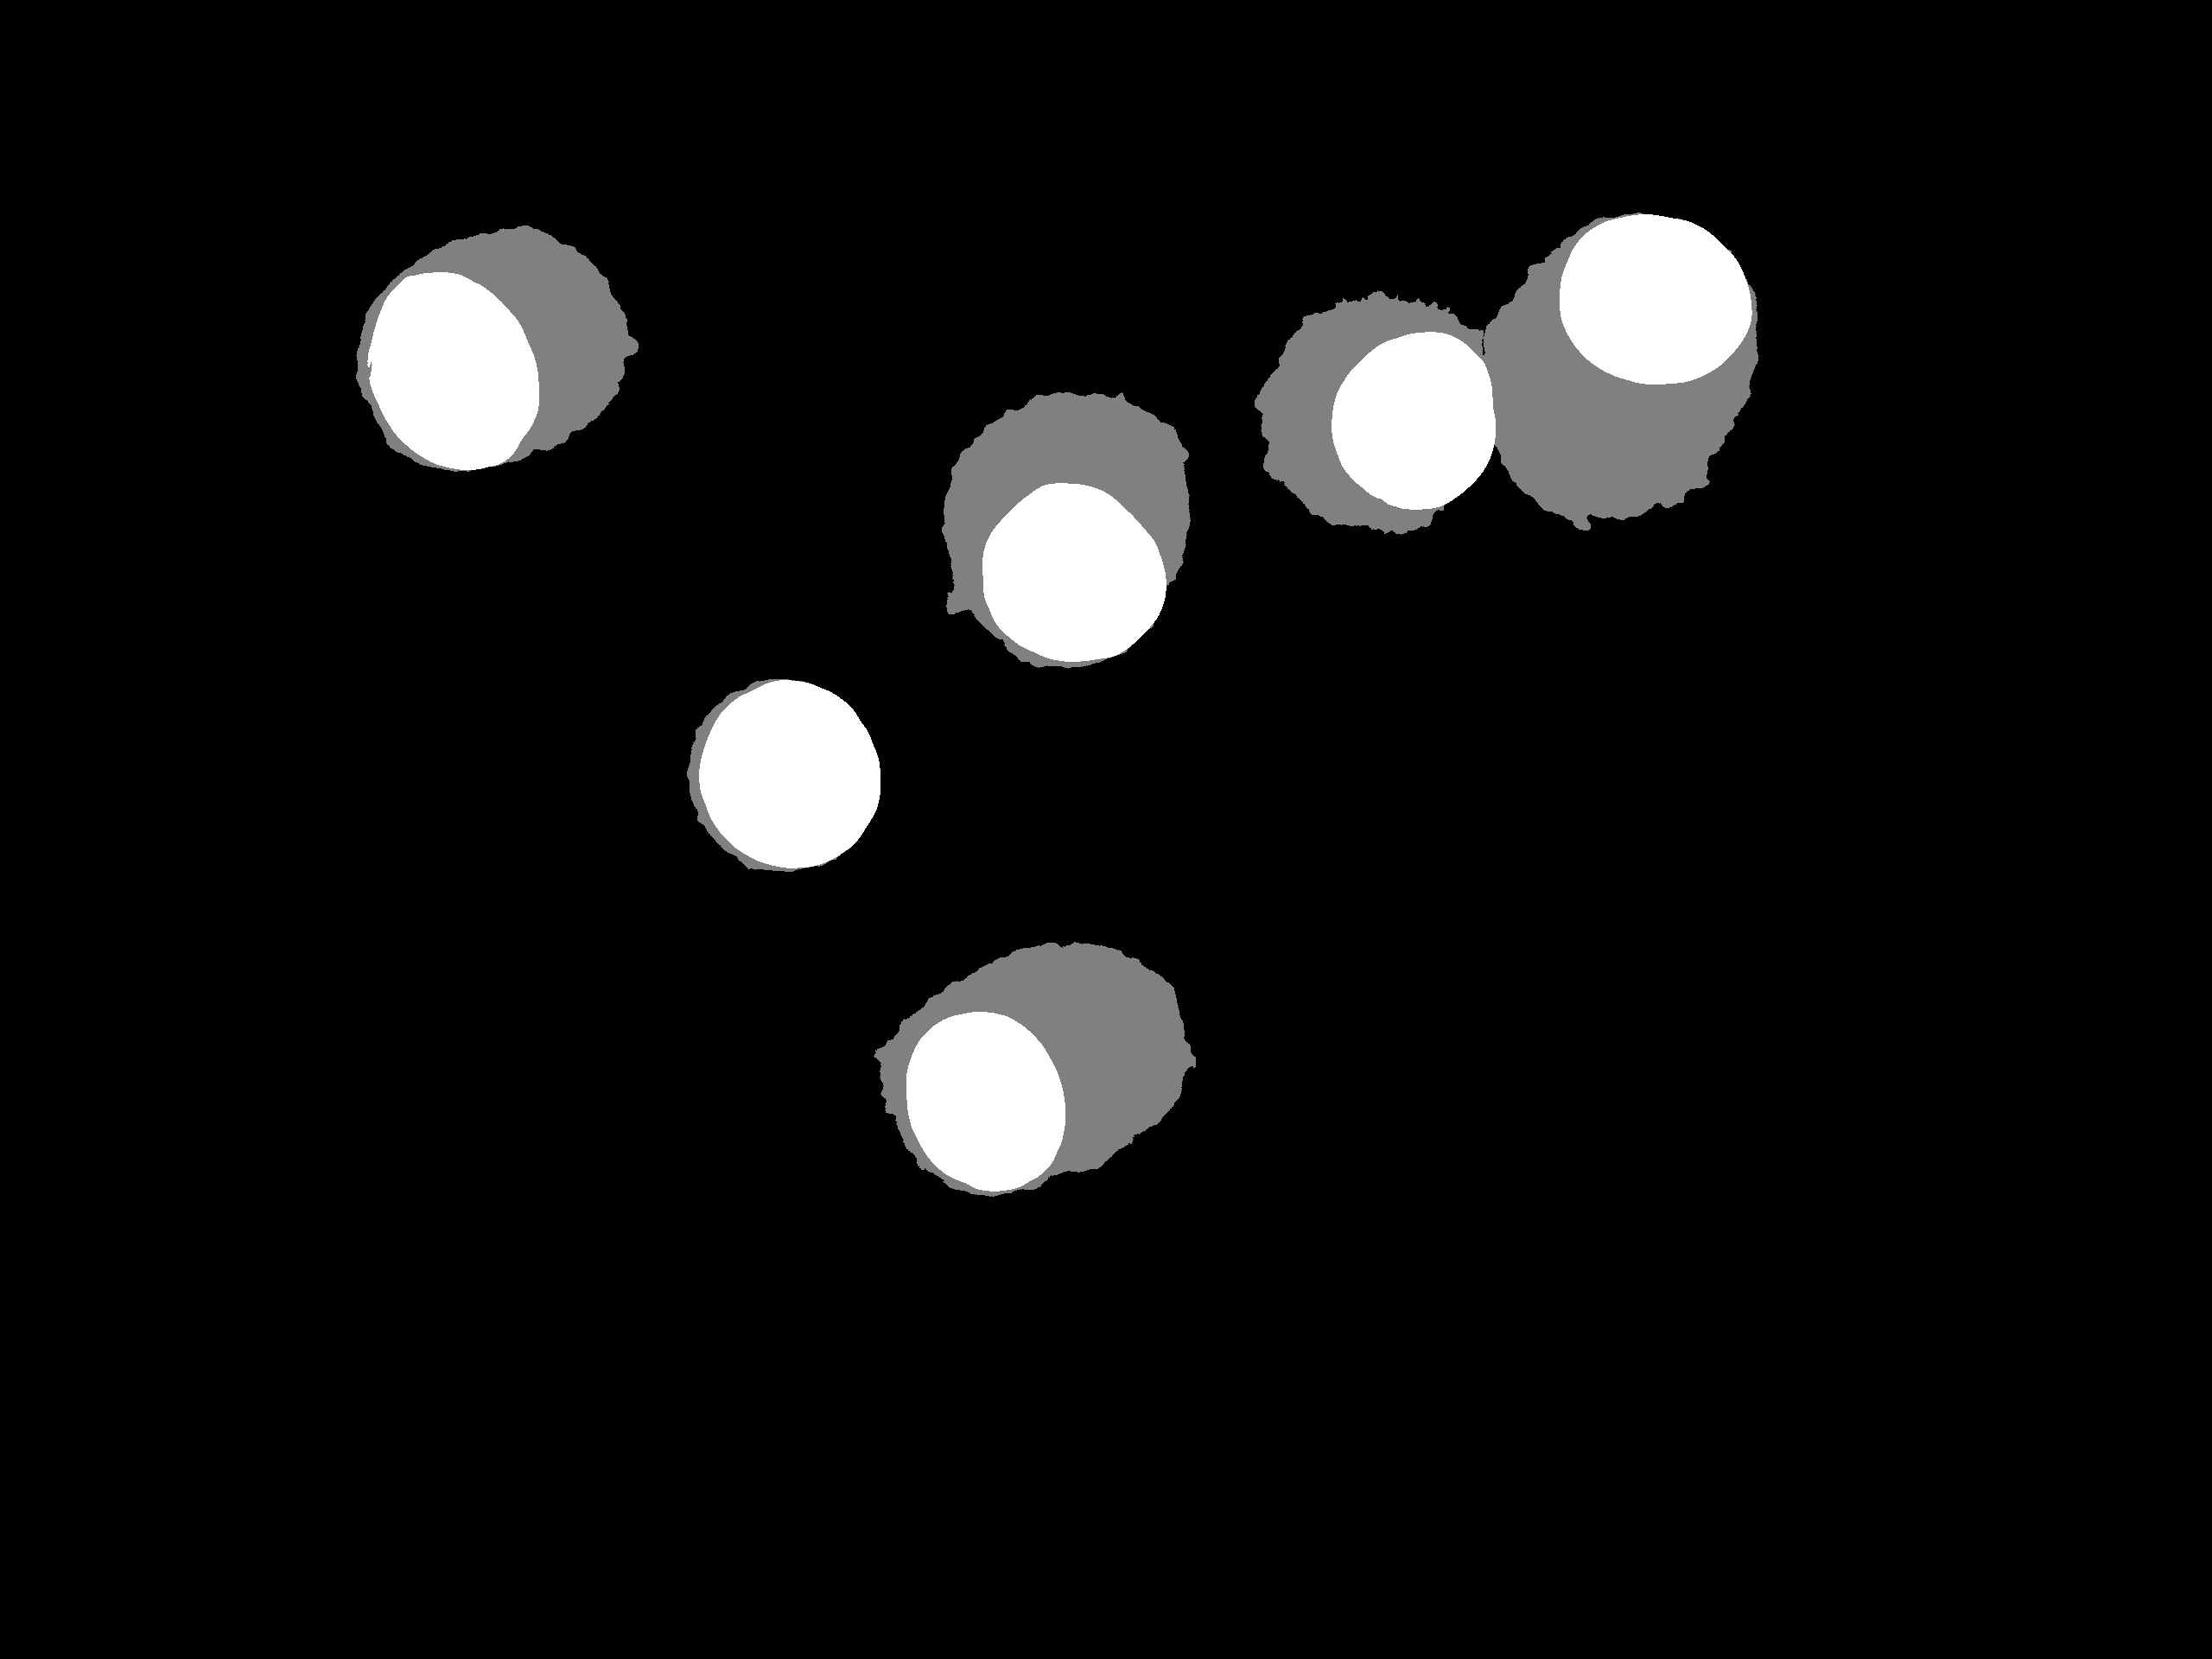
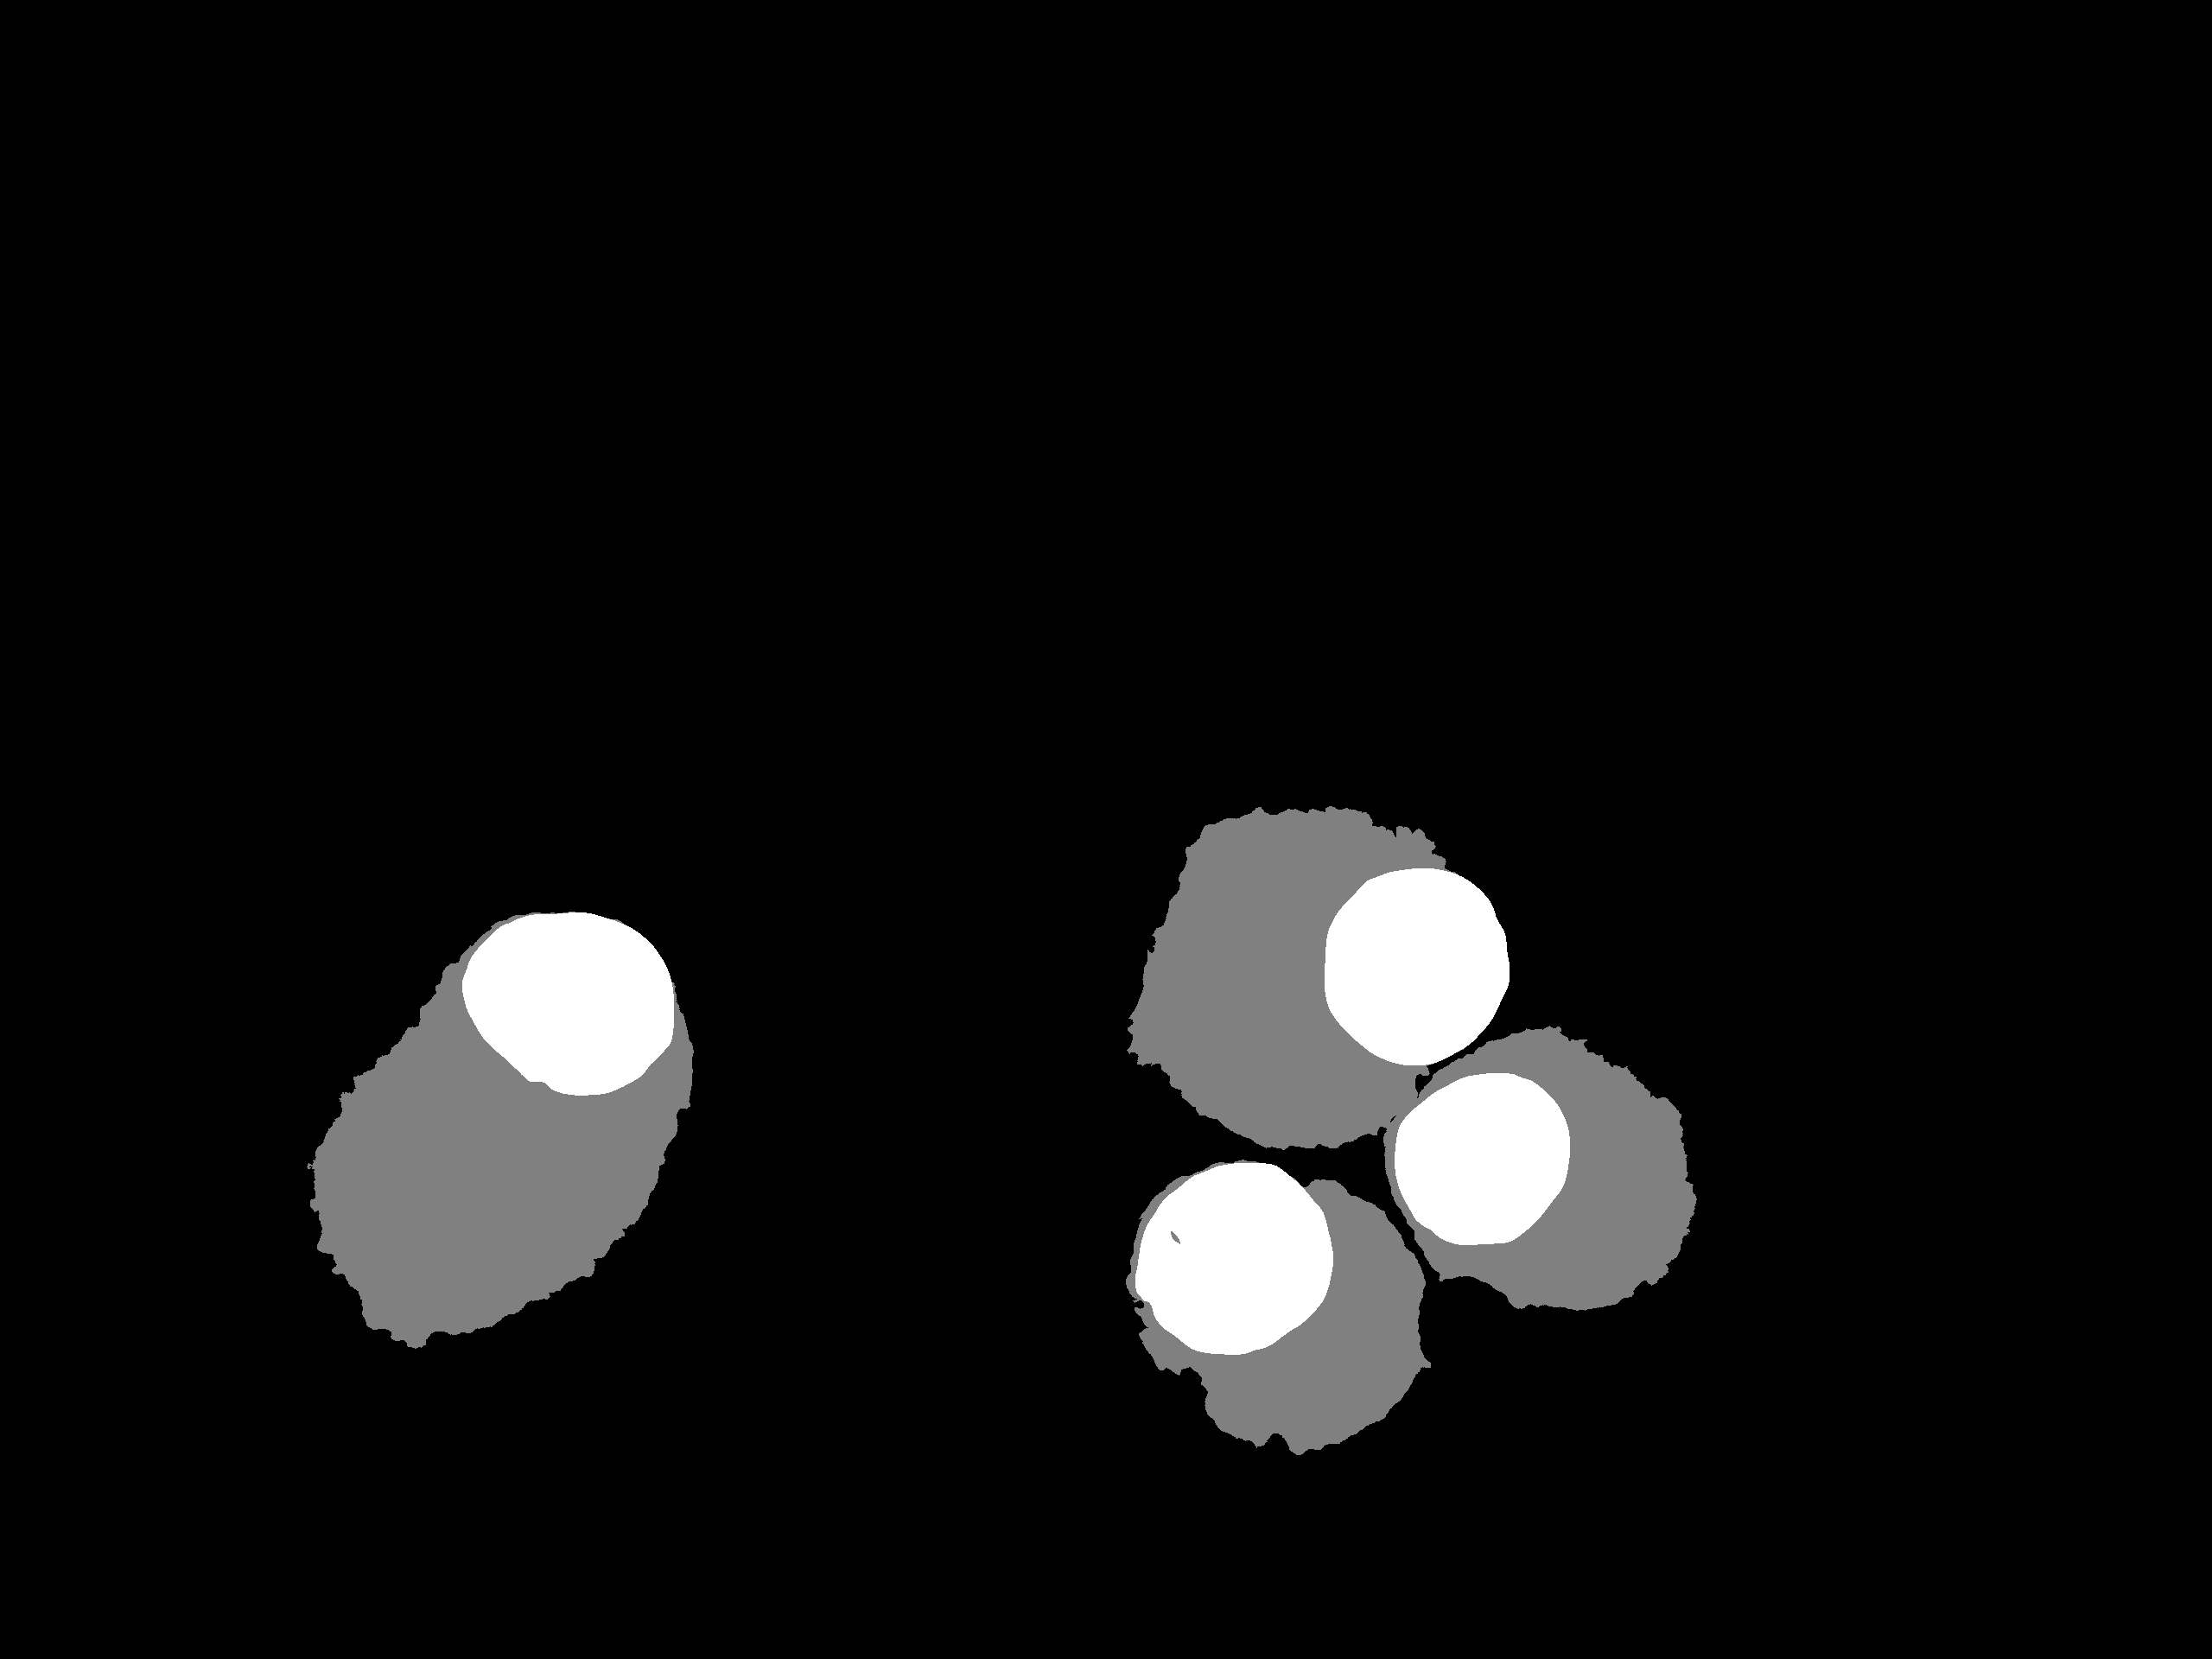
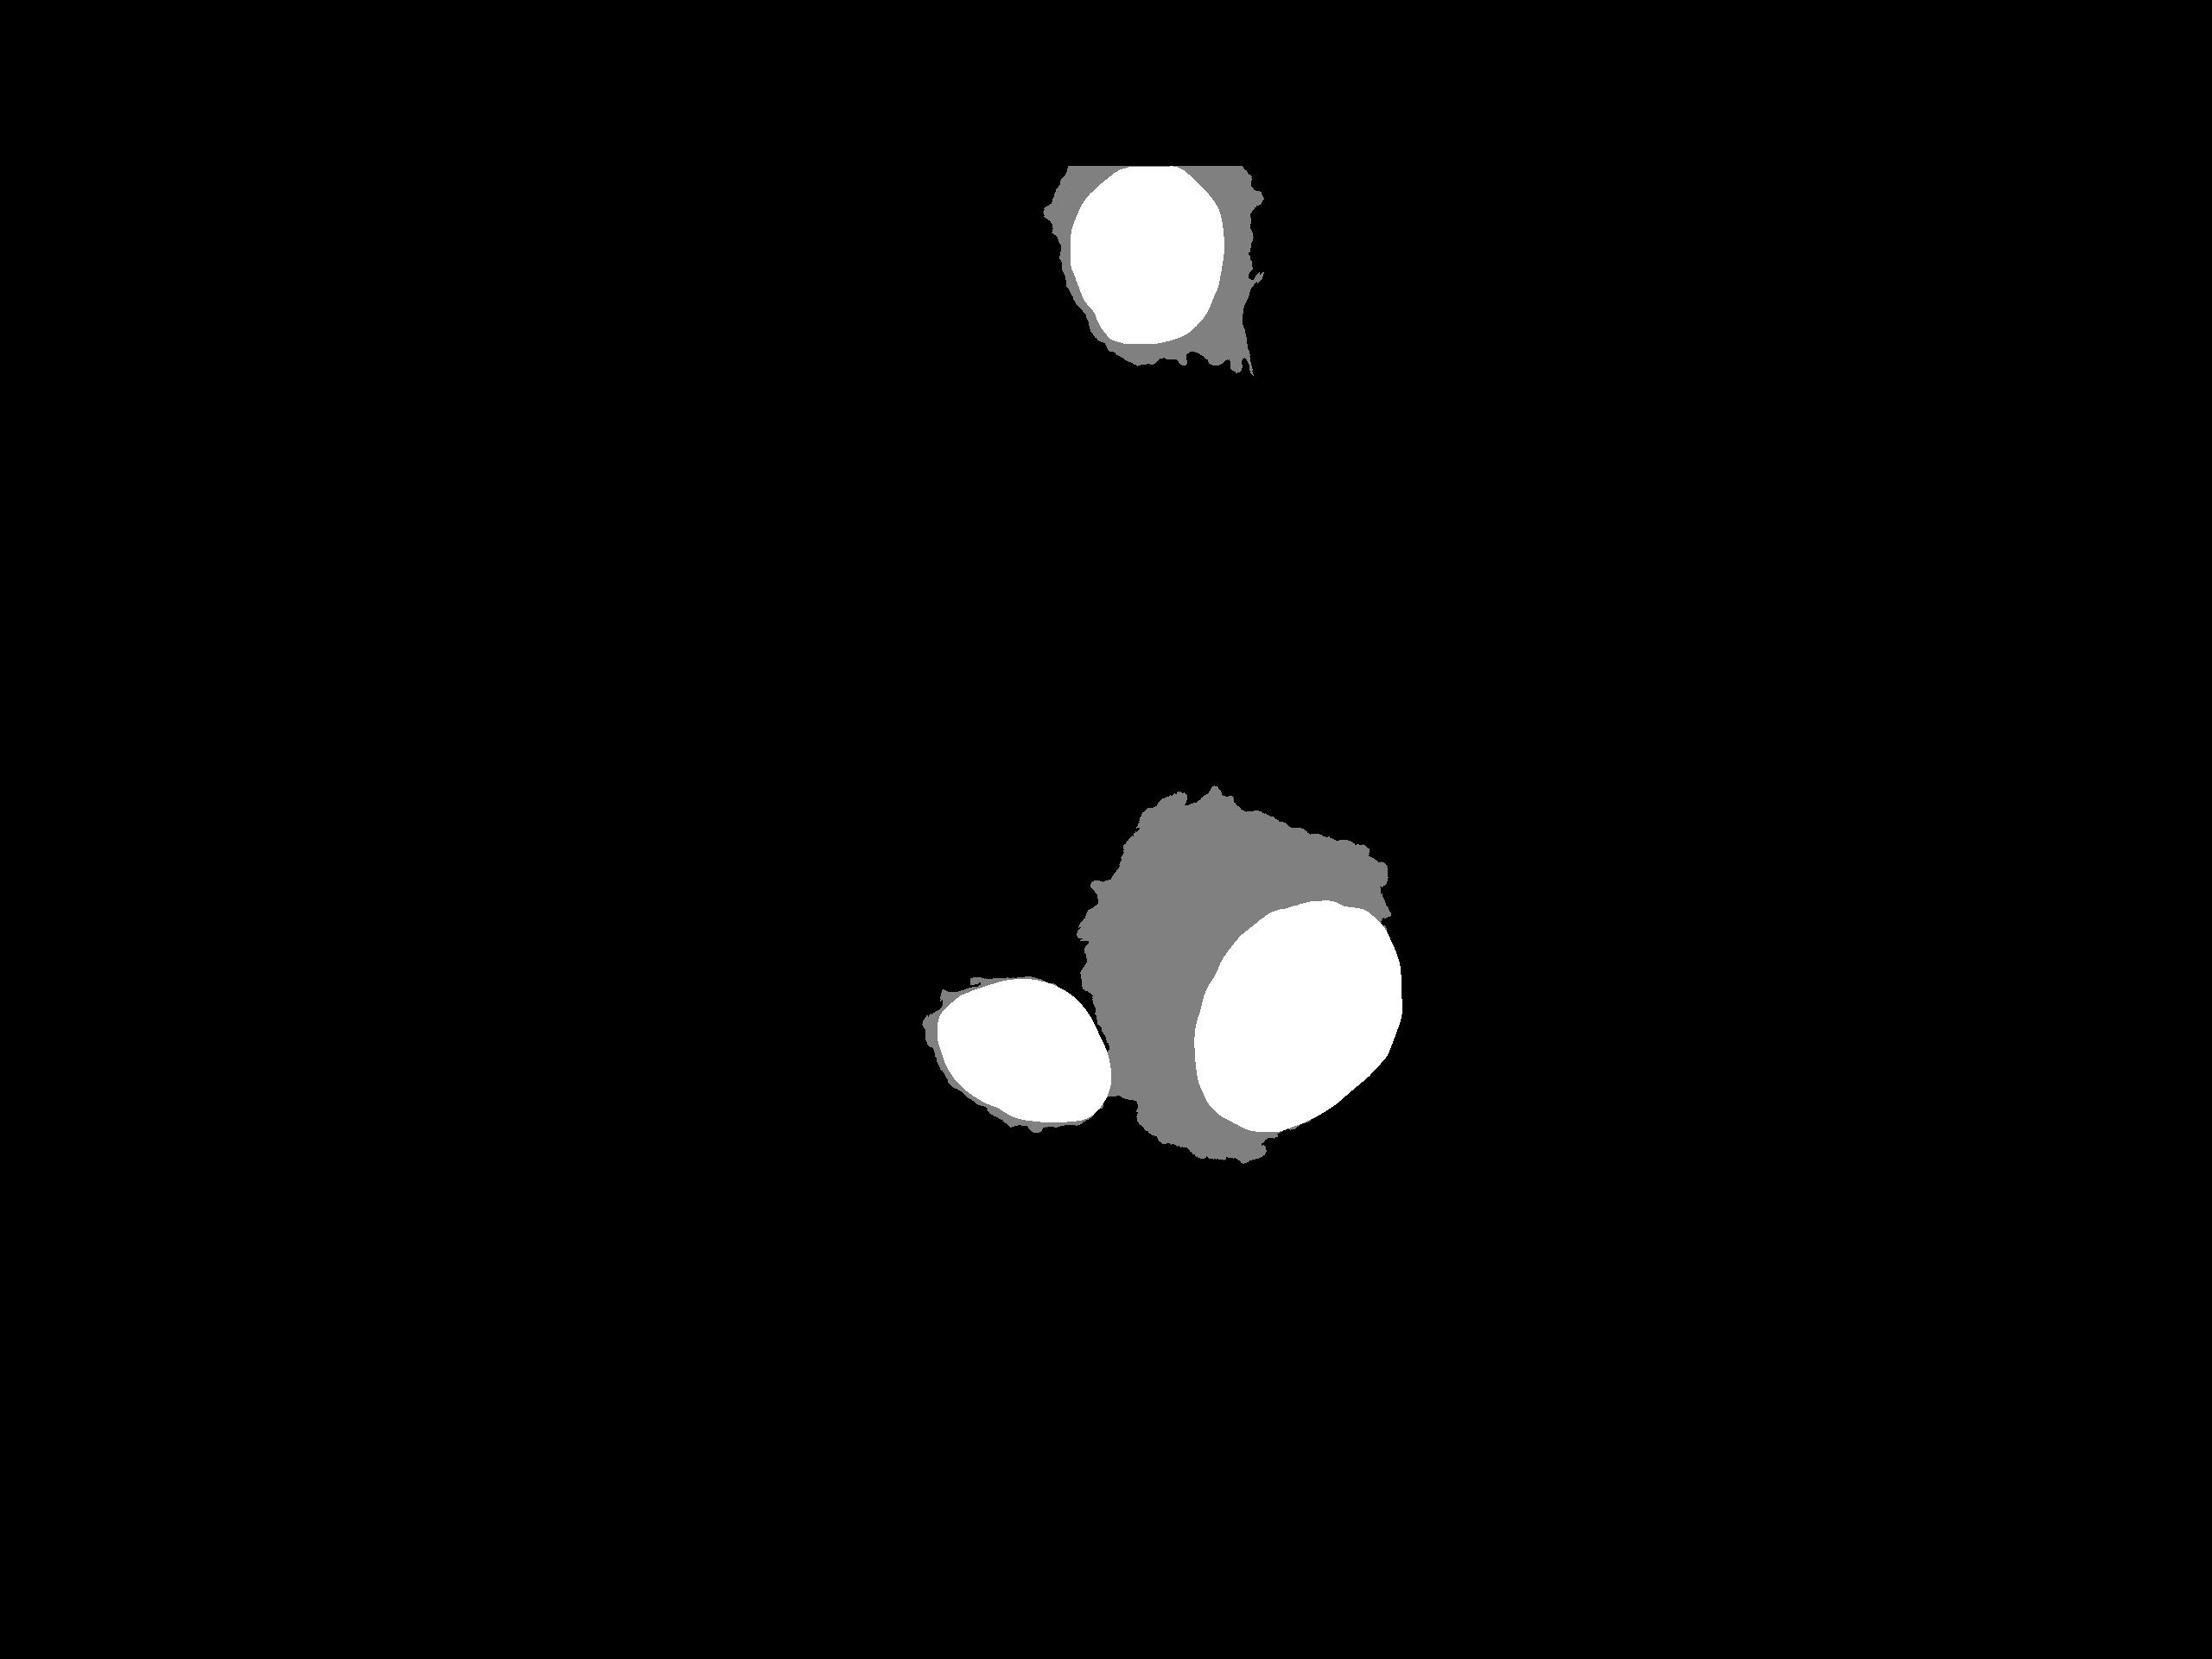
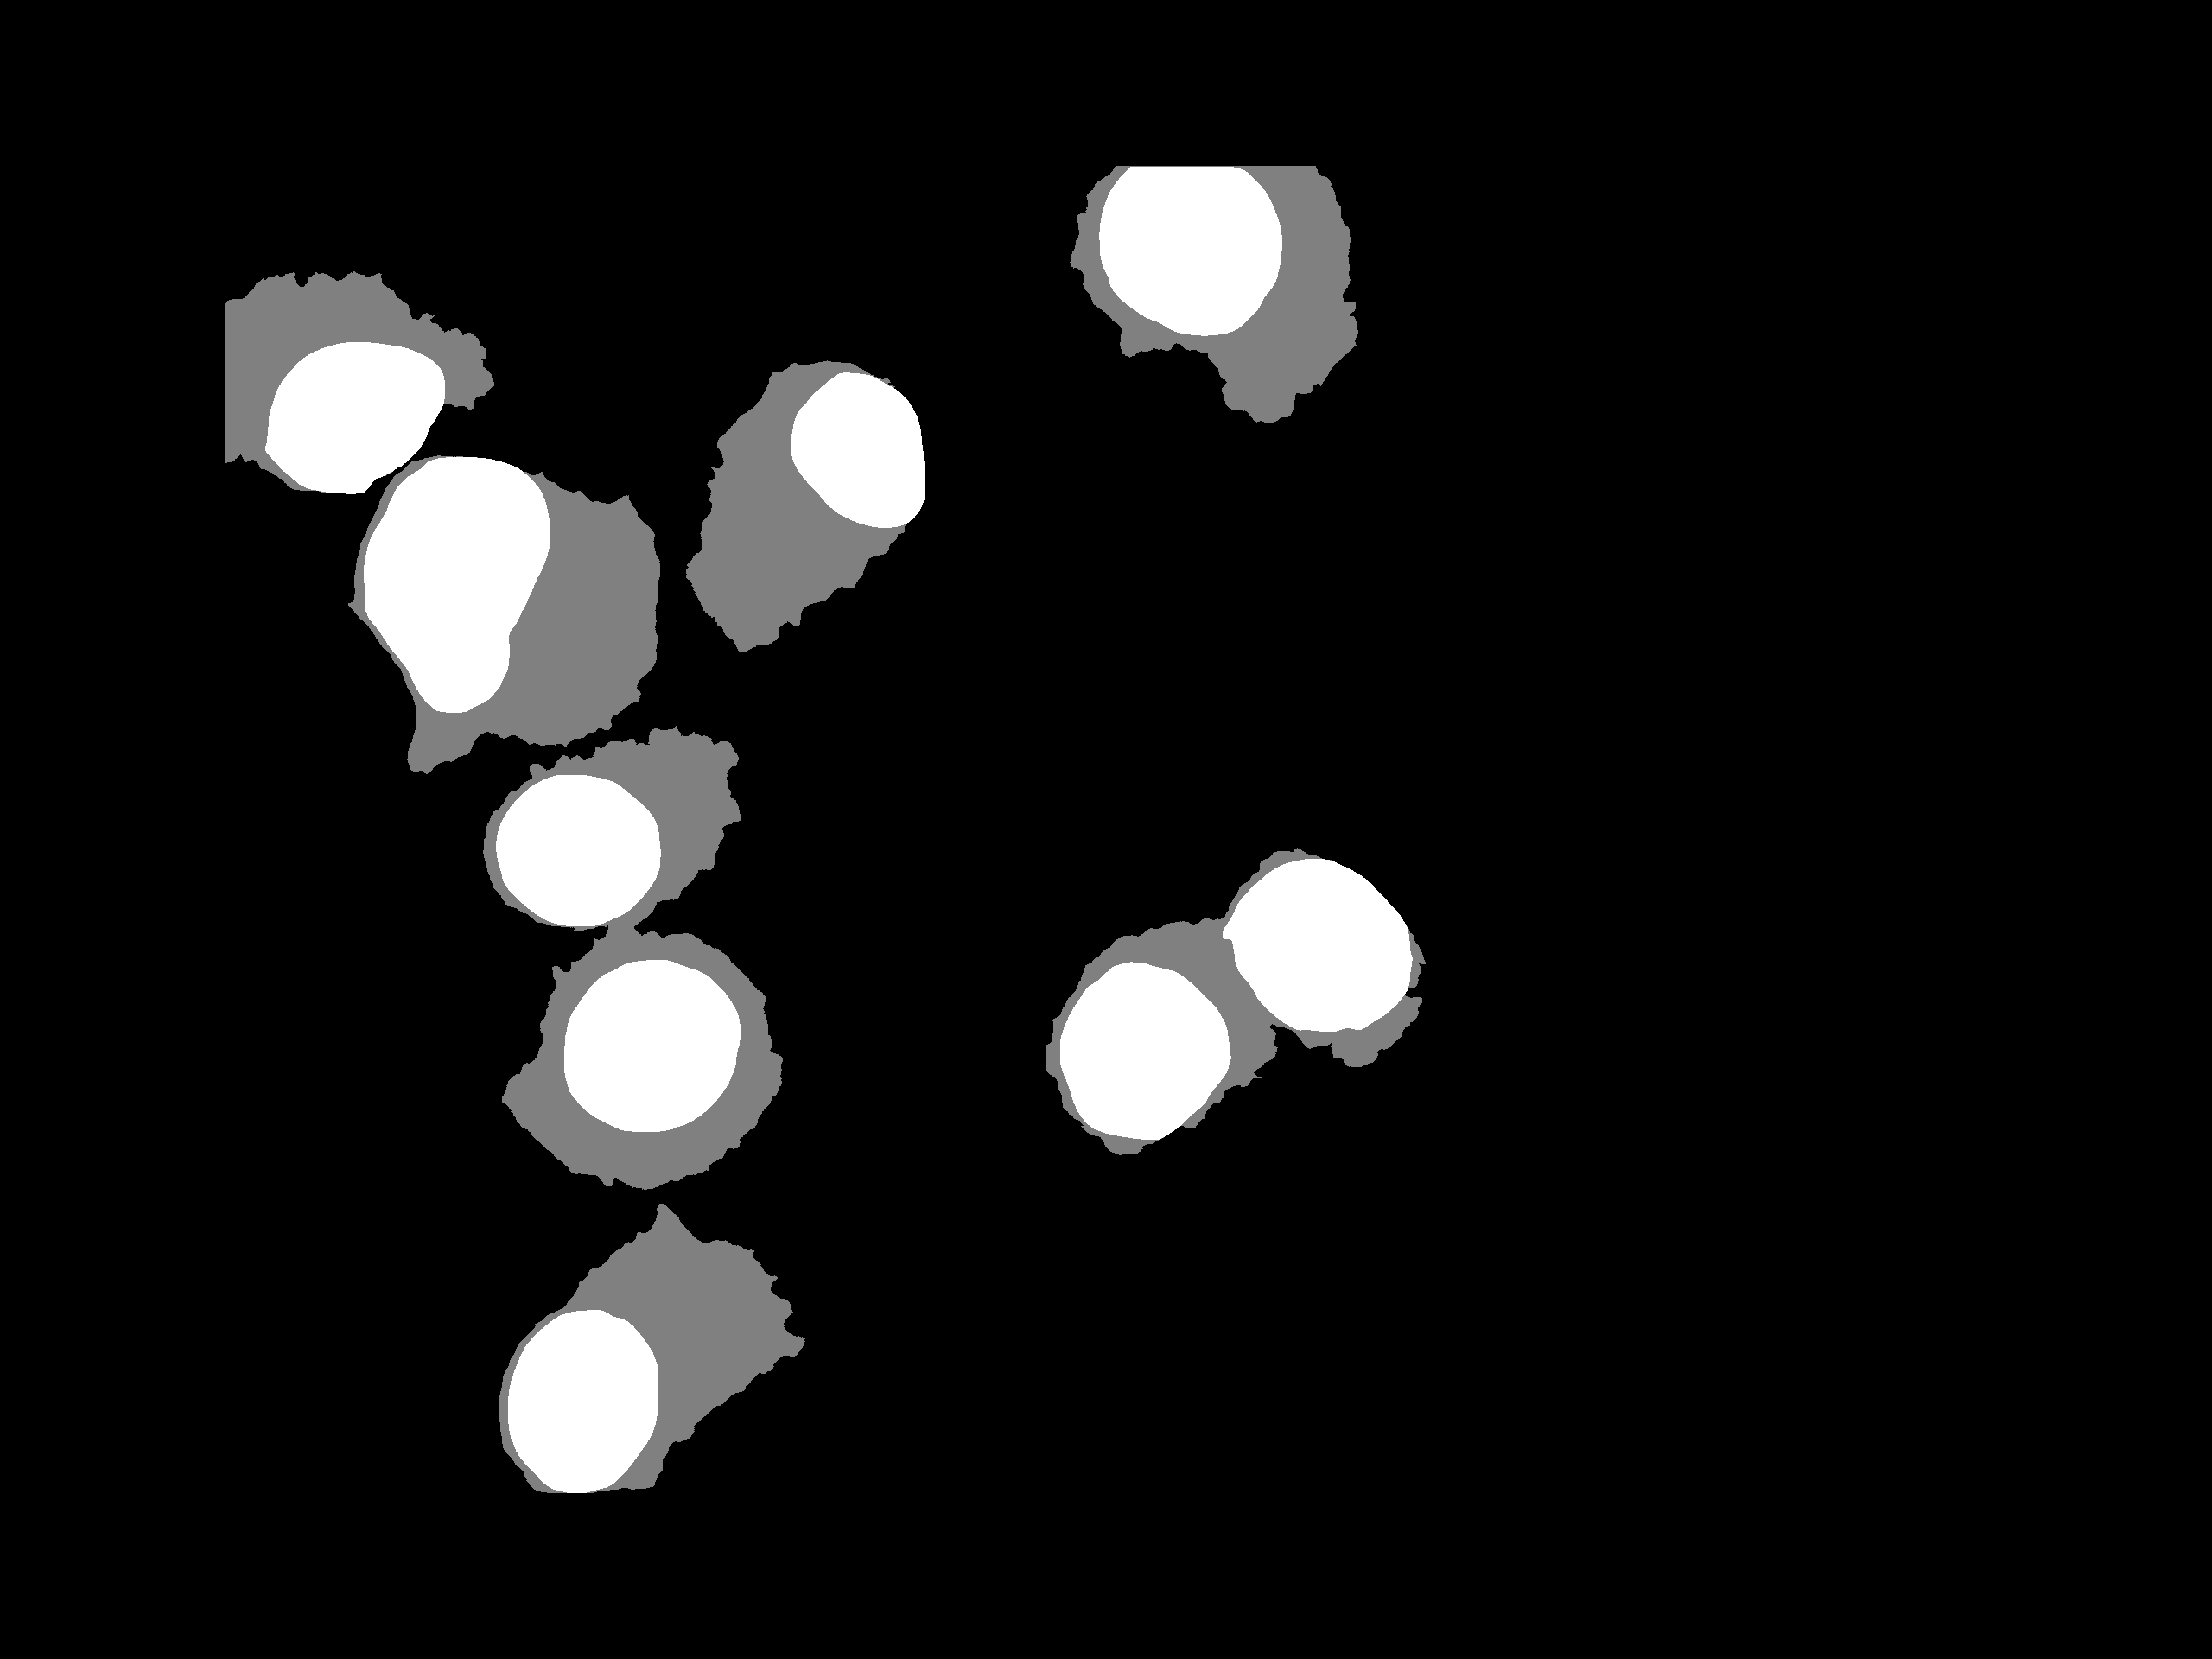
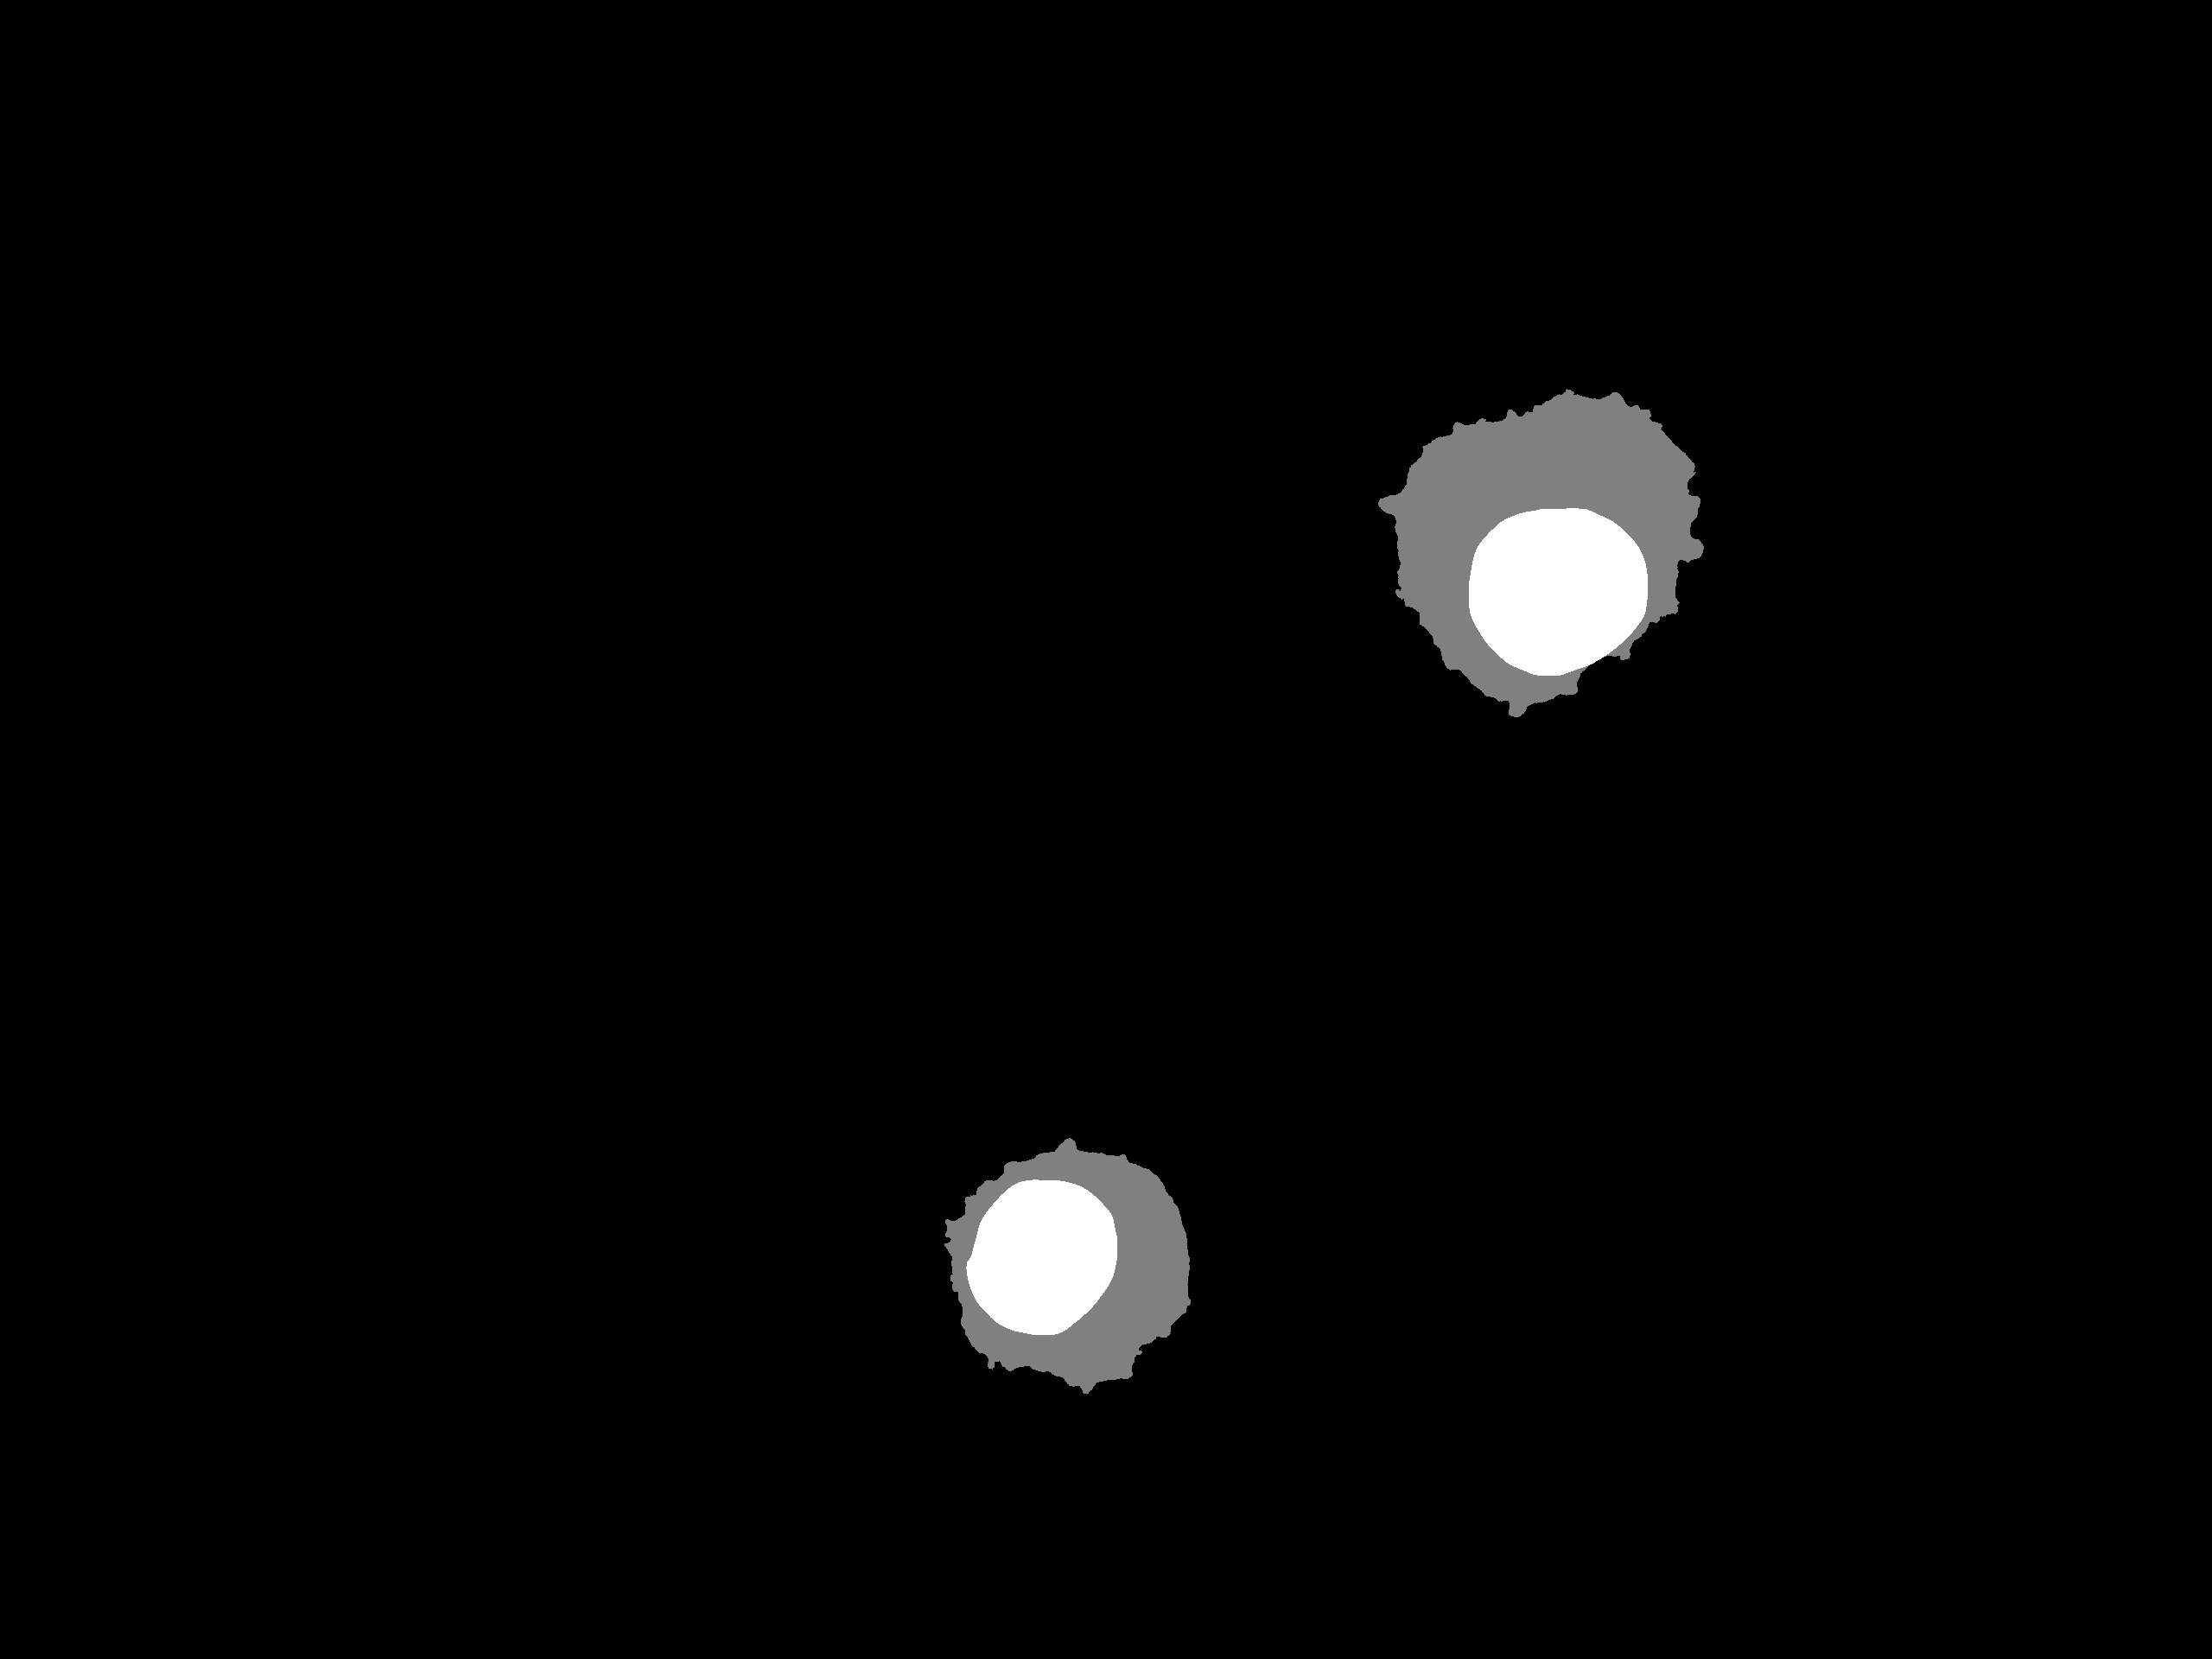
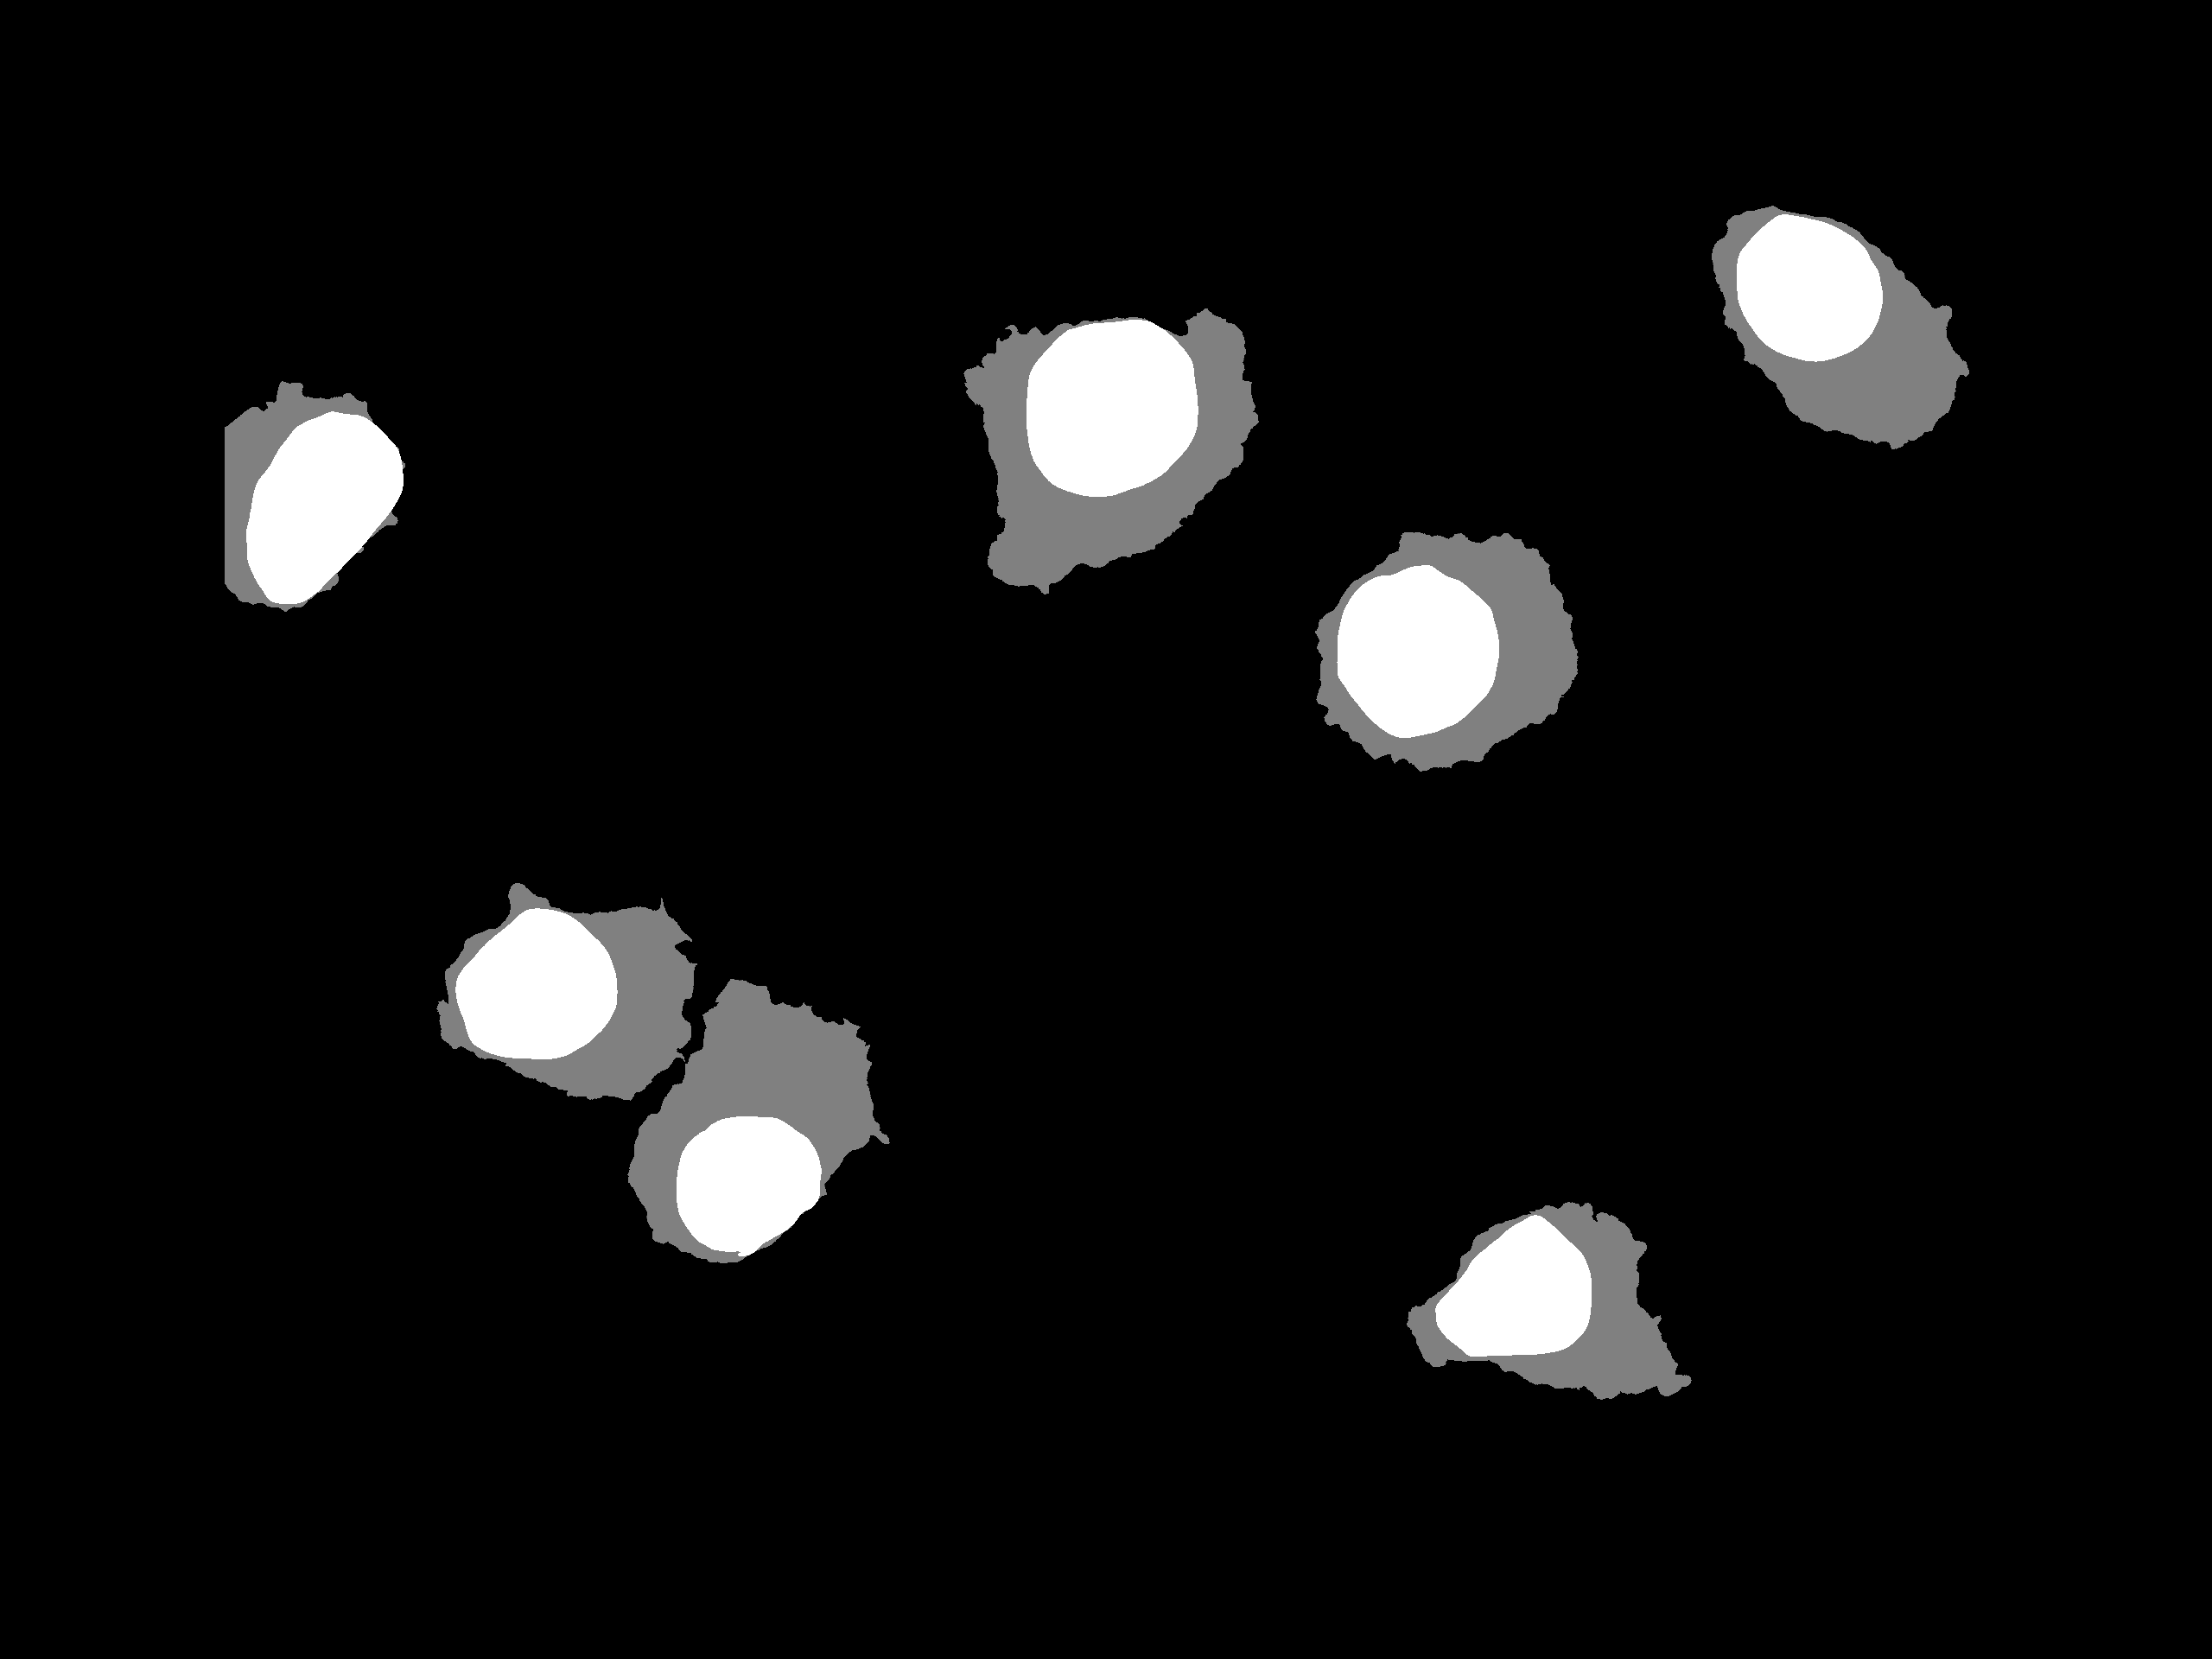
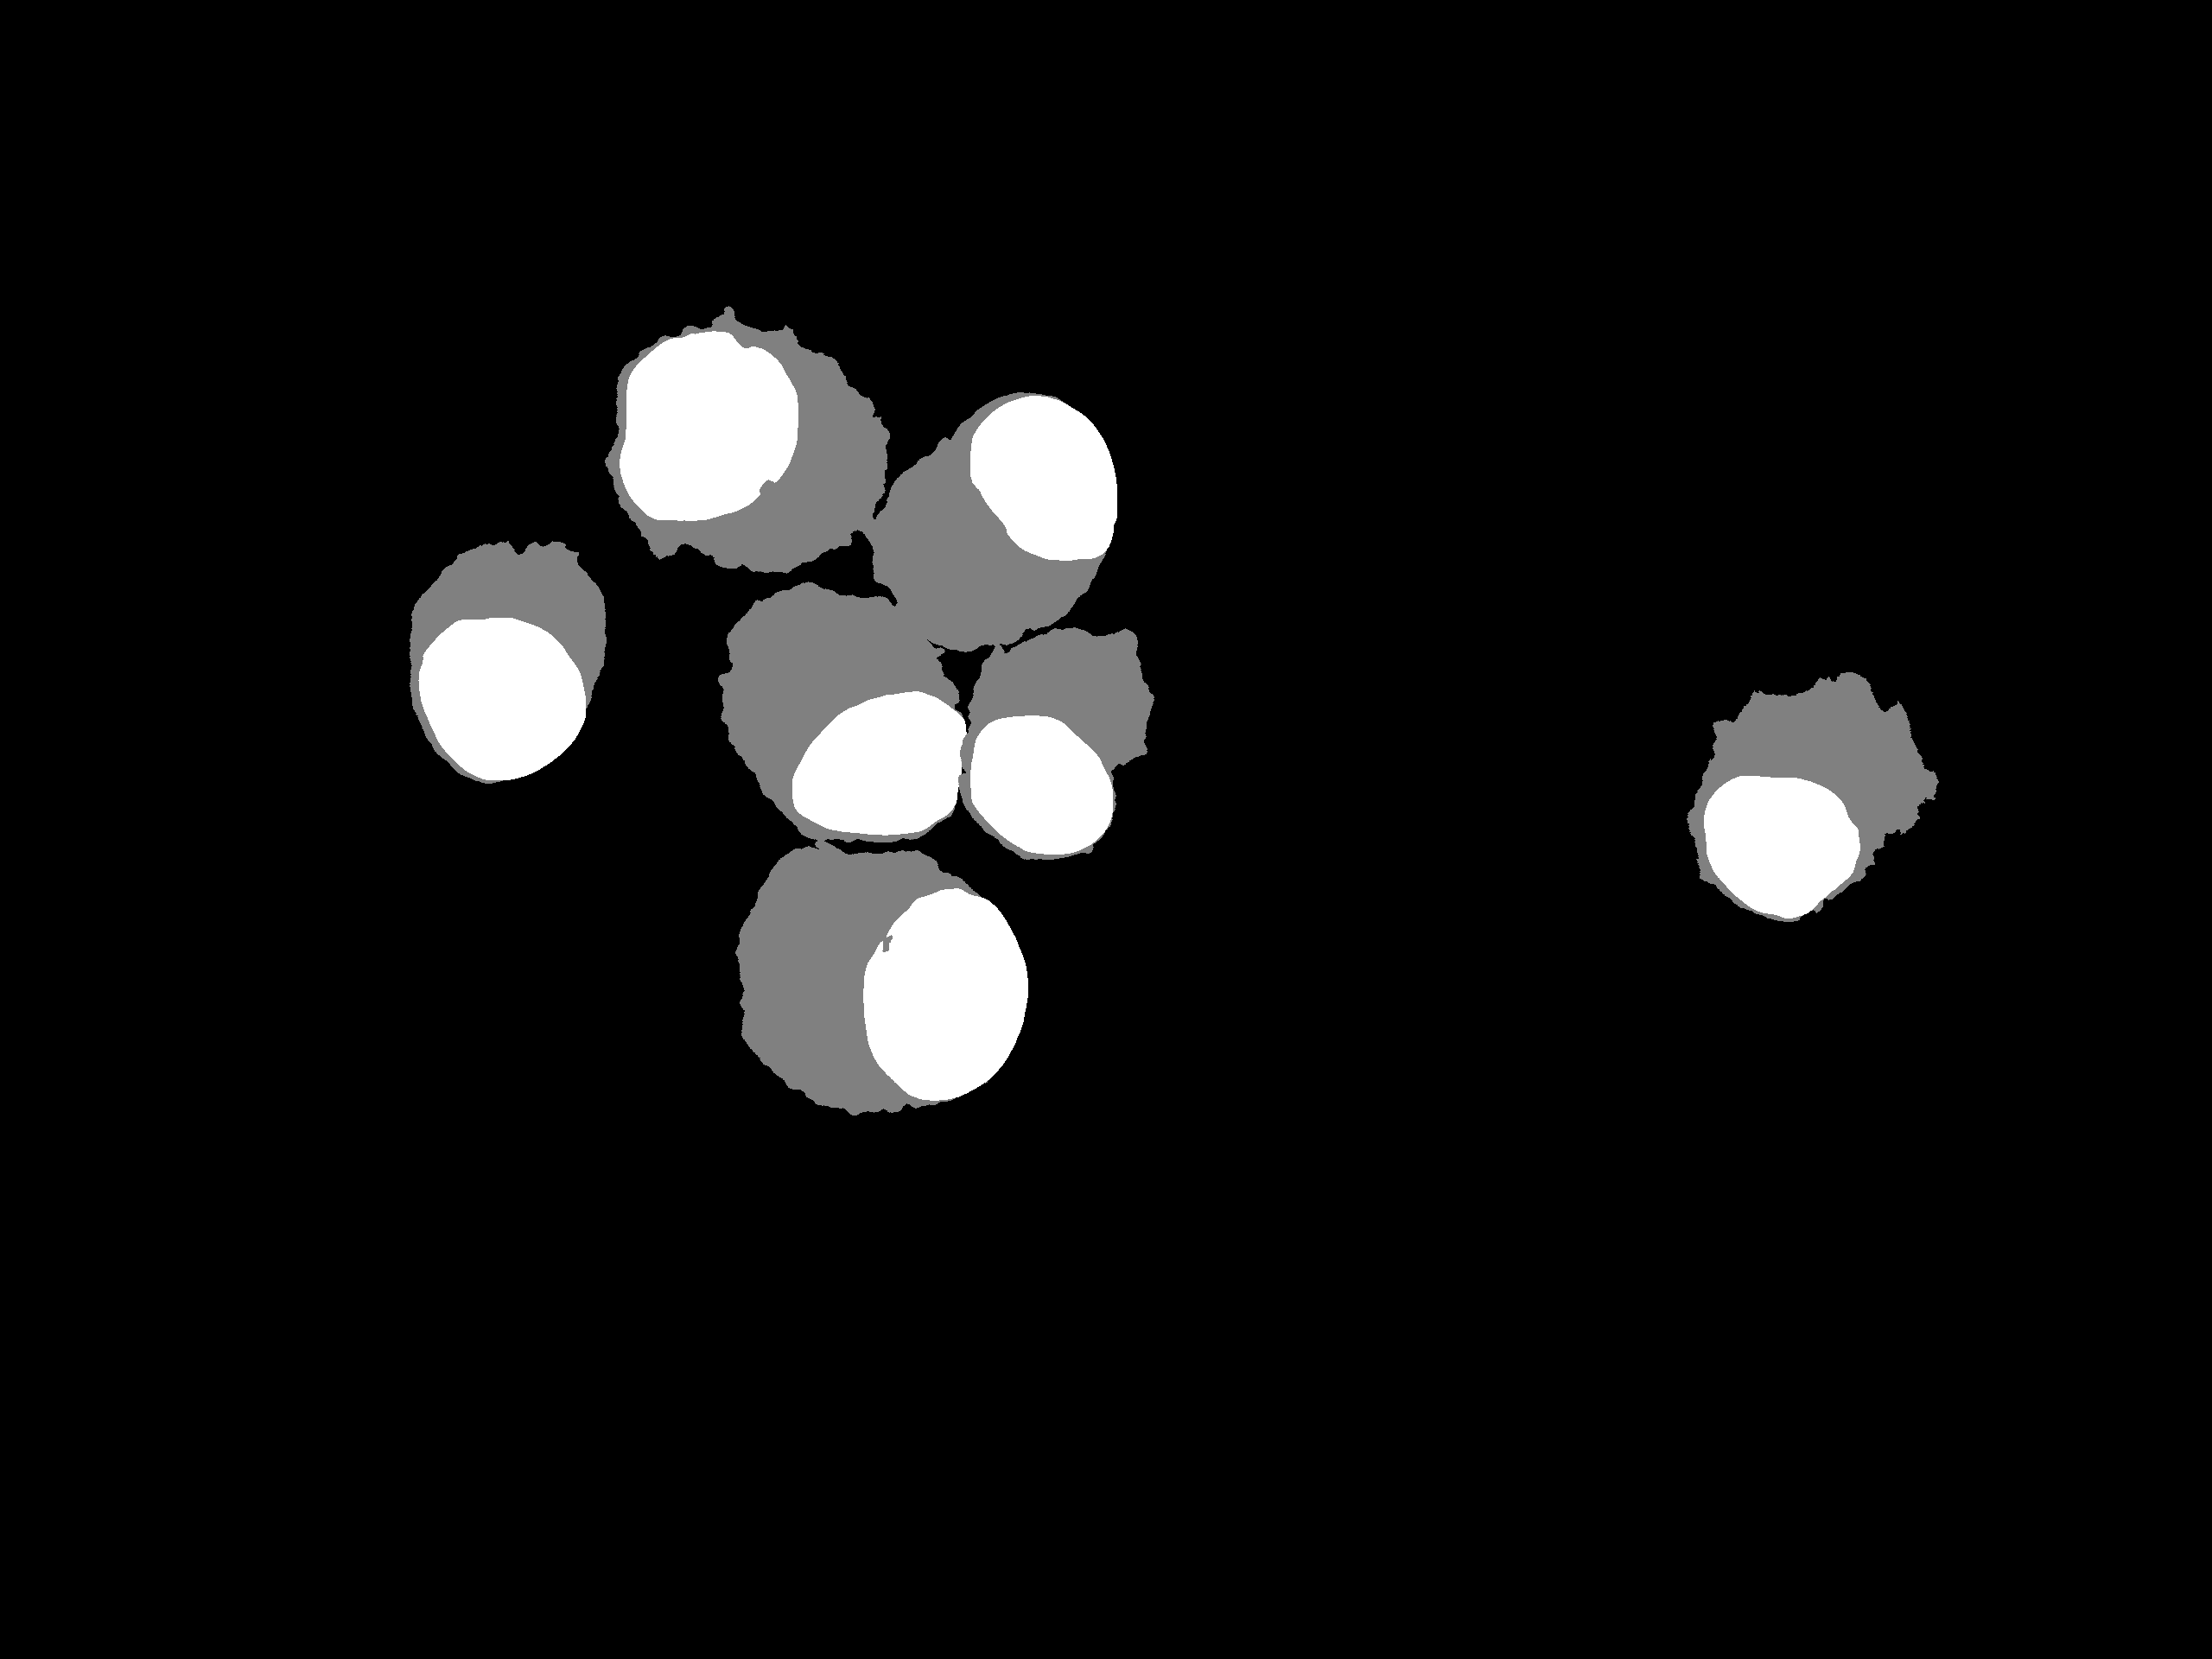
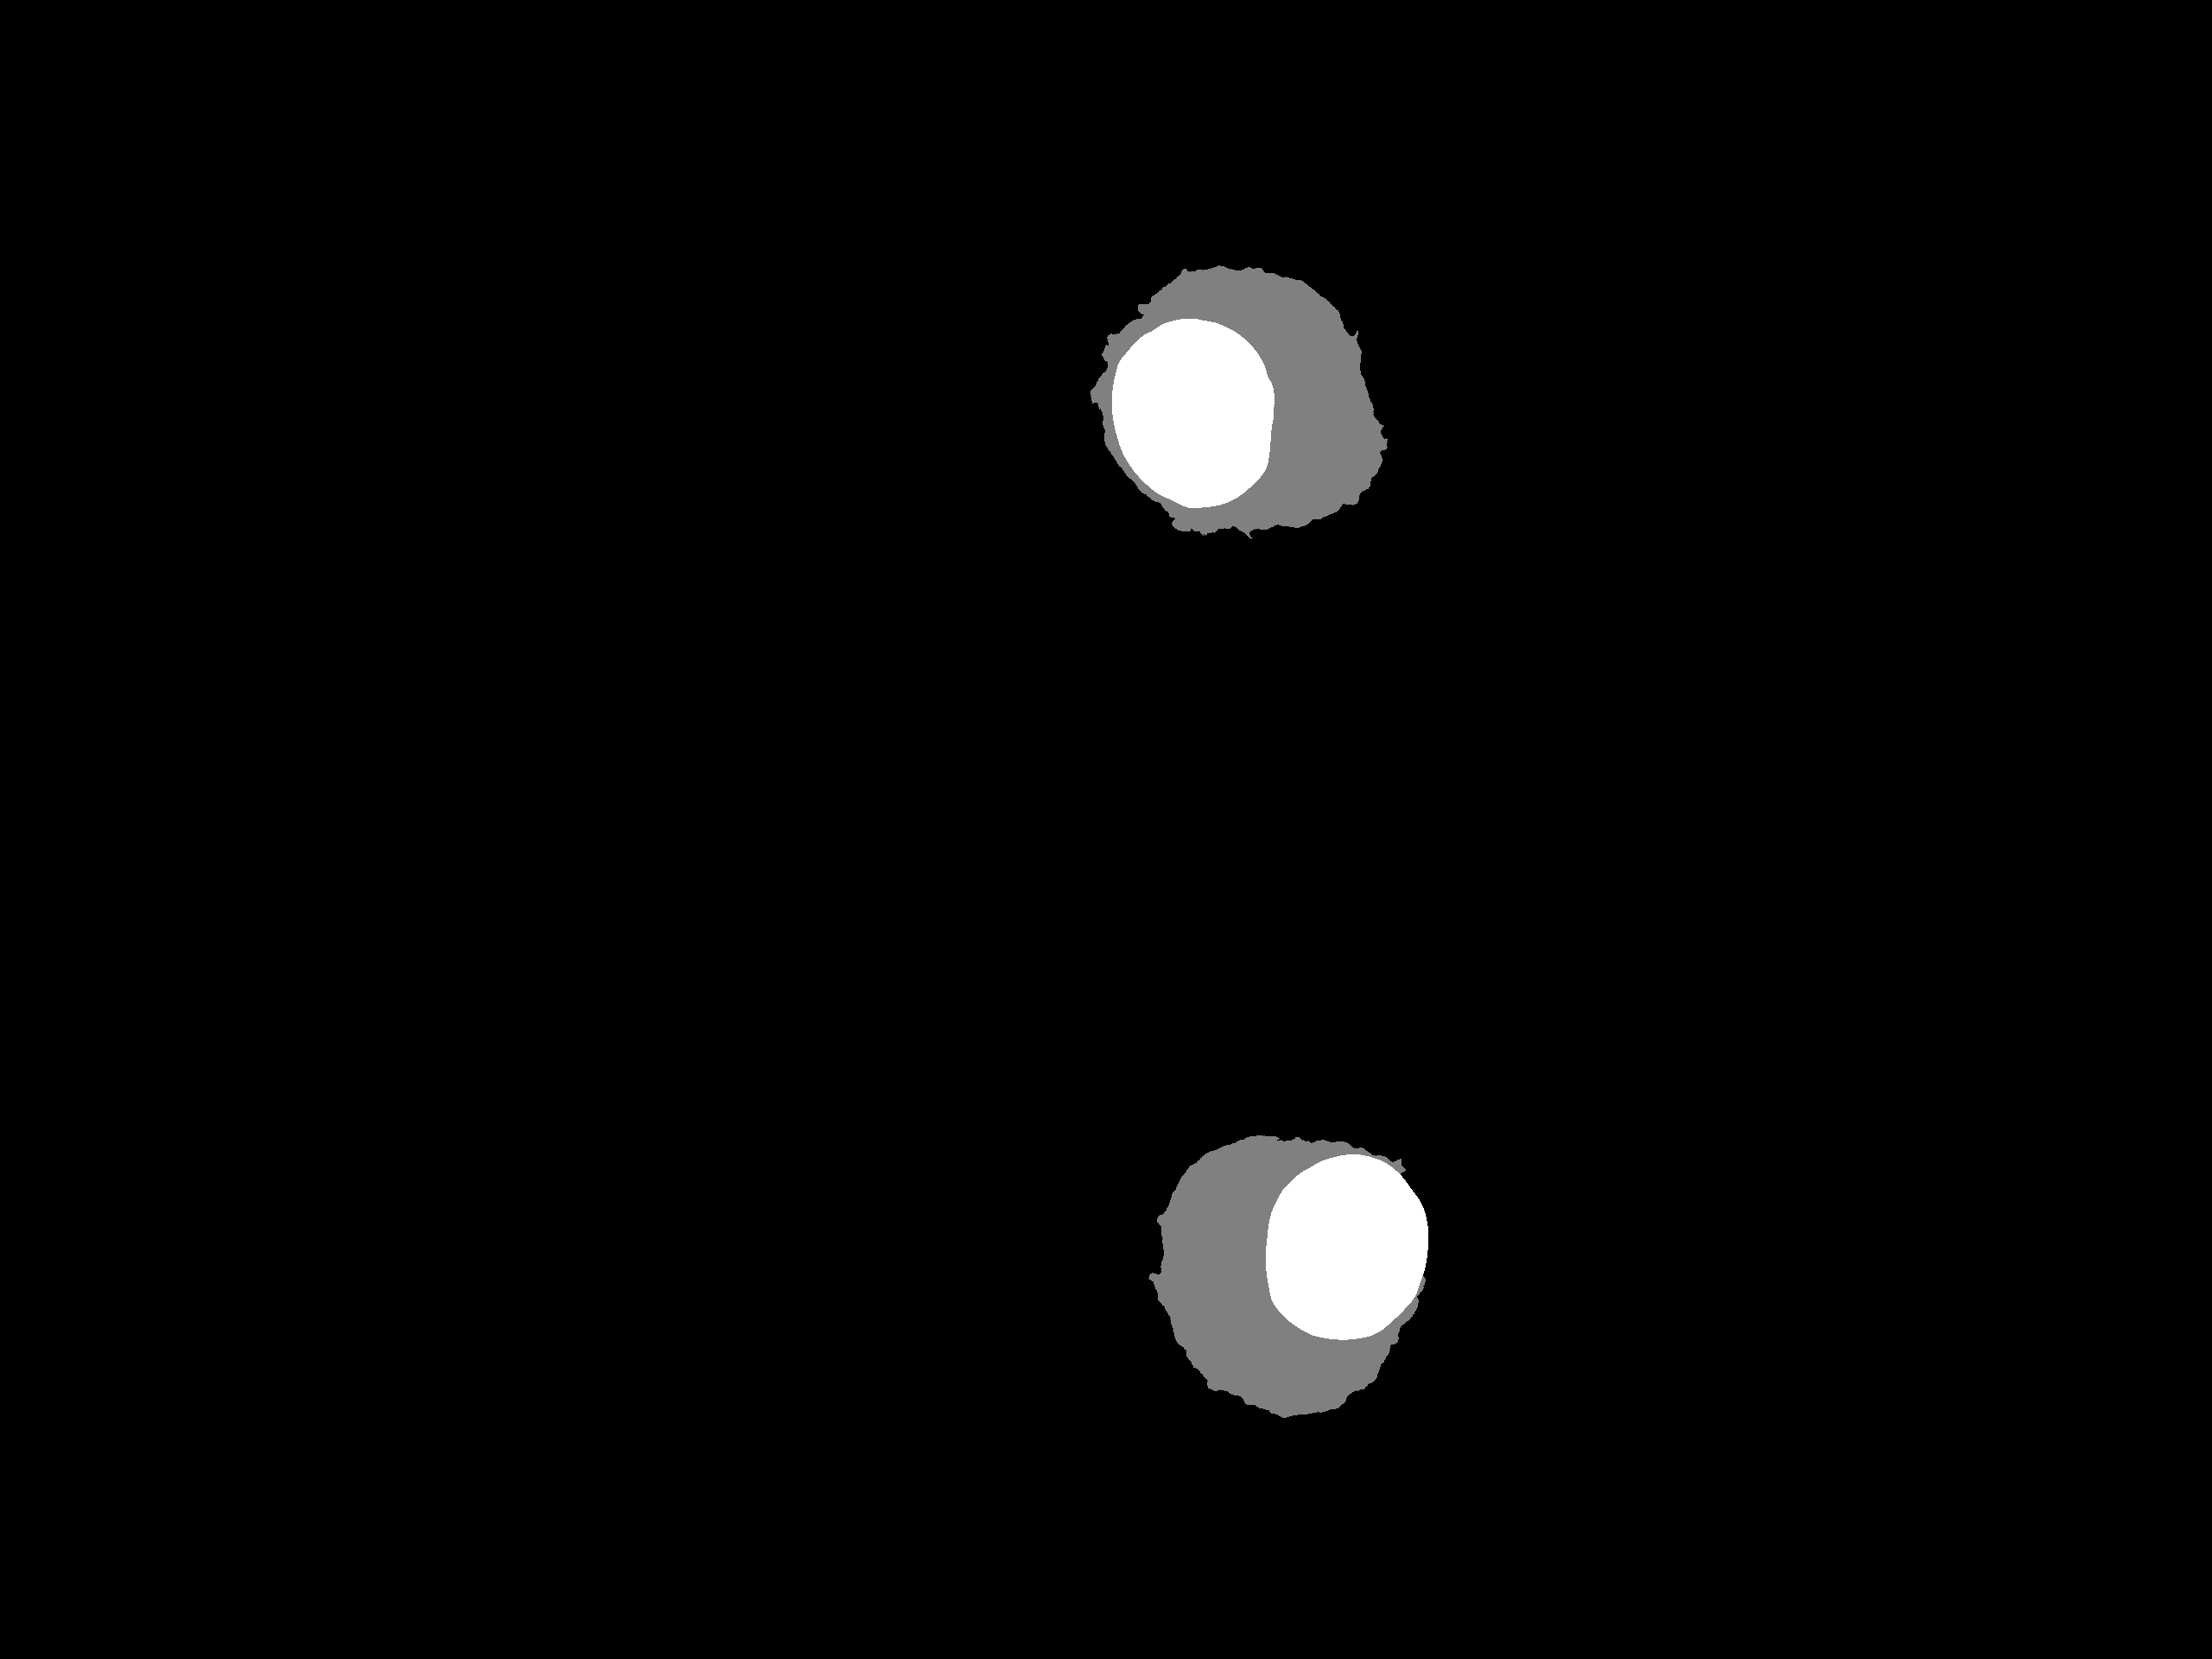
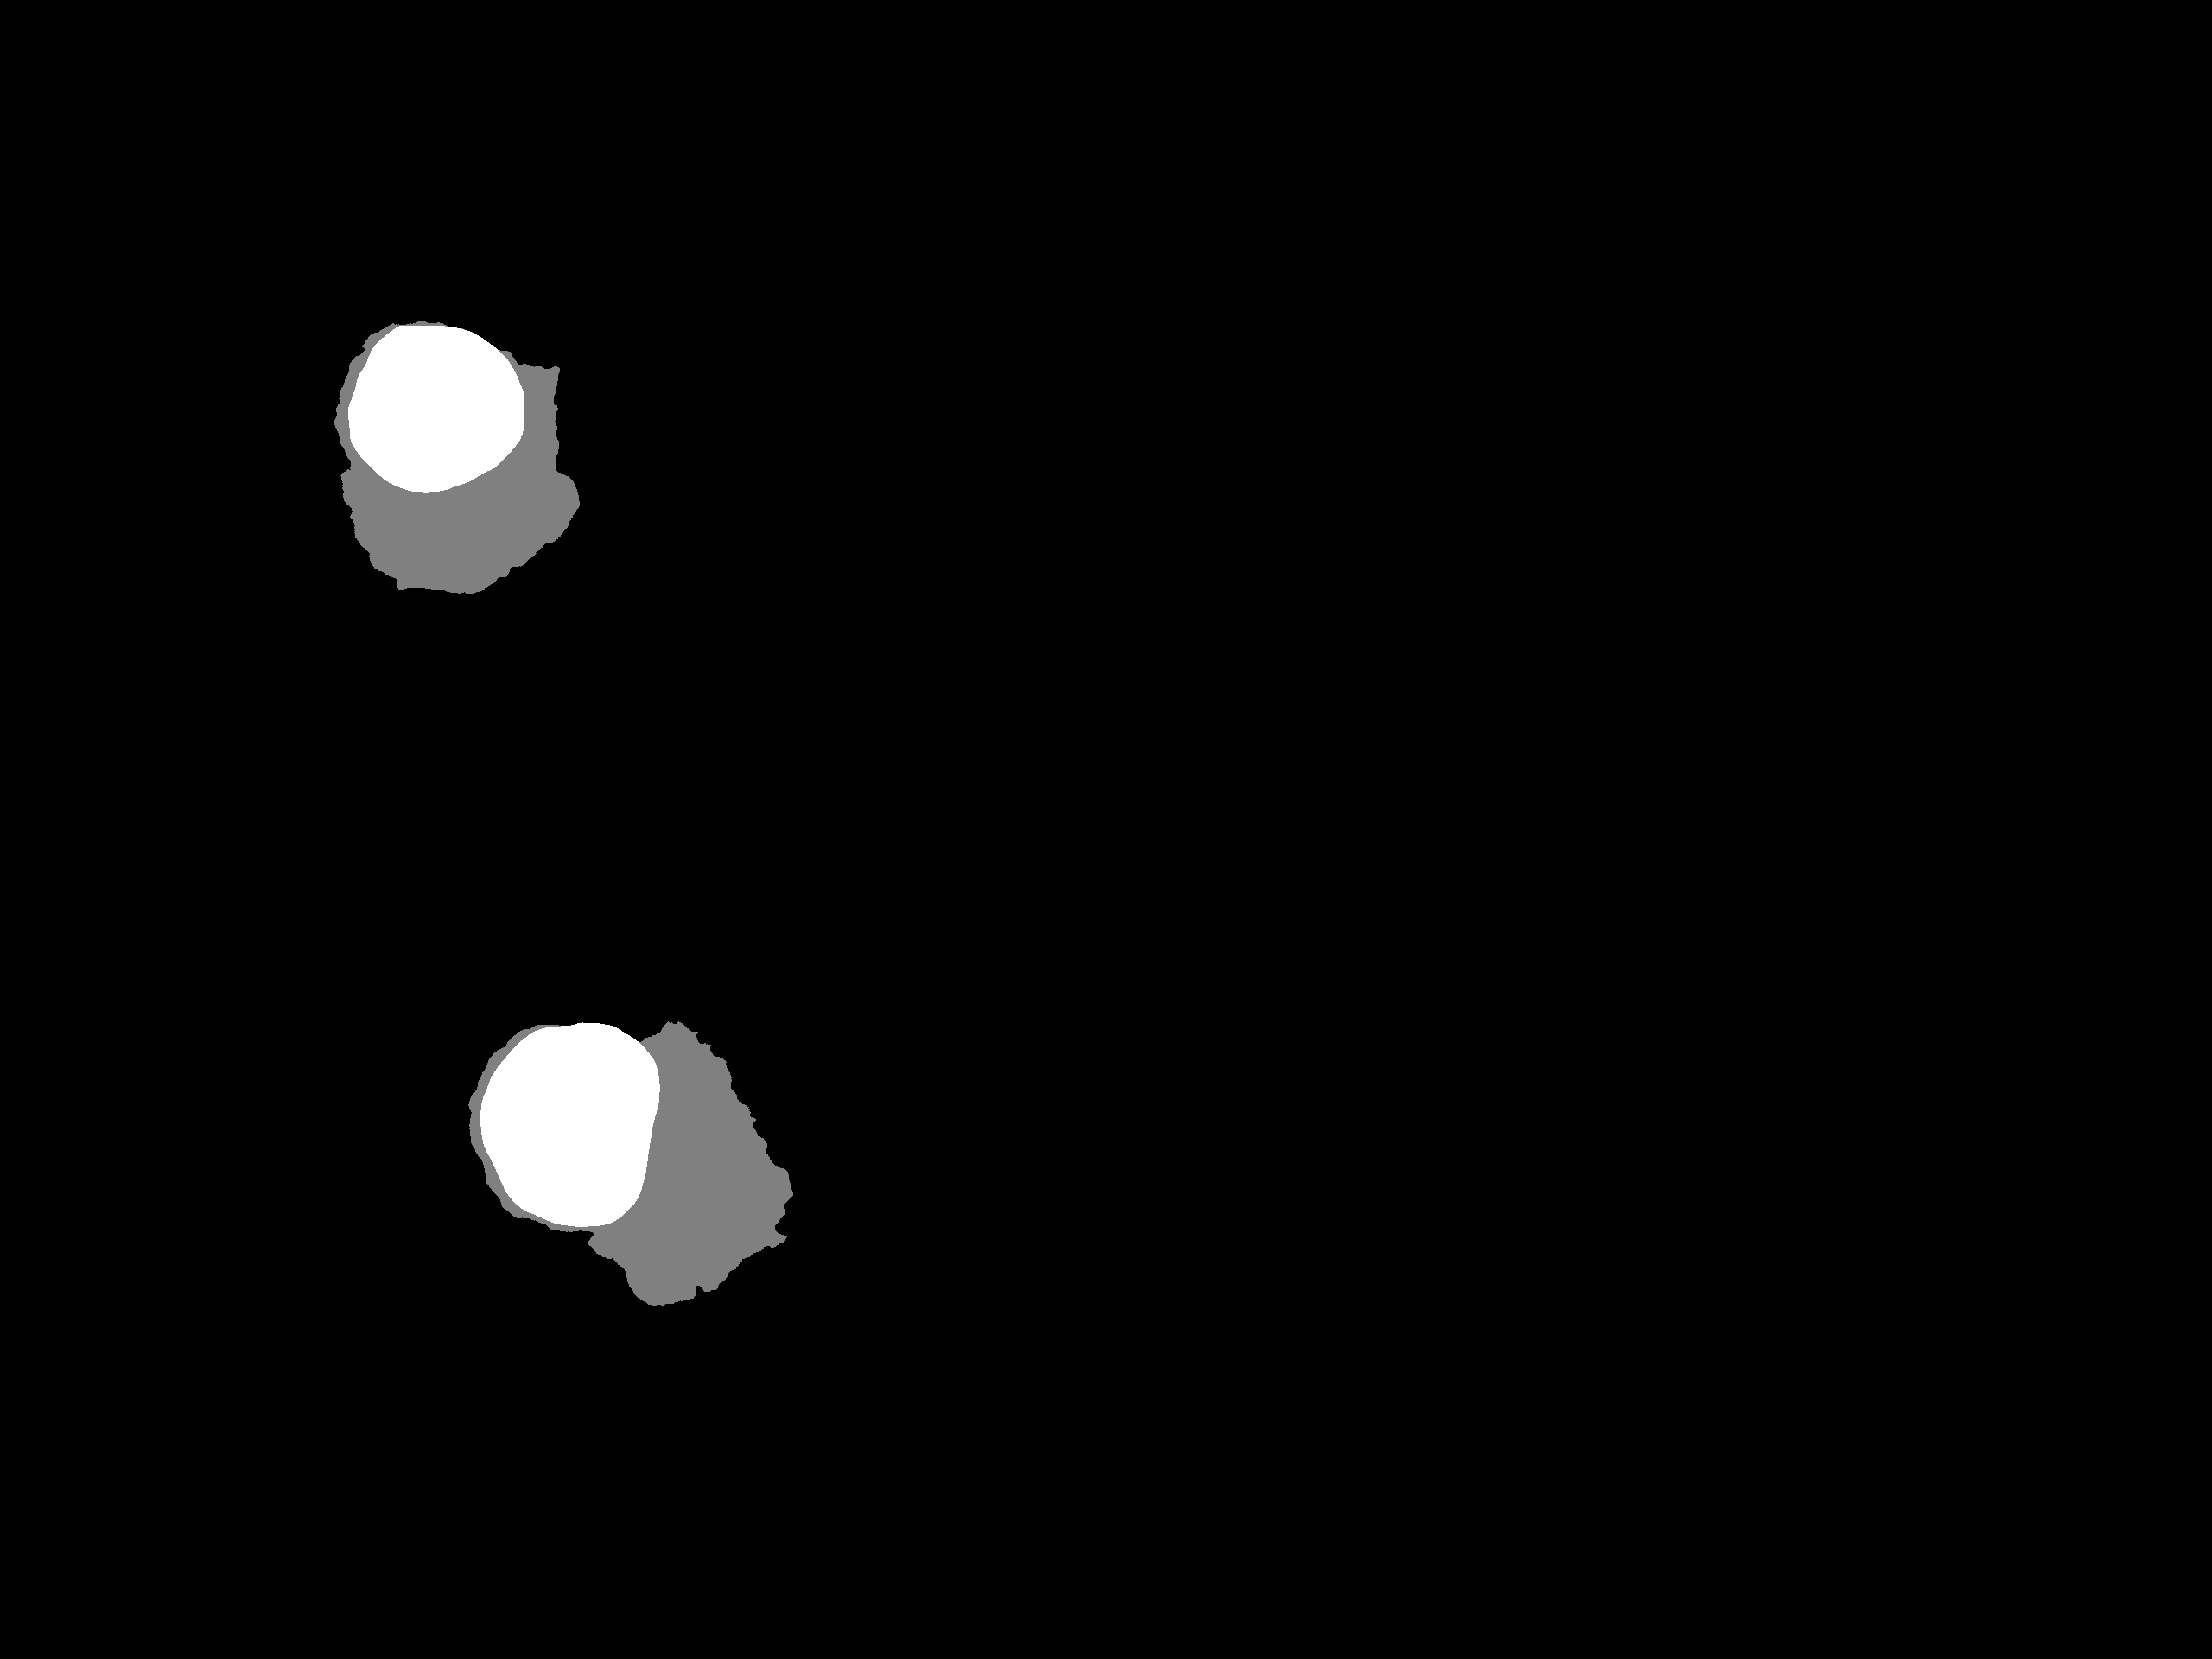
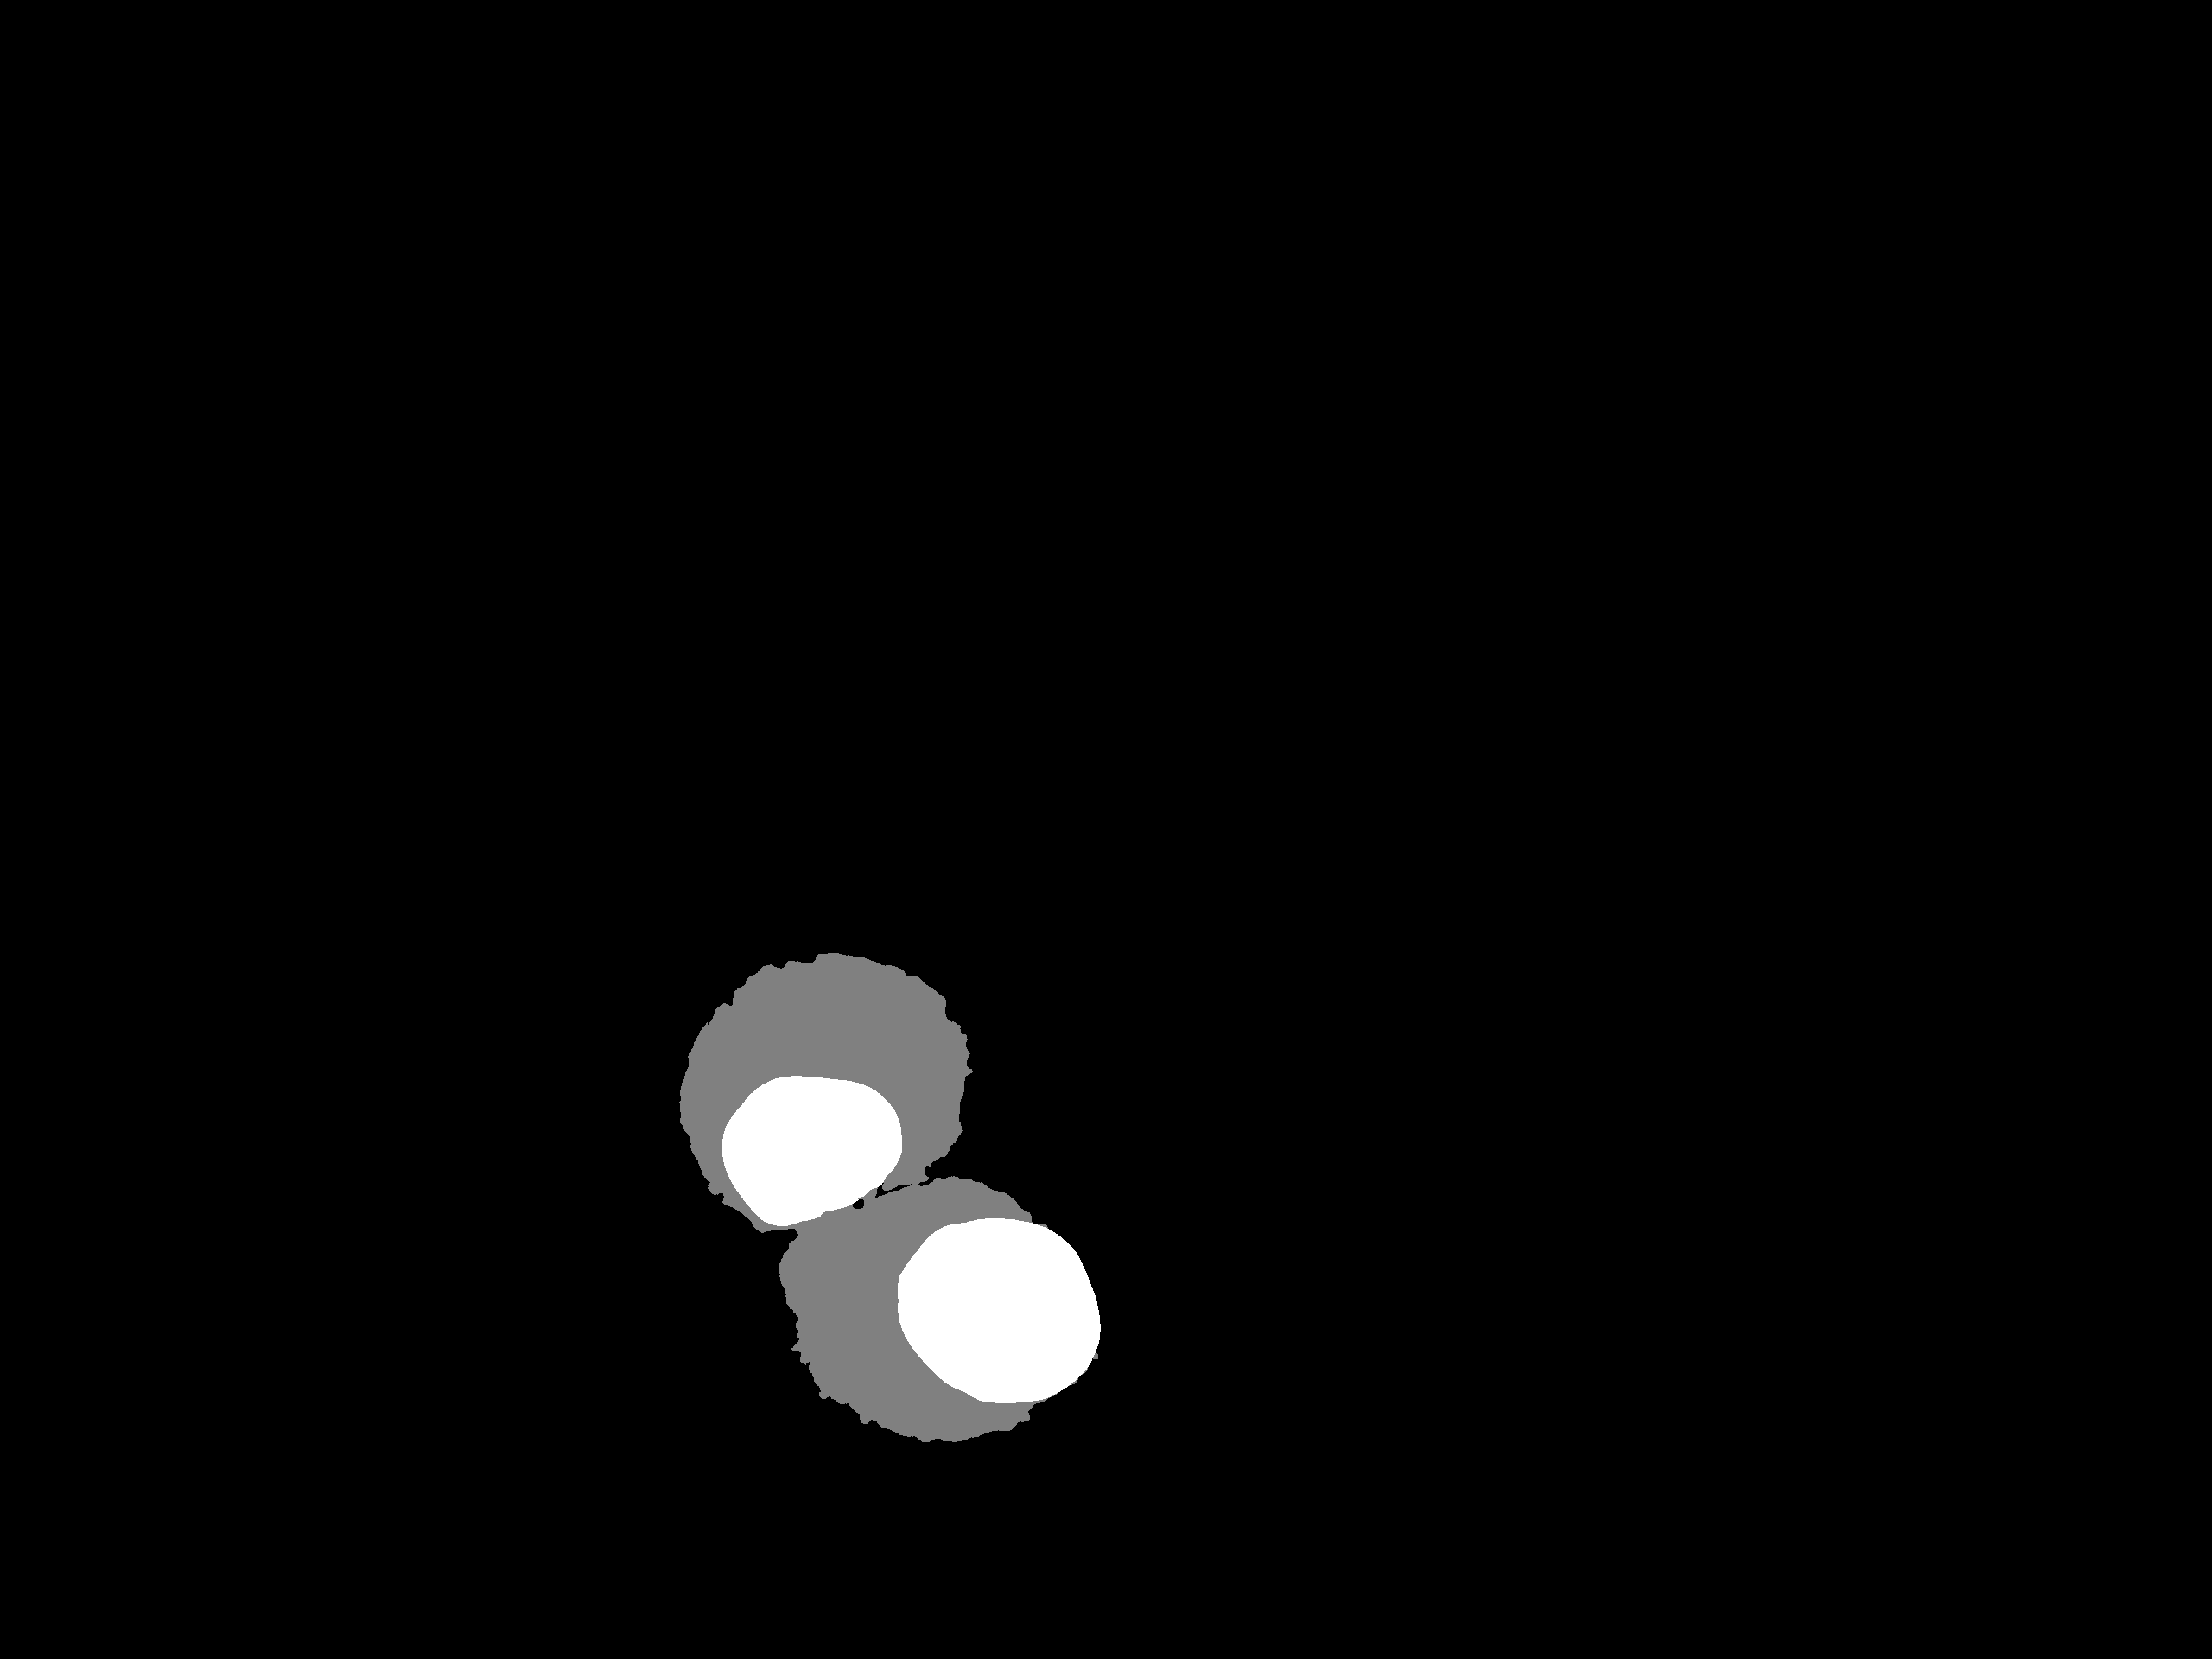
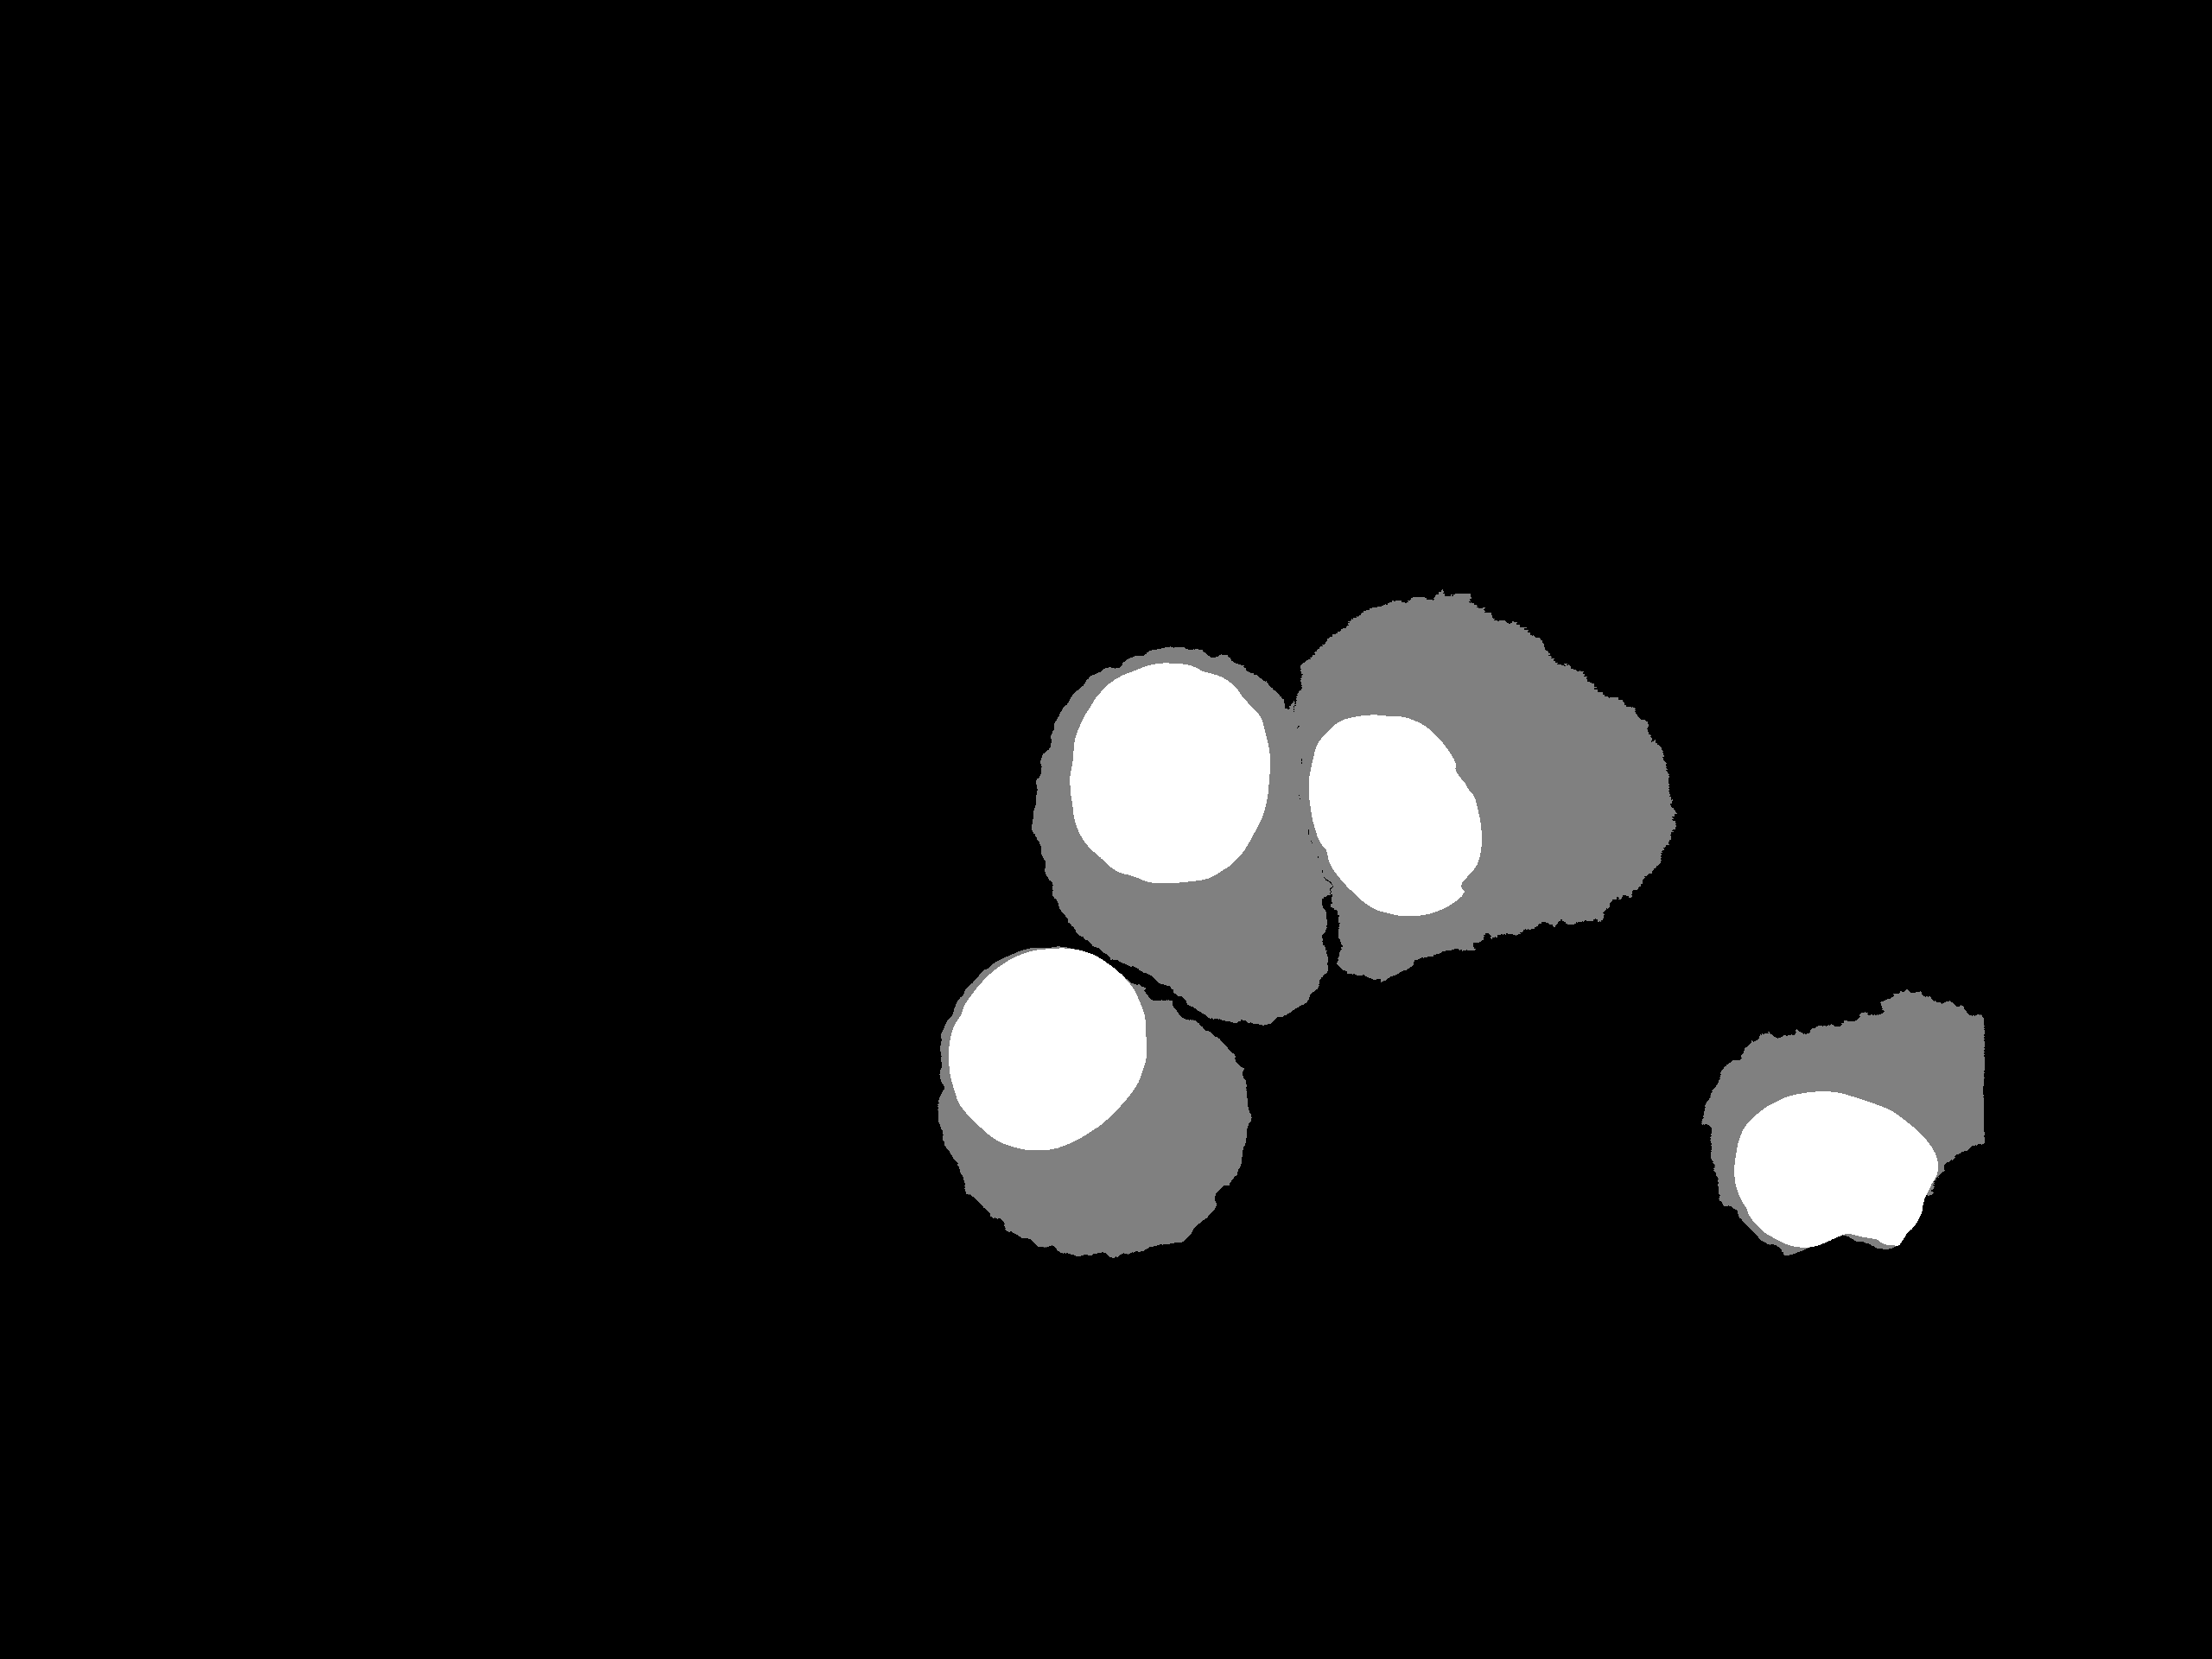
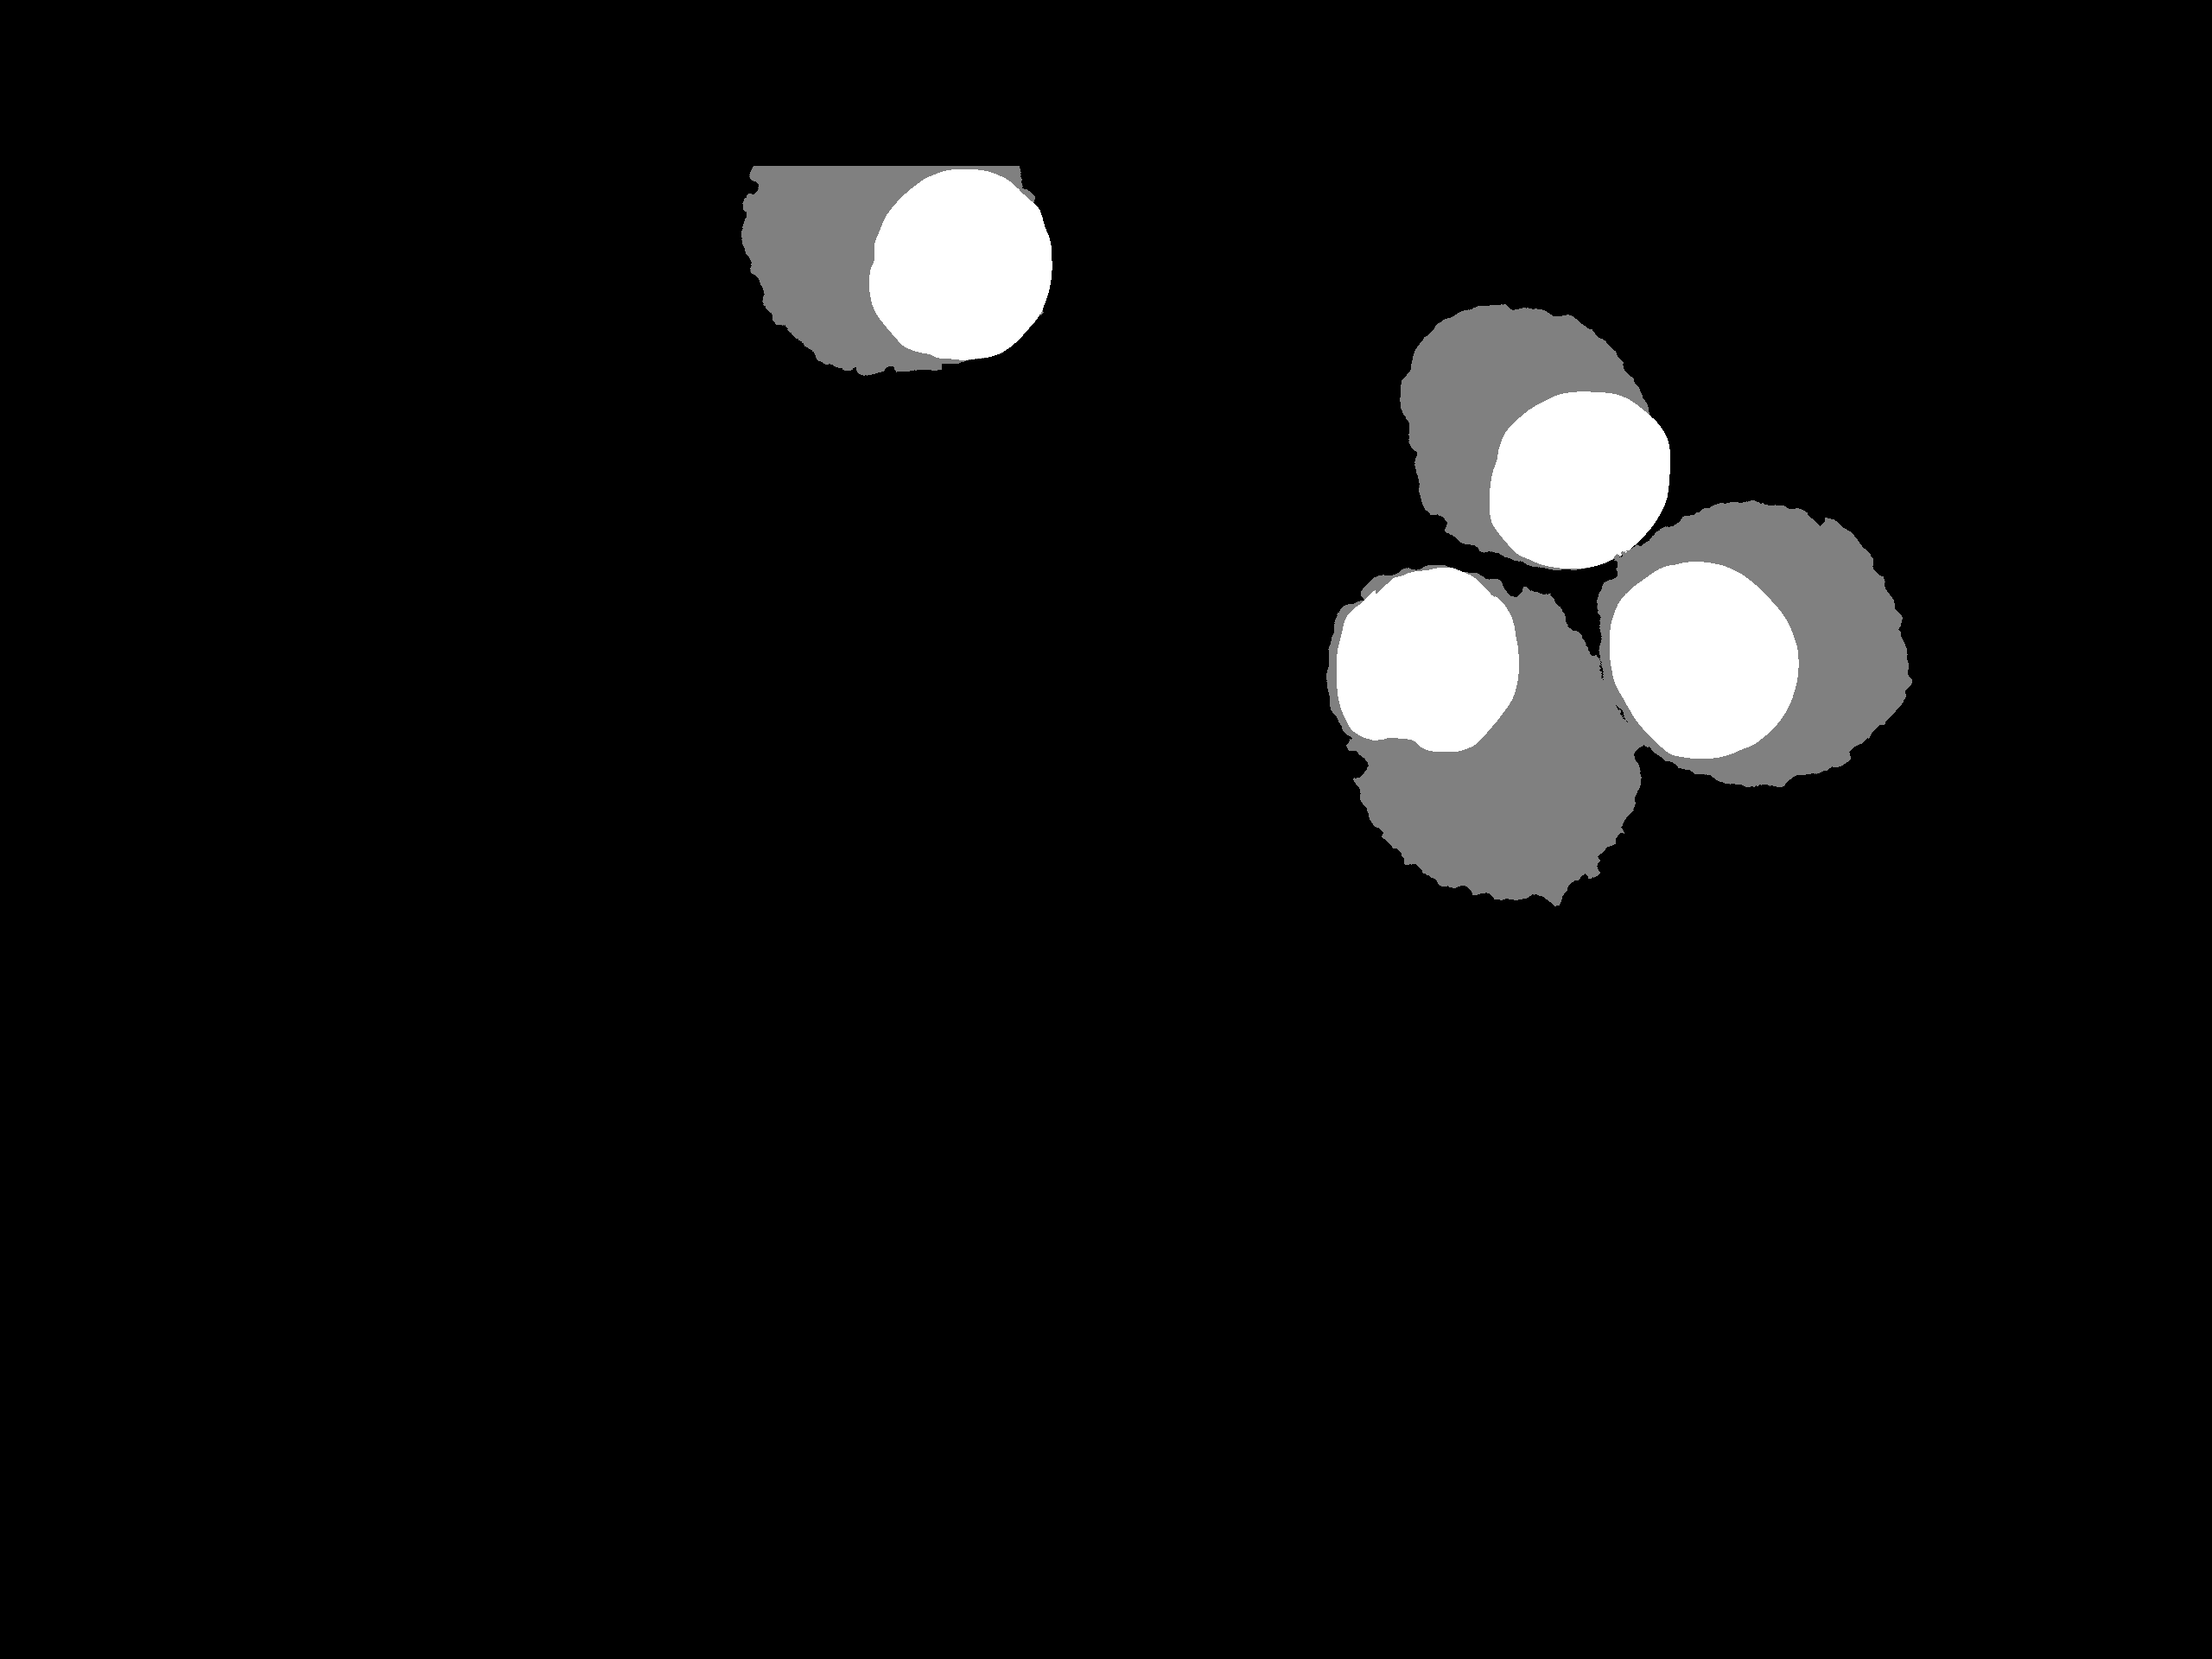
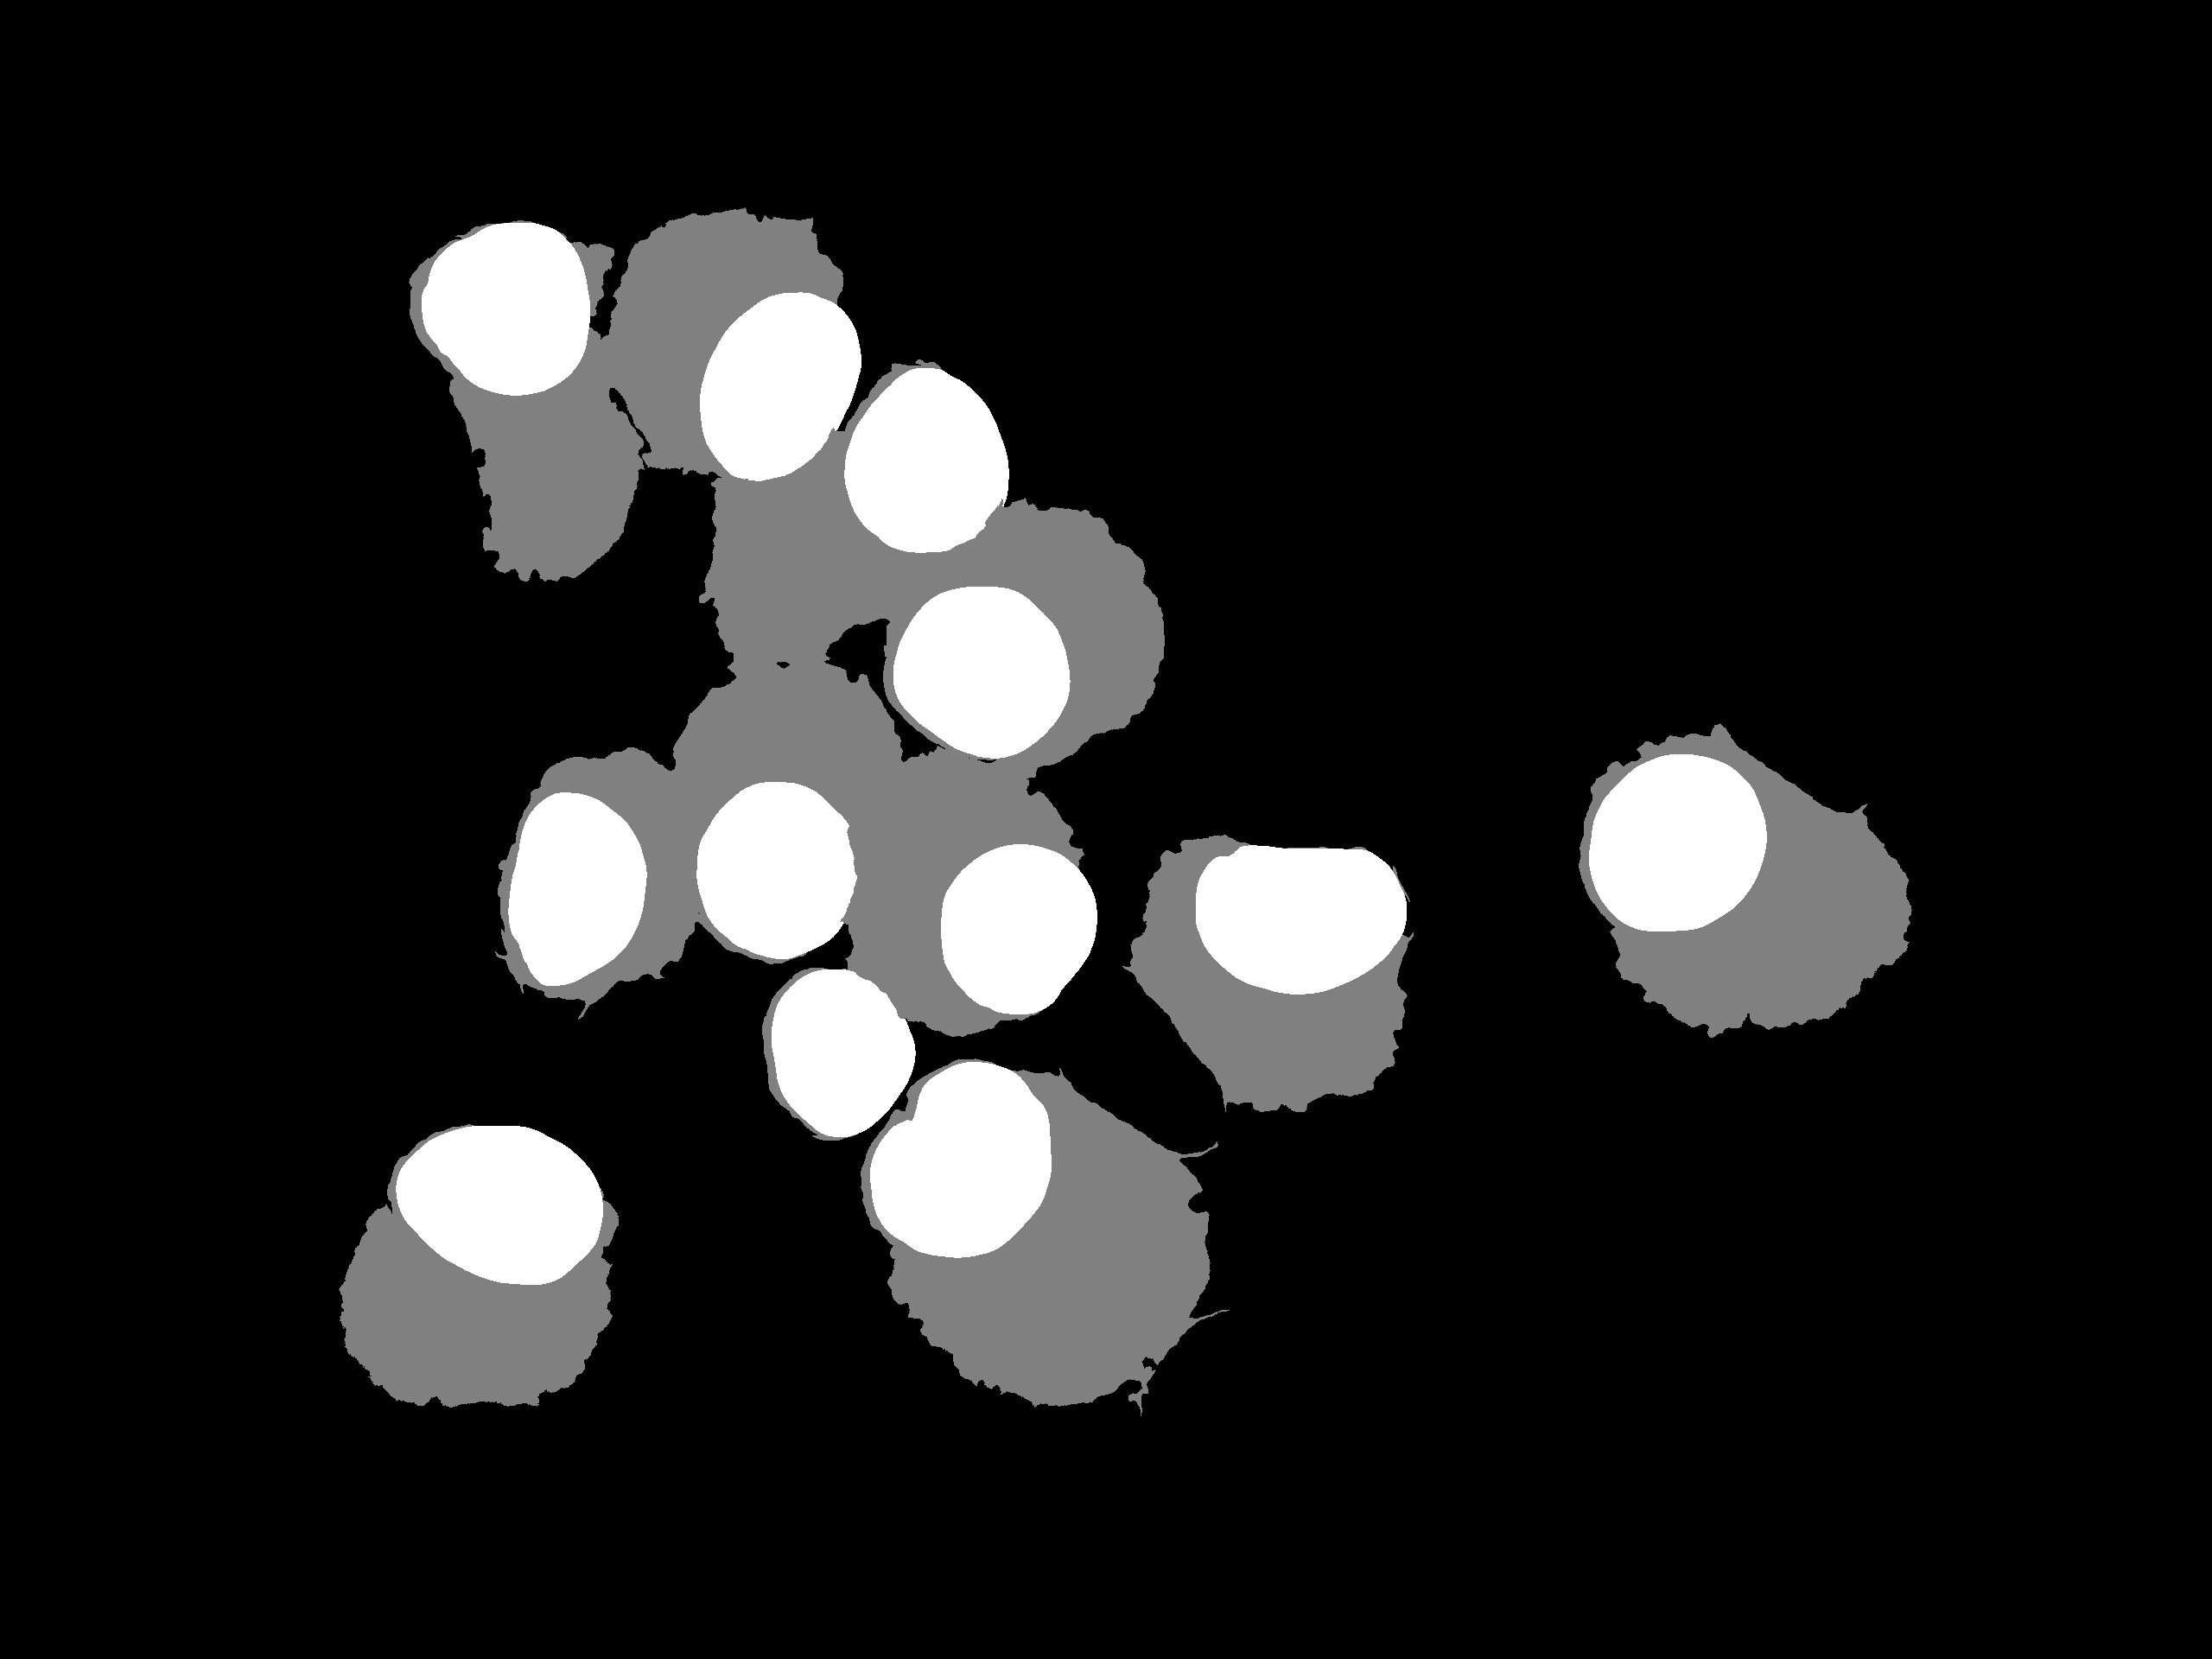
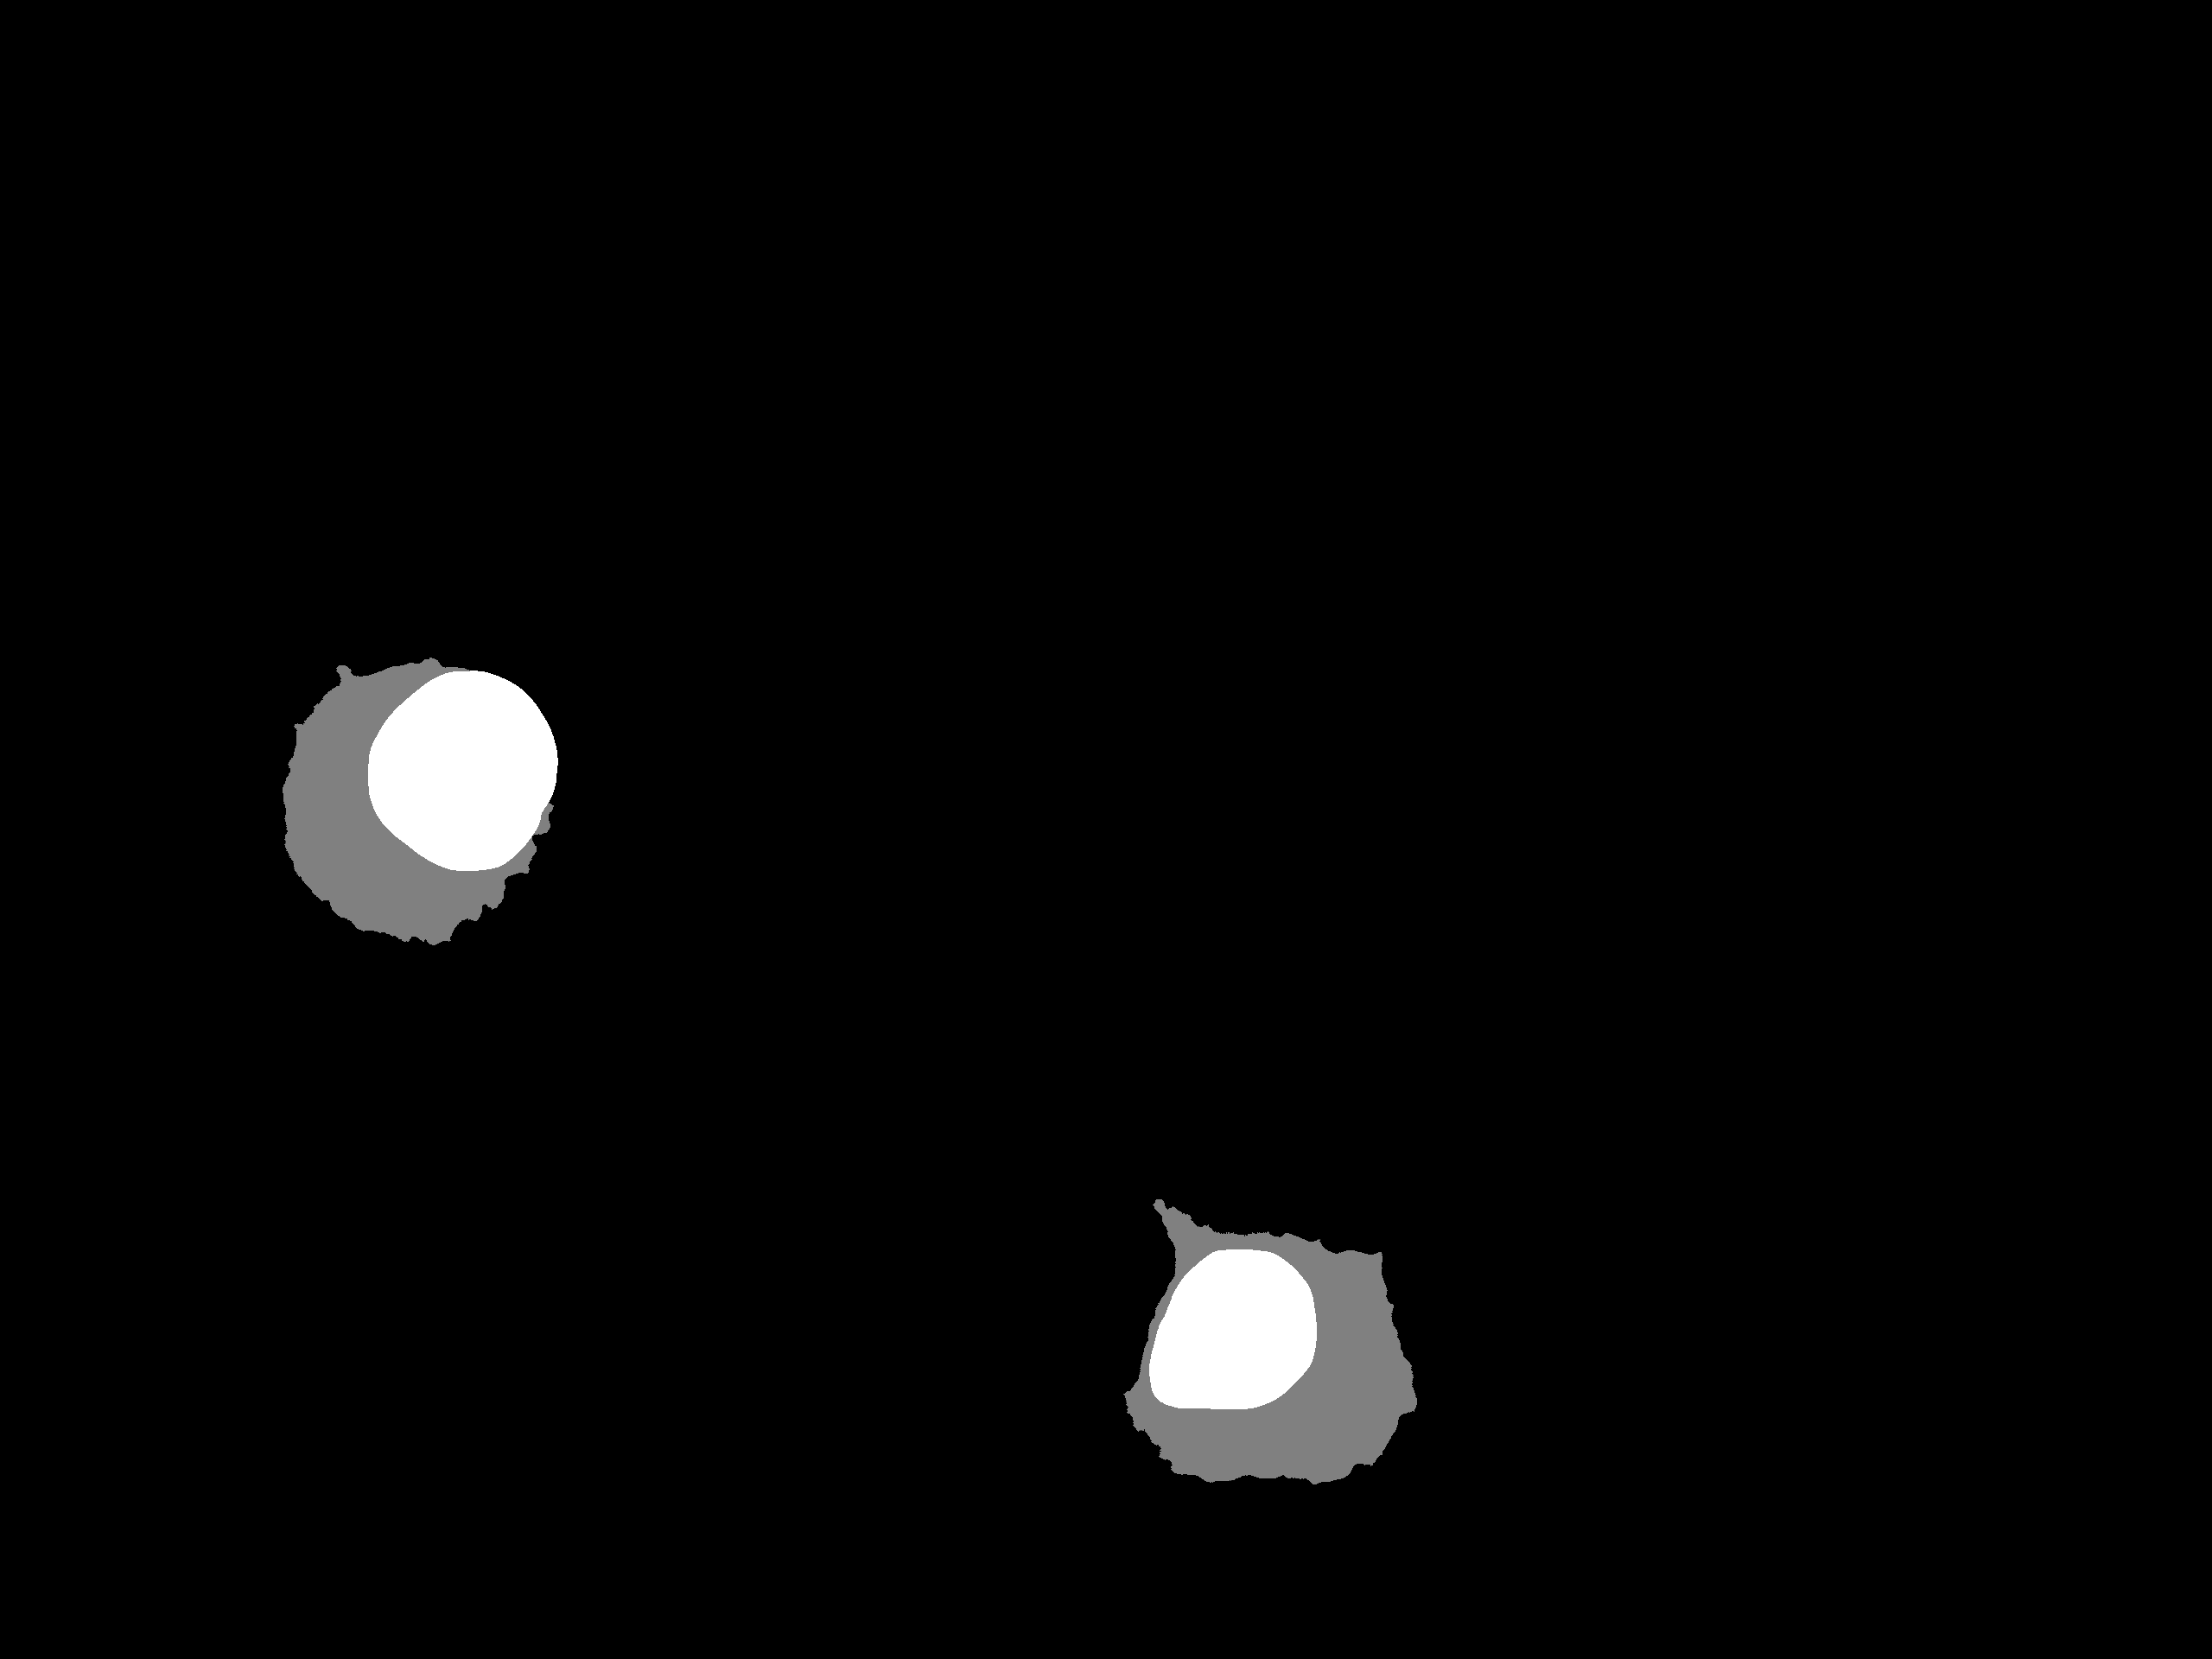

In [ ]:
# path
tr_IMGS_path = os.path.join('train','images')
tr_MANU_path = os.path.join('train','manual')

# extracting list of images
tr_images = os.listdir(tr_IMGS_path)

# selecting images of which mask is wanted
tr_images = tr_images[0:50]

# storage
annotations = np.zeros((len(tr_images),1920,2560),dtype=np.uint8)
for n, id_ in tqdm(enumerate(tr_images), total=len(tr_images)):

  manu0 = imagecodecs.imread(tr_MANU_path+'/'+id_) # N layers manual segmentations (each layer a different MM cell)

  # "compressing" segmentation annotations on a single layer
  if len(manu0.shape)==2:
    manu = np.copy(manu0[:,:])
  else:
    manu = np.copy(manu0[:,:,0])
    for j in range(1,manu0.shape[2]):
      manu[manu0[:,:,j]==255] = 255
      manu[manu0[:,:,j]==128] = 128

  # pad center the current image if it is of size 1536x2040
  if manu.shape[0] != annotations.shape[1]:
    manu = np.pad(manu,((192,192),(260,260)))

  annotations[n,:,:] = np.copy(manu)

fig = px.imshow(annotations, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR HIGHLIGHTED ROI",animation_frame="slice"))
fig.show()

* Sampling visualization images and superimposed

In [ ]:
# storing images wanted to be plotted (in the training set there are in total 300 images)
imgs = range(4)   # plot images 5 at a time (if more runtime disconnects): 0->4; 5->9; 10->14; ecc..., just change input parameters in 'range' function
originals = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked images
bm_ManuOnImg = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked images
masks = np.zeros((len(imgs),1920,2560),dtype=np.uint8) # allocating array that will contain mask images
N_D_masks = []  # allocating array that will contain N-D mask images (to check order in which masks are stored for each patch)
masks_w_overlap = np.zeros((len(imgs),1920,2560),dtype=np.uint8) # allocating array that will contain mask image in which eventual mask overlappings are highlighted
bm_ManuOnRChann = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked Red channel
bm_ManuOnGChann = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked Green channel
bm_ManuOnBChann = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked Blue channel
hp2 = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain hypothetical 2 labels (0,1) segmentation (ROI recognition), boundary marked

for i in range(len(imgs)):

  img = imread(os.path.join(tr_IMGS_path,tr_images[imgs[i]])) # uint8 stained image
  N_D_masks.append(imagecodecs.imread(os.path.join(tr_MANU_path,tr_images[imgs[i]])))  # N-D image containing manual segmentations (each layer a different MM cell, 128 = cytoplasm | 255 = nucleus)
  hp2_curr = (((img[:,:,2] - np.min(img[:,:,0:1],2))) > 45).astype(np.uint8)*255
  hp2_curr = binary_opening(hp2_curr) # morphological opening trial on raw ROI recognition

  if len(N_D_masks[i].shape)==2: # if there is only 1 MM cell in the current image
    manu = np.copy(N_D_masks[i]) # merge the N layers segmentation in a unique greyscale image
    manu_w_overlap = np.copy(N_D_masks[i])
  else: # if there are more than 1 MM cell in the current image
    manu = np.sum(N_D_masks[i],2,np.uint8) # merge the N layers segmentation in a unique greyscale image
    manu_w_overlap = np.copy(N_D_masks[i][:,:,0])
    for j in range(1,N_D_masks[i].shape[2]):
      manu_w_overlap[N_D_masks[i][:,:,j]==255] = 255
      manu_w_overlap[(N_D_masks[i][:,:,j]==128) * (manu_w_overlap==128) ] = 192
      manu_w_overlap[(N_D_masks[i][:,:,j]==128) * (manu_w_overlap==0) ] = 128

  bound_marked = img_as_ubyte(mark_boundaries(img,manu,color=(1,1,0),mode='thick')) #mark boundaries on original stained image
  bound_markedR = img_as_ubyte(mark_boundaries(img[:,:,0],manu,color=(1,1,0),mode='thick')) #mark boundaries on R channel
  bound_markedG = img_as_ubyte(mark_boundaries(img[:,:,1],manu,color=(1,1,0),mode='thick')) #mark boundaries on G channel
  bound_markedB = img_as_ubyte(mark_boundaries(img[:,:,2],manu,color=(1,1,0),mode='thick')) #mark boundaries on B channel
  hp2_curr = img_as_ubyte(mark_boundaries(hp2_curr,manu,color=(1,0,0),mode='thick'))  #mark boundaries on highlighted ROI

  if img.shape[0] != originals.shape[1]:
    # pad center the current image if it is of size 1536x2040
    img = np.pad(img,((192,192),(260,260),(0,0)))
    bound_marked = np.pad(bound_marked,((192,192),(260,260),(0,0)))
    manu = np.pad(manu,((192,192),(260,260)))
    if len(N_D_masks[i].shape)==2:
      N_D_masks[i] = np.pad(N_D_masks[i],((192,192),(260,260)))
    else:
      N_D_masks[i] = np.pad(N_D_masks[i],((192,192),(260,260),(0,0)))
    manu_w_overlap = np.pad(manu_w_overlap,((192,192),(260,260)))
    bound_markedR = np.pad(bound_markedR,((192,192),(260,260),(0,0)))
    bound_markedG = np.pad(bound_markedG,((192,192),(260,260),(0,0)))
    bound_markedB = np.pad(bound_markedB,((192,192),(260,260),(0,0)))
    hp2_curr = np.pad(hp2_curr,((192,192),(260,260),(0,0)))

  # filling boundary marked object
  originals[i,:,:,:] = np.copy(img)
  bm_ManuOnImg[i,:,:,:] = np.copy(bound_marked)
  masks[i,:,:] = np.copy(manu)
  masks_w_overlap[i,:,:] = np.copy(manu_w_overlap)
  bm_ManuOnRChann[i,:,:,:] = np.copy(bound_markedR)
  bm_ManuOnGChann[i,:,:,:] = np.copy(bound_markedG)
  bm_ManuOnBChann[i,:,:,:] = np.copy(bound_markedB)
  hp2[i,:,:,:] = np.copy(hp2_curr)

fig = px.imshow(originals, animation_frame=0, binary_string=True, labels=dict(x="ORIGINAL GIEMSA STAINED IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnImg, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON GIEMSA STAINED IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(masks, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK - OVERLAPPINGS NOT HIGHLIGHTED",animation_frame="slice"))  #notice for these also contours in case of overlapping are not the correct ones
fig.show()
for i in range(len(imgs)):
  if len(N_D_masks[i].shape)==3:
    fig = px.imshow(N_D_masks[i], animation_frame = 2, binary_string=True, labels=dict(x="N-D MANUAL MASK OF i-th PATCH",animation_frame="slice"))
    fig.show()
fig = px.imshow(masks_w_overlap, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK - OVERLAPPINGS HIGHLIGHTED",animation_frame="slice"))
fig.show()
fig = px.imshow(hp2, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR HIGHLIGHTED ROI",animation_frame="slice"))
fig.show()
# fig = px.imshow(bm_ManuOnRChann, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON R CHANNEL",animation_frame="slice"))
# fig.show()
# fig = px.imshow(bm_ManuOnGChann, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON G CHANNEL",animation_frame="slice"))
# fig.show()
# fig = px.imshow(bm_ManuOnBChann, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON B CHANNEL",animation_frame="slice"))
# fig.show()

# ----> COMMENTS ON MASKS: it can be appreciated the fact that manual masks are
#       stored in order of descending extreme coordinate of nuclei and, in the
#       eventual case of parity of 2 ore more nuclei, from left to right...
#       NO, after a more exhaustive looking over manual masks this is not true.
#       Moreover cell segmented on different layers can be overlapping in space
#       if "compressed" on a single layer(for exampla as done above summing
#       values of manual masks along the layers)

* Contrast enhancement

In [ ]:
# storing images wanted to be plotted (in the training set there are in total 300 images)
imgs = range(1)   # plot images 1 at a time (if more runtime disconnects)
bm_ManuOnEnh = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (equalization) images
bm_ManuOnAdEnh = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (adaptive equalization) images
bm_ManuOnEnh4L = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (equalization 4 layers) images
bm_ManuOnAdEnh4L = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (adaptive equalization 4 layers) images
bm_ManuOnEnh1_994L = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (1-99 equalization 4 layers) images
bm_ManuOnEnhYCrCb = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (YCrCb equalization) images
bm_ManuOnAdEnhYCrCb = np.zeros((len(imgs),1920,2560,3),dtype=np.uint8) # allocating array that will contain boundary marked contrast enhanced (YCrCb adaptive equalization) images

for i in range(len(imgs)):

  img = imread(os.path.join(tr_IMGS_path,tr_images[i])) # uint8 stained image
  R = np.copy(img[:,:,0])
  G = np.copy(img[:,:,1])
  B = np.copy(img[:,:,2])

  # equalization on whole image (3 layers togherher)
  Enh = exposure.equalize_hist(img)
  AdEnh = exposure.equalize_adapthist(img)

  # equalization on each layer separately
  Enh4L = np.stack((exposure.equalize_hist(R),exposure.equalize_hist(G),exposure.equalize_hist(B)),2)
  AdEnh4L = np.stack((exposure.equalize_adapthist(img[:,:,0]),exposure.equalize_adapthist(img[:,:,1]),exposure.equalize_adapthist(img[:,:,2])),2)

  # p1-p99 contrast enhancement
  qR = np.quantile(R,[0.01, 0.99])
  qG = np.quantile(G,[0.01, 0.99])
  qB = np.quantile(B,[0.01, 0.99])
  R[R<qR[0]] = qR[0]
  R[R>qR[1]] = qR[1]
  R = (R - R.min())/(R.max() - R.min())
  G[G<qG[0]] = qG[0]
  G[G>qG[1]] = qG[1]
  G = (G - G.min())/(G.max() - G.min())
  B[B<qB[0]] = qB[0]
  B[B>qB[1]] = qB[1]
  B = (B - B.min())/(B.max() - B.min())
  p1_99 = np.stack((R,G,B),2)

  # contrast enhancement using info only in intensity channe
  ycrcb_img4Eq = ycrcb_img4AdEq = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)  # convert from RGB color-space to YCrCb
  ycrcb_img4Eq[:, :, 0] = cv2.equalizeHist(ycrcb_img4Eq[:, :, 0])  # equalize the histogram of the Y channel
  ycrcb_img4AdEq[:, :, 0] = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(ycrcb_img4AdEq[:, :, 0])  # equalize the histogram of the Y channel
  equalized_img = cv2.cvtColor(ycrcb_img4Eq, cv2.COLOR_YCrCb2BGR)  # convert back to RGB color-space from YCrCb
  Ad_equalized_img = cv2.cvtColor(ycrcb_img4AdEq, cv2.COLOR_YCrCb2BGR)  # convert back to RGB color-space from YCrCb

  manu = imagecodecs.imread(os.path.join(tr_MANU_path,tr_images[i]))  # N-D image containing manual segmentations (each layer a different MM cell, 128 = cytoplasm | 255 = nucleus)
  if len(manu.shape)>2: # if there is more than 1 MM cell in the current image
    manu = np.sum(manu,2,np.uint8) # merge the N layers segmentation in a unique greyscale image

  bound_markedEnh = img_as_ubyte(mark_boundaries(Enh,manu,color=(1,1,0),mode='thick')) #mark boundaries
  bound_markedAdEnh = img_as_ubyte(mark_boundaries(AdEnh,manu,color=(1,1,0),mode='thick')) #mark boundaries
  bound_markedEnh4L = img_as_ubyte(mark_boundaries(Enh4L,manu,color=(1,1,0),mode='thick')) #mark boundaries
  bound_markedAdEnh4L = img_as_ubyte(mark_boundaries(AdEnh4L,manu,color=(1,1,0),mode='thick')) #mark boundaries
  bound_markedEnh1_994L = img_as_ubyte(mark_boundaries(p1_99,manu,color=(1,1,0),mode='thick')) #mark boundaries
  bound_markedEnhYCrCb = img_as_ubyte(mark_boundaries(equalized_img,manu,color=(1,1,0),mode='thick')) #mark boundaries
  bound_markedAdEnhYCrCb = img_as_ubyte(mark_boundaries(Ad_equalized_img,manu,color=(1,1,0),mode='thick')) #mark boundaries

  if bound_markedEnh.shape[0] != bm_ManuOnEnh.shape[1]:
    # pad center the current image if it is of size 1536x2040
    bound_markedEnh = np.pad(bound_markedEnh,((192,192),(260,260),(0,0)))
    bound_markedAdEnh = np.pad(bound_markedAdEnh,((192,192),(260,260),(0,0)))
    bound_markedEnh4L = np.pad(bound_markedEnh4L,((192,192),(260,260),(0,0)))
    bound_markedAdEnh4L = np.pad(bound_markedAdEnh4L,((192,192),(260,260),(0,0)))
    bound_markedEnh1_994L = np.pad(bound_markedEnh1_994L,((192,192),(260,260),(0,0)))
    bound_markedEnhYCrCb = np.pad(bound_markedEnhYCrCb,((192,192),(260,260),(0,0)))
    bound_markedAdEnhYCrCb = np.pad(bound_markedAdEnhYCrCb,((192,192),(260,260),(0,0)))

  # filling boundary marked object
  bm_ManuOnEnh[i,:,:,:] = np.copy(bound_markedEnh)
  bm_ManuOnAdEnh[i,:,:,:] = np.copy(bound_markedAdEnh)
  bm_ManuOnEnh4L[i,:,:,:] = np.copy(bound_markedEnh4L)
  bm_ManuOnAdEnh4L[i,:,:,:] = np.copy(bound_markedAdEnh4L)
  bm_ManuOnEnh1_994L[i,:,:,:] = np.copy(bound_markedEnh1_994L)
  bm_ManuOnEnhYCrCb[i,:,:,:] = np.copy(bound_markedEnhYCrCb)
  bm_ManuOnAdEnhYCrCb[i,:,:,:] = np.copy(bound_markedAdEnhYCrCb)

fig = px.imshow(bm_ManuOnEnh, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON EQUILIZED IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnAdEnh, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON ADAPTIVELY EQUALIZED IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnEnh4L, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON EQUALIZED FOR LAYERS IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnAdEnh4L, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON ADAPTIVELY EQUALIZED FOR LAYERS IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnEnh1_994L, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON p1-p99 EQUALIZED FOR LAYERS IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnAdEnhYCrCb, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON EQUALIZED THROUGH YCrCb IMAGE",animation_frame="slice"))
fig.show()
fig = px.imshow(bm_ManuOnAdEnhYCrCb, animation_frame=0, binary_string=True, labels=dict(x="MANUAL MASK CONTOUR ON ADAPTIVELY EQUALIZED THROUGH YCrCb IMAGE",animation_frame="slice"))
fig.show()

#%whos

* Resizing


In [ ]:
sizes = [256, 512, 1024, 2048, 4096]
imgs = range(1)   # plot images 1 at a time (if more runtime disconnects)

size1 = np.zeros((len(imgs),sizes[0],sizes[0],3),dtype=np.uint8) # allocating array that will contain resized to size 1 images
size2 = np.zeros((len(imgs),sizes[1],sizes[1],3),dtype=np.uint8) # allocating array that will contain resized to size 2 images
size3 = np.zeros((len(imgs),sizes[2],sizes[2],3),dtype=np.uint8) # allocating array that will contain resized to size 3 images
size4 = np.zeros((len(imgs),sizes[3],sizes[3],3),dtype=np.uint8) # allocating array that will contain resized to size 4 images
size5 = np.zeros((len(imgs),sizes[4],sizes[4],3),dtype=np.uint8) # allocating array that will contain resized to size 5 images

for i in range(len(imgs)):

  img = imread(os.path.join(tr_IMGS_path,tr_images[i])) # uint8 stained image

  # resizing
  curr1 = img_as_ubyte(resize(img,[sizes[0],sizes[0],3]))
  curr2 = img_as_ubyte(resize(img,[sizes[1],sizes[1],3]))
  curr3 = img_as_ubyte(resize(img,[sizes[2],sizes[2],3]))
  curr4 = img_as_ubyte(resize(img,[sizes[3],sizes[3],3]))
  curr5 = img_as_ubyte(resize(img,[sizes[4],sizes[4],3]))

  # filling resized arrays
  size1[i,:,:,:] = np.copy(curr1)
  size2[i,:,:,:] = np.copy(curr2)
  size3[i,:,:,:] = np.copy(curr3)
  size4[i,:,:,:] = np.copy(curr4)
  size5[i,:,:,:] = np.copy(curr5)

fig = px.imshow(size1, animation_frame=0, binary_string=True, labels=dict(x="RESIZING 256 X 256",animation_frame="slice"))
fig.show()
fig = px.imshow(size2, animation_frame=0, binary_string=True, labels=dict(x="RESIZING 512 X 512",animation_frame="slice"))
fig.show()
fig = px.imshow(size3, animation_frame=0, binary_string=True, labels=dict(x="RESIZING 1024 X 1024",animation_frame="slice"))
fig.show()
fig = px.imshow(size4, animation_frame=0, binary_string=True, labels=dict(x="RESIZING 2048 X 2048",animation_frame="slice"))
fig.show()
fig = px.imshow(size5, animation_frame=0, binary_string=True, labels=dict(x="RESIZING 4096 X 4096",animation_frame="slice"))
fig.show()

***
***VALIDATION SET***
***

In [ ]:
# EVALUATION OF VALIDATION SET

# Path
vl_IMGS_path = os.path.join('validation','images')
vl_MANU_path = os.path.join('validation','manual')

# Extracting list of images
vl_images = os.listdir(vl_IMGS_path)

***
***TEST SET***
***

In [ ]:
#EVALUATION FOR SLICE ON TEST SET

ts_IMGS_path = os.path.join('test','images')                                    # Path
ts_images = os.listdir(ts_IMGS_path)                                            # Extracting list of images

***
***
***

In [ ]:
%whos